<h1>1. Import</h1>

In [1]:
#import des librairies
%pylab inline
import numpy as np 
import pandas as pd 
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from textblob import Word
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
from spellchecker import SpellChecker
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.svm import SVC
import sklearn.naive_bayes as nb
from sklearn.ensemble import BaggingClassifier as BC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from xgboost import plot_importance, to_graphviz
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, auc, precision_score, recall_score
from sklearn import feature_extraction, model_selection, svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD
from gensim.utils import tokenize
from gensim.models import word2vec

Populating the interactive namespace from numpy and matplotlib


In [2]:
#ignore les warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#chargement des données
#remplacement de None par NaN
#décimal avec un point plutôt qu'une virgule dans le dataframe afin que les variables soient de type float
df = pd.read_csv(r"C:\Users\utilisateur\Documents\Projet\ProjetNLP\booking.csv", na_values=['None'], decimal=',')

In [4]:
#affichage des 5 premières lignes du dataframe
df.head()

nom      pays favorite                 date         titre  \
0      Caroline  Belgique      1.0  2018-07-30 00:00:00  Exceptionnel   
1     Olivier51    France      0.0  2020-03-16 00:00:00     Fabuleux    
2          Marc    France      0.0  2020-03-11 00:00:00  Exceptionnel   
3  Marie-claire    France      0.0  2020-03-08 00:00:00  Exceptionnel   
4        Pierre    France      0.0  2020-03-06 00:00:00     Fabuleux    

                                         bons_points  \
0  Établissement recent, propre, soigne, chouette...   
1  Accueil très chaleureux, chambre calme...tout ...   
2  Tout bié sauf le wifi catastrophiquement lent!...   
3                                                NaN   
4  Excellent rapport qualité prix. Personnel très...   

                   mauvais_points  note type_etablissement   lieu  \
0                            Rien  10.0              Hôtel  Paris   
1                             NaN   9.0              Hôtel  Paris   
2                             NaN   9.6              Hôtel  Paris   
3  Hôtel parfait. Quartier sympa.  10.0              Hôtel  Paris   
4                             NaN   9.0              Hôtel  Paris   

   note_etablissement  
0                 8.5  
1                 8.5  
2                 8.5  
3                 8.5  
4                 8.5

<h1>2. Exploration et nettoyage des données</h1>

In [5]:
#dimensions du dataframe
print('Le dataset a {} lignes et {} colonnes.'.format(df.shape[0], df.shape[1]))

Le dataset a 30946 lignes et 11 colonnes.


In [6]:
#affichage des variables
print('Les différents variables sont : {}.'.format(df.columns.tolist()))

Les différents variables sont : ['nom', 'pays', 'favorite', 'date', 'titre', 'bons_points', 'mauvais_points', 'note', 'type_etablissement', 'lieu', 'note_etablissement'].


In [7]:
#Existe-t-il des variables non renseignées?
df.isnull().values.any()

True

In [8]:
#affichage du nombre de valeurs manquantes selon chaque variable
df.isnull().sum()

nom                    395
pays                   452
favorite                15
date                   410
titre                  432
bons_points           2359
mauvais_points        8540
note                   410
type_etablissement      15
lieu                    15
note_etablissement      15
dtype: int64

In [9]:
#type de chaque variable
df.dtypes

nom                    object
pays                   object
favorite               object
date                   object
titre                  object
bons_points            object
mauvais_points         object
note                  float64
type_etablissement     object
lieu                   object
note_etablissement    float64
dtype: object

In [10]:
#statistiques descriptives du dataset
df.describe(include='all')

nom    pays favorite                 date  titre  \
count     30551   30494    30931                30536  30514   
unique     5838     127        2                 1246   9611   
top     Anonyme  France      0.0  2020-02-16 00:00:00  Bien    
freq        650   25991    30211                  205   4763   
mean        NaN     NaN      NaN                  NaN    NaN   
std         NaN     NaN      NaN                  NaN    NaN   
min         NaN     NaN      NaN                  NaN    NaN   
25%         NaN     NaN      NaN                  NaN    NaN   
50%         NaN     NaN      NaN                  NaN    NaN   
75%         NaN     NaN      NaN                  NaN    NaN   
max         NaN     NaN      NaN                  NaN    NaN   

                                     bons_points mauvais_points          note  \
count                                      28587          22406  30536.000000   
unique                                     22578          18151           NaN   
top     Ce client n'a pas laissé de commentaire.           Rien           NaN   
freq                                        1502            833           NaN   
mean                                         NaN            NaN      7.977607   
std                                          NaN            NaN      1.396143   
min                                          NaN            NaN      1.000000   
25%                                          NaN            NaN      7.100000   
50%                                          NaN            NaN      8.000000   
75%                                          NaN            NaN      9.000000   
max                                          NaN            NaN     10.000000   

       type_etablissement   lieu  note_etablissement  
count               30931  30931        30931.000000  
unique                 11     18                 NaN  
top                 Hôtel  Paris                 NaN  
freq                25927  12888                 NaN  
mean                  NaN    NaN            7.903485  
std                   NaN    NaN            0.701262  
min                   NaN    NaN            5.300000  
25%                   NaN    NaN            7.300000  
50%                   NaN    NaN            8.000000  
75%                   NaN    NaN            8.400000  
max                   NaN    NaN            9.800000

In [11]:
#suppression des accents
#cols = df.select_dtypes(include=[np.object]).columns
#df[cols] = df[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
#df

In [12]:
#fonction pour générer un nuage de mots
def wcloud(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
df.drop(['nom', 'pays', 'favorite', 'date', 'note', 'type_etablissement', 'lieu', 'note_etablissement'],1,inplace=True)
df.head()

titre                                        bons_points  \
0  Exceptionnel  Établissement recent, propre, soigne, chouette...   
1     Fabuleux   Accueil très chaleureux, chambre calme...tout ...   
2  Exceptionnel  Tout bié sauf le wifi catastrophiquement lent!...   
3  Exceptionnel                                                NaN   
4     Fabuleux   Excellent rapport qualité prix. Personnel très...   

                   mauvais_points  
0                            Rien  
1                             NaN  
2                             NaN  
3  Hôtel parfait. Quartier sympa.  
4                             NaN

In [15]:
#suppression des Nan
df = df.fillna('')
#suppression de deux phrases récurrentes dans les données
df = df[df.bons_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
df = df[df.bons_points != "Ce client n'a pas laissé de commentaire."]

df = df[df.mauvais_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
df = df[df.mauvais_points != "Ce client n'a pas laissé de commentaire."]

In [16]:
#itération sur l'ensemble des lignes du dataframe, affichache de l'index et son commentaire associé
for index, row in df.iterrows():
    print('index: ', index, 'col sentences:', row['titre'])

index:  0 col sentences: Exceptionnel
index:  1 col sentences: Fabuleux 
index:  2 col sentences: Exceptionnel
index:  3 col sentences: Exceptionnel
index:  4 col sentences: Fabuleux 
index:  5 col sentences: Bien 
index:  6 col sentences: Superbe
index:  7 col sentences: Très bien
index:  8 col sentences: Très bien
index:  9 col sentences: Très bien
index:  10 col sentences: sympathique
index:  11 col sentences: Très bien
index:  12 col sentences: Fabuleux 
index:  13 col sentences: Très bien
index:  14 col sentences: Nous avons adoré visiter Paris
index:  15 col sentences: Bon séjour, nuits au calme, fenêtre ouverte sur Paris!
index:  16 col sentences: Parfait
index:  17 col sentences: super agreable
index:  18 col sentences: Bien 
index:  19 col sentences: Exceptionnel
index:  20 col sentences: Fabuleux 
index:  21 col sentences: Proche université Paris Panthéon Assas
index:  22 col sentences: Exceptionnel
index:  23 col sentences: Un petit bout de paradis en plein cœur de Paris
ind

index:  205 col sentences: Agréable
index:  206 col sentences: excellent rapport qualité prix dans un quartier où il fait bon vivre
index:  207 col sentences: Superbe
index:  208 col sentences: Superbe
index:  209 col sentences: Établissement bien placé. Chambre propre et calme. Personnels très accueillants.
index:  210 col sentences: très bien, un peu cher quand même
index:  211 col sentences: Séjour agréable au calme, dans un bon lit et dans un quartier sympa.
index:  212 col sentences: Très bien
index:  213 col sentences: Décevant
index:  214 col sentences: Passable
index:  215 col sentences: La chambre 14 est à éviter elle subit les nuisances sonores des pompes à Chaleur de l’hôtel
index:  216 col sentences: Passable
index:  217 col sentences: Agréable
index:  218 col sentences: beaucoup trop étroit pour un 3 étoiles.
index:  219 col sentences: ça passe ....
index:  220 col sentences: De rêve
index:  221 col sentences: Bien 
index:  222 col sentences: Etablissement propre, très bie

index:  445 col sentences: Parfait
index:  446 col sentences: Bon sejour
index:  447 col sentences: Très bien
index:  448 col sentences: Mon adresse à Paris
index:  449 col sentences: Exceptionnel
index:  450 col sentences: Hôtel très agréable
index:  451 col sentences: Bon rapport qualité prix
index:  452 col sentences: Top
index:  453 col sentences: Fabuleux 
index:  454 col sentences: Sympa
index:  455 col sentences: Exceptionnel
index:  456 col sentences: Jolie décoration, charmant endroit
index:  457 col sentences: Exceptionnel
index:  458 col sentences: Fabuleux 
index:  459 col sentences: Top
index:  460 col sentences: Très bien
index:  461 col sentences: Très bien
index:  462 col sentences: Fabuleux 
index:  463 col sentences: Séjour efficace pour motif professionnel : calme, bien situé, propre
index:  464 col sentences: Encore une belle expérience
index:  465 col sentences: Nous reviendrons :-))
index:  466 col sentences: Exceptionnel
index:  467 col sentences: Nuit parfaite !

index:  667 col sentences: séjour très agréable
index:  668 col sentences: Fabuleux 
index:  669 col sentences: Très bien
index:  670 col sentences: Bien 
index:  671 col sentences: Fabuleux 
index:  672 col sentences: Très bien
index:  673 col sentences: Chambre au calme. A refaire
index:  674 col sentences: Fabuleux 
index:  675 col sentences: Bien 
index:  676 col sentences: Super localisation, personnel très gentil
index:  677 col sentences: Fabuleux 
index:  678 col sentences: Excellent séjour
index:  679 col sentences: Superbe
index:  680 col sentences: Bien 
index:  681 col sentences: Très bien
index:  682 col sentences: MERVEILLEUX SEJOUR DANS VOTRE ETABLISSEMENT
index:  683 col sentences: Très bien
index:  684 col sentences: Superbe
index:  685 col sentences: Séjour impeccable, à reconduire
index:  686 col sentences: Très bien
index:  687 col sentences: Séjour réussi . Nous recommandons cet hôtel .
index:  688 col sentences: Très bien
index:  689 col sentences: Très bien
index

index:  911 col sentences: Court mais intéressant!
index:  912 col sentences: Très bien
index:  913 col sentences: simple
index:  914 col sentences: Très bon séjour !
index:  915 col sentences: Hôtel propre et calme pour un petit prix
index:  916 col sentences: Agréable
index:  917 col sentences: Bon rapport Q/P, mais l'hôtel pourait remédier à quelques améliorations faciles à mettre en place.
index:  918 col sentences: Cool
index:  919 col sentences: Bien 
index:  920 col sentences: Agréable
index:  921 col sentences: Séjour court et efficace
index:  922 col sentences: très bon séjour
index:  923 col sentences: Bien
index:  924 col sentences: Très bien
index:  925 col sentences: Correct.
index:  926 col sentences: Passer un aspirateur bruyant à 16h pas du tout agréable
index:  927 col sentences: Séjour agréable
index:  928 col sentences: Agréable
index:  929 col sentences: Très bien pour 2 ou 3 nuits.
index:  930 col sentences: Tres bon choix si l'on veut être près de l'Opéra Bastille

index:  1134 col sentences: Bien
index:  1135 col sentences: Bien 
index:  1136 col sentences: Bien 
index:  1137 col sentences: Une ambiance et décoration agréable.
index:  1138 col sentences: Très bien
index:  1139 col sentences: Très bien
index:  1140 col sentences: Surprenant de rencontres.
index:  1141 col sentences: L'aventure au centre de Paris
index:  1142 col sentences: Très bien
index:  1143 col sentences: Fabuleux 
index:  1144 col sentences: Un lieu idéal pour mini prix sur BXL
index:  1145 col sentences: Très bien
index:  1146 col sentences: Fabuleux 
index:  1147 col sentences: Très bien
index:  1148 col sentences: Pas mal!
index:  1149 col sentences: Séjour passable à l'auberge
index:  1150 col sentences: Bien 
index:  1151 col sentences: bien
index:  1152 col sentences: Très bien
index:  1153 col sentences: Bon séjour
index:  1154 col sentences: Bien 
index:  1155 col sentences: L'hostel est plutôt bien mais manque de cuisine commune et quelques problèmes durant mon séj

index:  1358 col sentences: Tres bon rapport qualité/ prix mais salle de bain réservée aux NAINS
index:  1359 col sentences: Parfait
index:  1360 col sentences: Superbe
index:  1361 col sentences: Bien 
index:  1362 col sentences: Exceptionnel
index:  1363 col sentences: Petit hôtel charme central
index:  1364 col sentences: Très bien
index:  1365 col sentences: Très bien
index:  1366 col sentences: Très bien
index:  1367 col sentences: Très bien
index:  1368 col sentences: Très bien
index:  1369 col sentences: Court, bon et efficace
index:  1370 col sentences: Bien 
index:  1371 col sentences: Nous reviendrons
index:  1372 col sentences: Superbe
index:  1373 col sentences: Exceptionnel
index:  1374 col sentences: Une petite bouffée d’air
index:  1375 col sentences: Très bien
index:  1376 col sentences: Calme, confort, sans chichi.
index:  1377 col sentences: Bien 
index:  1378 col sentences: 1 nuit à Paris
index:  1379 col sentences: 3 étoiles confortable et bien placé
index:  1380 co

index:  1617 col sentences: Très bien
index:  1618 col sentences: Exceptionnel
index:  1619 col sentences: Fabuleux 
index:  1620 col sentences: Très agréable
index:  1621 col sentences: Superbe
index:  1622 col sentences: Bien 
index:  1623 col sentences: Confort et silence en mode un peu vintage
index:  1624 col sentences: Belle surprise
index:  1625 col sentences: Bien 
index:  1626 col sentences: Parfait
index:  1627 col sentences: Exceptionnel
index:  1628 col sentences: parfait
index:  1629 col sentences: Séjour qui donne envie d'y revenir.
index:  1630 col sentences: Très bien
index:  1631 col sentences: Exceptionnel
index:  1632 col sentences: Magnifique séjour
index:  1633 col sentences: Ravie
index:  1634 col sentences: Exceptionnel
index:  1635 col sentences: Fabuleux 
index:  1636 col sentences: Agréable et conforme à ce que nous attendions
index:  1637 col sentences: tres bien
index:  1638 col sentences: Exceptionnel
index:  1639 col sentences: Superbe
index:  1640 col sen

index:  2028 col sentences: Exceptionnel
index:  2029 col sentences: Un petit havre de paix très proche du centre ville (10 minutes de République)
index:  2030 col sentences: Une étape trop courte
index:  2031 col sentences: Exceptionnel
index:  2032 col sentences: Bien 
index:  2033 col sentences: Le confort d'un chez soi
index:  2034 col sentences: Superbe
index:  2035 col sentences: Hébergement d'un excellent rapport qualité/coût
index:  2036 col sentences: J'espère pouvoir y revenir et tester les autres chambres.
index:  2037 col sentences: Exceptionnel
index:  2038 col sentences: Un petit paradis au cœur de Paris
index:  2039 col sentences: Idéal
index:  2040 col sentences: Exceptionnel
index:  2041 col sentences: Très bon séjour
index:  2042 col sentences: Exceptionnel
index:  2043 col sentences: Une nuit paisible un soir de victoire en demi-finale de Coupe du monde
index:  2044 col sentences: Exceptionnel
index:  2045 col sentences: Un écrin de verdure, de calme et de bienveilla

index:  2297 col sentences: Très bien
index:  2298 col sentences: Agréable
index:  2299 col sentences: Bon 
index:  2300 col sentences: agréable
index:  2301 col sentences: Agréable
index:  2302 col sentences: Peu mieux faire
index:  2303 col sentences: Paris Ibis Tour Eiffel
index:  2304 col sentences: Agréable
index:  2305 col sentences: Généralement agréable.
index:  2306 col sentences: Sympathique
index:  2307 col sentences: Très bien
index:  2308 col sentences: Séjour trés agréable, ambiance citadine et zen à la fois grâce au charme d'IBIS Tour Eiffel.
index:  2309 col sentences: je reviendrait
index:  2310 col sentences: Bien 
index:  2311 col sentences: Bien 
index:  2312 col sentences: Bon 
index:  2313 col sentences: Agréable
index:  2314 col sentences: Agréable
index:  2315 col sentences: Très bien
index:  2316 col sentences: hotel trés sympa malgré sa grosse capacité on y reviendra
index:  2317 col sentences: Hôtel bas de gamme, la prochaine fois j'irai au Mercure.
index:  2

index:  2521 col sentences: Agréable.
index:  2522 col sentences: Bien 
index:  2523 col sentences: correct.
index:  2524 col sentences: Bien pour une nuit
index:  2525 col sentences: Bien 
index:  2526 col sentences: Bien 
index:  2527 col sentences: Mitigée
index:  2528 col sentences: Bon 
index:  2529 col sentences: Agréable
index:  2530 col sentences: Bien pour une nuit rapport qualité prix promotionnel c'est tout
index:  2531 col sentences: Grève
index:  2532 col sentences: Passable
index:  2533 col sentences: Agréable
index:  2534 col sentences: Séjour de trois jours
index:  2535 col sentences: Passable
index:  2536 col sentences: Bien dans l'ensemble sauf les deux réveils très matinaux organisés par la CGT. Scandaleux.
index:  2537 col sentences: Besoin de rafraîchissement
index:  2538 col sentences: Très moyen car il faut payer pour accéder à la piscine
index:  2539 col sentences: Peut mieux faire
index:  2540 col sentences: Agréable
index:  2541 col sentences: Passable
index: 

index:  2731 col sentences: Agréable
index:  2732 col sentences: Bien 
index:  2733 col sentences: correct
index:  2734 col sentences: Hôtel sommaire mais très correct au regard du tarif
index:  2735 col sentences: Bonne adresse
index:  2736 col sentences: Bien 
index:  2737 col sentences: Agréable et confortable
index:  2738 col sentences: Bien 
index:  2739 col sentences: Tres bien situé dans le quartier de Montmartre, et calme
index:  2740 col sentences: Bien 
index:  2741 col sentences: Qualité moyenne
index:  2742 col sentences: Très bien
index:  2743 col sentences: Nuit correcte vu le prix très démocratique de la chambre.
index:  2744 col sentences: Bon rapport qualité prix
index:  2745 col sentences: Bien dans l ensemble si on est pas pointilleux.
index:  2746 col sentences: Correct
index:  2747 col sentences: Hotel pour dépanner pas plus
index:  2748 col sentences: Agreable sejour.
index:  2749 col sentences: a refaire
index:  2750 col sentences: Bien 
index:  2751 col sentence

index:  2949 col sentences: Bien mais petit déjeuner très succinct
index:  2950 col sentences: meilleur pour la chambre que pour les espaces communs
index:  2951 col sentences: convenable
index:  2952 col sentences: Bien 
index:  2953 col sentences: Agréable
index:  2954 col sentences: hotel calme restaurant et salle de déjeuner accueillants Brigitte
index:  2955 col sentences: Agréable
index:  2956 col sentences: Séjour agréable et personnel aux petits soins.
index:  2957 col sentences: Agréable
index:  2958 col sentences: Accueil de certains employés au top et d’autres déplorable
index:  2959 col sentences: Agréable
index:  2960 col sentences: Bien 
index:  2961 col sentences: Très agreable
index:  2962 col sentences: Bien 
index:  2963 col sentences: Agréable
index:  2964 col sentences: Bon 
index:  2965 col sentences: Agréable
index:  2966 col sentences: Porte d'Italie
index:  2967 col sentences: Agréable
index:  2968 col sentences: Bien 
index:  2969 col sentences: Bon plan pour u

index:  3197 col sentences: Bien 
index:  3198 col sentences: idéal pour un court séjour
index:  3199 col sentences: Agréable
index:  3200 col sentences: Chambre très satisfaisante - dés qu'on en sors ou avant d'y entrer c'est une autre histoire...
index:  3201 col sentences: Accès direct depuis périph
index:  3202 col sentences: bien
index:  3203 col sentences: Bon 
index:  3204 col sentences: Agréable
index:  3205 col sentences: Bien 
index:  3206 col sentences: Agréable
index:  3207 col sentences: Agréable
index:  3208 col sentences: Bon 
index:  3209 col sentences: Encerclé par le periph et la misere humaine
index:  3210 col sentences: Très bien
index:  3211 col sentences: Hotel efficace pour une nuit
index:  3212 col sentences: Nous reviendrons facilement dans cet hôtel
index:  3213 col sentences: L'hôtel est situé pile face à la misère humaine. Difficile prise de conscience de notre société.
index:  3214 col sentences: Agréable
index:  3215 col sentences: Bien 
index:  3216 col s

index:  3394 col sentences: Satisfaisante
index:  3395 col sentences: Bien 
index:  3396 col sentences: Agréable
index:  3397 col sentences: Excellent rapport qualité prix et confort convenable.
index:  3398 col sentences: Super séjour. Je recommande l'hôtel à d'autres personnes
index:  3399 col sentences: Bien 
index:  3400 col sentences: CORRECTE POUR LE PRIX
index:  3401 col sentences: Bon séjour
index:  3402 col sentences: satisfait
index:  3403 col sentences: Séjour appréciable
index:  3404 col sentences: Séjour agréable dans le calme et à 2 pas du métro et de 2 restaurants à conseiller.
index:  3405 col sentences: température insuportable dans la chambre
index:  3406 col sentences: Bien 
index:  3407 col sentences: Hôtel confort qualité prix
index:  3408 col sentences: nécessaire, pas inoubliable!!!
index:  3409 col sentences: satisfaisant, comme depuis des années, on reviendra.
index:  3410 col sentences: Confirme à la chaîne ibis budget
index:  3411 col sentences: Bien 
index: 

index:  3611 col sentences: Pratique
index:  3612 col sentences: Bon 
index:  3613 col sentences: Une nuit
index:  3614 col sentences: bien, avec de bon conseille pour la restauration .
index:  3615 col sentences: Agréable
index:  3616 col sentences: Agréable
index:  3617 col sentences: Bon 
index:  3618 col sentences: Agréable
index:  3619 col sentences: Très bien
index:  3620 col sentences: Très bien
index:  3621 col sentences: Agréable
index:  3622 col sentences: Bien situé pour du tourisme sur paris.
index:  3623 col sentences: Bien pour une nuit Bon rapport qualité/prix
index:  3624 col sentences: Sympathique
index:  3625 col sentences: Agréable
index:  3626 col sentences: Je recommande cette hotel pour sa situation et son confort.
index:  3627 col sentences: Très bien pour court séjour
index:  3628 col sentences: Bien 
index:  3629 col sentences: Agréable
index:  3630 col sentences: Passable
index:  3631 col sentences: Agréable
index:  3632 col sentences: Très bien
index:  3633 c

index:  3833 col sentences: Exceptionnel
index:  3834 col sentences: Sejour agreable avec de bons conseils.
index:  3835 col sentences: Très bon séjour
index:  3836 col sentences: Décevant
index:  3837 col sentences: Passable
index:  3838 col sentences: Fabuleux 
index:  3839 col sentences: sans rancune, mais je ne reviendrai pas
index:  3840 col sentences: Décevant
index:  3841 col sentences: Assez médiocre 
index:  3842 col sentences: Médiocre 
index:  3843 col sentences: Mauvais
index:  3844 col sentences: Exceptionnel
index:  3845 col sentences: Passable
index:  3846 col sentences: Passable
index:  3847 col sentences: Exceptionnel
index:  3848 col sentences: Formation sur Paris
index:  3849 col sentences: Passable
index:  3850 col sentences: Un point de chute idéal quand on se rend à Paris en train et que l'on veut bien se reposer.
index:  3851 col sentences: En dessous des attendes et quartier très flippant, passe tout juste pour une nuit mais pas à l'aise.
index:  3852 col senten

index:  4029 col sentences: Bon 
index:  4030 col sentences: Fort déçus !!! Rapport qualite/prix : 0
index:  4031 col sentences: bon rapport qualité,prix
index:  4032 col sentences: Agréable
index:  4033 col sentences: très bon
index:  4034 col sentences: Bien 
index:  4035 col sentences: Séjour de 3 nuits
index:  4036 col sentences: a ne jamais recommencer
index:  4037 col sentences: J'ai apprécié de passer ma soirée à l'extérieur !!!
index:  4038 col sentences: Bien 
index:  4039 col sentences: Correct
index:  4040 col sentences: Bon
index:  4041 col sentences: WE du 1er Novembre à Paris
index:  4042 col sentences: Passable
index:  4043 col sentences: Bon séjour
index:  4044 col sentences: Très moyen
index:  4045 col sentences: Agréable
index:  4046 col sentences: Je testerais un autre 3 étoile ...
index:  4047 col sentences: Hôtel avec un beau potentiel qui mériterait une rénovation intérieur
index:  4048 col sentences: Bien 
index:  4049 col sentences: Bon 
index:  4050 col sentenc

index:  4258 col sentences: J'ai passé un agréable séjour moi et ma femme merci.
index:  4259 col sentences: Bon séjour
index:  4260 col sentences: Bon rapport qualité prix
index:  4261 col sentences: Bonne adéquation de la qualité au prix
index:  4262 col sentences: Bien à l'intérieur de l'hôtel, pas dès que l'on est dans la rue.
index:  4263 col sentences: Bien 
index:  4264 col sentences: Bien 
index:  4265 col sentences: Tres bien pour un déplacement pro ou une nuit de passage.
index:  4266 col sentences: Très bien
index:  4267 col sentences: Bien 
index:  4268 col sentences: S était bien dans l ensemble
index:  4269 col sentences: Le personnel est sympathique mais les locaux d’hygiène sont à améliorer.
index:  4270 col sentences: Hôtel très bruyant
index:  4271 col sentences: Très bon séjour et très bon rapport qualité prix
index:  4272 col sentences: Bon 
index:  4273 col sentences: SEJOUR AGREABLE ET CONFORTABLE
index:  4274 col sentences: Confortable mais manque de sommeil
inde

index:  4489 col sentences: Moyennement bien
index:  4490 col sentences: Séjour agréable et correspondant à mes attentes
index:  4491 col sentences: Hotel bien situé
index:  4492 col sentences: Très bien
index:  4493 col sentences: Fabuleux 
index:  4494 col sentences: Très agréable et près du métro qui dessert les principaux lieux à visiter
index:  4495 col sentences: nombreux séjours satisfaisants mais chambre 114 petite, sombre et triste.
index:  4496 col sentences: Très agréable. Le personnel a fait le maximum
index:  4497 col sentences: Bien 
index:  4498 col sentences: Un 3 étoiles peut faire mieux
index:  4499 col sentences: Bien 
index:  4500 col sentences: Fabuleux 
index:  4501 col sentences: Bien 
index:  4502 col sentences: Passable
index:  4503 col sentences: bien quand même....................
index:  4504 col sentences: Bien 
index:  4505 col sentences: Hotel fonctionnel
index:  4506 col sentences: Bien 
index:  4507 col sentences: Convenable.
index:  4508 col sentences:

index:  4760 col sentences: Agréable
index:  4761 col sentences: Correct
index:  4762 col sentences: Passable
index:  4763 col sentences: bien
index:  4764 col sentences: Bien 
index:  4765 col sentences: Exceptionnel
index:  4766 col sentences: Très bien
index:  4767 col sentences: Très bien
index:  4768 col sentences: Très bon séjour
index:  4769 col sentences: un bon séjour
index:  4770 col sentences: Bon rapport qualité prix et bonnes prestations. Il ne faut cependant pas avoir le sommeil léger
index:  4771 col sentences: Bon hôtel un peu bruyant mais bon accueil
index:  4772 col sentences: Agréable
index:  4773 col sentences: Très bien
index:  4774 col sentences: Bien 
index:  4775 col sentences: Accueillant, agréable et literie confortable.
index:  4776 col sentences: Très bien
index:  4777 col sentences: Proche de gare de l'Est et gare du Nord
index:  4778 col sentences: Bien 
index:  4779 col sentences: Agréable
index:  4780 col sentences: Agréable
index:  4781 col sentences: n

index:  5009 col sentences: Bien 
index:  5010 col sentences: Séjour parfait
index:  5011 col sentences: bien
index:  5012 col sentences: Bien 
index:  5013 col sentences: Bien
index:  5014 col sentences: Correct....sans plus.
index:  5015 col sentences: Ibis jaures
index:  5016 col sentences: Très bien
index:  5017 col sentences: Bien bon rapport qualité, tranquillité, prix .
index:  5018 col sentences: Bien 
index:  5019 col sentences: Nous y retournerons
index:  5020 col sentences: Bon séjour
index:  5021 col sentences: Agréable
index:  5022 col sentences: Bon séjour
index:  5023 col sentences: Très bien
index:  5024 col sentences: Très bon sejour
index:  5025 col sentences: Très bien
index:  5026 col sentences: très bien
index:  5027 col sentences: Fabuleux 
index:  5028 col sentences: Agréable
index:  5029 col sentences: Bien 
index:  5030 col sentences: bon emplacement
index:  5031 col sentences: Suffisant pour le rapport qualité-prix et bon emplacement
index:  5032 col sentences

index:  5222 col sentences: Très bien
index:  5223 col sentences: Très bien
index:  5224 col sentences: Bien 
index:  5225 col sentences: Très bien
index:  5226 col sentences: Séjour sympathique tout à fait conforme à mes attentes.
index:  5227 col sentences: Bien 
index:  5228 col sentences: Très bien
index:  5229 col sentences: Parfait
index:  5230 col sentences: Agréable
index:  5231 col sentences: Très bien
index:  5232 col sentences: pour une nuit ok pour plusieurs nuit non....
index:  5233 col sentences: Bien 
index:  5234 col sentences: Bien 
index:  5235 col sentences: Agréable
index:  5236 col sentences: Bon point de chute pour prendre une bonne douche et passer bonne nuit après une journée de travail.
index:  5237 col sentences: BIEN
index:  5238 col sentences: Hôtel sympa par ailleurs
index:  5239 col sentences: Très bien
index:  5240 col sentences: Satisfaisant pour une nuit
index:  5241 col sentences: ne pas se fier aux photos
index:  5242 col sentences: Très bien
index:  

index:  5439 col sentences: 2 jours à Paris
index:  5440 col sentences: Ok pour un petit séjour à Paris
index:  5441 col sentences: Agréable
index:  5442 col sentences: La salle de bain
index:  5443 col sentences: Sympa
index:  5444 col sentences: Bien pour une nuit en hiver
index:  5445 col sentences: Agréable
index:  5446 col sentences: Bien 
index:  5447 col sentences: Passable
index:  5448 col sentences: Bon emplacement et propre
index:  5449 col sentences: Bien 
index:  5450 col sentences: Agréable
index:  5451 col sentences: Passable
index:  5452 col sentences: Très bon rapport qualité prix. Bon hôtel pour visiter.
index:  5453 col sentences: Très correct pour un court séjour
index:  5454 col sentences: Le prix est en adéquation, il faudrait tout de même songer à isoler les murs!
index:  5455 col sentences: Mal dormi
index:  5456 col sentences: Bien 
index:  5457 col sentences: Agréable
index:  5458 col sentences: 1 nuit suffit
index:  5459 col sentences: moyen
index:  5460 col s

index:  5683 col sentences: TRES CALME ONT DORMAIENT BIEN TOUJOUR UNE PERSONNE A LA RECEPTION POUR DEMANDER DES RENSEIGNEMENTS
index:  5684 col sentences: Parfait
index:  5685 col sentences: Bon séjour familial
index:  5686 col sentences: Bien 
index:  5687 col sentences: Bon hôtel
index:  5688 col sentences: Je reviendrai
index:  5689 col sentences: Bien 
index:  5690 col sentences: Trop loin de Paris
index:  5691 col sentences: Très bien
index:  5692 col sentences: Bien 
index:  5693 col sentences: Très bien
index:  5694 col sentences: fonctionnel
index:  5695 col sentences: C'est cool
index:  5696 col sentences: Agréable
index:  5697 col sentences: Très bien
index:  5698 col sentences: Pas de problème particulier
index:  5699 col sentences: Bien 
index:  5700 col sentences: Rapport qualité prix élevé ( emplacement)
index:  5701 col sentences: une nuit mais pas plus !
index:  5702 col sentences: Passable
index:  5703 col sentences: Bien 
index:  5704 col sentences: En phase avec mes 

index:  5863 col sentences: Excellent
index:  5864 col sentences: Rapport qualité prix correct
index:  5865 col sentences: Exceptionnel
index:  5866 col sentences: Superbe
index:  5867 col sentences: Très bien
index:  5868 col sentences: Agréable.
index:  5869 col sentences: Bien 
index:  5870 col sentences: Bien 
index:  5871 col sentences: J y retournerai
index:  5872 col sentences: Le personnel de l'accueil permet de passer d'un séjour normal à un super séjour
index:  5873 col sentences: Découverte de Paris en famille.
index:  5874 col sentences: Très bien
index:  5875 col sentences: Pas désagréable
index:  5876 col sentences: Week-end parisien
index:  5877 col sentences: Bien 
index:  5878 col sentences: Excellent rapport qualité/prix.
index:  5879 col sentences: très bon séjour, très bon petit déjeuner
index:  5880 col sentences: Pour une nuit, c'était ce qu'il nous fallait
index:  5881 col sentences: Fabuleux 
index:  5882 col sentences: Bon séjour dans un quartier très vivant, m

index:  6030 col sentences: Séjour agréable et correspondant à mes attentes
index:  6031 col sentences: Hotel bien situé
index:  6032 col sentences: Très bien
index:  6033 col sentences: Fabuleux 
index:  6034 col sentences: Très agréable et près du métro qui dessert les principaux lieux à visiter
index:  6035 col sentences: nombreux séjours satisfaisants mais chambre 114 petite, sombre et triste.
index:  6036 col sentences: Très agréable. Le personnel a fait le maximum
index:  6037 col sentences: Bien 
index:  6038 col sentences: Un 3 étoiles peut faire mieux
index:  6039 col sentences: Bien 
index:  6040 col sentences: Fabuleux 
index:  6041 col sentences: Bien 
index:  6042 col sentences: Passable
index:  6043 col sentences: bien quand même....................
index:  6044 col sentences: Bien 
index:  6045 col sentences: Hotel fonctionnel
index:  6046 col sentences: Bien 
index:  6047 col sentences: Convenable.
index:  6048 col sentences: Très bien
index:  6049 col sentences: Situat

index:  6279 col sentences: Passable
index:  6280 col sentences: Petite mauvaise surprise
index:  6281 col sentences: Agréable
index:  6305 col sentences: Un week-end parfait !
index:  6306 col sentences: Très bien
index:  6307 col sentences: Accueil chaleureux, prestations impeccables
index:  6308 col sentences: C'est une bonne option.
index:  6309 col sentences: Très bien
index:  6310 col sentences: agréable
index:  6314 col sentences: Exceptionnel
index:  6315 col sentences: Très bien
index:  6316 col sentences: Bien 
index:  6317 col sentences: Bien 
index:  6318 col sentences: Bien 
index:  6319 col sentences: Bien pour un court séjour.
index:  6320 col sentences: Bien
index:  6321 col sentences: Agréable
index:  6322 col sentences: Impeccable
index:  6323 col sentences: Pas très bien dormi
index:  6324 col sentences: Bien mais
index:  6325 col sentences: Séjour agréable
index:  6326 col sentences: séjour agréable, je recommande
index:  6327 col sentences: pour une nuit et le peti

index:  6515 col sentences: Satisfaisant
index:  6516 col sentences: Bien 
index:  6517 col sentences: Bien ,sans mauvaise surprise
index:  6518 col sentences: Agréable
index:  6519 col sentences: Agréable
index:  6520 col sentences: Bien 
index:  6521 col sentences: Agréable
index:  6522 col sentences: Bon séjour
index:  6523 col sentences: je reviendrais, c'est sur
index:  6524 col sentences: Bien mais sans +
index:  6525 col sentences: Bien 
index:  6526 col sentences: Correct
index:  6527 col sentences: Agréable
index:  6528 col sentences: comme il me fallait
index:  6529 col sentences: Agréable
index:  6530 col sentences: Correct
index:  6531 col sentences: Passable
index:  6532 col sentences: bien
index:  6533 col sentences: Bien 
index:  6534 col sentences: Réjouissant
index:  6535 col sentences: J'y reviendrai si je séjourne dans le coin.
index:  6536 col sentences: Très bien
index:  6537 col sentences: Dans l'ensemble un rapport qualité/prix qui se tient.
index:  6538 col sent

index:  6684 col sentences: Agréable
index:  6685 col sentences: Bien 
index:  6686 col sentences: Etablissement sympathique , presque familial , offrant des prestations basiques mais très correctes
index:  6687 col sentences: Bon séjour
index:  6688 col sentences: Sejour agreable
index:  6689 col sentences: Bien 
index:  6690 col sentences: Agréable, je recommande.
index:  6691 col sentences: Bien 
index:  6692 col sentences: chambre correcte au 4 eme sans ascenceur
index:  6693 col sentences: Très bien
index:  6694 col sentences: Agréable
index:  6695 col sentences: Passable
index:  6696 col sentences: Bien 
index:  6697 col sentences: Bien pour les nuits courtes entre deux trains
index:  6698 col sentences: Agréable
index:  6699 col sentences: Très agréable. Situation idéale proximité Montmartre et 9eme
index:  6700 col sentences: bon choix pour séjours courts
index:  6701 col sentences: Dans l'ensemble ce n'est pas mal faudra juste améliorer des choses
index:  6702 col sentences: B

index:  6885 col sentences: Peut LARGEMENT mieux faire !!!
index:  6886 col sentences: Bien 
index:  6887 col sentences: Bien 
index:  6888 col sentences: Hôtel à recommander car bon rapport qualité prix
index:  6889 col sentences: bon séjour
index:  6890 col sentences: Agréable
index:  6891 col sentences: Une taxe surprise spécififique à Paris ??
index:  6892 col sentences: Très bien
index:  6893 col sentences: Bon pour du dépannage d’un nuit ou deux.
index:  6894 col sentences: Très bien, mais bruyant
index:  6895 col sentences: C’était bien
index:  6896 col sentences: Agréable
index:  6897 col sentences: Agréable
index:  6898 col sentences: hôtel correct avec bon rapport qualité prix
index:  6899 col sentences: Bien 
index:  6900 col sentences: Bon 
index:  6901 col sentences: Satisfesant.
index:  6902 col sentences: Bien 
index:  6903 col sentences: Bien 
index:  6904 col sentences: J'ai passé un agréable sejours
index:  6905 col sentences: assez satifaisant.
index:  6906 col sente

index:  7076 col sentences: Un super hôtel !
index:  7077 col sentences: La gentillesse du personnel l'emplacement de l'hôtel
index:  7078 col sentences: Fabuleux 
index:  7079 col sentences: Très bon séjour: calme, personnel très courtois et excellente situation de l’hôtel.
index:  7080 col sentences: Bien 
index:  7081 col sentences: Satisfait au niveau qualité/prix
index:  7082 col sentences: Très bon hotel pour un court séjour à Paris.
index:  7083 col sentences: Exceptionnel
index:  7084 col sentences: Exceptionnel
index:  7085 col sentences: tolle hotel , ich komme immer wieder
index:  7086 col sentences: Exceptionnel
index:  7087 col sentences: Excellent
index:  7088 col sentences: Très bien
index:  7089 col sentences: Fabuleux 
index:  7090 col sentences: Séjour agreable
index:  7091 col sentences: Emplacement parfait
index:  7092 col sentences: Agréable
index:  7093 col sentences: Agréable
index:  7094 col sentences: Passable
index:  7095 col sentences: Difficile
index:  7096 

index:  7379 col sentences: Très bien mais pour le calme prendre chambre sur cour
index:  7380 col sentences: Très bien
index:  7381 col sentences: Tres bon rapport qualité/ prix
index:  7382 col sentences: Une nuit sur Paris par obligation, rien à redire sur cet hôtel.
index:  7383 col sentences: Superbe
index:  7384 col sentences: un beau design de la chambre que nous apprécions....un petit déjeuner complet et en abondance...
index:  7385 col sentences: Exceptionnel
index:  7386 col sentences: Bien 
index:  7387 col sentences: j y retournerai sans soucis
index:  7388 col sentences: Endroit conseillé pour visiter Paris
index:  7389 col sentences: Exceptionnel
index:  7390 col sentences: Exceptionnel
index:  7391 col sentences: Bien 
index:  7392 col sentences: Exceptionnel
index:  7393 col sentences: Exceptionnel
index:  7394 col sentences: Un sejour tres agreable , un petit dejeneur copié - fait rare en France .
index:  7395 col sentences: Hôtel très bien placé, calme et à proximité 

index:  7610 col sentences: Superbe
index:  7611 col sentences: Bon 
index:  7612 col sentences: Bien 
index:  7613 col sentences: Séjour agréable.
index:  7614 col sentences: je ne retournerai jamais dans cet hotel désolé
index:  7615 col sentences: Passable
index:  7616 col sentences: Moyen
index:  7617 col sentences: heureusement que l'emplacement est exceptionnel
index:  7618 col sentences: Décevant
index:  7619 col sentences: Décevant
index:  7620 col sentences: Passable
index:  7621 col sentences: Fabuleux 
index:  7622 col sentences: Passable
index:  7623 col sentences: Fabuleux 
index:  7624 col sentences: très bien
index:  7625 col sentences: Passable
index:  7626 col sentences: A oublier
index:  7645 col sentences: Exceptionnel
index:  7646 col sentences: Bien 
index:  7647 col sentences: Mon séjour a été correct.
index:  7648 col sentences: Agréable
index:  7649 col sentences: Excellent rapport qualité/prix
index:  7650 col sentences: Pas le luxe mais bien
index:  7651 col s

index:  7842 col sentences: Bien 
index:  7843 col sentences: Très bon hôtel
index:  7844 col sentences: Tres bon rapport qualité/ prix
index:  7845 col sentences: Très bien
index:  7846 col sentences: Bien 
index:  7847 col sentences: Bien 
index:  7848 col sentences: Séjour qui a répondu à mes attentes
index:  7849 col sentences: Bien 
index:  7850 col sentences: Exceptionnel
index:  7851 col sentences: Peu cher pour Paris, on ne peut pas être exigeant sur le confort mais j'aurais aimé plus de propreté
index:  7852 col sentences: Passable
index:  7853 col sentences: Passable
index:  7854 col sentences: nous ne retournerons pas dans cet établissement.
index:  7855 col sentences: Hôtel à éviter d'urgence
index:  7856 col sentences: Décevant
index:  7857 col sentences: Très tranquille tout en étant très proche de la gare du Nord.
index:  7858 col sentences: Je ne recommande pas du tout.
index:  7859 col sentences: Décevant
index:  7860 col sentences: Très bien
index:  7861 col sentences

index:  8163 col sentences: très bien
index:  8164 col sentences: Fabuleux 
index:  8165 col sentences: Très agréable nous reviendrons avec plaisir
index:  8166 col sentences: Fabuleux 
index:  8167 col sentences: Super sejour
index:  8168 col sentences: Agréable séjour dans cet hôtel au décor atypique
index:  8169 col sentences: Très bien
index:  8170 col sentences: Une valeure sûre près de Gare de Lyon
index:  8171 col sentences: Très bien
index:  8172 col sentences: Fabuleux 
index:  8173 col sentences: Un style décalé pour les GEEK
index:  8174 col sentences: Exceptionnel
index:  8175 col sentences: Très fonctionnel !
index:  8176 col sentences: Rapide séjour parisien
index:  8177 col sentences: Hôtel: LA. CLASSE
index:  8178 col sentences: Séjour agréable passé dans un cadre résolument moderne.
index:  8179 col sentences: Belle découverte, j’y reviendrai !
index:  8180 col sentences: Fabuleux 
index:  8181 col sentences: Fabuleux 
index:  8182 col sentences: Exceptionnel
index:  8

index:  8384 col sentences: Très bien
index:  8385 col sentences: Fabuleux 
index:  8386 col sentences: une bonne adresse sur Paris
index:  8387 col sentences: Week end de la Toussaint dans la capitale
index:  8388 col sentences: Exceptionnel
index:  8389 col sentences: Très bien situé, calme et confortable.
index:  8390 col sentences: Très bien
index:  8391 col sentences: Un hôtel parfait à mon goût
index:  8392 col sentences: Un bon séjour, une adresse à conserver.
index:  8393 col sentences: Fabuleux 
index:  8394 col sentences: Bon hotel pour visiter Paris
index:  8395 col sentences: Superbe
index:  8396 col sentences: Parfait pour nous !
index:  8397 col sentences: Bien 
index:  8398 col sentences: Bien 
index:  8399 col sentences: Exceptionnel
index:  8400 col sentences: Hôtel recommandé pour un séjour à Paris
index:  8401 col sentences: bel hôtel mais chambre pas isolée du bruit
index:  8402 col sentences: Bien 
index:  8403 col sentences: Bien 
index:  8404 col sentences: Excep

index:  8570 col sentences: Sympa
index:  8571 col sentences: Bon accueil... Tout bien... Merci
index:  8572 col sentences: Agréable
index:  8573 col sentences: Agréable
index:  8574 col sentences: très bien
index:  8575 col sentences: Hôtel pratique pour un séjour à Paris
index:  8576 col sentences: Très bien
index:  8577 col sentences: Agréable
index:  8578 col sentences: Bien pour un séjour de passage
index:  8579 col sentences: Hôtel simple bien situé et abordable pour Paris au point de vue prix.
index:  8580 col sentences: Séjour correcte
index:  8581 col sentences: Fabuleux 
index:  8582 col sentences: globalement bien
index:  8583 col sentences: Bien
index:  8584 col sentences: Bien 
index:  8585 col sentences: Bon séjour, apprécié le parking
index:  8586 col sentences: Très bien
index:  8587 col sentences: Bien 
index:  8588 col sentences: mon sejour etait bien.
index:  8589 col sentences: Ce fut un très bon séjour avec ma soeur.
index:  8590 col sentences: sans surprise, confo

index:  8834 col sentences: Agréable
index:  8835 col sentences: Agréable
index:  8836 col sentences: Beau week-end en famille que du bonheur!
index:  8837 col sentences: Bien 
index:  8838 col sentences: Fabuleux 
index:  8839 col sentences: Bien 
index:  8840 col sentences: Bien 
index:  8841 col sentences: Bon séjour
index:  8842 col sentences: excellent séjour mais prix excessif
index:  8843 col sentences: très bon séjour
index:  8844 col sentences: Bien 
index:  8845 col sentences: Week-end à Paris
index:  8846 col sentences: Bon souvenir mais très coûteux
index:  8847 col sentences: Bien 
index:  8848 col sentences: Globalement positif
index:  8849 col sentences: Fabuleux 
index:  8850 col sentences: Agreable
index:  8851 col sentences: Superbe
index:  8852 col sentences: Bien 
index:  8853 col sentences: bon choix et taxis nombreux à proximité
index:  8854 col sentences: Le séjour etait très agréable.
index:  8855 col sentences: Très bien
index:  8856 col sentences: Bon séjour m

index:  9041 col sentences: Agréable
index:  9042 col sentences: Agréable
index:  9043 col sentences: Décevant
index:  9044 col sentences: Passable
index:  9045 col sentences: Je reviendrai volontiers
index:  9046 col sentences: Agréable
index:  9047 col sentences: Médiocre 
index:  9048 col sentences: Exceptionnel
index:  9049 col sentences: Fabuleux 
index:  9050 col sentences: Exceptionnel
index:  9051 col sentences: Superbe
index:  9052 col sentences: Très bon séjour
index:  9053 col sentences: Bien 
index:  9054 col sentences: Exceptionnel
index:  9055 col sentences: Fabuleux 
index:  9056 col sentences: Agréable
index:  9127 col sentences: Exceptionnel
index:  9128 col sentences: Hôtel calme
index:  9129 col sentences: séjour agréable
index:  9130 col sentences: Bien, au calme.
index:  9131 col sentences: Fabuleux 
index:  9132 col sentences: Bon hôtel pour court séjour à Paris
index:  9133 col sentences: Hotel propre, bien situé mais mal insonorisé
index:  9134 col sentences: Bi

index:  9333 col sentences: Exceptionnel
index:  9334 col sentences: Exceptionnel
index:  9335 col sentences: Exceptionnel
index:  9336 col sentences: Séjour agréable proche grands magasins et gare de l'est
index:  9337 col sentences: Exceptionnel
index:  9338 col sentences: Séjour très agréable. Je reviendrai sûrement dans cet établissement.
index:  9339 col sentences: Nid douillet au coeur de Paris
index:  9340 col sentences: Agréable
index:  9341 col sentences: Allez y !!
index:  9342 col sentences: Excellent rapport qualité/prix, staff très respectueux
index:  9343 col sentences: Agréable
index:  9344 col sentences: trés bon séjour
index:  9345 col sentences: Bon 
index:  9346 col sentences: Agréable
index:  9347 col sentences: Hôtel bon rapport qualité prix bien situé et calme près de la gare du Nord
index:  9348 col sentences: Très bien
index:  9349 col sentences: agréable
index:  9350 col sentences: Parfait !
index:  9351 col sentences: a refaire
index:  9352 col sentences: une 

index:  9598 col sentences: Peux mieux faire
index:  9599 col sentences: Très bien !
index:  9600 col sentences: Excellent
index:  9601 col sentences: Exceptionnel
index:  9602 col sentences: Exceptionnel
index:  9603 col sentences: recommande pour tout type de client.
index:  9604 col sentences: très satisfaite
index:  9605 col sentences: En général, c'était cool. Merci
index:  9606 col sentences: Superbe
index:  9607 col sentences: Le météor est en train de devenir mon pint de chute quand je viens à Paris!
index:  9608 col sentences: Très bien
index:  9609 col sentences: trés agréable
index:  9610 col sentences: Fabuleux 
index:  9611 col sentences: Exceptionnel
index:  9612 col sentences: Vraiment bien
index:  9613 col sentences: Hôtel à recommander pour visiter Paris
index:  9614 col sentences: Bon emplacement et confortable
index:  9615 col sentences: Bon et agréable séjour
index:  9616 col sentences: Exceptionnel
index:  9617 col sentences: Yes bon hotel
index:  9618 col sentence

index:  9796 col sentences: nickel
index:  9797 col sentences: Bien 
index:  9798 col sentences: Bien 
index:  9799 col sentences: Fabuleux 
index:  9800 col sentences: Bien sauf petite chambre mansardé , odeur d’égout
index:  9801 col sentences: Bon séjour
index:  9802 col sentences: Agréable
index:  9803 col sentences: bien
index:  9804 col sentences: Bien 
index:  9805 col sentences: Fabuleux 
index:  9806 col sentences: Bien
index:  9807 col sentences: Bien 
index:  9808 col sentences: Bien 
index:  9809 col sentences: Très bien
index:  9810 col sentences: Bien 
index:  9811 col sentences: Très bien
index:  9812 col sentences: Très bien
index:  9813 col sentences: bel hotel, bien placé, personnel souriant mais pas toujours en phase avec les besoins des clients.
index:  9814 col sentences: Très bien
index:  9815 col sentences: Pratique
index:  9816 col sentences: bien
index:  9817 col sentences: séjour convenable : acceuil efficace , maintenance à revoir
index:  9818 col sentences: 

index:  10061 col sentences: Superbe
index:  10062 col sentences: Frais et bien placé
index:  10063 col sentences: peut faire mieux
index:  10064 col sentences: Très bien
index:  10065 col sentences: Bien 
index:  10066 col sentences: Bien 
index:  10067 col sentences: Correct et agréable
index:  10068 col sentences: Bien 
index:  10069 col sentences: Superbe
index:  10070 col sentences: Bien 
index:  10071 col sentences: Bien - TB rapport qualité - prix
index:  10072 col sentences: Agréable
index:  10073 col sentences: Bien 
index:  10074 col sentences: Recommandé pour un week-end romantique
index:  10075 col sentences: Bon accueil, bonne prestation. Je reviendrai.
index:  10076 col sentences: Très bien
index:  10077 col sentences: C était bien
index:  10078 col sentences: Bien 
index:  10079 col sentences: Parfait
index:  10080 col sentences: Parfait !
index:  10081 col sentences: Un hôtel spacieux et très bien situé pour une visite de Paris
index:  10082 col sentences: Très bien
ind

index:  10281 col sentences: Bien 
index:  10282 col sentences: Agréable
index:  10283 col sentences: Agréable
index:  10284 col sentences: Rapport qualité / prix: Très mauvais
index:  10285 col sentences: Bien 
index:  10286 col sentences: Très bien
index:  10287 col sentences: agreable
index:  10288 col sentences: Un hôtel ancien dans un quartier typique. Au confort très moyen.
index:  10289 col sentences: Bonne adresse pour un court séjour au cœur de Paris.
index:  10290 col sentences: Bien 
index:  10291 col sentences: Très bien
index:  10292 col sentences: Hôtel idéalement situé
index:  10293 col sentences: Pas trop mal
index:  10294 col sentences: Bien 
index:  10295 col sentences: bon séjour adapté à mes attentes
index:  10296 col sentences: Bien 
index:  10297 col sentences: Agréable
index:  10298 col sentences: En plein coeur de Paris à bon prix!
index:  10299 col sentences: bon séjour
index:  10300 col sentences: Bien 
index:  10301 col sentences: Agréable
index:  10302 col s

index:  10502 col sentences: Je pense réservé de nouveau
index:  10503 col sentences: impeccable, bien situé et surtout près d'une entrée de métro... et instructif
index:  10504 col sentences: très bon séjour
index:  10505 col sentences: Agréable, bien situé
index:  10506 col sentences: Très bien
index:  10507 col sentences: hotel correct pour y passer une seule nuit
index:  10508 col sentences: Bon hôtel avec un bon rapport qualité prix!
index:  10509 col sentences: Prés de la gare et propre
index:  10510 col sentences: Agréable
index:  10511 col sentences: Très bien
index:  10512 col sentences: Agréable
index:  10513 col sentences: Agréable
index:  10514 col sentences: Bon 
index:  10515 col sentences: Bien 
index:  10516 col sentences: sans problème
index:  10517 col sentences: Agréable
index:  10518 col sentences: Bien 
index:  10519 col sentences: Bien 
index:  10520 col sentences: Bien 
index:  10521 col sentences: Hôtel bon rapport qualité prix dans zone très populaire
index:  1

index:  10768 col sentences: Agréable
index:  10769 col sentences: Bien 
index:  10770 col sentences: Réussi
index:  10771 col sentences: Dispositions pratiques et efficaces mises en œuvre
index:  10772 col sentences: Bon 
index:  10773 col sentences: Bien 
index:  10774 col sentences: Week end avec mes enfants pour la journée du patrimoine je reviendrai car j'ai aimé le calme
index:  10775 col sentences: Hotel bien placé et personnel très compétent.
index:  10776 col sentences: Hôtel propre pour qualité prix adéquate
index:  10777 col sentences: Bien 
index:  10778 col sentences: Bien 
index:  10779 col sentences: Superbe
index:  10780 col sentences: Agréable
index:  10781 col sentences: c'etait très correct
index:  10782 col sentences: Bon rapport qualité/prix et quartier commerçant, proche des transports en commun.
index:  10783 col sentences: Agréable
index:  10784 col sentences: Agréable
index:  10785 col sentences: Agréable
index:  10786 col sentences: Bon 
index:  10787 col sent

index:  10992 col sentences: Fabuleux 
index:  10993 col sentences: Très bien
index:  10994 col sentences: Bonne surprise générale
index:  10995 col sentences: Bon séjour
index:  10996 col sentences: Très bien
index:  10997 col sentences: Bien 
index:  10998 col sentences: Fabuleux 
index:  10999 col sentences: Bien 
index:  11000 col sentences: Bien 
index:  11001 col sentences: Excellent rapport qualité prix, très bien situé
index:  11002 col sentences: Très bien pour 50€.
index:  11003 col sentences: J'y retournerais pour l'emplacement de cet hôtel
index:  11004 col sentences: Superbe
index:  11005 col sentences: Bien 
index:  11006 col sentences: très bien !
index:  11007 col sentences: parfait pour une nuit
index:  11008 col sentences: Je reviendrai
index:  11009 col sentences: Agréable
index:  11010 col sentences: Agréable
index:  11011 col sentences: Très bien
index:  11012 col sentences: Conforme aux attentes
index:  11013 col sentences: Hôtel avec confort et propreté . Situati

index:  11186 col sentences: Une nuit très agréable !
index:  11187 col sentences: Chambre charmante sous les toits mais a eviter en periode de chaleur.
index:  11188 col sentences: Hôtel agréable
index:  11189 col sentences: une adresse à retenir
index:  11190 col sentences: L'axposition Hammershoi était extraordinaire et bouleversante, et le musée J André magnifique.
index:  11191 col sentences: On reviendra si l'occasion se présente.
index:  11192 col sentences: Très belle chambre , je recommande pour les couples.
index:  11193 col sentences: Sans clim, je ne retournerai pas dans cet hôtel en été, alors que par ailleurs il est correct.
index:  11194 col sentences: Superbe
index:  11195 col sentences: Superbe
index:  11196 col sentences: Excellent accueil bcp de charme pour un 2-etoiles
index:  11197 col sentences: Excellent hôtel
index:  11198 col sentences: Adresse sympathique
index:  11199 col sentences: Bien 
index:  11200 col sentences: Très bien
index:  11201 col sentences: Bie

index:  11425 col sentences: Pas Mal , mais il faut faire attention .......
index:  11426 col sentences: Je recommanderai fortement cet établissement ! Merci à toute l'équipe !
index:  11427 col sentences: très bon séjour bien placé pour visiter le Sacré Coeur et Pigalle
index:  11428 col sentences: Superbe
index:  11429 col sentences: Exceptionnel
index:  11430 col sentences: Bien 
index:  11431 col sentences: Bien 
index:  11432 col sentences: Bien 
index:  11433 col sentences: Fabuleux 
index:  11434 col sentences: Très bien
index:  11435 col sentences: Très bon séjour.
index:  11436 col sentences: Très bien
index:  11437 col sentences: Très bien. Bonne literie, propre, déco de bon goût et personnel agréable.
index:  11438 col sentences: Très bien
index:  11439 col sentences: Bien 
index:  11440 col sentences: Très bon hôtel et très bien situé par rapport aux transports.
index:  11441 col sentences: Bien 
index:  11442 col sentences: Séjour fort agréable, hôtel cosy
index:  11443 co

index:  11642 col sentences: Très bien
index:  11643 col sentences: Superbe
index:  11644 col sentences: Agréable
index:  11645 col sentences: Bon accueil mais bruyant
index:  11646 col sentences: Fabuleux 
index:  11647 col sentences: Bien 
index:  11648 col sentences: Très bien
index:  11649 col sentences: Accueil
index:  11650 col sentences: Bien 
index:  11651 col sentences: une belle adresse
index:  11652 col sentences: Bien 
index:  11653 col sentences: Agréable
index:  11654 col sentences: Bien mais un peu éloigné de l'endroit où je devais me rendre
index:  11655 col sentences: Reviendrai sur un étage plus élevé
index:  11656 col sentences: Pour une nuit ..pas plus.
index:  11657 col sentences: séjour satisfaisant
index:  11658 col sentences: Confortable, service aimable.
index:  11659 col sentences: Bien
index:  11660 col sentences: Bien
index:  11661 col sentences: Fabuleux 
index:  11662 col sentences: Bien 
index:  11663 col sentences: Bon rapport qualité-prix
index:  11664 

index:  11895 col sentences: j'y retournerai sans probleme;
index:  11896 col sentences: Bien 
index:  11897 col sentences: Bien 
index:  11898 col sentences: Hôtel correct mais je ne reviendrais que s’il est climatisé
index:  11899 col sentences: Il manquais la climatisation
index:  11900 col sentences: Bien 
index:  11901 col sentences: Bien 
index:  11902 col sentences: Bien 
index:  11903 col sentences: Hôtel de passage... il est cher pour le quartier ! On peut trouver mieux
index:  11904 col sentences: Agréable
index:  11905 col sentences: hôtel assez facile d'accé , pas loin de la gare où il y a tous les transports bus,tram,métro
index:  11906 col sentences: Bien. J'y reviendrai
index:  11907 col sentences: Satisfaisant
index:  11908 col sentences: Bien dans l'ensemble mais Wifi et Clim à travailler ...
index:  11909 col sentences: Prestation conforme au rapport qualité/prix
index:  11910 col sentences: Bon plan
index:  11911 col sentences: Mauvais
index:  11912 col sentences: Fa

index:  12106 col sentences: Je recommande pas cette hôtel
index:  12107 col sentences: Décevant
index:  12108 col sentences: La tranquillitéIls avaient un problème dans l’ascenseur
index:  12109 col sentences: Décevant
index:  12110 col sentences: Décevant
index:  12111 col sentences: Passable
index:  12112 col sentences: Agréable
index:  12113 col sentences: Catastrophique
index:  12114 col sentences: Bon 
index:  12115 col sentences: SCANDALEUX !
index:  12116 col sentences: à éviter
index:  12117 col sentences: Passable
index:  12118 col sentences: Décevant
index:  12119 col sentences: Très bien situé mais mériterait une remise à neuf.
index:  12120 col sentences: Agréable
index:  12121 col sentences: Séjours très décevant, aucun effort minimum a été fait par rapport a la wifi et au confort
index:  12122 col sentences: A oublier vite.
index:  12123 col sentences: Bon 
index:  12124 col sentences: La propreté doit impérativement s'améliorer !
index:  12125 col sentences: Pourquoi pa

index:  12350 col sentences: séjour époustoufflant à la parisienne, en plus, le soleil était au rendez-vous, que demandez de plu
index:  12351 col sentences: Passable
index:  12352 col sentences: Très bon sejour
index:  12353 col sentences: Exceptionnel
index:  12354 col sentences: Agréable
index:  12355 col sentences: Agréable
index:  12356 col sentences: un accueil chaleureux, un quartier très agréable, on s'y sent vite parfaitement bien
index:  12357 col sentences: Passable
index:  12358 col sentences: Très bonne prestation.
index:  12359 col sentences: Fabuleux 
index:  12360 col sentences: Fabuleux 
index:  12361 col sentences: Fabuleux 
index:  12362 col sentences: À recommender
index:  12363 col sentences: Pratique surtout pour la position et agréable pour la gentillesse du personnel
index:  12364 col sentences: Superbe
index:  12365 col sentences: Bien 
index:  12366 col sentences: Bien 
index:  12367 col sentences: Hotel bien situé, propre et fonctionnel
index:  12368 col sent

index:  12651 col sentences: Bien merci.
index:  12652 col sentences: Très bien
index:  12653 col sentences: Agréable
index:  12654 col sentences: Excellente prestation par rapport au prix et à l'emplacement.
index:  12655 col sentences: Bien 
index:  12656 col sentences: Très bien
index:  12657 col sentences: Bon rapport qualité prix et très bien placé
index:  12658 col sentences: Satisfaite
index:  12659 col sentences: Bon rapport qualité-prix. Propre, confortable, au calme.
index:  12660 col sentences: Agréable
index:  12661 col sentences: Etablissement convenant pour un court séjour et bon rapport qualité-prix
index:  12662 col sentences: Agréable
index:  12663 col sentences: Superbe
index:  12664 col sentences: Très bien
index:  12665 col sentences: Très bien
index:  12666 col sentences: Idéal pour une nuit
index:  12667 col sentences: Chambre au calme côté cour parfaite pour ce court séjour
index:  12668 col sentences: un bon rapport qualité prix
index:  12669 col sentences: Bien

index:  12894 col sentences: Le vrai Plaisir Hôtelier
index:  12895 col sentences: Hotel mythique et magnifique, idéalement placé. Excellent service.
index:  12896 col sentences: La légende !
index:  12897 col sentences: Un séjour de rêve
index:  12898 col sentences: Tout était parcait
index:  12899 col sentences: Exceptionnel
index:  12900 col sentences: Exceptionnel
index:  12901 col sentences: Exceptionnel
index:  12902 col sentences: Très bien
index:  12903 col sentences: Exceptionnel
index:  12904 col sentences: Meilleur hôtel de nice
index:  12905 col sentences: Exceptionnel
index:  12906 col sentences: Exceptionnel
index:  12907 col sentences: Exceptionnel
index:  12908 col sentences: GENIAL!
index:  12909 col sentences: A faire, et refaire, chaque chambre est unique
index:  12910 col sentences: Fabuleux 
index:  12911 col sentences: MAGNIFIQUE
index:  12912 col sentences: Excellent
index:  12913 col sentences: Hôtel remarquable
index:  12914 col sentences: Très bien
index:  129

index:  13141 col sentences: Superbe
index:  13142 col sentences: un 3 étoiles bien tenu ... à recommander.
index:  13143 col sentences: Toujours très bien
index:  13144 col sentences: Séjour agréable malgré les remarques.
index:  13145 col sentences: JE CONSEILLE VIVEMENT
index:  13146 col sentences: En ligne avec les attentes
index:  13147 col sentences: Parfait
index:  13148 col sentences: Agréable
index:  13149 col sentences: Bien 
index:  13150 col sentences: dommage
index:  13151 col sentences: Bien 
index:  13152 col sentences: Agréable
index:  13153 col sentences: Très bien
index:  13154 col sentences: Agréable
index:  13155 col sentences: Petite nuit à Nice sympathique
index:  13156 col sentences: Bien 
index:  13157 col sentences: Bien!
index:  13158 col sentences: Agréable
index:  13159 col sentences: Fabuleux 
index:  13160 col sentences: Agréable.
index:  13161 col sentences: Fabuleux 
index:  13162 col sentences: Agréable
index:  13163 col sentences: Pratique mais pas ide

index:  13397 col sentences: Très bien
index:  13398 col sentences: Joli petit hôtel bien situé avec un très bon rapport qualité/prix pour la saison
index:  13399 col sentences: bien
index:  13400 col sentences: Superbe
index:  13401 col sentences: Court et beau passage à Nice
index:  13402 col sentences: Très bien
index:  13403 col sentences: Bien pour une ou deux nuits
index:  13404 col sentences: Très bon séjour
index:  13405 col sentences: Bien 
index:  13406 col sentences: Bonne adresse
index:  13407 col sentences: Fabuleux 
index:  13408 col sentences: Excellent
index:  13409 col sentences: Superbe
index:  13410 col sentences: Fabuleux 
index:  13411 col sentences: Fabuleux 
index:  13412 col sentences: Superbe
index:  13413 col sentences: Bien 
index:  13414 col sentences: Emplacement ideal
index:  13415 col sentences: Bien 
index:  13416 col sentences: On a apprécié surtout l'acceuil et la disponibilité
index:  13417 col sentences: Bien 
index:  13418 col sentences: Bien 
index

index:  13638 col sentences: 
index:  13639 col sentences: 
index:  13640 col sentences: 
index:  13641 col sentences: 
index:  13642 col sentences: 
index:  13643 col sentences: 
index:  13644 col sentences: 
index:  13645 col sentences: 
index:  13646 col sentences: 
index:  13647 col sentences: 
index:  13648 col sentences: 
index:  13649 col sentences: Fabuleux 
index:  13650 col sentences: L amabilité est ailleurs
index:  13651 col sentences: Pratique près de la gare.
index:  13652 col sentences: Fabuleux 
index:  13653 col sentences: Très bien pour un 2 étoiles.
index:  13654 col sentences: TRES BON SEJOUR
index:  13655 col sentences: Fabuleux 
index:  13656 col sentences: sejour express a nice
index:  13657 col sentences: Super
index:  13658 col sentences: Bien 
index:  13659 col sentences: Superbe
index:  13660 col sentences: Bien 
index:  13661 col sentences: Bien 
index:  13662 col sentences: nous reviendrons !
index:  13663 col sentences: Hotel renové mais pas dans les détai

index:  13853 col sentences: Agréable
index:  13854 col sentences: Passable
index:  13855 col sentences: Bien 
index:  13856 col sentences: Passable
index:  13857 col sentences: Passable
index:  13858 col sentences: Agréable
index:  13859 col sentences: Arrivée à l’hôtel
index:  13860 col sentences: Passable
index:  13861 col sentences: Vite arrivés, vite partis!
index:  13862 col sentences: Pas terrible
index:  13863 col sentences: Correct pour une nuit
index:  13864 col sentences: Mitigé
index:  13865 col sentences: Passable
index:  13866 col sentences: RAS
index:  13867 col sentences: Moyen
index:  13868 col sentences: Agréable
index:  13869 col sentences: Arrivée à l’hôtel
index:  13870 col sentences: Passable
index:  13871 col sentences: Vite arrivés, vite partis!
index:  13872 col sentences: Pas terrible
index:  13873 col sentences: Correct pour une nuit
index:  13874 col sentences: Mitigé
index:  13875 col sentences: Passable
index:  13876 col sentences: RAS
index:  13877 col se

index:  14073 col sentences: Hôtel au top!
index:  14074 col sentences: Bien 
index:  14075 col sentences: Hôtel très convenable pour un voyage d'affaires
index:  14076 col sentences: Agréable
index:  14077 col sentences: Bien 
index:  14078 col sentences: Bien 
index:  14079 col sentences: Exceptionnel
index:  14080 col sentences: Très bien
index:  14081 col sentences: Pas de regrets.
index:  14082 col sentences: Bien 
index:  14083 col sentences: Bien 
index:  14084 col sentences: Très bien
index:  14085 col sentences: Fabuleux 
index:  14086 col sentences: Superbe
index:  14087 col sentences: Bien 
index:  14088 col sentences: Je recommande tout de même cet hôtel
index:  14089 col sentences: reposant et intéressant sur la visite de la vieille ville...
index:  14090 col sentences: Très bien
index:  14091 col sentences: Bien 
index:  14092 col sentences: Très bien
index:  14093 col sentences: Très bien.
index:  14094 col sentences: Très bien
index:  14095 col sentences: Agréable
index

index:  14306 col sentences: Hôtel moyen
index:  14307 col sentences: Bon séjour correct
index:  14308 col sentences: Très bien
index:  14309 col sentences: COURT MAIS HOTEL EFFICACE
index:  14310 col sentences: Pour les personnes ayant un train à prendre nous recommandons cet hôtel
index:  14311 col sentences: Bon emplacement pour les croisiéristes, à 2 pas de la gare et du départ des bus pour les croisières.
index:  14312 col sentences: Très bien
index:  14313 col sentences: Très bien
index:  14314 col sentences: séjour très rapide. Le personnel très à l'écoute dans mon problème de train TGV atlantique supprimé
index:  14315 col sentences: Superbe
index:  14316 col sentences: Bien 
index:  14317 col sentences: Fabuleux 
index:  14318 col sentences: Bon plan pour visiter la ville et départ vers en train et tram.
index:  14319 col sentences: Fabuleux 
index:  14320 col sentences: Bien 
index:  14321 col sentences: Un endroit fonctionnel.
index:  14322 col sentences: Bien mais hôtel qui

index:  14528 col sentences: Fabuleux 
index:  14529 col sentences: Séjour parfait de qualité !
index:  14530 col sentences: Super
index:  14531 col sentences: Séjour très agréable répondant parfaitement à mes attentes. J'y retournerai avec plaisir.
index:  14532 col sentences: Exceptionnel
index:  14533 col sentences: Très bien
index:  14534 col sentences: Exceptionnel
index:  14535 col sentences: Fabuleux 
index:  14536 col sentences: Exceptionnel
index:  14537 col sentences: Exceptionnel
index:  14538 col sentences: Très bien
index:  14539 col sentences: Fabuleux 
index:  14540 col sentences: Design, agréable et facile d'accès
index:  14541 col sentences: Excellent rapport qualité prix et très deco !
index:  14542 col sentences: Très bel hotel dans les faubourgs nantais
index:  14543 col sentences: Très bien
index:  14544 col sentences: Fabuleux 
index:  14545 col sentences: Fabuleux 
index:  14546 col sentences: Probablement la meilleure solution d'appart hotel en terme de rapport 

index:  14764 col sentences: Exceptionnel
index:  14765 col sentences: Exceptionnel
index:  14766 col sentences: Exceptionnel
index:  14767 col sentences: Bien 
index:  14768 col sentences: Bien 
index:  14769 col sentences: Fabuleux 
index:  14770 col sentences: Exceptionnel
index:  14771 col sentences: Fabuleux 
index:  14772 col sentences: Séjour familiale
index:  14773 col sentences: Bien 
index:  14774 col sentences: Superbe
index:  14775 col sentences: Bien 
index:  14776 col sentences: Exceptionnel
index:  14777 col sentences: Superbe
index:  14778 col sentences: Très correct
index:  14779 col sentences: Exceptionnel
index:  14780 col sentences: Excellent !
index:  14781 col sentences: Exceptionnel
index:  14782 col sentences: Exceptionnel
index:  14783 col sentences: Super accueil, suites spacieuses, le spa est super et très bon emplacement.
index:  14784 col sentences: Exceptionnel
index:  14785 col sentences: Au top
index:  14786 col sentences: Je reviendrai si nécessaire
ind

index:  14993 col sentences: Bien 
index:  14994 col sentences: Bien pour un accueil temporaire
index:  14995 col sentences: Fabuleux 
index:  14996 col sentences: Agréable
index:  14997 col sentences: Très bien
index:  14998 col sentences: Bien dans l ensemble
index:  14999 col sentences: bon
index:  15000 col sentences: Belle étape nantaise.
index:  15001 col sentences: Fabuleux 
index:  15002 col sentences: Superbe
index:  15003 col sentences: Chambre très honnête pour un court séjour à Nantes.
index:  15004 col sentences: Hôtel proche de la gare et du centre ville
index:  15005 col sentences: Pratique !
index:  15006 col sentences: bienvenus à Nantes !
index:  15007 col sentences: Fabuleux 
index:  15008 col sentences: Bon Rapport Qualité Prix - Mais Propreté mitigée dans les parties communes.
index:  15009 col sentences: Très bien
index:  15010 col sentences: Bien 
index:  15011 col sentences: Très bien
index:  15012 col sentences: Bien 
index:  15013 col sentences: Des rénovation

index:  15212 col sentences: très bon séjour à Nantes malgré la pluie
index:  15213 col sentences: Fabuleux 
index:  15214 col sentences: Exceptionnel
index:  15215 col sentences: Un bon sejour
index:  15216 col sentences: Extra et Professionnel !
index:  15217 col sentences: Très bien
index:  15218 col sentences: J'y retournerai sans hésitation
index:  15219 col sentences: Fabuleux 
index:  15220 col sentences: Fabuleux 
index:  15221 col sentences: séjour agréable
index:  15222 col sentences: Exceptionnel
index:  15223 col sentences: Bon Hotel, Bine situé
index:  15224 col sentences: Top!
index:  15225 col sentences: à recommander pour un séjour sur nantes si vous voyagez en train
index:  15226 col sentences: Fabuleux 
index:  15227 col sentences: Bien 
index:  15228 col sentences: Exceptionnel
index:  15229 col sentences: parfait
index:  15230 col sentences: Bien - je eviendrai malgré le petit déjeuner en demi teinte !
index:  15231 col sentences: Fabuleux 
index:  15232 col sentenc

index:  15427 col sentences: Vivement la prochaine fois.
index:  15428 col sentences: Parfait
index:  15429 col sentences: Excellente adresse!
index:  15430 col sentences: Exceptionnel
index:  15431 col sentences: Exceptionnel
index:  15432 col sentences: Un moment dans un hôtel un peu atypique qui fait l'effet d'un peu comme chez soi.
index:  15433 col sentences: De passage
index:  15434 col sentences: J’espère trouver d autres hôtels Okko.
index:  15435 col sentences: Excellent séjour dans cet hotel formidable
index:  15436 col sentences: Très bon concept, nous reviendrons sans hésiter, je recommande ! !!!
index:  15437 col sentences: superbe hotel
index:  15438 col sentences: Exceptionnel
index:  15439 col sentences: Fabuleux 
index:  15440 col sentences: Séjour agréable, hotel a recommandé
index:  15441 col sentences: Très bien !
index:  15442 col sentences: De belles prestations
index:  15443 col sentences: Très bien
index:  15444 col sentences: Très bien
index:  15445 col sentenc

index:  15656 col sentences: Très bien
index:  15657 col sentences: Bien 
index:  15658 col sentences: séjour pour le travail correct sans plus
index:  15659 col sentences: Bien 
index:  15660 col sentences: Bien
index:  15661 col sentences: Très bien
index:  15662 col sentences: Bien
index:  15663 col sentences: pour court séjour
index:  15664 col sentences: Bon séjour pour une découverte rapide de cette jolie ville de Nantes
index:  15665 col sentences: Très bien
index:  15666 col sentences: Bien 
index:  15667 col sentences: Adapté à nos besoins
index:  15668 col sentences: Agréable
index:  15669 col sentences: Bien 
index:  15670 col sentences: très bon séjour
index:  15671 col sentences: Agréable
index:  15672 col sentences: TRES BIEN PLACE
index:  15673 col sentences: Très bien
index:  15674 col sentences: PATRICIA
index:  15675 col sentences: Bien 
index:  15676 col sentences: Bien
index:  15677 col sentences: Très bien
index:  15678 col sentences: Pratique, bien situé. Confort 

index:  15858 col sentences: Un vrai plaisir
index:  15859 col sentences: Un séjour idéal.
index:  15860 col sentences: Séjour top ! Un des meilleurs hôtels des nombreux qu'on a pu faire
index:  15861 col sentences: Très bien
index:  15862 col sentences: Exceptionnel
index:  15863 col sentences: Très bien
index:  15864 col sentences: Hotel très bien placé choisir sa chambre
index:  15865 col sentences: Exceptionnel
index:  15866 col sentences: Exceptionnel
index:  15867 col sentences: A recommander
index:  15868 col sentences: Globalement très bien
index:  15869 col sentences: Fabuleux 
index:  15870 col sentences: Fabuleux 
index:  15871 col sentences: Bien 
index:  15872 col sentences: Bien 
index:  15873 col sentences: Bien 
index:  15874 col sentences: Exceptionnel
index:  15875 col sentences: Très agréable
index:  15876 col sentences: Fabuleux 
index:  15877 col sentences: Fabuleux 
index:  15878 col sentences: Exceptionnel
index:  15879 col sentences: Fabuleux 
index:  15880 col 

index:  16045 col sentences: correcte
index:  16046 col sentences: Près du centre ville que l'on peut découvrir à pied et pratique pour aller sur notre lieu de travail
index:  16047 col sentences: Très bon séjour. À refaire.
index:  16048 col sentences: Parfait
index:  16049 col sentences: très satisfaisant correspondant à notre attente
index:  16050 col sentences: Fabuleux 
index:  16051 col sentences: Séjour très agréable
index:  16052 col sentences: Tout a été quasiment parfait!
index:  16053 col sentences: C'est un très bel hôtel pour un 2 étoiles
index:  16054 col sentences: c'était un voyage pour cause familiale (décès), mais l'hôtel était au top.
index:  16055 col sentences: Fabuleux 
index:  16056 col sentences: Bien 
index:  16057 col sentences: Hôtel agréable.
index:  16058 col sentences: Exceptionnel
index:  16059 col sentences: L’accueil est primordiale! MERCI, SHOUKRAN, THANK YOU, GRACIAS.
index:  16060 col sentences: Exceptionnel
index:  16061 col sentences: Superbe
index

index:  16298 col sentences: Hôtel idéalement situé
index:  16299 col sentences: Fabuleux 
index:  16300 col sentences: Bien 
index:  16301 col sentences: Fabuleux 
index:  16302 col sentences: Fabuleux 
index:  16303 col sentences: Bien 
index:  16304 col sentences: Excellent séjour à Nantes
index:  16305 col sentences: Un excellent pied à terre au cœur de Nantes
index:  16306 col sentences: Super sympa !
index:  16307 col sentences: Fabuleux 
index:  16308 col sentences: Très bien
index:  16309 col sentences: Déçu de l hôtel
index:  16310 col sentences: tres bon sejour
index:  16311 col sentences: Superbe
index:  16312 col sentences: Séjour agréable.
index:  16313 col sentences: Bien 
index:  16314 col sentences: hotel simple et central
index:  16315 col sentences: Fabuleux 
index:  16316 col sentences: bon accueil et bon emplacement de ce hôtel pour mon séjour à Nantes
index:  16317 col sentences: Exceptionnel
index:  16318 col sentences: Si je dois à nouveau séjourner à Nantes j'es

index:  16476 col sentences: 2 eme mauaise epériece pour la propreé
index:  16477 col sentences: Parfait
index:  16478 col sentences: week end à Nantes
index:  16479 col sentences: Bien 
index:  16480 col sentences: Bien 
index:  16481 col sentences: Un bon séjour !!
index:  16482 col sentences: tres bon sejour tres calme
index:  16483 col sentences: Agréable
index:  16484 col sentences: bon séjour petit bémol les punaises même si c'est pas la faute de l'appart hotel
index:  16485 col sentences: Bien 
index:  16486 col sentences: Bon 
index:  16487 col sentences: Bien 
index:  16488 col sentences: Très bien
index:  16489 col sentences: Je dirai normal
index:  16490 col sentences: très bien pour un court séjour
index:  16491 col sentences: Très bien
index:  16492 col sentences: Bien 
index:  16493 col sentences: tres bon séjour, personnel à l'écoute et disponible :
index:  16494 col sentences: Bien 
index:  16495 col sentences: Bien 
index:  16496 col sentences: Agréable
index:  16497 c

index:  16757 col sentences: Très bien
index:  16758 col sentences: Cours et bon séjour
index:  16759 col sentences: Des qualités indéniables (situation, propreté, qualité du lieu) mais pas pour une famille.
index:  16760 col sentences: Très bon séjour sur Nantes. sommes très contents de la prestation de Resihome.
index:  16761 col sentences: Exceptionnel
index:  16762 col sentences: Exceptionnel
index:  16763 col sentences: Séjour agréable, nou reviendrons pour découvrir les autres trésors de la ville de Nantes
index:  16764 col sentences: Agréable sejoir
index:  16765 col sentences: Fabuleux 
index:  16766 col sentences: Bien
index:  16767 col sentences: Très satisfaite
index:  16768 col sentences: Exceptionnel
index:  16769 col sentences: Superbe
index:  16770 col sentences: Bon séjour. Logement peu adapté pour plusieurs jours si on veut cuisiner les repas.
index:  16771 col sentences: Séjour très agréable et très bon rapport qualité prix
index:  16772 col sentences: Excellent
index

index:  17024 col sentences: Exceptionnel
index:  17025 col sentences: Adresse à retenir
index:  17026 col sentences: Très bien
index:  17027 col sentences: Fabuleux 
index:  17028 col sentences: Fabuleux 
index:  17029 col sentences: un super hôtel
index:  17030 col sentences: Fabuleux 
index:  17031 col sentences: Très bonne adresse. Nous reviendrons pour tester le petit déjeuner
index:  17032 col sentences: Week end découverte à Nantes
index:  17033 col sentences: Halte reposante et efficace.
index:  17034 col sentences: Exceptionnel
index:  17035 col sentences: Mieux que ce que l'on espérait. C'était parfait.
index:  17036 col sentences: Très bon rapport qualité prix a proximité du lieu de travail
index:  17037 col sentences: Excellent séjour
index:  17038 col sentences: Très bon
index:  17039 col sentences: Fabuleux 
index:  17040 col sentences: Séjour parfait de qualité !
index:  17041 col sentences: Super
index:  17042 col sentences: Séjour très agréable répondant parfaitement à

index:  17222 col sentences: très bien mais quelque points a améliorer / par contre personnel TOP
index:  17223 col sentences: Lieu calme
index:  17224 col sentences: Nous avons pu flâner à pied dans le centre de Nantes, transports en commun au pied de l'hôtel.
index:  17225 col sentences: Fabuleux 
index:  17226 col sentences: Un lieu agréable et adaptée pour un séjour sportif, proche du hangar skatepark de Nantes top !
index:  17227 col sentences: Superbe séjour dans la belle ville dynamique de Nantes!
index:  17228 col sentences: Fabuleux 
index:  17229 col sentences: Parfait
index:  17230 col sentences: Superbe
index:  17231 col sentences: Fabuleux 
index:  17232 col sentences: Très bon séjour !
index:  17233 col sentences: Vu le prix peut mieux faire (rapport qualité/prix)
index:  17234 col sentences: Fabuleux 
index:  17235 col sentences: Bien 
index:  17236 col sentences: Belles prestations
index:  17237 col sentences: Au top!
index:  17238 col sentences: Parfait ! Hôtel à recom

index:  17447 col sentences: Bien 
index:  17448 col sentences: Très bien
index:  17449 col sentences: Passable
index:  17450 col sentences: Exceptionnel
index:  17451 col sentences: Exceptionnel
index:  17452 col sentences: Ordinaire et dispendieux qualité prix.
index:  17453 col sentences: Très déçus, nous ne le recommandons pas
index:  17454 col sentences: Très ordinaire, entretien négligé...
index:  17455 col sentences: Décevant
index:  17456 col sentences: 
index:  17457 col sentences: Passable
index:  17458 col sentences: Excellent rapport qualité-prix.
index:  17459 col sentences: Exceptionnel
index:  17460 col sentences: Exceptionnel
index:  17461 col sentences: Très bien
index:  17462 col sentences: Superbe
index:  17463 col sentences: Hôtel agréable, personnel accueillant, belle piscine intérieure.
index:  17482 col sentences: Bon rapport qualité/prix
index:  17483 col sentences: Bien 
index:  17484 col sentences: très bon séjour parfait
index:  17485 col sentences: 
index:  

index:  17746 col sentences: Superbe
index:  17747 col sentences: Detente
index:  17748 col sentences: Exellent
index:  17749 col sentences: Très bien
index:  17750 col sentences: Exceptionnel
index:  17751 col sentences: Magnifique
index:  17752 col sentences: Très agréable
index:  17753 col sentences: belle établissement mais le service pas au niveau
index:  17754 col sentences: Que du Bonheur
index:  17755 col sentences: Pour un 5 étoiles de cette renommée, il y a des choses à améliorer!!!
index:  17756 col sentences: Pour un 5 étoiles de cette renommée, il y a des choses à améliorer!!!
index:  17757 col sentences: Exceptionnel
index:  17758 col sentences: Une expérience fabuleuse à renouveler
index:  17759 col sentences: Exceptionnel
index:  17760 col sentences: Exceptionnel
index:  17761 col sentences: Exceptionnel
index:  17762 col sentences: Superbe
index:  17763 col sentences: Dommage pour le bruit
index:  17764 col sentences: Incroyable!!
index:  17765 col sentences: Exception

index:  18024 col sentences: Bien
index:  18025 col sentences: Très bien
index:  18026 col sentences: Parfait
index:  18027 col sentences: Très bien
index:  18028 col sentences: excellent rapport qualité prix emplacement bon sejour !
index:  18029 col sentences: Séjour agréable
index:  18030 col sentences: Centrale, propre et personnel ai top
index:  18031 col sentences: Fabuleux 
index:  18032 col sentences: Bien 
index:  18033 col sentences: Hotel pour 1 soir
index:  18034 col sentences: Très bon établissement tout à fait recommandable, à découvrir pour un court séjour à Cannes.
index:  18035 col sentences: séjour trés agréable avec plein de surprise dans cette ville
index:  18036 col sentences: Superbe
index:  18037 col sentences: Pour un hôtel 2 étoiles , vraiment bien
index:  18038 col sentences: Très Agréable
index:  18039 col sentences: Bien , à part réveil dès 9H00 du matin
index:  18040 col sentences: Bon rapport qualité/prix
index:  18041 col sentences: Correct
index:  18042 

index:  18267 col sentences: Au top
index:  18268 col sentences: Tres déçue
index:  18269 col sentences: Déception totale je ne reviendrai jamais
index:  18270 col sentences: Impossible de revenir
index:  18271 col sentences: Assez médiocre 
index:  18272 col sentences: Excellent séjour
index:  18273 col sentences: Je vais vite oublier ce séjour
index:  18274 col sentences: Sans plus
index:  18275 col sentences: Décevant
index:  18276 col sentences: Fabuleux 
index:  18277 col sentences: Parfait
index:  18278 col sentences: Assez médiocre 
index:  18279 col sentences: Exceptionnel
index:  18280 col sentences: Excellent je recommande!
index:  18281 col sentences: Hotel à recommander sans aucun problème!
index:  18282 col sentences: Exceptionnel
index:  18283 col sentences: Fabuleux 
index:  18284 col sentences: Exceptionnel
index:  18285 col sentences: hotel clame et reposant.
index:  18286 col sentences: Exceptionnel
index:  18287 col sentences: Bien
index:  18288 col sentences: Passab

index:  18537 col sentences: Bon séjour
index:  18538 col sentences: Excellent séjour
index:  18539 col sentences: Exceptionnel
index:  18540 col sentences: Exceptionnel
index:  18541 col sentences: Bien 
index:  18542 col sentences: À recommander
index:  18543 col sentences: Escapade romantique
index:  18544 col sentences: A recommander
index:  18545 col sentences: Bel hôtel à quelques minutes de la grande plage
index:  18546 col sentences: Bien
index:  18547 col sentences: Super hotel, idéalement situé ! Personnel adorable !
index:  18548 col sentences: Un des hotels de Biarritz les mieux positionnés ( ni trop pres de... ni trop loin de ...)
index:  18549 col sentences: Exceptionnel
index:  18550 col sentences: Très bel hôtel bien situé
index:  18551 col sentences: Hôtel de charme idéalement situé
index:  18552 col sentences: Très bon hôtel
index:  18553 col sentences: Le descriptif de l'hôtel est flatteur mais ne correspond pas à la réalité.
index:  18554 col sentences: Belle découv

index:  18786 col sentences: Toujours très bien
index:  18787 col sentences: agreable
index:  18788 col sentences: Fabuleux 
index:  18789 col sentences: Super emplacement
index:  18790 col sentences: Bien 
index:  18791 col sentences: Un cadre agréable
index:  18792 col sentences: Bien 
index:  18793 col sentences: Très bien
index:  18794 col sentences: Très bon accueil de l'Hôtel
index:  18795 col sentences: super emplacement et la vue sur mer magnifique
index:  18796 col sentences: Exceptionnel
index:  18797 col sentences: Fabuleux 
index:  18798 col sentences: Excellent séjour
index:  18799 col sentences: Exceptionnel
index:  18800 col sentences: Agréable Séjour, mais revoir le rapport Qualité/Prix
index:  18801 col sentences: Exceptionnel
index:  18802 col sentences: Superbe
index:  18803 col sentences: Contactez l'établissement.Vous profiterez mieux de ses possibilités
index:  18804 col sentences: Exceptionnel
index:  18805 col sentences: Bien 
index:  18806 col sentences: Except

index:  19011 col sentences: bon séjour
index:  19012 col sentences: Petit hôtel proche de tout et accueil très chaleureux
index:  19013 col sentences: Bien 
index:  19014 col sentences: Très bien
index:  19015 col sentences: Bien 
index:  19016 col sentences: Un hôtel très bien situé pour 1 nuit.
index:  19017 col sentences: Correct
index:  19018 col sentences: Ideal
index:  19019 col sentences: Parfait
index:  19020 col sentences: un séjour très court, mais agréable (sauf l'arrivée la veille).
index:  19021 col sentences: Bien 
index:  19022 col sentences: Je viens chaque année, et on change d’hotel, celui ci est vraiment bien situé avec une magnifique vu
index:  19023 col sentences: Séjour à renouveler
index:  19024 col sentences: Satisfaisant
index:  19025 col sentences: Très bien
index:  19026 col sentences: Bien 
index:  19027 col sentences: Prix/Qualité au Top!
index:  19028 col sentences: Fabuleux 
index:  19029 col sentences: Très bien
index:  19030 col sentences: Très agréabl

index:  19239 col sentences: Bonne adresse.
index:  19240 col sentences: Familial
index:  19241 col sentences: Superbe
index:  19242 col sentences: Un emplacement super pour une qualité qui l'est moins
index:  19243 col sentences: Superbe
index:  19244 col sentences: Bien 
index:  19245 col sentences: Bien pour passer une nuit pour un séjour court à Brest.
index:  19246 col sentences: Etablissement juste suffisant pour dormir
index:  19247 col sentences: le sejour est agréable mais une bonne remise en état serait necessaire
index:  19248 col sentences: Mauvais
index:  19249 col sentences: Agréable
index:  19250 col sentences: Pas de rapport qualité prix
index:  19251 col sentences: Hotel tres tres moyen
index:  19252 col sentences: ...
index:  19253 col sentences: lorsqu on loue son hôtel pour des migrants, il serait respectueux de ne pas louer pour d'autres
index:  19254 col sentences: Je recommande cette hôtel par rapport à son prix et son accueil
index:  19255 col sentences: Excepti

index:  19481 col sentences: Bien 
index:  19482 col sentences: Bon choix
index:  19483 col sentences: Bon rapport qualité/prix
index:  19484 col sentences: excellent emplacement mais pas de charme particulier.
index:  19485 col sentences: Bonne adresse! A retenir.
index:  19486 col sentences: Déçu les photos ne correspondent pas au réel
index:  19487 col sentences: Passable
index:  19488 col sentences: Agréable
index:  19489 col sentences: Nous le recommandons
index:  19490 col sentences: Exceptionnel
index:  19491 col sentences: Bon sejour en bord de mer
index:  19492 col sentences: Exceptionnel
index:  19493 col sentences: Agréable
index:  19494 col sentences: À refaire 😁
index:  19495 col sentences: Assez médiocre 
index:  19496 col sentences: Décevant
index:  19497 col sentences: Exceptionnel
index:  19498 col sentences: très bon sèjour
index:  19499 col sentences: Bon 
index:  19500 col sentences: Agréable
index:  19501 col sentences: Exceptionnel
index:  19502 col sentences: Exc

index:  19779 col sentences: 
index:  19780 col sentences: 
index:  19781 col sentences: 
index:  19782 col sentences: 
index:  19783 col sentences: 
index:  19784 col sentences: 
index:  19785 col sentences: 
index:  19786 col sentences: 
index:  19787 col sentences: 
index:  19788 col sentences: 
index:  19789 col sentences: 
index:  19790 col sentences: 
index:  19791 col sentences: 
index:  19792 col sentences: 
index:  19793 col sentences: 
index:  19794 col sentences: 
index:  19795 col sentences: 
index:  19796 col sentences: 
index:  19797 col sentences: 
index:  19798 col sentences: 
index:  19799 col sentences: 
index:  19800 col sentences: 
index:  19801 col sentences: 
index:  19802 col sentences: Exceptionnel
index:  19803 col sentences: Très bien
index:  19804 col sentences: Rien à redire avec un hotel en proximtés Aee
index:  19805 col sentences: Ideal pour une etape à Brest
index:  19806 col sentences: Bien 
index:  19807 col sentences: Fabuleux 
index:  19808 col sente

index:  20098 col sentences: 
index:  20099 col sentences: 
index:  20100 col sentences: 
index:  20101 col sentences: 
index:  20102 col sentences: 
index:  20103 col sentences: 
index:  20104 col sentences: 
index:  20105 col sentences: 
index:  20106 col sentences: 
index:  20107 col sentences: 
index:  20108 col sentences: 
index:  20109 col sentences: 
index:  20110 col sentences: Soirée étape...
index:  20111 col sentences: Superbe
index:  20112 col sentences: Superbe
index:  20113 col sentences: bien
index:  20114 col sentences: Bien 
index:  20115 col sentences: Superbe
index:  20116 col sentences: agréable même pour un sejour de courte durée
index:  20117 col sentences: Bien 
index:  20118 col sentences: super séjour
index:  20119 col sentences: Bien
index:  20120 col sentences: Très bon séjour.
index:  20121 col sentences: Très bien
index:  20122 col sentences: Agréable
index:  20123 col sentences: Bien 
index:  20124 col sentences: Bien 
index:  20125 col sentences: Hôtel ex

index:  20342 col sentences: Agréable et chaleureux
index:  20343 col sentences: Bien 
index:  20344 col sentences: A refaire
index:  20345 col sentences: Bon rapport qualité prix et très bonne situation !
index:  20346 col sentences: Très bien
index:  20347 col sentences: Agréable
index:  20348 col sentences: se déshabiller dans le noir pour ne pas être vu des voisins !!!!
index:  20349 col sentences: Bon souvenir de notre nuit d’hotel. Exactement ce que nous cherchions.
index:  20350 col sentences: Bien 
index:  20351 col sentences: Très bien !
index:  20352 col sentences: Un séjour parfait
index:  20353 col sentences: Hôtel très bien pour un week-end.
index:  20354 col sentences: Bien 
index:  20355 col sentences: a refaire
index:  20356 col sentences: Bien 
index:  20357 col sentences: Agréable
index:  20358 col sentences: Good
index:  20359 col sentences: Agréable
index:  20360 col sentences: Bon Hotel pour un passage éclair à Lyon.
index:  20361 col sentences: Bien 
index:  20362

index:  20557 col sentences: Bon rapport qualité prix
index:  20558 col sentences: Appartement pratique et bien placé mais trop chaud en été.
index:  20559 col sentences: Bien 
index:  20560 col sentences: Bien 
index:  20561 col sentences: Super, génial à découvrir
index:  20562 col sentences: séjour agréable
index:  20563 col sentences: Superbe
index:  20564 col sentences: Décevant
index:  20565 col sentences: Décevant
index:  20566 col sentences: A ne pas refaire mais on reviendra pour la ville!
index:  20567 col sentences: Mauvais
index:  20568 col sentences: Correct mais manque de propreté
index:  20569 col sentences: TRES BIEN
index:  20570 col sentences: je n'y reviendrai pas
index:  20571 col sentences: Passable
index:  20572 col sentences: Passable
index:  20573 col sentences: Exceptionnel
index:  20574 col sentences: Lyon !!!!!!
index:  20575 col sentences: N’y retournerais pas
index:  20576 col sentences: Bon 
index:  20577 col sentences: Exceptionnel
index:  20578 col sente

index:  20797 col sentences: Emplacement idéal
index:  20798 col sentences: Bien sinon.
index:  20799 col sentences: Lobby accueillant, équipe souriante, chambre à rafraîchir
index:  20800 col sentences: Superbe
index:  20801 col sentences: Hôtel à recommander, pour un court voyage par le train surtout.
index:  20802 col sentences: Agréable
index:  20803 col sentences: Bien
index:  20804 col sentences: Bien 
index:  20805 col sentences: Agreable pour un petit séjour
index:  20806 col sentences: Très bien
index:  20807 col sentences: Très bien
index:  20808 col sentences: Bien 
index:  20809 col sentences: Bien 
index:  20810 col sentences: Très bien
index:  20811 col sentences: Superbe
index:  20812 col sentences: Bien 
index:  20813 col sentences: Bon rapport qualité prix
index:  20814 col sentences: Exceptionnel
index:  20815 col sentences: Très bien
index:  20816 col sentences: Très bien
index:  20817 col sentences: Exceptionnel
index:  20818 col sentences: Bien
index:  20819 col se

index:  21046 col sentences: Bien
index:  21047 col sentences: Appartements très bien situés - parfaits pour les familles
index:  21048 col sentences: Bien 
index:  21049 col sentences: Très sympa
index:  21050 col sentences: Pratique et de bon niveau
index:  21051 col sentences: Agreable
index:  21052 col sentences: Très bien
index:  21053 col sentences: Exceptionnel
index:  21054 col sentences: Les jours avant-printaniers en ville.
index:  21055 col sentences: Trés bien. Nous recommandons cet établissement et nous y retournerons avec grand plaisir
index:  21056 col sentences: Appartement très confortable
index:  21057 col sentences: Bien 
index:  21058 col sentences: Très bien
index:  21059 col sentences: Très bien
index:  21060 col sentences: Bien 
index:  21061 col sentences: Très bien
index:  21062 col sentences: Fabuleux 
index:  21063 col sentences: Fabuleux 
index:  21064 col sentences: Exceptionnel
index:  21065 col sentences: Bien 
index:  21066 col sentences: Exceptionnel
in

index:  21313 col sentences: Exceptionnel
index:  21314 col sentences: Bon rapport qualité - Bien situé - Petit déjeuner top - Accueil avec le sourire / Déco à refaire
index:  21315 col sentences: Exceptionnel
index:  21316 col sentences: Bon établissement, bien situé
index:  21317 col sentences: Hôtel confortable, accueil sympa, au cœur de la presqu'île
index:  21318 col sentences: Très belle semaine à Lyon. Ville à découvrir.
index:  21319 col sentences: Bon séjour à l'hôtel
index:  21320 col sentences: Exceptionnel
index:  21321 col sentences: Très bien
index:  21322 col sentences: Très satisfaits, à recommander pour un petit séjour lyonnais.
index:  21323 col sentences: Fabuleux 
index:  21324 col sentences: Je recommande cet hôtel
index:  21325 col sentences: ...
index:  21326 col sentences: Tres agréable.
index:  21327 col sentences: Exceptionnel
index:  21328 col sentences: Fabuleux 
index:  21329 col sentences: belle ville ! idéal pour un court séjour!
index:  21330 col sentenc

index:  21558 col sentences: À recommander.
index:  21559 col sentences: Très bien
index:  21560 col sentences: Bien 
index:  21561 col sentences: Agréable et perfectible
index:  21562 col sentences: Superbe
index:  21563 col sentences: Bon emplacement
index:  21564 col sentences: Bon
index:  21565 col sentences: Moyen
index:  21566 col sentences: Fabuleux 
index:  21567 col sentences: Bien 
index:  21568 col sentences: Bien 
index:  21569 col sentences: Fabuleux 
index:  21570 col sentences: Très bien
index:  21571 col sentences: Bien 
index:  21572 col sentences: Bien 
index:  21573 col sentences: A refaire.
index:  21574 col sentences: Superbe
index:  21575 col sentences: Superbe
index:  21576 col sentences: Bon accueil Personnel compétent
index:  21577 col sentences: Superbe
index:  21578 col sentences: Bien 
index:  21579 col sentences: Agréable
index:  21580 col sentences: Agréable
index:  21581 col sentences: Exceptionnel
index:  21582 col sentences: Bien dans l'ensemble mais lo

index:  21827 col sentences: Bonne journée
index:  21828 col sentences: Detestable
index:  21829 col sentences: Moyen
index:  21830 col sentences: Passable
index:  21831 col sentences: Trop bruyant !!!!
index:  21832 col sentences: Passable
index:  21833 col sentences: Bon établissement que je recommande pour un séjour d'un bon rapport qualité prix.
index:  21834 col sentences: Exceptionnel
index:  21835 col sentences: Bien pour un court séjour, bon rapport qualité prix, studio bien équipé.
index:  21836 col sentences: Très bien
index:  21837 col sentences: Passable
index:  21838 col sentences: tres bien
index:  21839 col sentences: JE NE REVIENDRAI PAS
index:  21840 col sentences: Nous allns avoir recours à vos services beaucoup plus souvent, compte tenu de notre âge.
index:  21841 col sentences: Très bien
index:  21842 col sentences: Bon rapport qualité-prix
index:  21843 col sentences: nuitée agréable. Bonne accueil malgré mon arrivée tardive.
index:  21844 col sentences: Superbe
in

index:  22093 col sentences: Très bien
index:  22094 col sentences: Parfait pour découvrir Montpellier
index:  22095 col sentences: bien pour visiter le centre ville
index:  22096 col sentences: Exceptionnel
index:  22097 col sentences: Je recommande cet hôtel
index:  22098 col sentences: Bien 
index:  22099 col sentences: Fabuleux 
index:  22100 col sentences: Exceptionnel
index:  22101 col sentences: Bien 
index:  22102 col sentences: Exceptionnel
index:  22103 col sentences: Excellent
index:  22104 col sentences: Exceptionnel
index:  22105 col sentences: Exceptionnel
index:  22106 col sentences: Tb
index:  22107 col sentences: Séjour très agréable : nous reviendrons
index:  22108 col sentences: Très bien
index:  22109 col sentences: Exceptionnel
index:  22110 col sentences: nous y reviendrons
index:  22111 col sentences: Parfait.
index:  22112 col sentences: Très bien
index:  22113 col sentences: Une seule nuit sans voisins au calme en cœurde ville.
index:  22114 col sentences: Exce

index:  22339 col sentences: Bien 
index:  22340 col sentences: Bien 
index:  22341 col sentences: C'est le genre d'hôtel pratique avec le minimum de confort pour un prix raisonnable.
index:  22342 col sentences: Bien 
index:  22343 col sentences: Bien 
index:  22344 col sentences: je suis venu pour une nuit et cet hotel sufiit parfaitement
index:  22345 col sentences: Confortable
index:  22347 col sentences: Agréable
index:  22348 col sentences: Agréable
index:  22349 col sentences: Visiter
index:  22350 col sentences: Hôtel trop isolé de tout commerce
index:  22351 col sentences: Superbe
index:  22352 col sentences: Très bien
index:  22353 col sentences: Superbe
index:  22354 col sentences: Très bien
index:  22355 col sentences: pas reposant
index:  22356 col sentences: Bon hôtel de passage
index:  22357 col sentences: Agréable
index:  22358 col sentences: Chambre confortable. Accueil sympathique. Dommage que l'accès tram soit un peu compliqué.
index:  22359 col sentences: Convivial,

index:  22597 col sentences: 
index:  22598 col sentences: 
index:  22599 col sentences: 
index:  22600 col sentences: 
index:  22601 col sentences: 
index:  22602 col sentences: 
index:  22603 col sentences: 
index:  22604 col sentences: 
index:  22605 col sentences: 
index:  22606 col sentences: 
index:  22607 col sentences: 
index:  22608 col sentences: 
index:  22609 col sentences: 
index:  22610 col sentences: 
index:  22611 col sentences: 
index:  22612 col sentences: 
index:  22613 col sentences: 
index:  22614 col sentences: 
index:  22615 col sentences: 
index:  22616 col sentences: 
index:  22617 col sentences: 
index:  22618 col sentences: 
index:  22619 col sentences: 
index:  22620 col sentences: 
index:  22621 col sentences: 
index:  22622 col sentences: 
index:  22623 col sentences: 
index:  22624 col sentences: 
index:  22625 col sentences: 
index:  22626 col sentences: 
index:  22627 col sentences: 
index:  22628 col sentences: 
index:  22629 col sentences: 
index:  22

index:  22827 col sentences: A recommander et recommencer à y séjourner
index:  22828 col sentences: Satisgait
index:  22829 col sentences: A recommander, bon rapport qualité prix
index:  22830 col sentences: Bien 
index:  22831 col sentences: Correct pour une étape.
index:  22832 col sentences: Bon rapport qualité/prix
index:  22833 col sentences: Très bien
index:  22834 col sentences: Agréable
index:  22835 col sentences: bien
index:  22836 col sentences: Très bien
index:  22837 col sentences: Agréable
index:  22838 col sentences: Agréable
index:  22839 col sentences: Très bien
index:  22840 col sentences: Très bien
index:  22841 col sentences: Je vais le conseiller
index:  22842 col sentences: Bien 
index:  22843 col sentences: très bon séjour
index:  22844 col sentences: Agréable
index:  22845 col sentences: Agréable
index:  22846 col sentences: Séjour agréable.
index:  22847 col sentences: Bien 
index:  22848 col sentences: Hotel avec chambre agreable.
index:  22849 col sentences:

index:  23065 col sentences: agreable
index:  23066 col sentences: Séjour tout à fait correct
index:  23067 col sentences: nuit au calme dans une chambre agréable, aucune critique à formuler.
index:  23068 col sentences: Correct
index:  23069 col sentences: Superbe
index:  23070 col sentences: Bon rapport qualité prix
index:  23071 col sentences: Hotel sobre, bon rapport qualité prix pour un hôtel au coeur de la ville
index:  23072 col sentences: Bon hotel pour une nuit
index:  23073 col sentences: Séjour près du centre ville mais au calme;en résumé agréable.
index:  23074 col sentences: Bien 
index:  23075 col sentences: Agéable séjour.
index:  23076 col sentences: Très bien
index:  23077 col sentences: Agréable
index:  23078 col sentences: Bien 
index:  23079 col sentences: Bien 
index:  23080 col sentences: Agréable
index:  23081 col sentences: Bien’
index:  23082 col sentences: Un bon hôtel au bon rapport qualité/prix
index:  23083 col sentences: Bien 
index:  23084 col sentences: 

index:  23358 col sentences: Bien 
index:  23359 col sentences: Bien 
index:  23360 col sentences: Bien 
index:  23361 col sentences: Bon séjour,
index:  23362 col sentences: Simple
index:  23363 col sentences: Agréable
index:  23364 col sentences: Agréable
index:  23365 col sentences: Bien 
index:  23366 col sentences: Ce monieur à manquer de courtoisie, et à faire perdre à campanille des rentrées d'argent
index:  23367 col sentences: Agréable
index:  23368 col sentences: Agréable
index:  23369 col sentences: Super
index:  23370 col sentences: Agréable
index:  23371 col sentences: Très déçue, pour 90 euros la nuit !!!
index:  23372 col sentences: Bon 
index:  23373 col sentences: Agréable dans l 'ensemble
index:  23374 col sentences: Sejour correct adresse a retenir.
index:  23375 col sentences: Très bien
index:  23376 col sentences: Agréable
index:  23377 col sentences: Superbe
index:  23378 col sentences: Bon séjour
index:  23379 col sentences: Ok
index:  23380 col sentences: Super


index:  23581 col sentences: Très bien
index:  23582 col sentences: Bon séjour mais très court
index:  23583 col sentences: Bon séjour dans un établissement qui a du charme
index:  23584 col sentences: Superbe
index:  23585 col sentences: Très bien
index:  23586 col sentences: Prix trop élevès pour les prestations offertes
index:  23587 col sentences: Bien dans l ensemble
index:  23588 col sentences: hotel correct pour une ou deux nuits
index:  23589 col sentences: Bien mais pourrait mieux faire
index:  23590 col sentences: Bien pour une nuit.....pas la semaine....
index:  23591 col sentences: Super sympa
index:  23592 col sentences: Très bien
index:  23593 col sentences: Fabuleux 
index:  23594 col sentences: Agréable
index:  23595 col sentences: Très bien
index:  23596 col sentences: Très sympa, très bon rapport qualité prix
index:  23597 col sentences: une escapade a Honfleur
index:  23598 col sentences: Très bien
index:  23599 col sentences: Excellent rapport qualité/prix
index:  2

index:  23803 col sentences: C'est parfait
index:  23804 col sentences: Passable
index:  23805 col sentences: très bon séjour
index:  23806 col sentences: Exceptionnel
index:  23807 col sentences: La situation de l'hôtel.
index:  23808 col sentences: Exceptionnel
index:  23809 col sentences: Bien 
index:  23810 col sentences: Fabuleux 
index:  23811 col sentences: Agréable séjour confortable
index:  23812 col sentences: Bien 
index:  23813 col sentences: Exceptionnel
index:  23814 col sentences: moyen
index:  23815 col sentences: Agréable
index:  23816 col sentences: Bon 
index:  23817 col sentences: Exceptionnel
index:  23818 col sentences: Exceptionnel
index:  23819 col sentences: Passable
index:  23820 col sentences: Juste correct pour un dodo.
index:  23906 col sentences: Très bien
index:  23907 col sentences: Très bien
index:  23908 col sentences: Fabuleux 
index:  23909 col sentences: Exceptionnel
index:  23910 col sentences: Correct sans plus
index:  23911 col sentences: Excepti

index:  24100 col sentences: Très bien
index:  24101 col sentences: Exceptionnel
index:  24102 col sentences: Fabuleux 
index:  24103 col sentences: Fabuleux 
index:  24104 col sentences: Exceptionnel
index:  24105 col sentences: Exceptionnel
index:  24106 col sentences: Superbe
index:  24107 col sentences: Exceptionnel
index:  24108 col sentences: Très bien mais...
index:  24109 col sentences: Assez médiocre 
index:  24110 col sentences: Bon 
index:  24111 col sentences: Bien 
index:  24112 col sentences: Mauvaise literie
index:  24113 col sentences: Bien mais peu mieux faire.
index:  24114 col sentences: Bien 
index:  24126 col sentences: Hôtel très bien avec une situation centrale
index:  24127 col sentences: Très bien
index:  24129 col sentences: Pratique et bien situé : idéal pour un court sejour
index:  24130 col sentences: Sympa !
index:  24131 col sentences: Bien mais ...
index:  24132 col sentences: Bien 
index:  24133 col sentences: Correcte dans l'ensemble.
index:  24134 col

index:  24328 col sentences: Très bien
index:  24329 col sentences: Hôtel pratique
index:  24330 col sentences: Fabuleux 
index:  24331 col sentences: Hotel confortable calme
index:  24332 col sentences: Bien, mais sans plus.
index:  24333 col sentences: Superbe
index:  24334 col sentences: séjour agréable
index:  24335 col sentences: Très bien
index:  24336 col sentences: Fabuleux 
index:  24337 col sentences: Bien 
index:  24338 col sentences: Fabuleux 
index:  24339 col sentences: Très bien
index:  24340 col sentences: bien rien à dire de plus
index:  24341 col sentences: Très bien
index:  24342 col sentences: bien
index:  24343 col sentences: Parfait
index:  24344 col sentences: Séjour agréable sous le soleil de Marseille
index:  24345 col sentences: Aller à l'essentiel pour pas très cher.
index:  24346 col sentences: Parfait.
index:  24347 col sentences: Confortable et pratique
index:  24348 col sentences: Bien 
index:  24349 col sentences: Nickel
index:  24350 col sentences: Fabu

index:  24587 col sentences: Séjour agréable grâce au lieu géographique très pratique de la résidence et à son confort
index:  24588 col sentences: Fabuleux 
index:  24589 col sentences: Une parenthèse gaie
index:  24590 col sentences: Emplacement bien situé pour visite de Toulouse
index:  24591 col sentences: Voyage sympathique
index:  24592 col sentences: Parfait
index:  24593 col sentences: Très bien
index:  24594 col sentences: Très bien
index:  24595 col sentences: Très bien
index:  24596 col sentences: Fabuleux 
index:  24597 col sentences: Accueil de qualité et bon rapport qualité prix
index:  24598 col sentences: Fabuleux 
index:  24599 col sentences: Bien 
index:  24600 col sentences: bien sauf parking
index:  24601 col sentences: Bien placé, équipements corrects mais personnel pas très sympathique
index:  24602 col sentences: Bien 
index:  24603 col sentences: Tres agreable
index:  24604 col sentences: Très bien
index:  24605 col sentences: Chambre tranquille et agréable pour

index:  24781 col sentences: Bien 
index:  24782 col sentences: Tout a été OK
index:  24783 col sentences: Superbe
index:  24784 col sentences: Très bien
index:  24785 col sentences: Très bien
index:  24786 col sentences: Séjour calme et paisible
index:  24787 col sentences: Très confortable
index:  24788 col sentences: Très bien
index:  24789 col sentences: Bien
index:  24790 col sentences: Mickaël
index:  24791 col sentences: Bien 
index:  24792 col sentences: Bien
index:  24793 col sentences: Superbe
index:  24794 col sentences: Fabuleux 
index:  24795 col sentences: Très bien
index:  24796 col sentences: Parfait
index:  24797 col sentences: Un tres bon moment.
index:  24798 col sentences: C'était comme attendu, sauf les problèmes d'`épaule de ma copine.
index:  24799 col sentences: Bien 
index:  24800 col sentences: Exceptionnel
index:  24801 col sentences: Magnifique
index:  24802 col sentences: Très bien
index:  24803 col sentences: Situé non loin de la gare et bien désservi par 

index:  24991 col sentences: Fabuleux 
index:  24992 col sentences: Bien. Globalement au détail près.
index:  24993 col sentences: Marseille est magnifique
index:  24994 col sentences: Bien 
index:  24995 col sentences: Bon rapport qualité prix
index:  24996 col sentences: Très satisfaisant
index:  24997 col sentences: Top
index:  24998 col sentences: Bien 
index:  24999 col sentences: très bien
index:  25000 col sentences: Chal était ho top 👌
index:  25001 col sentences: trop bien nous y revenons en janvier 2020
index:  25002 col sentences: Bon séjour
index:  25003 col sentences: Très bon séjour, au calme, bon accueil, bien placé, large chois au petit déj
index:  25004 col sentences: bien
index:  25005 col sentences: J’ai aimé
index:  25006 col sentences: Très bien
index:  25007 col sentences: Exceptionnel
index:  25008 col sentences: Bien 
index:  25009 col sentences: Très sympa et bien approprié à mes demandes.
index:  25010 col sentences: A répondU à nos attentes
index:  25011 col 

index:  25239 col sentences: Marseille
index:  25240 col sentences: Agréable
index:  25241 col sentences: Bien situé
index:  25242 col sentences: on reviendrat pour nos prochaine croisiere a cet hotel
index:  25243 col sentences: Séjour correct sans plus.
index:  25244 col sentences: Bon 
index:  25245 col sentences: Agréable
index:  25246 col sentences: Idéal pour acceder à l'hôpital Nord
index:  25247 col sentences: Agréable
index:  25248 col sentences: regrette que la direction n'est pas tenu compte de nos remarques sur la saleté entre nos 2 séjours
index:  25249 col sentences: Agréable
index:  25250 col sentences: Bien 
index:  25251 col sentences: Bien 
index:  25252 col sentences: Comme tous les Campanile, ces hotels sont accueillants mais vieillissants et très mal isolés
index:  25253 col sentences: comme è l'habitude: reposant...
index:  25255 col sentences: Reposant
index:  25256 col sentences: Trois nuits au Campanile
index:  25257 col sentences: Bon 
index:  25258 col senten

index:  25462 col sentences: Fabuleux 
index:  25463 col sentences: Cool, jeune, ecolo
index:  25464 col sentences: Très bien
index:  25465 col sentences: très bon rapport qualité - prix
index:  25466 col sentences: Très bien
index:  25467 col sentences: Eklo, les hôtels qui font éclore votre bonheur.
index:  25468 col sentences: Très bien
index:  25469 col sentences: Très bien
index:  25470 col sentences: Un wifi qui ne fonctionne presque pas (impossible d’aller sur ses applications)
index:  25471 col sentences: Week-end ensoleillé
index:  25472 col sentences: Lieu accueillant, sympathique et d'excellent rapport qualité/prix
index:  25473 col sentences: Très bien
index:  25474 col sentences: Bien 
index:  25475 col sentences: Très bien
index:  25476 col sentences: Pti dej 4*
index:  25477 col sentences: Bon rapport prix et lieu de vie intéressant.
index:  25478 col sentences: Très bien
index:  25479 col sentences: super séjour, trop court, on reviendra !
index:  25480 col sentences: B

index:  25681 col sentences: Très bien
index:  25682 col sentences: Tout est ok
index:  25683 col sentences: Hôtel bien situé, confortable à un prix raisonnable.
index:  25684 col sentences: Bon rapport qualité/prix
index:  25685 col sentences: Superbe
index:  25686 col sentences: Superbe
index:  25687 col sentences: Fabuleux 
index:  25688 col sentences: Exceptionnel
index:  25689 col sentences: Voir ci-dessus
index:  25690 col sentences: L hôtel correspondait à ce que j attendais un ascenseur pour le confort
index:  25691 col sentences: Très bien
index:  25692 col sentences: Bien 
index:  25693 col sentences: Séjour agréable et ambiance familiale.
index:  25694 col sentences: Bon établissement pour une halte toulousaine.
index:  25695 col sentences: Très bien situé pour visiter le centre, mais chambre petite sur une rue bruyante
index:  25696 col sentences: Hôtel de charme idéalement situé
index:  25697 col sentences: Très correct
index:  25698 col sentences: A recommander
index:  25

index:  25889 col sentences: Très bien
index:  25890 col sentences: Superbe
index:  25891 col sentences: Bien 
index:  25892 col sentences: Super Week-end !!!
index:  25893 col sentences: Très bien
index:  25894 col sentences: Bien 
index:  25895 col sentences: Hôtel simple et efficace
index:  25896 col sentences: Très bien situé calme et personnel très agréable
index:  25897 col sentences: Bien 
index:  25898 col sentences: Superbe
index:  25899 col sentences: Génial 👌👌
index:  25900 col sentences: Très bien
index:  25901 col sentences: Bien 
index:  25902 col sentences: Superbe
index:  25903 col sentences: Superbe
index:  25904 col sentences: Fabuleux 
index:  25905 col sentences: Très bien
index:  25906 col sentences: Exceptionnel
index:  25907 col sentences: TRès bien situé et d'un confort tout à fait satisfaisant
index:  25908 col sentences: Exceptionnel
index:  25909 col sentences: Correct pour un court séjourR
index:  25910 col sentences: Exceptionnel
index:  25911 col sentences

index:  26071 col sentences: Fabuleux 
index:  26072 col sentences: Excellent rapport qualité prix, luxe abordable, vue fantastique, équipe très pro.
index:  26073 col sentences: Très bien
index:  26074 col sentences: parfait
index:  26075 col sentences: Bien 
index:  26076 col sentences: Exceptionnel
index:  26077 col sentences: le SPA super.
index:  26078 col sentences: Niveau des chambres il y a un gros décalage entre les catégories de chambres. Réserver exclusivement celles qui ont vue
index:  26079 col sentences: Agréable
index:  26080 col sentences: Séjour vraiment très agréable.
index:  26081 col sentences: Week Week-end Sofitel Vieux Port
index:  26082 col sentences: Très bien
index:  26083 col sentences: Fabuleux 
index:  26084 col sentences: Exceptionnel
index:  26085 col sentences: Exceptionnel
index:  26086 col sentences: Exceptionnel
index:  26087 col sentences: Exceptionnel
index:  26088 col sentences: Exceptionnel
index:  26089 col sentences: Exceptionnel
index:  26090 c

index:  26297 col sentences: Centre de Toulouse à pied
index:  26298 col sentences: Architecte inconséquent
index:  26299 col sentences: Très agréable
index:  26300 col sentences: tres bien
index:  26301 col sentences: Bien 
index:  26302 col sentences: Très bien
index:  26303 col sentences: Très bien
index:  26304 col sentences: parfait pour visiter la ville
index:  26305 col sentences: Bien 
index:  26306 col sentences: Bien 
index:  26307 col sentences: Séjour simple et agréable en famille. Nous recommandons.
index:  26308 col sentences: Je reviendrai
index:  26309 col sentences: Fabuleux 
index:  26310 col sentences: Agréable séjour et chambre fonctionnelle !
index:  26311 col sentences: Très bien
index:  26312 col sentences: Simple basique
index:  26313 col sentences: Si pas le choix
index:  26314 col sentences: Très bien
index:  26315 col sentences: Très bien
index:  26316 col sentences: Génial
index:  26317 col sentences: Bien 
index:  26318 col sentences: Séjour parfait
index: 

index:  26524 col sentences: Exceptionnel
index:  26525 col sentences: très bon rapport qualité-prix
index:  26526 col sentences: bon hôtel à recommander
index:  26527 col sentences: Marathon de Bordeaux
index:  26528 col sentences: Fabuleux 
index:  26529 col sentences: Exceptionnel
index:  26530 col sentences: Excellent rapport qualité prix
index:  26531 col sentences: séjour agréable
index:  26532 col sentences: Presque trop bien pour y dormir seulement.
index:  26533 col sentences: correct mais peu mieux faire
index:  26534 col sentences: Très agréable
index:  26535 col sentences: Formidable, je reviendrais
index:  26536 col sentences: Exceptionnel
index:  26537 col sentences: Tout est facile d'accès
index:  26538 col sentences: Fabuleux 
index:  26539 col sentences: Exceptionnel
index:  26540 col sentences: Excellent séjour
index:  26541 col sentences: Bien placé
index:  26542 col sentences: Satisfaction
index:  26543 col sentences: Exceptionnel
index:  26544 col sentences: Except

index:  26732 col sentences: Bien 
index:  26733 col sentences: Très bien
index:  26734 col sentences: Très bon séjour dans un hôtel que l'on recommande
index:  26735 col sentences: Agréable
index:  26736 col sentences: Bien 
index:  26737 col sentences: Bien 
index:  26738 col sentences: un bon séjour
index:  26739 col sentences: Agréable
index:  26740 col sentences: Très bien
index:  26741 col sentences: Agréable
index:  26742 col sentences: Bien 
index:  26743 col sentences: Agréable
index:  26744 col sentences: Pas mal
index:  26745 col sentences: Mon expérience
index:  26746 col sentences: Bon
index:  26747 col sentences: Bien 
index:  26748 col sentences: Simple mais agréable
index:  26749 col sentences: Très bien
index:  26750 col sentences: Nous avons séjourné 1 nuit seulement.
index:  26751 col sentences: Bien 
index:  26752 col sentences: Bon séjour pour une étape.
index:  26753 col sentences: Dans l'ensemble agréable mis à part le bruit des autres clients peu respectueux !
i

index:  26945 col sentences: Très bon hôtel
index:  26946 col sentences: Bien 
index:  26947 col sentences: Séjour agréable et satisfaisant
index:  26948 col sentences: Fabuleux 
index:  26949 col sentences: Très bien
index:  26950 col sentences: Pratique
index:  26951 col sentences: Très bien passé
index:  26952 col sentences: Très bien
index:  26953 col sentences: Séjour top
index:  26954 col sentences: Bien
index:  26955 col sentences: Séjour agréable et paisible
index:  26956 col sentences: Rapport qualité prix très correcte. hôtel bien entretenu
index:  26957 col sentences: Superbe
index:  26958 col sentences: Emplacement idéal pour des voyageurs car placé juste devant la Gare. Je recommande
index:  26959 col sentences: Bien 
index:  26960 col sentences: Superbe
index:  26961 col sentences: Exceptionnel
index:  26962 col sentences: Très bien
index:  26963 col sentences: Fabuleux 
index:  26964 col sentences: Bien 
index:  26965 col sentences: Accueil froids
index:  26966 col sente

index:  27170 col sentences: Exceptionnel
index:  27171 col sentences: Exceptionnel
index:  27172 col sentences: Superbe
index:  27173 col sentences: Détente à Toulouse
index:  27174 col sentences: Très bien
index:  27175 col sentences: Bien 
index:  27176 col sentences: Séjour agréable
index:  27177 col sentences: Très bien
index:  27178 col sentences: Parfait pour le prix
index:  27179 col sentences: Bien 
index:  27180 col sentences: Fabuleux 
index:  27181 col sentences: Fabuleux 
index:  27182 col sentences: Fabuleux 
index:  27183 col sentences: Superbe
index:  27184 col sentences: Fabuleux 
index:  27185 col sentences: Bien 
index:  27186 col sentences: agréable
index:  27187 col sentences: Superbe
index:  27188 col sentences: Très bien
index:  27189 col sentences: Bonne expérience, je pense revenir
index:  27190 col sentences: Séjour d'une nuit donc pas de commentaire particulier
index:  27191 col sentences: bon rapport qualité prix
index:  27192 col sentences: Bien 
index:  27

index:  27379 col sentences: Très bon séjour
index:  27380 col sentences: Fabuleux 
index:  27381 col sentences: Séjour très agréable.
index:  27382 col sentences: Bien 
index:  27383 col sentences: Exceptionnel
index:  27384 col sentences: Exceptionnel
index:  27385 col sentences: Excellente escale a Toulouse
index:  27386 col sentences: Très bien
index:  27387 col sentences: Superbe
index:  27388 col sentences: Reposant
index:  27389 col sentences: Très bon choix.
index:  27390 col sentences: Notre hôtel à Toulouse pour les prochaines escales
index:  27391 col sentences: Trés bon accueil et trés agréable
index:  27392 col sentences: Presque parfait
index:  27393 col sentences: JE LE RECOMMANDE
index:  27394 col sentences: Exceptionnel
index:  27395 col sentences: Excellent Hôtel ! J'y retournerai sans hésiter !!
index:  27396 col sentences: Fabuleux 
index:  27397 col sentences: Bien 
index:  27398 col sentences: Bien 
index:  27399 col sentences: Bien 
index:  27400 col sentences: T

index:  27589 col sentences: Super 👍🏻
index:  27590 col sentences: Mon séjour s'est très bien passé. merci
index:  27591 col sentences: Excellent hôtel
index:  27592 col sentences: Très bien
index:  27593 col sentences: je reviendrai
index:  27594 col sentences: Parfait pour 1 nuit!
index:  27595 col sentences: Exceptionnel
index:  27596 col sentences: Super séjour
index:  27597 col sentences: Séjour familliale en Occitanie
index:  27598 col sentences: bien
index:  27599 col sentences: Exceptionnel
index:  27600 col sentences: Bien 
index:  27601 col sentences: Exceptionnel
index:  27602 col sentences: Bien 
index:  27603 col sentences: Bien
index:  27604 col sentences: Bien 
index:  27605 col sentences: Séjour parfait
index:  27606 col sentences: Bien 
index:  27607 col sentences: Bien 
index:  27608 col sentences: Très bon séjour
index:  27609 col sentences: Exceptionnel
index:  27610 col sentences: Exceptionnel
index:  27611 col sentences: Superbe
index:  27612 col sentences: Très b

index:  27815 col sentences: Bon herbergement à Toulouse
index:  27816 col sentences: Très bon qualité prix.
index:  27817 col sentences: Bien 
index:  27818 col sentences: Bien 
index:  27819 col sentences: Bien
index:  27820 col sentences: Bien 
index:  27821 col sentences: Superbe
index:  27822 col sentences: On y retournera
index:  27823 col sentences: Satisfaisant pour une nuit de passage
index:  27824 col sentences: Exceptionnel
index:  27825 col sentences: Bien 
index:  27826 col sentences: Satisfaisant
index:  27827 col sentences: Bien 
index:  27828 col sentences: Superbe
index:  27829 col sentences: Accueil chaleureux et emplacement idéal pour visiter Toulouse à pied
index:  27830 col sentences: Fabuleux 
index:  27831 col sentences: Fabuleux 
index:  27832 col sentences: Très bon hôtel pour découvrir Toulouse
index:  27833 col sentences: Tres bon sejour en famille. Je recommande pour l emplacement et le rapport qualité prix
index:  27834 col sentences: Bien 
index:  27835 co

index:  28093 col sentences: Agréable hôtel
index:  28094 col sentences: Fabuleux 
index:  28095 col sentences: Bien 
index:  28096 col sentences: Bien 
index:  28097 col sentences: Superbe
index:  28098 col sentences: Correct
index:  28099 col sentences: Bien 
index:  28100 col sentences: Fabuleux 
index:  28101 col sentences: Bien 
index:  28102 col sentences: Encore un petit effort de rénovation!
index:  28103 col sentences: Superbe
index:  28104 col sentences: Superbe
index:  28105 col sentences: Bien 
index:  28106 col sentences: Fabuleux 
index:  28107 col sentences: Pratique pour voyager en train
index:  28108 col sentences: Bien 
index:  28109 col sentences: de passage à Toulouse
index:  28110 col sentences: Bon séjour
index:  28111 col sentences: Très bien
index:  28112 col sentences: Bon emplacement
index:  28113 col sentences: Exceptionnel
index:  28114 col sentences: Exceptionnel
index:  28115 col sentences: Bon séjour à Toulouse
index:  28116 col sentences: Exceptionnel
in

index:  28349 col sentences: Exceptionnel
index:  28350 col sentences: Bien 
index:  28351 col sentences: Un 5 étoiles très confortable et conforme à nos attentes sauf pour le quartier en pleine rénovation.
index:  28352 col sentences: Superbe
index:  28353 col sentences: Agréable
index:  28354 col sentences: Bien 
index:  28355 col sentences: Super hôtel tiré par le haut grâce à son personnel, souriant et à l'écoute.
index:  28356 col sentences: hotel confortable au centre de Toulouse
index:  28357 col sentences: Top
index:  28358 col sentences: Excellente étape pour le pays basque
index:  28359 col sentences: Séjour parfait dans un hôtel que je recommande !
index:  28360 col sentences: Parfait.
index:  28361 col sentences: Exceptionnel
index:  28362 col sentences: Très bon séjour!
index:  28363 col sentences: Reposant dans une chambre bien décorée à la literie confortable.
index:  28364 col sentences: Exceptionnel
index:  28365 col sentences: Exceptionnel
index:  28366 col sentences:

index:  28583 col sentences: Bonne adresse si promotion!
index:  28584 col sentences: proche du centre et bus pour l'aéroport à proximité
index:  28585 col sentences: Bien 
index:  28586 col sentences: Très bonne localisation
index:  28587 col sentences: Superbe
index:  28588 col sentences: Hôtel très bien situé et à l'accueil agréable... mais dont les chambres doivent être TRES inégales.
index:  28589 col sentences: Hôtel très accueillant et très bien situé.
index:  28590 col sentences: Bien 
index:  28591 col sentences: Pour le travail donc ras
index:  28592 col sentences: Très bien
index:  28593 col sentences: Bien 
index:  28594 col sentences: Très bien
index:  28595 col sentences: Bien 
index:  28596 col sentences: Agréable
index:  28597 col sentences: Déçu malgré un surclassement
index:  28598 col sentences: Très bien
index:  28599 col sentences: Un peu déçu
index:  28600 col sentences: Très bien
index:  28601 col sentences: Hôtel bien placé pour visiter.
index:  28602 col senten

index:  28828 col sentences: Bien 
index:  28829 col sentences: Bon rapport qualité /prix.
index:  28830 col sentences: Bon rapport qualité prix
index:  28831 col sentences: Superbe
index:  28832 col sentences: Très bien
index:  28833 col sentences: Une bonne surprise!
index:  28834 col sentences: Bon week-end, à refaire
index:  28835 col sentences: Un bonheur de tranquillité!!!! 😉
index:  28836 col sentences: Fabuleux 
index:  28837 col sentences: Très bien malgré quelques points à améliorer.
index:  28838 col sentences: Nous gardons l'adresse pour une autre fois
index:  28839 col sentences: Excellent séjour au global
index:  28840 col sentences: Très bon accueil et bon petit déjeuner
index:  28841 col sentences: Superbe
index:  28842 col sentences: Bon rapport qualité prix
index:  28843 col sentences: Fabuleux 
index:  28844 col sentences: Très bien, merci
index:  28845 col sentences: Parfaitement bien situé
index:  28846 col sentences: Bien 
index:  28847 col sentences: bon séjour
i

index:  29049 col sentences: Un hôtel très agréable au centre de Toulouse.
index:  29050 col sentences: Bien 
index:  29051 col sentences: Hotel fonctionnel et bien placé
index:  29052 col sentences: Halte idéale pour business trip
index:  29053 col sentences: Exceptionnel
index:  29054 col sentences: Fabuleux 
index:  29055 col sentences: Exceptionnel
index:  29056 col sentences: Exceptionnel
index:  29057 col sentences: Bien 
index:  29058 col sentences: Hotel agréable et bien situé
index:  29059 col sentences: Superbe
index:  29060 col sentences: Bon emplacement, personnel agréable, bon équipements
index:  29061 col sentences: Heureuse découverte.
index:  29062 col sentences: Très bien
index:  29063 col sentences: Spectacle à Toulouse
index:  29064 col sentences: Fabuleux 
index:  29065 col sentences: Très satisfait
index:  29066 col sentences: Très bien
index:  29067 col sentences: Personnel agréable
index:  29068 col sentences: Rapport qualité prix pas mal
index:  29069 col senten

index:  29284 col sentences: Belle adresse pour court séjour à Toulouse
index:  29285 col sentences: Manu de Lyon
index:  29286 col sentences: Toulouse
index:  29287 col sentences: Très satisfaisant
index:  29288 col sentences: Très bien
index:  29289 col sentences: J'ai passé un excellent moment
index:  29290 col sentences: Tous les continents
index:  29291 col sentences: Très bien
index:  29292 col sentences: super
index:  29293 col sentences: Parfait
index:  29294 col sentences: Bien 
index:  29295 col sentences: Bon pour y passer une ou deux nuits de transit
index:  29296 col sentences: Parfait pour une étape voyage !
index:  29297 col sentences: Bien 
index:  29298 col sentences: Convivialité !!!
index:  29299 col sentences: Bon rapport qualité prix et bel emplacement
index:  29300 col sentences: Bon rapport qualité prix !
index:  29301 col sentences: raport qualité de prix est ça va.
index:  29302 col sentences: Bien mais propreté bof bof
index:  29303 col sentences: Très bien
in

index:  29512 col sentences: Très bien
index:  29513 col sentences: Très bien
index:  29514 col sentences: Soirée sympathique
index:  29515 col sentences: Super emplacement
index:  29516 col sentences: Bien 
index:  29517 col sentences: Hôtel bien placé pour circuler facilement en centre ville.
index:  29518 col sentences: Bien 
index:  29519 col sentences: Agréable!
index:  29520 col sentences: Un séjour Magnifique
index:  29521 col sentences: Superbe
index:  29522 col sentences: Bien 
index:  29523 col sentences: Pratique sympa
index:  29524 col sentences: Bien 
index:  29525 col sentences: Bien 
index:  29526 col sentences: Bien
index:  29527 col sentences: Exceptionnel
index:  29528 col sentences: Bien placé mais pas de parking !
index:  29529 col sentences: Correct qualité/prix
index:  29530 col sentences: Agreable
index:  29531 col sentences: Très bien
index:  29532 col sentences: Bien 
index:  29533 col sentences: Pour une courte étape .
index:  29534 col sentences: Bien 
index:

index:  29742 col sentences: Exceptionnel
index:  29743 col sentences: Excellent !!
index:  29744 col sentences: Très bien
index:  29745 col sentences: Toulouse un soir de victoire en coupe du monde
index:  29746 col sentences: Exceptionnel
index:  29747 col sentences: Bien 
index:  29748 col sentences: idéalement situé, très confortable et petit déjeuner de qualité, surtout le jus d'orange.
index:  29749 col sentences: Bien malgré les petits désagréments
index:  29750 col sentences: Bien 
index:  29751 col sentences: Bien 
index:  29752 col sentences: Passable
index:  29753 col sentences: Agréable
index:  29754 col sentences: Passable
index:  29755 col sentences: Passable
index:  29756 col sentences: Bien 
index:  29757 col sentences: Bien 
index:  29758 col sentences: Déçu
index:  29759 col sentences: Bien mais j attendais une chambre un peu plus spacieuse pour un 3 étoiles.
index:  29760 col sentences: Bien 
index:  29761 col sentences: Exceptionnel
index:  29762 col sentences: Très

index:  29977 col sentences: Très bien
index:  29978 col sentences: Bel espace de prix à prix très raisonnable
index:  29979 col sentences: Très bien
index:  29980 col sentences: Bien 
index:  29981 col sentences: Bon séjour à Toulouse
index:  29982 col sentences: Fabuleux 
index:  29983 col sentences: Bien 
index:  29984 col sentences: Bien 
index:  29985 col sentences: Bien 
index:  29986 col sentences: Bien 
index:  29987 col sentences: Bien 
index:  29988 col sentences: Fabuleux 
index:  29989 col sentences: Studio propre, tranquille et fonctionnel
index:  29990 col sentences: Accueil chaleureux et environnement correct pour un court séjour
index:  29991 col sentences: Toulouse par beau temps est une ville formidable.
index:  29992 col sentences: agréable
index:  29993 col sentences: Bien 
index:  29994 col sentences: Bon rapport qualité/prix mais trop excentré et moins accueillant qu'un hôtel
index:  29995 col sentences: Bien placé et correct
index:  29996 col sentences: Ok
index:

index:  30185 col sentences: Fabuleux 
index:  30186 col sentences: Nous le recommandons.
index:  30187 col sentences: Hotel et réception impeccable
index:  30188 col sentences: Agréable séjour personnel convivial
index:  30189 col sentences: Superbe
index:  30190 col sentences: Parfait, juste parfait
index:  30191 col sentences: Un vrai plaisir
index:  30192 col sentences: Exceptionnel
index:  30193 col sentences: Excellent séjour dans un hôtel à recommander vivement
index:  30194 col sentences: Fabuleux 
index:  30195 col sentences: Excellent
index:  30196 col sentences: excellent séjour pour une visite de Toulouse et de la cité de l'espace sans souffrir de la canicule
index:  30197 col sentences: Exceptionnel
index:  30198 col sentences: Très bien
index:  30199 col sentences: Fabuleux 
index:  30200 col sentences: Exceptionnel
index:  30201 col sentences: Excellent séjour !
index:  30202 col sentences: Si j'y séjourne 2 fois par mois, c'est qu'il y a une bonne raison
index:  30203 c

index:  30407 col sentences: Bien 
index:  30408 col sentences: Très bien
index:  30409 col sentences: Super comme convenu
index:  30410 col sentences: Très bien
index:  30411 col sentences: Fabuleux 
index:  30412 col sentences: Très bien
index:  30413 col sentences: Bien 
index:  30414 col sentences: Bien 
index:  30415 col sentences: Correct et à 50 m d'un petit dej exceptionnel au mercure d'à côté.
index:  30416 col sentences: Bien 
index:  30417 col sentences: Fabuleux 
index:  30418 col sentences: Très bien
index:  30419 col sentences: Bien 
index:  30420 col sentences: Bien 
index:  30421 col sentences: Calme et pratique
index:  30422 col sentences: RAS
index:  30423 col sentences: Très bien
index:  30424 col sentences: correct
index:  30425 col sentences: Idéal et le top quand on fait un séjour pour le travail
index:  30426 col sentences: Confortable et pratique
index:  30427 col sentences: Très bon hôtel, personnel et chambre tout était bien
index:  30428 col sentences: Très b

index:  30635 col sentences: Sympa
index:  30636 col sentences: Séjour très agréable, super personnel.
index:  30637 col sentences: Largement suffisant
index:  30638 col sentences: Situation idéale mais un peu vieillot
index:  30639 col sentences: Très bien
index:  30640 col sentences: NUIT AGREABLE DS CET HOTEL
index:  30641 col sentences: Mauvais
index:  30642 col sentences: Exceptionnel
index:  30643 col sentences: Décevant
index:  30644 col sentences: Réserver les yeux fermés!
index:  30645 col sentences: Je conseille malgré tout cet hôtel car un bon rapport qualité prix et très bien situé.
index:  30646 col sentences: Exceptionnel
index:  30647 col sentences: Fabuleux 
index:  30648 col sentences: Très bien
index:  30649 col sentences: Super confort !
index:  30650 col sentences: Prêt à recommencer
index:  30651 col sentences: Bon rapport qualité/prix
index:  30652 col sentences: Super ! Très bon rapport qualité/prix
index:  30653 col sentences: Apartotel très pratique pour le voa

index:  30857 col sentences: Fabuleux 
index:  30858 col sentences: Bon week-end
index:  30859 col sentences: idéal pour Toulouse
index:  30860 col sentences: Séjour agréable on reviendra
index:  30861 col sentences: Fabuleux 
index:  30862 col sentences: Exceptionnel
index:  30863 col sentences: Superbe
index:  30864 col sentences: Très bon séjour
index:  30865 col sentences: Fabuleux 
index:  30866 col sentences: Séjour très agréable.
index:  30867 col sentences: Bien 
index:  30868 col sentences: Exceptionnel
index:  30869 col sentences: Exceptionnel
index:  30870 col sentences: Excellente escale a Toulouse
index:  30871 col sentences: Très bien
index:  30872 col sentences: Superbe
index:  30873 col sentences: Reposant
index:  30874 col sentences: Très bon choix.
index:  30875 col sentences: Notre hôtel à Toulouse pour les prochaines escales
index:  30876 col sentences: Trés bon accueil et trés agréable
index:  30877 col sentences: Presque parfait
index:  30878 col sentences: JE LE 

In [17]:
#itération sur l'ensemble des lignes du dataframe, affichache de l'index et son commentaire associé
#for index, row in df.iterrows():
    #print('index: ', index, 'col sentences:', row['bons_points'])

In [18]:
#itération sur l'ensemble des lignes du dataframe, affichache de l'index et son commentaire associé
#for index, row in df.iterrows():
    #print('index: ', index, 'col sentences:', row['bons_points'])

In [19]:
#str = "ÊÎÔÛÄËÏÖÜÀÆæÇÉÈŒœÙ!!!";
#print(str.lower())

In [20]:
#def cleaned_data(x):
    #str.lower : mettre tous les éléments en minuscule
    #str.cat : concaténation des strings avec le séparateur donné en paramètre
    #a = x.str.lower().str.cat(sep=' ')
    #print(x)
#df.apply(cleaned_data)

In [21]:
#columns = list(df.columns)
#print(columns)

In [22]:
#colum = list(df[column])
#for col in columns : 
    #def[col]=cleaned_data(df[col])
    #str.lower : mettre tous les éléments en minuscule
    #str.cat : concaténation des strings avec le séparateur donné en paramètre
    #a = df[col].str.lower().str.cat(sep=' ')

    #supprimer ponctuation, nombres et retourner une liste de mots
    #b = re.sub('[^a-zàâéèêëïîôùûçæœ]+', ' ', a)

    #supprimer tous les mots "vides" du texte
    #stop_words = list(get_stop_words('french'))         
    #nltk_words = list(stopwords.words('french'))   
    #stop_words.extend(nltk_words)

    #word_tokens = word_tokenize(b)
    #filtered_sentence = [w for w in word_tokens if not w in stop_words]
    #filtered_sentence = []
    #for w in word_tokens:
        #if w not in stop_words:
            #filtered_sentence.append(w)

    #supprimer les mots qui ont une longueur inférieure à 2  
    #without_single_chr = [word for word in filtered_sentence if len(word) > 2]

    #suppression des caractères numériques
    #cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

In [23]:
#str.lower : mettre tous les éléments en minuscule
#str.cat : concaténation des strings avec le séparateur donné en paramètre
a = df['titre'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres et retourner une liste de mots
b = re.sub('[^a-zàâéèêëïîôùûçæœ]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

#token = entité (ou unité) lexicale 
word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

#suppression des caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

In [24]:
#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [25]:
#affichage dans un dataframe des 7 mots les plus fréquents
rslt.head(7)

Word  Frequency
0          bien       9543
1      agréable       3078
2        séjour       2600
3  exceptionnel       2237
4      fabuleux       1635
5         hôtel       1506
6          prix       1223

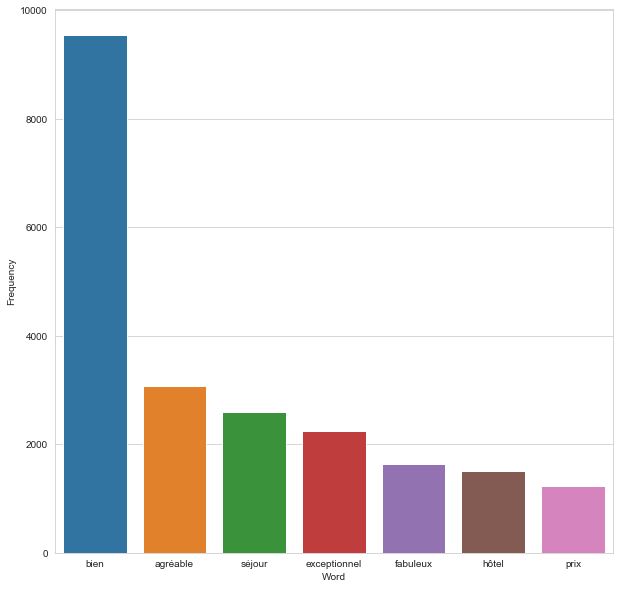

In [26]:
#histogramme des 7 mots les plus fréquents
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

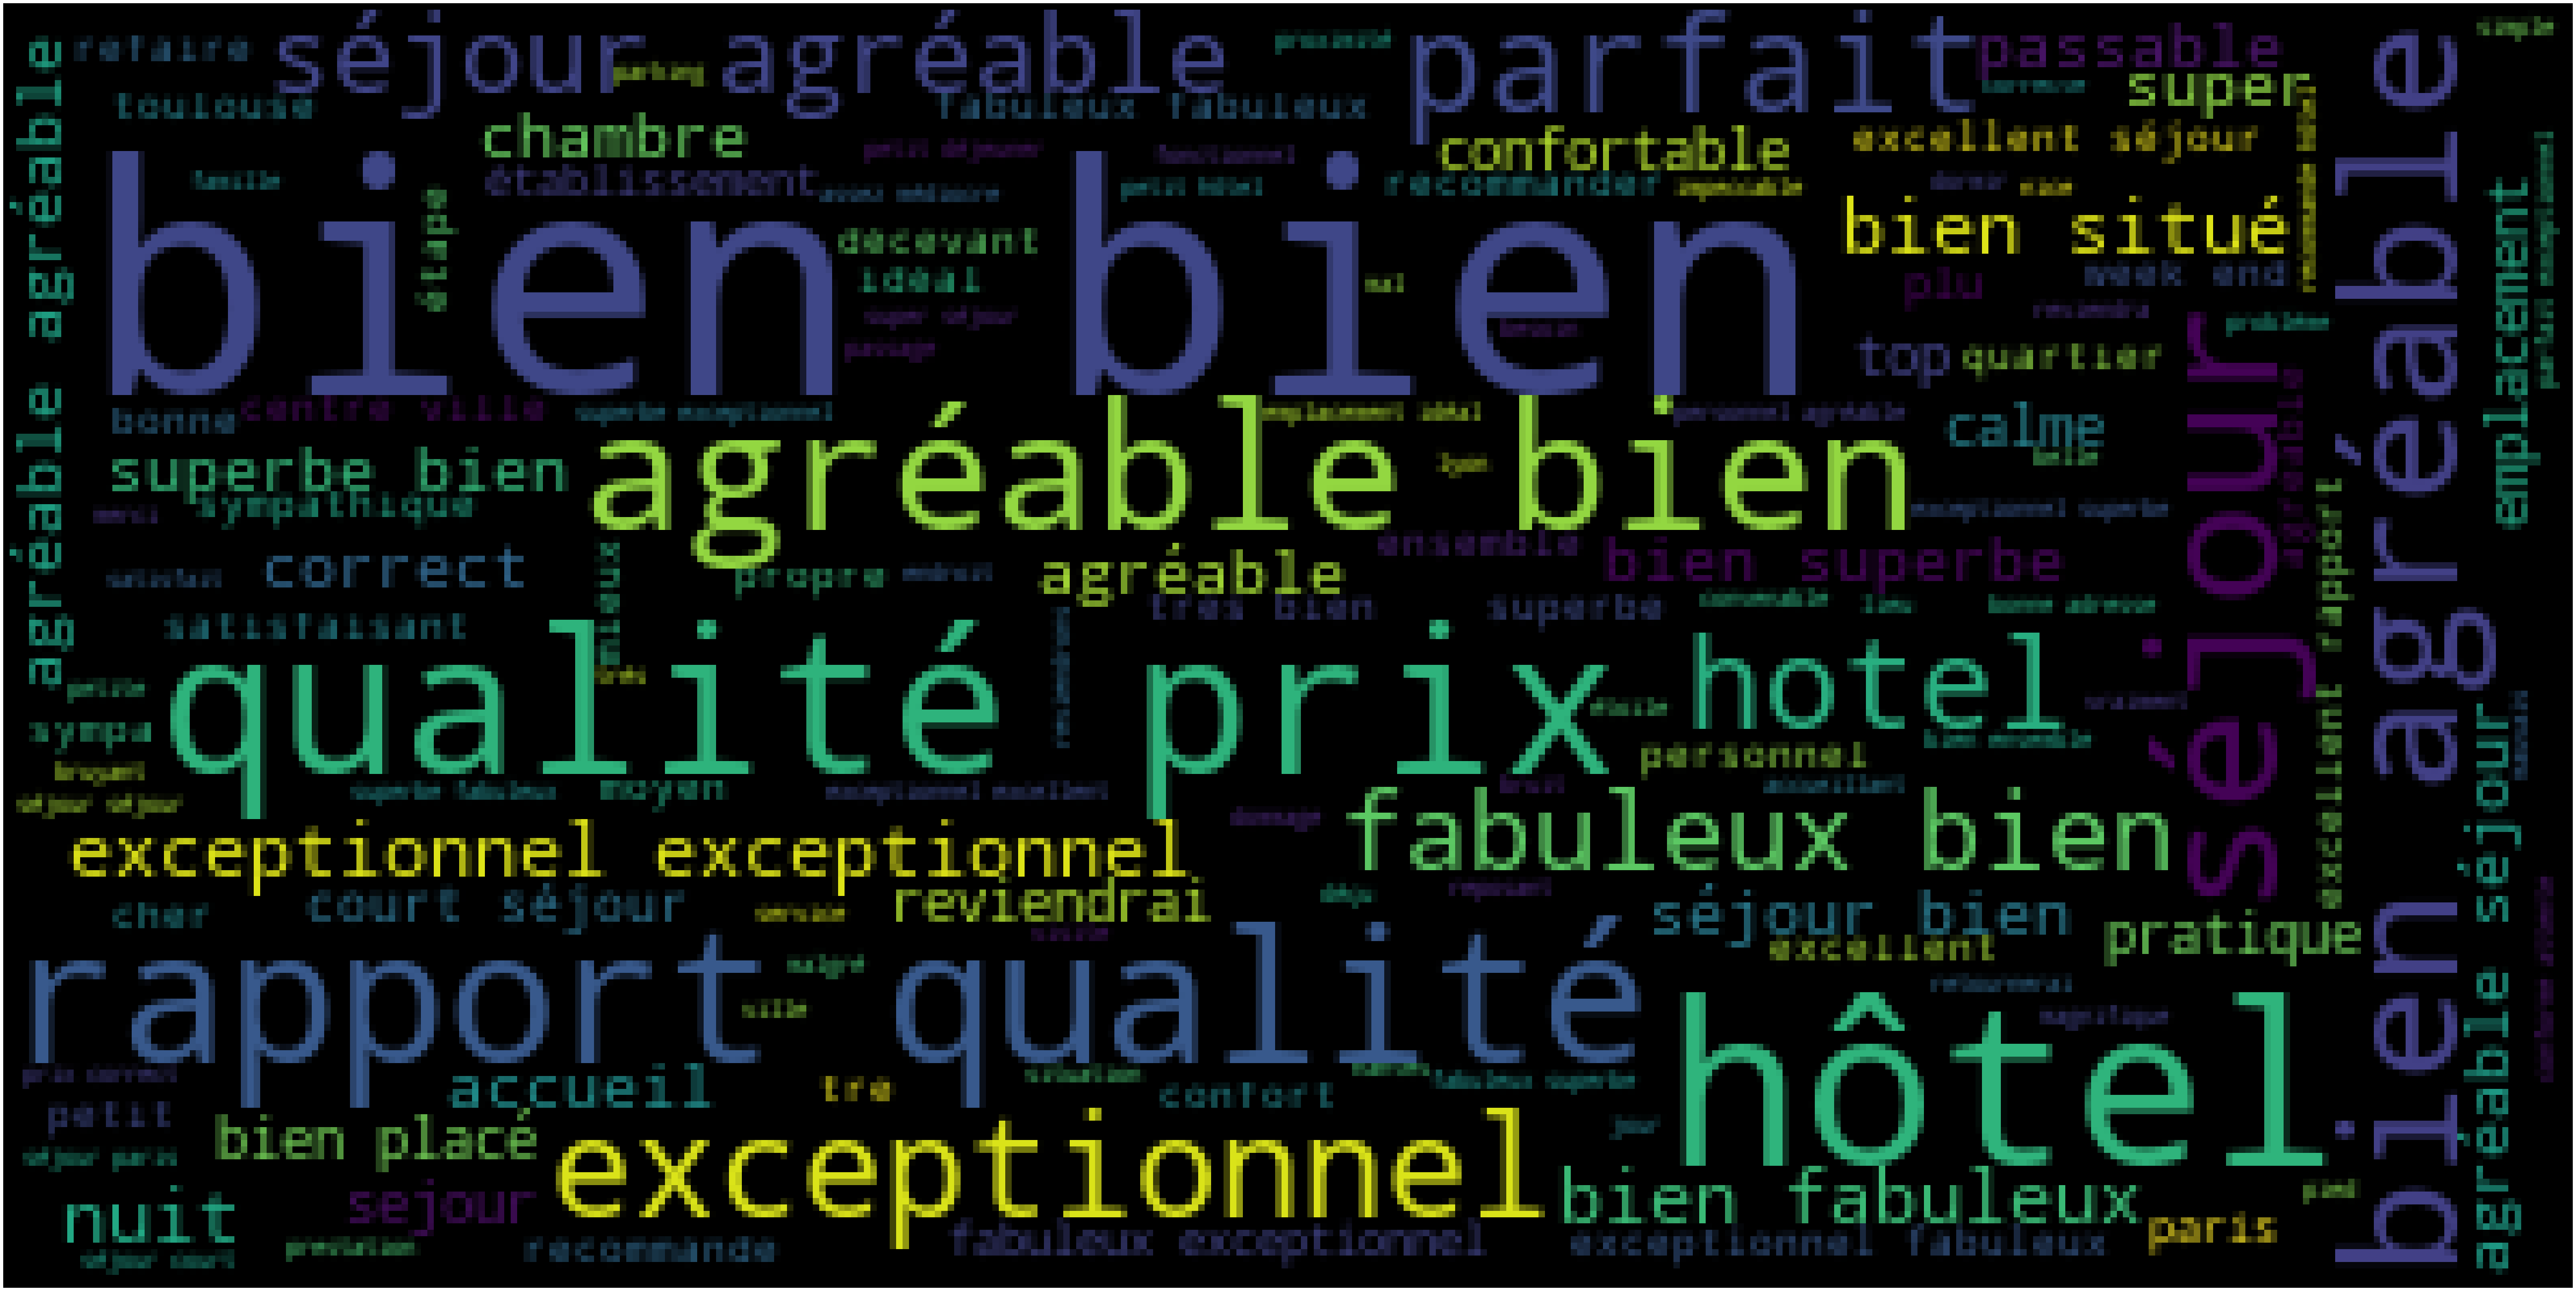

In [27]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [28]:
#mettre tous les éléments en miniscule, séparés par un espace
a = df['bons_points'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres and retourner une liste de mots
b = re.sub('[^a-zàâéèêëïîôùûç]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

In [29]:
#supprimer les caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [30]:
#affichage dans un dataframe des 7 mots les plus fréquents
rslt.head(7)

Word  Frequency
0    personnel       7096
1        petit       6657
2      chambre       6587
3     déjeuner       5299
4         bien       5126
5      accueil       4875
6  emplacement       4508

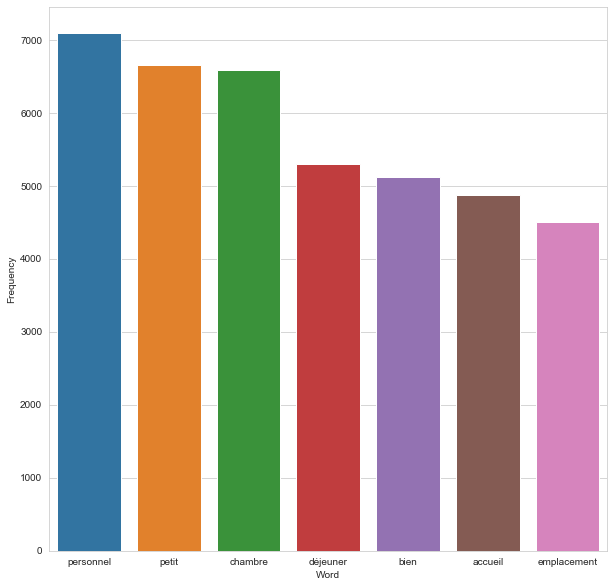

In [31]:
#histogramme des 7 mots les plus fréquents
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

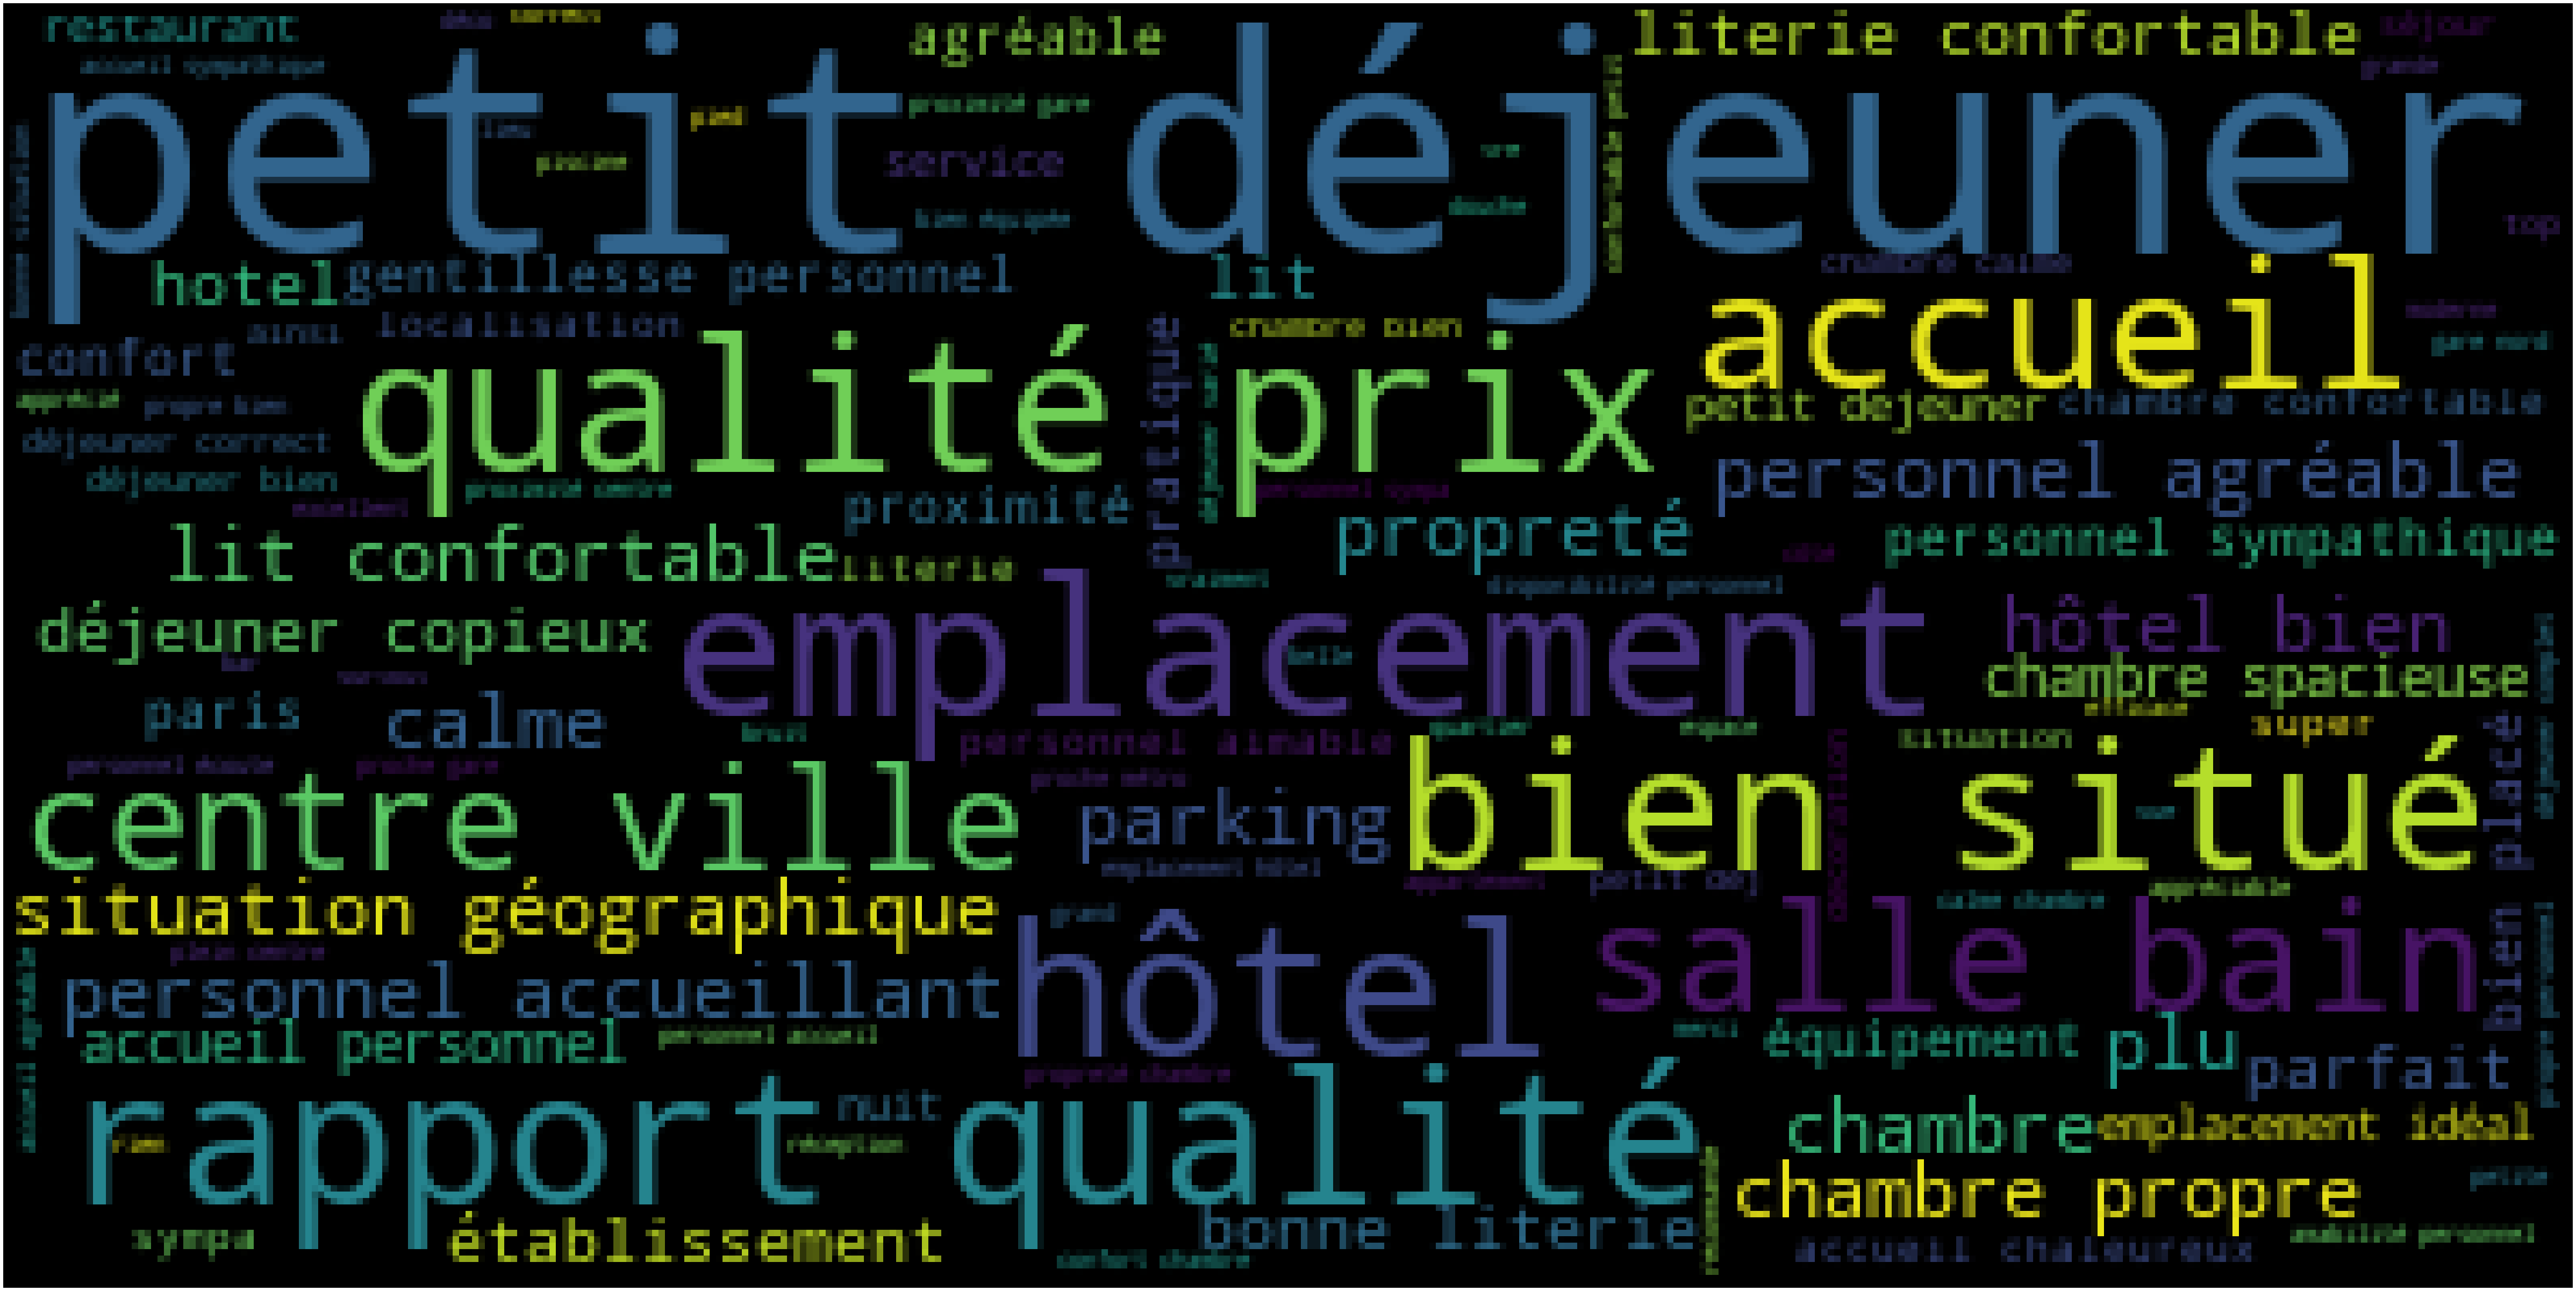

In [32]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [33]:
#mettre tous les éléments en miniscule, séparés par un espace
a = df['mauvais_points'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres and retourner une liste de mots
b = re.sub('[^A-Za-zàâéèêëïîôùûç]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

#supprimer caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

In [34]:
#supprimer caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [35]:
#affichage dans un dataframe des 7 mots les plus fréquents
rslt.head(7)

Word  Frequency
0   chambre       6337
1     petit       3380
2     salle       3138
3  déjeuner       2309
4      bain       2243
5    douche       2047
6      rien       1998

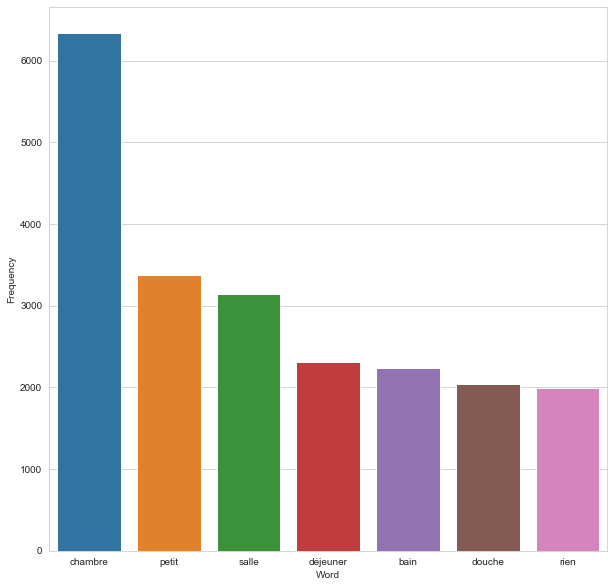

In [36]:
#histogramme des 7 mots les plus fréquents
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

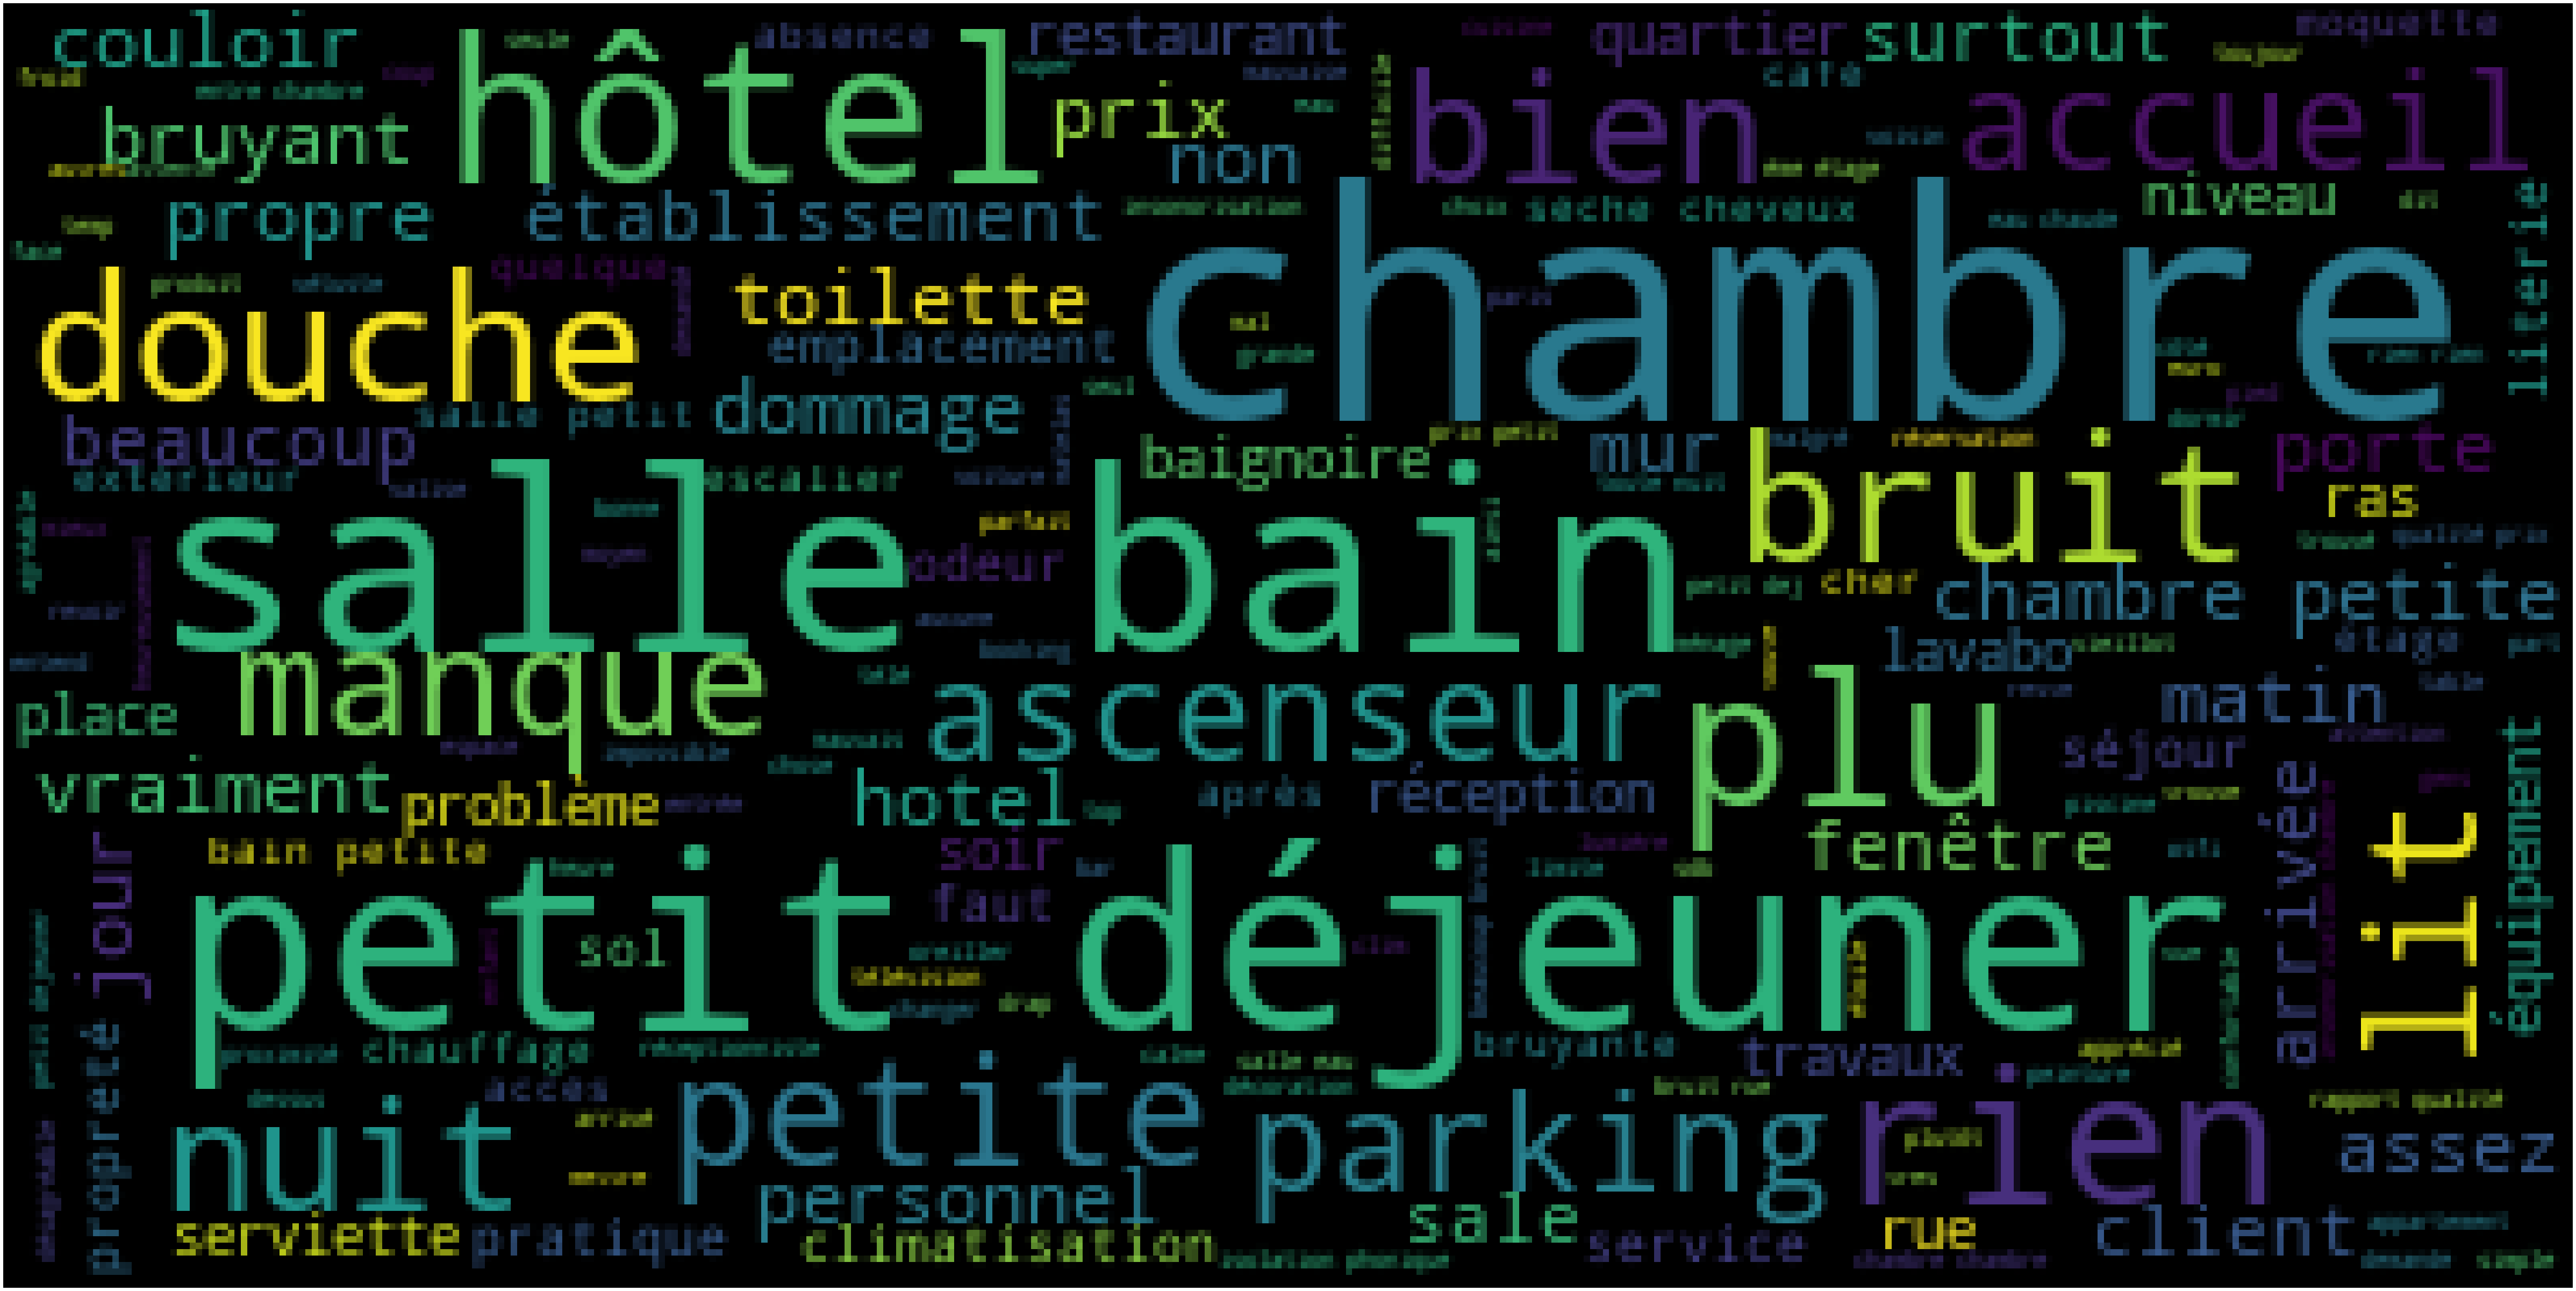

In [37]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [38]:
#vérification que les NaN dans la colonne 'mauvais points' ont bien de façon certaine une polarité de zéro pour TextBlob, 
#sentiment[0]=polarite et sentiment[1]=subjectivité
#text = u"NaN"
#blob = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
#blob.sentiment
#print('NaN a une polarité de {} et une subjectivité de {}.'.format(blob.sentiment[0], blob.sentiment[1]))

In [39]:
#suppression des Nan
#df = df.fillna('')
#suppression de deux phrases récurrentes dans les données
#df = df[df.bons_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
#df = df[df.bons_points != "Ce client n'a pas laissé de commentaire."]

#df = df[df.mauvais_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
#df = df[df.mauvais_points != "Ce client n'a pas laissé de commentaire."]

In [40]:
#suppression de deux phrases récurrentes dans les données
#df = df[df.bons_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
#df = df[df.bons_points != "Ce client n'a pas laissé de commentaire."]

#df = df[df.mauvais_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
#df = df[df.mauvais_points != "Ce client n'a pas laissé de commentaire."]

In [41]:
#concaténation 
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
df22 = pd.DataFrame(df, columns= ['bons_points', 'mauvais_points'])

df23=df22['bons_points']
df24=df22['mauvais_points']

In [42]:
df23=pd.DataFrame(data=df23)
#df23['polarite']=1
df23.head()

bons_points
0  Établissement recent, propre, soigne, chouette...
1  Accueil très chaleureux, chambre calme...tout ...
2  Tout bié sauf le wifi catastrophiquement lent!...
3                                                   
4  Excellent rapport qualité prix. Personnel très...

In [43]:
df24=pd.DataFrame(data=df24)
#df24['polarité']=0
df24.columns = ['bons_points']
df24.head()

bons_points
0                            Rien
1                                
2                                
3  Hôtel parfait. Quartier sympa.
4

In [44]:
frames = [df23, df24]
result = pd.concat(frames)
result

bons_points
0      Établissement recent, propre, soigne, chouette...
1      Accueil très chaleureux, chambre calme...tout ...
2      Tout bié sauf le wifi catastrophiquement lent!...
3                                                       
4      Excellent rapport qualité prix. Personnel très...
...                                                  ...
30941  C'est regrettable de ne pas avoir de plateau d...
30942                     Rien tout étais au top! Merci!
30943                                               Rien
30944                                                   
30945                                           Le bruit

[58844 rows x 1 columns]

In [45]:
df21 = result['bons_points']
df21 = pd.DataFrame(df21, columns=['bons_points'])

In [46]:
df21.head()

bons_points
0  Établissement recent, propre, soigne, chouette...
1  Accueil très chaleureux, chambre calme...tout ...
2  Tout bié sauf le wifi catastrophiquement lent!...
3                                                   
4  Excellent rapport qualité prix. Personnel très...

In [48]:
df21.columns=['sentences']

In [49]:
#mettre les commentaires du dataframe en miniscule
df21['sentences']=df21['sentences'].str.lower()
df21.head()

sentences
0  établissement recent, propre, soigne, chouette...
1  accueil très chaleureux, chambre calme...tout ...
2  tout bié sauf le wifi catastrophiquement lent!...
3                                                   
4  excellent rapport qualité prix. personnel très...

In [50]:
df21.shape

(58844, 1)

In [54]:
#remplacement de tout ce qui n'est pas dans le set[] par un espace
df21['sentences'] = df21['sentences'].apply(lambda x: re.sub('[^a-zàâéèêëïîôùûçæœ]+',' ', str(x))) 
for index, row in df21.iterrows():
    print('index: ', index, 'col sentences:', row['sentences'])

index:  0 col sentences: établissement recent propre soigne chouette design belle chambre bien agencée situe quartier très parisien sens positif terme immersion garantie
index:  1 col sentences: accueil très chaleureux chambre calme tout passer agréable séjour
index:  2 col sentences: tout bié sauf wifi catastrophiquement lent mega seconde
index:  3 col sentences: 
index:  4 col sentences: excellent rapport qualité prix personnel très agréable
index:  5 col sentences: emplacement petit déjeuner gentillesse personnel
index:  6 col sentences: petit hôtel propre chaleureux calme simple efficace boissons chaudes disposition
index:  7 col sentences: quartier propreté calme
index:  8 col sentences: emplacement personnel
index:  9 col sentences: acceuil agréable lit confortable petit déjeuner très bien chance être surclassé
index:  10 col sentences: emplacement
index:  11 col sentences: localisation hôtel personnel charmant hôtel propose boissons chaudes tout moment journée petit déjeuner acc

index:  141 col sentences: calme quartier gentillesse personnel proximité métro rapport qualité prix
index:  142 col sentences: confort emplacement gentillesse personnel coeur quartier historique fameuse rue mouffetard formidable
index:  143 col sentences: emplacement calme
index:  144 col sentences: accueil personnel agréable
index:  145 col sentences: 
index:  146 col sentences: accueil excellent réceptionnistes enthousiastes buffet petit déjeuner suffisant chauffage chambre bonne qualité
index:  147 col sentences: vue panthéon douche propreté confort chambre tranquillité insonorisaton bel aménagement salle bain
index:  148 col sentences: situation géographique personnel sympathique
index:  149 col sentences: midi minuit thé café gratuitement disposition clients
index:  150 col sentences: très bon hôtel déplacement professionnel fonctionnel propre bien situé personnel très correct bon niveau accueil général
index:  151 col sentences: proximité metro chambre petite très confortable fo

index:  231 col sentences: emplacement personnel sympathique très bon rapport qualité prix propre très correct prix reviendrons si besoin revenir paris
index:  232 col sentences: bonne qualité
index:  233 col sentences: hôtel sympa bien placé rue calme chambre agréable
index:  234 col sentences: literie confortable personnel souriant aimable hôtel chambre propre bon rapport-qualité prix emplacement quelques minutes gare montparnasse
index:  235 col sentences: personnel simpa bien situé bane
index:  236 col sentences: hôtel très bien placé voyageurs besoin être proches gare montparnasse literie excellente chambre assez grande paris calme bruit nuit quartier sympa restaurants
index:  237 col sentences: proche lieu devais rendre manque pain petit déjeuner café bon
index:  238 col sentences: lieu
index:  239 col sentences: emplacement idéal proximité transports quartier calme charmant chambre taille suffisante dormir salle bains peu petite toilettes salle bains propreté chambre accueil sym

index:  347 col sentences: adresse
index:  348 col sentences: très bien situé
index:  349 col sentences: accueil emplacement prix abordable
index:  350 col sentences: emplacement
index:  351 col sentences: 
index:  352 col sentences: bon emplacement bonne literie
index:  353 col sentences: situation établissement arrondissement qualité literie
index:  354 col sentences: énormément apprécié lieu cadre petit hôtel personnel charmant disponible accueillant ambiance maison hôtes discrétion anonymat hôtel ouvert jour nuit sans complications sécurité
index:  355 col sentences: viens régulièrement aime endroit tout hâte revenir
index:  356 col sentences: bonne situation géographique bonne attention personnel bon matelas environnement agréable petite cour très sympa
index:  357 col sentences: calme quartier propreté chambre
index:  358 col sentences: situation a deux gare montparnasse idéale éléments confort corrects petit déjeuner copieux prise charge chambre rapide personnel souriant écoute 

index:  524 col sentences: emplacement accueil personnel bienveillant décor
index:  525 col sentences: personnel très agréable chambre fonctionnelle enfin hôtel où wifi fonctionne bien e étage déjà pratiqué plusieurs hôtels paris souvent petit déjeuner propose types jus fruits différents
index:  526 col sentences: vue balcon déco petit déjeuner accueil
index:  527 col sentences: endroit où sent comme chez chez soi personnel accueillant attentionné belle surprise salle déjeuner aménagée sous-sol chaleureuse aménagée goût petit déjeuner copieux bien situé super bon rapport qualité prix
index:  528 col sentences: accueil gentillesse personnel
index:  529 col sentences: acceuil sympathique petit déjeuner chambres originales
index:  530 col sentences: qualité chambre bon petit déjeuner
index:  531 col sentences: hotel cosy original accueil service formidables reviendrai grand plaisir
index:  532 col sentences: équipe accueil top emplacement boulevards a proximité tout petit-déjeuner copieux

index:  600 col sentences: etablissement toujours aussi agréable direction personnel très sympathiques belles rénovations entrepris chambre très agréable salle petits-déjeuners spacieuse vraiment très jolie petit-déjeuner copieux
index:  601 col sentences: absolument tout toujours énorme plaisir venir cet établissement
index:  602 col sentences: chambre neuve déco originale personnalisée literie impeccable comme isolation situation centrale rue calme petit-déjeuner continental très bonne qualité personnel avenant
index:  603 col sentences: hôtel très bien situé juste côté parking souterrain très bien accueillis décoration vraiment sympa chambre pays tintin confortable petit déjeuner offre grande diversité produits qualité a proposé garder bagages journée lendemain
index:  604 col sentences: emplacement parfait rue peu passante toutes commodités alentour personnel accueillant souriant écoute petit déjeuner très complet très bon chambre déco non standard appréciable impression hôtel part

index:  695 col sentences: situation
index:  696 col sentences: grande chambre belle sdb très calme très bonne literie
index:  697 col sentences: bon emplacement accessible tout pleins restos autour assez agréable
index:  698 col sentences: emplacement parfait
index:  699 col sentences: accueil excellent
index:  700 col sentences: établissement propre personnel fort sympathique
index:  701 col sentences: emplacement parfait chambre située étage vue arc triomphe chambre spacieuse ainsi salle bains bien équipée personnel très gentil attentif diverses demandes
index:  702 col sentences: top hôtel personnel charmant super bien situé
index:  703 col sentences: personnel accueil très gentil coopératif
index:  704 col sentences: excellent emplacement
index:  705 col sentences: super petit déjeuner chambre très bien
index:  706 col sentences: personnel très agréables écoute personnel réception super sympa emplacement hôtel excellent a proximité champs elysées métro proximité déplacer paris pro

index:  803 col sentences: très bonne accueil personnelle très professionnel
index:  804 col sentences: 
index:  805 col sentences: batiment exterieur entree tres joli
index:  806 col sentences: etablissement très bien situés
index:  807 col sentences: bien chambres peu vieillot
index:  808 col sentences: situation géographique
index:  809 col sentences: accueil emplacement propreté literie
index:  810 col sentences: hall accueil façade art déco personnel prévenant
index:  811 col sentences: excellent accueil belle chambre quadruple tres bonne literie extrêmement bien situé petit déjeuner complet retournerai
index:  812 col sentences: accueil
index:  813 col sentences: rien comme imaginer
index:  814 col sentences: emplacement très proche métro propreté
index:  815 col sentences: accueil sympathique chambre propre insonorisée petit déjeuner copieux tout parfait recommande
index:  816 col sentences: excellente situation géographique personnel très agréable très bon petit dej copieux
ind

index:  926 col sentences: 
index:  927 col sentences: réfrigérateur chambre
index:  928 col sentences: réception écoute souriante hôtel loin magasins restaurants
index:  929 col sentences: personnel très serviable chambre faite chaque jour changement linge toilette literie bonne qualité chambre ième calmes disposent douches wc chambres très bonne situation géographique commerces proximité petit déjeuner correct bistrot proche mcdonald proximité dépanner
index:  930 col sentences: hotel simple rue tranquille proche metro minutes pieds opéra bastille personnel grande amabilité
index:  931 col sentences: personnel très accueillant frigidaire micro onde chambre plus hôtel très bien situé
index:  932 col sentences: copieux simple bien
index:  933 col sentences: fait tres bon rapport qualité prix merci
index:  934 col sentences: près metro
index:  935 col sentences: chambre propre lit confortable
index:  936 col sentences: prix bas a argent quoi attend surprise
index:  937 col sentences: ac

index:  1023 col sentences: toilettes prope
index:  1024 col sentences: pratique
index:  1025 col sentences: douche commun
index:  1026 col sentences: bon accueil bonne adresse paris
index:  1027 col sentences: arrivant peut réticent car hôtel assez vieux chambre propre calme conseil petit budget
index:  1028 col sentences: chance cet hôtel situé rue assez calme commerçants gros chambre claire propre a serviettes lavabo savon frigo micro-ondes utile sympa
index:  1029 col sentences: prix situation acceui
index:  1030 col sentences: personnel très sympathique douches wc très propre pallier
index:  1031 col sentences: aimé acceuil confort
index:  1032 col sentences: très pratique central bon quartier staff adorable nuisance sonore très propre assez confortable excellent rapport qualité prix
index:  1033 col sentences: rapport qualité prix situation géographique accueil
index:  1034 col sentences: chambre bien chauffée métro quartier beaucoup restaurants sanitaires chambres - gene
index: 

index:  1141 col sentences: emplacement métro établissement personel jeune dynamique actif parle plusieurs langue sauf arabe bien
index:  1142 col sentences: chambre propre toilettes douche séparés bar auberge très sympa bon accueil personnel
index:  1143 col sentences: 
index:  1144 col sentences: lieu accueil point positif prix adapté lieu passé bonne nuit ensemble bravo personnel présent là aider
index:  1145 col sentences: propreté contact gens
index:  1146 col sentences: location
index:  1147 col sentences: qualité literie propreté equipements chambre
index:  1148 col sentences: auberge moderne propre très bien décorée personnel réception très sympa
index:  1149 col sentences: propreté
index:  1150 col sentences: calme propreté professionnalisme
index:  1151 col sentences: 
index:  1152 col sentences: couloirs espaces où trouvent chambres vraiment propres hélas passable prix bar peu cher euros expresso café allongé
index:  1153 col sentences: cependant personel tres sympathique ac

index:  1292 col sentences: classe moderne bien situé serviable surtout personnel nocturne
index:  1293 col sentences: lit confortable
index:  1294 col sentences: lit propreté fonctionnalité
index:  1295 col sentences: première fois séjournais hotel lits superposés ensemble inconnus tout apprécié genre chambre voulais
index:  1296 col sentences: rooftop pratique déco chouette chambre clean super terrasse
index:  1297 col sentences: vue bar dernier étage vaut séjourné cet établissement chambre occupais terrase spacieuse jolie vue paris petit déjeuner copieux salles communes accueillants très bon service
index:  1298 col sentences: relativement proche métro accueil h h
index:  1299 col sentences: bonne position petit déjeuner copieux ambiance très propre confortable chauffage marchait bien
index:  1300 col sentences: moderne insonorisé metro
index:  1301 col sentences: propreté générale couchages petit déjeuner espace douche ambiance générale panorama ème vue sacré coeur proximité métro 

index:  1478 col sentences: très sympa
index:  1479 col sentences: 
index:  1480 col sentences: gentillesse professionnalisme toute equipe merci meryem zaher tout ainsi a direction a veillé ajouter produits sans gluten menu petit déjeuner suite demande
index:  1481 col sentences: tout allait bien recommande reviendrai
index:  1482 col sentences: lit moelleux
index:  1483 col sentences: service excellent personnel écoute proximité
index:  1484 col sentences: merci hospitalité
index:  1485 col sentences: 
index:  1486 col sentences: lit confortable chambre calme douche très agréable accueil chaleureux ouvert tout temps petit déjeuner basique type hotel tout fait satisfaisant
index:  1487 col sentences: tout
index:  1488 col sentences: correspondait photos éclairage lecture auprès deuxième lit bruyant
index:  1489 col sentences: tout
index:  1490 col sentences: tout
index:  1491 col sentences: emplacement petit déjeuner sympathie personnel petits soins calme
index:  1492 col sentences: si

index:  1601 col sentences: chambre grande joliment décorée récemment rénovée
index:  1602 col sentences: personnel serviable disponible
index:  1603 col sentences: emplacement excellent so concierges très compétants
index:  1604 col sentences: petit déjeuner
index:  1605 col sentences: accueil très agréable
index:  1606 col sentences: personnel très sympathique séjourné enfants donc deux chambres communicantes peu bruyant malgré travaux rue litrie très bonne petit déjeuner bon
index:  1607 col sentences: 
index:  1608 col sentences: amabilité disponibilité personnel confort chambre silence qualité installations quartier calme situation géographique très pratique
index:  1609 col sentences: baignoire petite terrasse emplacement
index:  1610 col sentences: très bien placé literie qualité chambre spacieuse
index:  1611 col sentences: demande particulière facturation non prise compte
index:  1612 col sentences: tout
index:  1613 col sentences: chambre venait être rénovée personnel ménage 

index:  1791 col sentences: emplacement idéal literie très confortable
index:  1792 col sentences: accueil style gentillesse désirs optimiser séjours clients surclassement chambre car libre cette nuit là effectivement chambre très accueillante confortable décorée style originalité
index:  1793 col sentences: très bien
index:  1794 col sentences: situation géographique parfaite tablissement charme recommander merci personnel particulièrement réception gentillesse classement reviendrons
index:  1795 col sentences: beaucoup charme chambres familiales étage top
index:  1796 col sentences: petit déjeuner varié qualité enfin fruits frais bon café non soluble bon pain personnel très serviable efficace chambre très calme cour emplacement incroyable quasiment place madeleine
index:  1797 col sentences: emplacement idéal aller vers salles spectacles louvre grands magasins décoration très chaleureuse personnel très agréable souriant disponible petit déjeuner excellent calme cour
index:  1798 col 

index:  1891 col sentences: situation ambiance hotel
index:  1892 col sentences: emplacement personnel petit soin petit dej
index:  1893 col sentences: litterie excellente terrasse chambre agréable super emplacement centre paris
index:  1894 col sentences: accueil
index:  1895 col sentences: style british salon ascenseur bois lit king size tres confortable petite terrasse bien exposée
index:  1896 col sentences: chambre impeccable très grande sdb très bien équipée accueil charmant café départ offert pdj très complet
index:  1897 col sentences: situation exceptionnelle personnel très gentil chambre spacieuse propre calme
index:  1898 col sentences: emplacement personnel
index:  1899 col sentences: petit dej bien look chambre sympa lit très agréable
index:  1900 col sentences: hôtel très beau décoré goût chambre spacieuse très cozy douche baignoire réservé cet hôtel parents séjourné pendant nuits ravis tant petit déjeuner confort chambre calme excellemment bien situé hôtel permet accéder

index:  2119 col sentences: taille studio localisation cuisine
index:  2120 col sentences: agit appartements fraîchement rénovés très propres immeuble très bien situé minutes métro écart bruit grands axes pièces a studios boulangeries bars restaurants immédiatement proximité repas pdj accueil place adresse conserver
index:  2125 col sentences: literie excellente impeccable point vue propreté petit déjeuner copieux délicieux très bien situé
index:  2126 col sentences: emplacement services
index:  2127 col sentences: situation hôtel proche tout pouvoir visiter paris
index:  2128 col sentences: emplacement petit dej copieux varié propreté service bagagerie
index:  2129 col sentences: accès métro ambiance hall mode nature
index:  2130 col sentences: petit déjeuner h h
index:  2131 col sentences: très bon pain ainsi crêpes bonne literie salle eau peu petite personne grande
index:  2132 col sentences: literie petit déjeuner calme
index:  2133 col sentences: 
index:  2134 col sentences: 
inde

index:  2297 col sentences: 
index:  2298 col sentences: proprete accueil emplacement
index:  2299 col sentences: excellent petit déjeuner fruits pain viennoiseries très bonnes très varié charcuterie œufs crêpes laitages abondance fruits frais aussi salade literie emplacement pieds métro cambronne
index:  2300 col sentences: 
index:  2301 col sentences: 
index:  2302 col sentences: emplacement proche métro quartier assez sympa vue tour eiffel personnel écoute très réactif
index:  2303 col sentences: emplacement super tout proche station métro cambronne tour eiffel
index:  2304 col sentences: hall entree bien décoré design ecolo apprécié
index:  2305 col sentences: lit confortable propre
index:  2306 col sentences: accuelil très bien
index:  2307 col sentences: bonne location près métro beau rez-de-chaussée
index:  2308 col sentences: petit déjeuner copieux varié petite touche parisienne niveau mobilier bien agencé très bons gâteaux faits maison comme madeleines cake sucré bon pain char

index:  2480 col sentences: manque prises électriques chambre salle bain
index:  2481 col sentences: accueil disponibilité personnel
index:  2482 col sentences: emplacement propreté calme
index:  2483 col sentences: emplacement propreté
index:  2484 col sentences: personnel écoute arrangeant chambre propre parking vaste
index:  2485 col sentences: copieux bon choix
index:  2486 col sentences: petit déjeuné bon varié literie très bonne bar restaurant très agréable idéal enfants peuvent jouer tranquillement
index:  2487 col sentences: espace détente piscine petit déj copieux varié repas correct personnel sympa
index:  2488 col sentences: bonne situation
index:  2489 col sentences: accueil emplacement
index:  2490 col sentences: personnels accueillant emplacement hôtel
index:  2491 col sentences: literie personnel petit déjeuner tarif
index:  2492 col sentences: proximité transports commun bus tram metro
index:  2493 col sentences: petit déjeuné très bon emplacement bien
index:  2494 col 

index:  2674 col sentences: petit déjeuner copieux - bon emplacement promener
index:  2675 col sentences: localisation personnel agréable confort
index:  2676 col sentences: accueil gentillesse personnel localisation
index:  2677 col sentences: hôtel pied sacré coeur chambre salle bains peu vieillottes propres lit confortable
index:  2678 col sentences: proximité montmartre
index:  2679 col sentences: lit propre matelas confortable moisissures salle bains hôtel très bien situé bien dormi nuit calme sans perturbations extérieures
index:  2680 col sentences: amabilité personnel
index:  2681 col sentences: pied butte montmartre desserte transports commun accueil
index:  2682 col sentences: fait bien situé quartier sympa personnel sympa
index:  2683 col sentences: rapport qualité prix emplacement confort lit
index:  2684 col sentences: accueil
index:  2685 col sentences: accueil très sympathique
index:  2686 col sentences: très bon accueil petits déjeuners copieux
index:  2687 col sentence

index:  2773 col sentences: très bon emplacement paris
index:  2774 col sentences: a proximité gare nord
index:  2775 col sentences: salle bains spacieuse chambre propre largement suffisante personne seule petit déjeuner copieux pain viennoiseries fraîches localisation top voir sacré coeur nuit juste splendide
index:  2776 col sentences: chambre plutôt spacieuse jolie vue toits depuis ème étage proximité métro quartier vivant
index:  2777 col sentences: emplacement prix imbattable personnel direction literie
index:  2778 col sentences: service petit déjeuner localisation hôtel
index:  2779 col sentences: localisation établissement taille chambres familiales service table petit déjeuner
index:  2780 col sentences: déjeuner très correct prix
index:  2781 col sentences: hôtel pied montmartre moulin rouge parfait visiter côté paris outre arrêt open tour bus panoramique quelques mètres parking anvers aussi quelques mètres très cher outre situation chambre propre taille correcte salle bain g

index:  2874 col sentences: personnel super sympa calme chambre malgré proximité périphérique
index:  2875 col sentences: 
index:  2876 col sentences: lit
index:  2877 col sentences: sèche cheveux plus a compté
index:  2878 col sentences: 
index:  2879 col sentences: accès rapide facile autoroute a parking fermé hôtel
index:  2880 col sentences: beaucoup confort chambres grandes petit déjeuner beaucoup choix personnel très compétent
index:  2881 col sentences: endroit calme tranquille proche halles
index:  2882 col sentences: belle chambre très bonne literie bon accueil arrivée
index:  2883 col sentences: prix
index:  2884 col sentences: propreté lieux décorum tv écran plat
index:  2885 col sentences: prix plutôt abordable
index:  2886 col sentences: situation agreable circuler
index:  2887 col sentences: personnel a accueil top tous souriant a écoute demande
index:  2888 col sentences: bon accueil chambre propre petit déjeuner copieux parking pratique
index:  2889 col sentences: calme

index:  3063 col sentences: super hôtel confortable personnel super agréable dispo toute demande déjeuner très bon varié chambres spacieuses bien insonorisées joli écran plat grande taille chambre sent très aise cet hôtel retournerais min pied station métro très pratique
index:  3064 col sentences: chambre très spacieuse literie excellente
index:  3065 col sentences: prix taille chambre
index:  3066 col sentences: belle chambre confortable spacieuse
index:  3067 col sentences: chambre confortable spacieuse
index:  3068 col sentences: hôtel calme malgré proximité x voies idéalement situé match stade france chambre spacieuse literie très confortable hôtel très propre personnel disponible
index:  3069 col sentences: chambre spacieuse petite kitchenette sympa sus seul bémol emplacement hôtel plus loin tout restaurant intérieur pallier cet isolement
index:  3070 col sentences: 
index:  3071 col sentences: 
index:  3072 col sentences: 
index:  3073 col sentences: qualité prestations belle ch

index:  3167 col sentences: chambre agréable grand télé sdb sympa
index:  3168 col sentences: chambre famille vraiment top
index:  3169 col sentences: quartier où situé hotel jonche migrants sans abri toxicomanes
index:  3170 col sentences: suite confortable joliment décorée
index:  3171 col sentences: parking bien sécurisé
index:  3172 col sentences: petit déjeuner peu choix tables chaises non confortables manque propreté salle petits dej plateaux débarrassés alors petit déjeuner non terminé
index:  3173 col sentences: équipements chambre spacieuse calme
index:  3174 col sentences: accueil personnel chambre propre spacieuse famille petit-déjeuner bonne qualité prix situé proximité transports commun accès pratique venant a
index:  3175 col sentences: personnels très bien très sympa
index:  3176 col sentences: 
index:  3177 col sentences: chambre très spacieuse belle salle bain
index:  3178 col sentences: système chambre attenantes
index:  3179 col sentences: adoré cet hôtel chambres co

index:  3323 col sentences: prix localisation personnel accueillant chambre si petite prix plutôt bien pensée
index:  3324 col sentences: proche tram métro ligne check in rapide chambre donnant cour donc très calme isolation phonique fenêtre très bon niveau chambre fonctionnelle nombreux restaurants proximité
index:  3325 col sentences: wifi
index:  3326 col sentences: très bon acceuil douche correct lits vraiments confortables très bon rapport qualité prix ceux recherchent juste endroit dormir
index:  3327 col sentences: bon petit déjeuner
index:  3328 col sentences: emplacement
index:  3329 col sentences: petit déjeuner
index:  3330 col sentences: petit-déjeuner tout fait correct
index:  3331 col sentences: petit dejeuner
index:  3332 col sentences: proche métro transport entrée sortie périphérique prix
index:  3333 col sentences: pratique propre
index:  3334 col sentences: 
index:  3335 col sentences: literie correcte puis emplacement pratique
index:  3336 col sentences: emplacement

index:  3448 col sentences: 
index:  3449 col sentences: emplacement métro portes hôtel personnel très agréable très serviable propreté hôtel chambres
index:  3450 col sentences: salle bain privé
index:  3451 col sentences: accueil
index:  3452 col sentences: sympathie équipes prix
index:  3453 col sentences: accueil très bon petit déjeuner très satisfaisant chambre très bien accessibilité très bonne
index:  3454 col sentences: situation correcte proche arrêt autobus gare lyon bon confort personnel agréable quartier vivant sans être trop bruyant
index:  3455 col sentences: revoir pieds lit
index:  3456 col sentences: emplacement génial
index:  3457 col sentences: - rapport qualité prix bien - personnel faire très sympathique - literie très agréable - chambre ensemble plutôt sympa - vu toits agréables
index:  3458 col sentences: proximité gare lyon bus métro a proximité plusieurs restaurants sympas proximité immédiate
index:  3459 col sentences: bon confort
index:  3460 col sentences: r

index:  3599 col sentences: 
index:  3600 col sentences: accueil sympa proximité station métro calme hôtel chambre agréable literie confortable enfin hôtel parisien abordable financièrement
index:  3601 col sentences: emplacement
index:  3602 col sentences: 
index:  3603 col sentences: situation hotel proximité immédiate métro possibilité laisser bagages après avoir quitter chambre
index:  3604 col sentences: etions adultes grands lits demandé changement chambre car lits etait confortable gerant a pu repondre demande gentillesse pu passer ainsi bonnes nuits après longues heures marche parisiennesur
index:  3605 col sentences: situation juste côté métro min pied république chambre propre
index:  3606 col sentences: situation géographique près métro quartier vivant personnel très accueillant serviable présent chambre cour calme
index:  3607 col sentences: localisation quartier literie fait être cour
index:  3608 col sentences: 
index:  3609 col sentences: situation calme confort
index:  

index:  3714 col sentences: personnel très accueillant poli sympathique chambre donne cour abri bruit rue métro aérien juste face
index:  3715 col sentences: emplacement idéal rejoindre gare paris nord
index:  3716 col sentences: literie excellente accueil agréable accessibilité parfaite visiter paris
index:  3717 col sentences: proximité gare nord amabilité personnel
index:  3718 col sentences: location
index:  3719 col sentences: bruit métro quartier très rassurant personnel sympa chambre convenable prix intéressant métro loin
index:  3720 col sentences: personnel petite cuisine commune très très près métro gare nord
index:  3721 col sentences: personnel gentillesse comme fait plus cela fait tte différence hôtel remplit critères gamme
index:  3722 col sentences: wifi chambre salle bains
index:  3723 col sentences: bonjour résidence situe proximité facile gare nord pied très proche quartier montmartre basilique sacré cœur pied personnel très agréable font atouts majeurs étape suffisan

index:  3871 col sentences: personnel adorable vieil hôtel très parisien beaucoup charme
index:  3872 col sentences: chambre cher
index:  3873 col sentences: personnel très chaleureux
index:  3874 col sentences: établissement services h h
index:  3875 col sentences: grand chose mis a part prix abordable fait entende bruit train juste côté
index:  3876 col sentences: personnel adorable lit très confortable rapport qualité-prix juste hôtel tout près gare nord
index:  3877 col sentences: grand-chose
index:  3878 col sentences: 
index:  3879 col sentences: 
index:  3880 col sentences: tout exceptionnel super emplacement très proche metro
index:  3881 col sentences: loué cet hôtel rapprocher aéroport cherchais endroit touristisque hôtel tout près station métro valises parfait
index:  3882 col sentences: proximité centre
index:  3883 col sentences: hotel idéalement placé visiter paris chambre salle bains propres lit confortable surtout personnel adorable serviable reviendra dès prochain séjo

index:  4006 col sentences: emplacement prix
index:  4007 col sentences: 
index:  4008 col sentences: particulièrement apprécié accueil très chaleureux
index:  4009 col sentences: personnel accueillant hôtel bien situé
index:  4010 col sentences: situation amabilité personnel
index:  4011 col sentences: 
index:  4012 col sentences: hôtel situé quartier central agréable chambre grande claire calme jusqu heures bruit rue après très bon petit déjeuner personnel aimable souriant
index:  4013 col sentences: professionnalisme directrice gérer problème
index:  4014 col sentences: accueil excellent personnel souriant petit déjeuner très bien bon rapport qualité prix
index:  4015 col sentences: petit déjeuner personnel
index:  4016 col sentences: 
index:  4017 col sentences: hôtel bien situé chambre vétustes petites propreté revoir literie correct sauf oreillers peu confortables petit déjeuner accueil très corrects prix euros nuit excessif niveau prestation autres hôtels quartier moins chers
in

index:  4161 col sentences: niveau propreté rien dire femmes chambres rencontrées hôtel faisaient parties personnel plus aimables bravo elles
index:  4162 col sentences: ras
index:  4163 col sentences: propreté sympathie personnel
index:  4164 col sentences: petit déjeuner parfait accueil également personnel disponible courtois
index:  4165 col sentences: accueil efficace rapide bonne literie bien situé rapport cherchais
index:  4166 col sentences: literie superbe
index:  4167 col sentences: 
index:  4168 col sentences: hôtel très bien très propre super petit déjeuner a recommander vivement
index:  4169 col sentences: bon raport qualité prix propreté irréprochable bon petit déjeuner
index:  4170 col sentences: vraiment personnel reception sauve mise gentil serviable
index:  4171 col sentences: rapport qualité prix proximité transports commun métro porte saint ouen personnel disponible
index:  4172 col sentences: tranquilité
index:  4173 col sentences: petit déjeuner globalement correct

index:  4346 col sentences: 
index:  4347 col sentences: petit déjeuner beaucoup choix salé sucré compris fruits muesli lait végétal
index:  4348 col sentences: hotel bien placé vers place italie bonne insonorisation
index:  4349 col sentences: petit dejeuner localisation acceuil
index:  4350 col sentences: hôtel très bien placé transports commun mn pied ligne bus proximité personnel écoute petit déj poil
index:  4351 col sentences: ibis standard sans surprise très bonne literie personnel accueillant bien situé
index:  4352 col sentences: réceptionniste accueil a très arrangeant a su répondre a besoin changer oreiller a très a écoute a su adapter a exigence emplacement près place italie convenait très bien pu tout faire a pied rendre ème arrondissement période grève décembre etait tres appreciable
index:  4353 col sentences: emplacement tout près place italie places parking disponible parking petit faut manœuvrer etablissement bien insonorisé petit déjeuner correct
index:  4354 col sen

index:  4527 col sentences: petit déjeuner personnel gentillesse extrême souriant chambre calme cour
index:  4528 col sentences: petit-déjeuner convenable peut etre amélioré moins industriels viennoiserie plus frais
index:  4529 col sentences: rien
index:  4530 col sentences: rien
index:  4531 col sentences: situation géographique
index:  4532 col sentences: calme propre correct prix p dej copieux bon metro parking pratique
index:  4533 col sentences: 
index:  4534 col sentences: 
index:  4535 col sentences: 
index:  4536 col sentences: compte tenu emplacement avenue italie très bonne isolation sonore
index:  4537 col sentences: accueil sympathique professionnel petit déjeuner variété choix
index:  4538 col sentences: bon rapport qualité-prix très propre confortable surmatelas assez calme bien situé métro restaurants centre commercial snack bar réception petit déjeuner varié
index:  4539 col sentences: hotel tres bien situe pres placd italie chambre confortable bonne literie sdb peu ét

index:  4700 col sentences: personnel professionnel propreté
index:  4701 col sentences: 
index:  4702 col sentences: accueil décoration
index:  4703 col sentences: situation géographie
index:  4704 col sentences: très bon rapport qualité prix concernant petit déjeuner personnel très accueillant serviable
index:  4705 col sentences: correspondance classement propreté personnel serviable compréhensif changement chambre ème étage ème
index:  4706 col sentences: accueil propreté lieux
index:  4707 col sentences: - situation géographique proche métro - personnel sympathique présence
index:  4708 col sentences: personnel agréable hôtel confortable propre
index:  4709 col sentences: accueil propreté situation hôtel
index:  4710 col sentences: très bon rapport qualité prix propreté chambre calme
index:  4711 col sentences: accueil personnel propreté chambre ainsi petit déjeuner
index:  4712 col sentences: décoration sympa mobilier lit particulier qualité tout mal dormi toute literie changer c

index:  4854 col sentences: 
index:  4855 col sentences: 
index:  4856 col sentences: accueil arrivée chaque passage très attentionné très soucieux confort chapeau bas demoiselle origine hindou trouvant accueil très souriante serviable écoute clients bons conseils belle personne bel exemple professionnalisme continuez ainsi changez rien
index:  4857 col sentences: séjourné nuits cette hotel malgré arrivé tardive grande chambre dernier épouse passé très bon séjour tou parfait personnel très gentil chambres propres bien nettoyés chaque jour hotel vient être rénové sy sent sécurité petit déjeuner correct hôtel bien situé gare nord chapelle coté cœur little javna quartier tamoul paris somme venu cette ambiance shopping indien adorée sans hésité quartier favori paris reviendrons
index:  4858 col sentences: 
index:  4859 col sentences: accueil très sympathique contente
index:  4860 col sentences: regardé commentaires avant séjour coup gardes plusieurs personnes parlaient bruit avère chambre 

index:  5085 col sentences: emplacement top parking plus bien utile petit-déjeuner copieux ici accueil affable
index:  5086 col sentences: chambre très propre
index:  5087 col sentences: personnel espace petit déjeuner souffert sympa
index:  5088 col sentences: 
index:  5089 col sentences: petit dej correct personnel agreable compromis qualité prix acceptable place parking disponible prix acceptable
index:  5090 col sentences: petit déjeuner correct
index:  5091 col sentences: amabilité disponibilité personnel
index:  5092 col sentences: confort lit drap oreiller calme bâtiment
index:  5093 col sentences: 
index:  5094 col sentences: 
index:  5095 col sentences: chambre standard propreté correcte a minutes pied gare nord très pratique moment grèves peu transports commun
index:  5096 col sentences: literie disponibilité horaire réception propreté
index:  5097 col sentences: carrefour market juste bas environnement hôtel spacieux
index:  5098 col sentences: 
index:  5099 col sentences: s

index:  5262 col sentences: situation hôtel
index:  5263 col sentences: accueil proximité gare st lazare
index:  5264 col sentences: emplacement près gare st lazarre
index:  5265 col sentences: déplacement nuit apprécié chambre possède tous équipements nécessaires niveau rapport qualité prix difficile trouver mieux paris aussi bien situé rapport endroit où rendais
index:  5266 col sentences: gentillesse personnel propreté chambre
index:  5267 col sentences: personnel très souriant chambres disponibles
index:  5268 col sentences: accueil sympathique attentionné hôtel ancien partiellement rénové décoration parties communes chaleureuse petit déjeuner continental copieux bon prix très correct bonne insonorisation
index:  5269 col sentences: lieu bien situé chambre confortable
index:  5270 col sentences: serviable
index:  5271 col sentences: personnel sympa efficace chambre sobre propreté impeccable
index:  5272 col sentences: personnel agréable lit confortable
index:  5273 col sentences: b

index:  5363 col sentences: chambre spacieuse faut dire bon rapport qualité prix propre
index:  5364 col sentences: emplacement staff simplicité calme
index:  5365 col sentences: 
index:  5366 col sentences: accueil situation géographique
index:  5367 col sentences: prix personnel propreté
index:  5368 col sentences: personnel agréable réception ouverte très appréciable surtout lors arrivées très tardives
index:  5369 col sentences: proximité gare literie bon état calme
index:  5370 col sentences: personnel charmant calme chambre donnant arrière court
index:  5371 col sentences: acceuil personnel sympathique juste point moins faudrai mentionner travaux cours cet établissement car cela peu être peu gênant
index:  5372 col sentences: accueille personnel très gentil serviable
index:  5373 col sentences: rapport qualité prix accueil réceptionniste
index:  5374 col sentences: bon accueil personnel très serviable
index:  5375 col sentences: accueil chaleureux
index:  5376 col sentences: accu

index:  5455 col sentences: gentillesse personnel bon petit-déjeuner effectivement viennoiseries fraiches
index:  5456 col sentences: qualité services
index:  5457 col sentences: propreté personnel emplacement
index:  5458 col sentences: drap propre
index:  5459 col sentences: 
index:  5460 col sentences: très bon rapport qualité prix
index:  5461 col sentences: prix situation propreté accueil recommande vivement
index:  5462 col sentences: etablissement propre accueil top
index:  5463 col sentences: emplacement proximité sites a visiter très proche bouches métro
index:  5464 col sentences: gentillesse accueil bon petit déjeuner calme
index:  5465 col sentences: 
index:  5466 col sentences: accueil propreté
index:  5467 col sentences: bien placé
index:  5468 col sentences: 
index:  5469 col sentences: taille chambre ok très bonne literie
index:  5470 col sentences: bon emplacement accueil aimable prestations honnêtes prix presque raisonnable
index:  5471 col sentences: propreté accueil

index:  5636 col sentences: nul correspond
index:  5637 col sentences: quartier sympa
index:  5638 col sentences: petit déjeuner bon assez quantité tasses trop petites place déjeuner insuffisante
index:  5639 col sentences: accueil service charme bâtiments parisiens emplacement quartier animé calme très bien situé voyage professionnel bon rapport qualité prix
index:  5640 col sentences: lit déjeuner
index:  5641 col sentences: personnel sympathique chambre propre stations métro bus proximité supérette côté
index:  5642 col sentences: rien
index:  5643 col sentences: personnel sympas chambre refaite
index:  5644 col sentences: tout
index:  5645 col sentences: hotel bien situé apprecié
index:  5646 col sentences: disponibilité gentillesse personnel possibilité garer
index:  5647 col sentences: très belle chambre très reposante loin lieux touristique paris chambre bien isolée bruit
index:  5648 col sentences: propreté bon rapport-qualité prix bon petit déjeuner
index:  5649 col sentences:

index:  5813 col sentences: confort lit chambre spacieuse
index:  5814 col sentences: propreté qualité accueil
index:  5815 col sentences: hotel parfait petit sjrs
index:  5816 col sentences: hôtel propre fonctionnel personnel vraiment très sympa disponible
index:  5817 col sentences: chambre moderne
index:  5818 col sentences: a proposé chambre lit double plutôt deux lits jumeaux accueillis h matin agréable rassurant avoir réception chambre rien dire malgré périphérique bien isolé vue eme paris sacre cœur
index:  5819 col sentences: petit déjeuner
index:  5820 col sentences: serviettes changées tous jours ménage fait tous jours sauf lit hauteur micro onde disposition accueil deux nécessaires voire chaque étage disponibilité personnel
index:  5821 col sentences: 
index:  5822 col sentences: 
index:  5823 col sentences: 
index:  5824 col sentences: amabilité personnel
index:  5825 col sentences: 
index:  5826 col sentences: ordinaire
index:  5827 col sentences: confort
index:  5828 col 

index:  5976 col sentences: emplacement cette hotel a cote station metro grand centre commerciale
index:  5977 col sentences: gentillesse ainsi disponibilité personnel souligner chambre bien petite très confortable très propre bien insonorisée seule chose a manqué possibilité faire boisson chaude adresse retenir
index:  5978 col sentences: accueil sympathique bonne localisation deux place italie
index:  5979 col sentences: petit dej
index:  5980 col sentences: reprendrai ici dernier commentaire prolongé séjour cet hôtel petit-déjeuner permet démarrer journée bon pied personnel efficace situation géographique très pratique
index:  5981 col sentences: 
index:  5982 col sentences: 
index:  5983 col sentences: situation hôtel très intéressante quelques place italie chambre bien insonorisée accueil performant sympathique petit-déjeuner très varié produits produits excellents
index:  5984 col sentences: chambre propre lit confortable bon oreiller petit déjeuné parfait apprécié savon douche b

index:  6079 col sentences: hotel tres bien situe pres placd italie chambre confortable bonne literie sdb peu étroite bien equipee petit déjeuner buffet excellent varié bonne qualité a noter gentillesse professionalisme ensemble personnel aussi bien accueil a salle petit déjeuner félicitations toute équipe
index:  6080 col sentences: emplacement
index:  6081 col sentences: 
index:  6082 col sentences: situation calme chambre
index:  6083 col sentences: accès réceptionniste présent
index:  6084 col sentences: service bagagerie arrivee départ petit-déjeuner malgré travaux insonorisation super
index:  6085 col sentences: vraiment ete super hotel bien emplacer deux pa champs elyser personnel sympatique gentil ete formidable
index:  6086 col sentences: 
index:  6087 col sentences: hôtel très bien situé très calme
index:  6088 col sentences: hôtel très bien situé accueil bon literie convenable
index:  6089 col sentences: emplacement personnel très sympa
index:  6090 col sentences: tout reste

index:  6310 col sentences: petit dejeuner correct sans plus emplacement bien écart sites touristiques
index:  6314 col sentences: situation accueil petit dejeuner copieux
index:  6315 col sentences: lit extrêmement confortable très bien chauffé personnel très aimable chambre refaites a neuf bon qualite prix quartier recommande
index:  6316 col sentences: très propre
index:  6317 col sentences: accueil petit déjeuner
index:  6318 col sentences: accueil personnel très gentil écoute
index:  6319 col sentences: parquet propreté lit confortable déco récente jolie personnel poli petit déjeuner servi très rapidement
index:  6320 col sentences: tout reste très bien
index:  6321 col sentences: emplacement top tout
index:  6322 col sentences: proximité métro
index:  6323 col sentences: employés très agréables souriants serviables
index:  6324 col sentences: propreté amabilité personnel
index:  6325 col sentences: petit déjeuner simple bon proximité commerces métro
index:  6326 col sentences: bo

index:  6472 col sentences: situation géographie
index:  6473 col sentences: très bon rapport qualité prix concernant petit déjeuner personnel très accueillant serviable
index:  6474 col sentences: correspondance classement propreté personnel serviable compréhensif changement chambre ème étage ème
index:  6475 col sentences: accueil propreté lieux
index:  6476 col sentences: - situation géographique proche métro - personnel sympathique présence
index:  6477 col sentences: personnel agréable hôtel confortable propre
index:  6478 col sentences: accueil propreté situation hôtel
index:  6479 col sentences: très bon rapport qualité prix propreté chambre calme
index:  6480 col sentences: accueil personnel propreté chambre ainsi petit déjeuner
index:  6481 col sentences: décoration sympa mobilier lit particulier qualité tout mal dormi toute literie changer couvertures simples propres couette
index:  6482 col sentences: accueil parfait lits confortables
index:  6483 col sentences: taille chamb

index:  6652 col sentences: pratique bien situé
index:  6653 col sentences: bon emplacement chambre propre personnel agréable petit déjeuner français très correct
index:  6654 col sentences: emplacement idéal - gare saint-lazare accessible pied moins minutes hôtel proche sacré-coeur parc monceau place étoile
index:  6655 col sentences: emplacement
index:  6656 col sentences: hôtel confortable chambre assez petite propre literie très bonne personnel très serviable petit déjeuner très correct
index:  6657 col sentences: emplacement professionnalisme
index:  6658 col sentences: ami a bien reçu réceptionniste mourad bravo a bien pris compte attentes
index:  6659 col sentences: emplacement hôtel top proche métro personnel très agréable hôtel a refait chambre propre confortable
index:  6660 col sentences: personnel très acceuillant cependant isolation terrible plus réveillé chat grattait porte bonne heure très bln hôtel visites paris séjour reposant
index:  6661 col sentences: bon rapport qu

index:  6814 col sentences: personnel très sympa rapport qualité prix
index:  6815 col sentences: accueil pro
index:  6816 col sentences: 
index:  6817 col sentences: calme propreté
index:  6818 col sentences: bon emplacement proche métro
index:  6819 col sentences: vue chambre équipement chambre propreté
index:  6820 col sentences: fait lumière reglée carte question sécurité réussi faire entrer douche espace restraint
index:  6821 col sentences: amabilité personnel salles bain chambres check-in toute heure
index:  6822 col sentences: quartier assez bruyant où tout reste accessible facilement chambre confortable excellent qualité prix disposait tous équipements nécessaires
index:  6823 col sentences: petit-déjeuner top
index:  6824 col sentences: emplacement petit déjeuner
index:  6825 col sentences: hôtel très bien situé min pied métro bon équipement
index:  6826 col sentences: situation géographique établissement proche métro proche montmartre personnel toujours présent agréable croi

index:  6994 col sentences: propreté calme proximité galeries lafayette
index:  6995 col sentences: supér service supér emplacement très propre petit déjuner trop bien très bonne experience
index:  6996 col sentences: vue confort
index:  6997 col sentences: personnel accueillant très bonne situation petit déjeuner qualité
index:  6998 col sentences: excellent hôtel très propre excellente situation géographique
index:  6999 col sentences: accueil fort sympathique surclassés vue sacré coeur magnifique excellent petit déjeûner personnel prévenant emplacement idéal shopping pied grands magasins
index:  7000 col sentences: tout
index:  7001 col sentences: professionnalisme hôtelier perd beaucoup aujourd hui extreme gentillesse personnel excellent rapport qualité prix reviendrai certainement
index:  7002 col sentences: emplacement gentillesse personnel
index:  7003 col sentences: pense tout abord jus orange proposé devrait être jus oranges pressées a suffisamment choix viennoiseries charcute

index:  7210 col sentences: petit déjeuner copieux très bonne qualité chambre très confortable espace commun agréable très proche métro parc princes idéal jours match
index:  7211 col sentences: bel établissement bien situé chambre confortable calme personnel très accueillant sympathique tarif compétitif
index:  7212 col sentences: super petit déjeuner personnel très agréable
index:  7213 col sentences: proximité parc princes chambre lit super confortable petit dej copieux personnel très agréable
index:  7214 col sentences: vue magnifique ème étage parc princes chambre moderne petit déjeuner copieux
index:  7215 col sentences: bien situé besoins personnel très sympa efficace petit déjeuner varié complet très bonne ambiance général literie très confortable
index:  7216 col sentences: personnel charmant petit déjeuner copieux chambre très propre
index:  7217 col sentences: tout
index:  7218 col sentences: petit déjeuné varié situation excellente animation proximité soir
index:  7219 col 

index:  7299 col sentences: propreté sympathie personnel situation
index:  7300 col sentences: réceptionnistes très agréables écoute clients tard nuit situation hôtel impeccable proche métro parc princes roland garros
index:  7301 col sentences: excellent bien regrette théière
index:  7302 col sentences: petit déjeuner dimanche très bien diversifié bien fourni pratique aussi bien lundi moins choix machine café panne chambre propre calme plus aussi cet hôtel propose repas dépannage toutes heures
index:  7303 col sentences: emplacement hotel
index:  7304 col sentences: petit déjeuner déco
index:  7305 col sentences: literie bonne qualité petit déjeuner varié
index:  7306 col sentences: heures petit-déjeuner
index:  7307 col sentences: accueil propreté établissement proximité parc princes très proche transports métro autobus recommande vivement reviendrais
index:  7308 col sentences: très bien situé stade princes parfait nuit bon petit déjeuner
index:  7309 col sentences: génial
index:  7

index:  7380 col sentences: acceuil personnel
index:  7381 col sentences: décoration hôtel petit déjeuner copieux
index:  7382 col sentences: très bonne literie hôtel près périphérique très calme personnels accueil serviables professionnels salle bain fonctionnelle propre petit déjeuner compris très copieux hésiter
index:  7383 col sentences: très calme
index:  7384 col sentences: super design chambre hotel petit déjeuner complet copieux
index:  7385 col sentences: super personnel très courtois
index:  7386 col sentences: accès petit déjeûner
index:  7387 col sentences: 
index:  7388 col sentences: accueil personnel petit déjeuner royal emplacement visiter paris
index:  7389 col sentences: accueil top équipe jeune très souriante apprécié plus petit déjeuner bien plus hauteur attentes proche métro porte saint cloud côté pratique chambre top propre très jolie
index:  7390 col sentences: top aucun bruit très propre
index:  7391 col sentences: 
index:  7392 col sentences: très bon séjour a

index:  7527 col sentences: accueil personnel toujours courtois disponible localisation entre louvres halles quartier très vivant propreté confort literie
index:  7528 col sentences: 
index:  7529 col sentences: literie confortable
index:  7530 col sentences: localisation
index:  7531 col sentences: 
index:  7532 col sentences: situation geopgraphiquebet calme
index:  7533 col sentences: hôtel bien situé confortable recommander contre prix petit déjeuner trop élevé euros personne
index:  7534 col sentences: 
index:  7535 col sentences: petit déjeuner correct emplacement idéal rapport formation mn pied matelas confortable
index:  7536 col sentences: excellent accueil chez juste cafetière marche sinon top
index:  7537 col sentences: personnel accueil exécrable
index:  7538 col sentences: 
index:  7539 col sentences: emplacement
index:  7540 col sentences: 
index:  7541 col sentences: hôtel bien situé plein centre rue facile acces
index:  7542 col sentences: gentillesse personnels
index: 

index:  7723 col sentences: literie bonne qualité
index:  7724 col sentences: emplacement près gare propreté
index:  7725 col sentences: situation hôtel belle salle bain
index:  7726 col sentences: chambre hôtel bonne taille nuit personnel très sympathique très joli plafond attendait a cette décoration murale cet hôtel
index:  7727 col sentences: douche très bien salle bain toilette séparés
index:  7728 col sentences: douche très bien
index:  7729 col sentences: accueil agréable
index:  7730 col sentences: 
index:  7731 col sentences: hôtel propre calme
index:  7732 col sentences: accueil personnel chambre confort suffisant taille pièce chambre paris
index:  7733 col sentences: cadre sympathique personnel dispo a écoute
index:  7734 col sentences: salle bain fonctionnelle douche bon debit chaleur
index:  7735 col sentences: position hôtel deux gare nord donc rer chambre moderne établissement étoile rien redire cafés typiques parisien face hôtel prendre petit déjeuner terrasse car hôtel

index:  7881 col sentences: 
index:  7882 col sentences: tres bon emplacement chambre salle bains impeccables bon rapport qualité prix saison excellent petit déjeuner varie copieux
index:  7883 col sentences: qualité côté haut gamme prononcé catégorie confort lit décoration chambres hôtel général ainsi choix matériaux qualité
index:  7884 col sentences: jolie chambre fonctionnelle petite terrasse personnel très accueillant excellent emplacement géographique reviendrons
index:  7885 col sentences: calme
index:  7886 col sentences: calme plancher chauffant salle bain grande chambre gentillesse personnel
index:  7887 col sentences: très bel hôtel très calme très classe personnel accueillant respectueux clientèle
index:  7888 col sentences: ubication
index:  7889 col sentences: accueil très sympathique quartier
index:  7890 col sentences: très bien situé propre deco sympa
index:  7891 col sentences: 
index:  7892 col sentences: emplacement quartier métro beauté hôtel personnel jeune sympa


index:  8153 col sentences: établissement tout simplement parfait hôtel moderne très agréable personnel écoute très professionnel chambres propres tout équipement nécessaire chambre hi-tech literie très confortable petit déjeuner esprit brunch complet varié recommande sans aucune hésitation cette établissement anniversaire campagne fait surprise lors arrivée gros top foncez si paris
index:  8154 col sentences: accueil chambre petit déjeuner
index:  8155 col sentences: décoration high-tech bar eme étage
index:  8156 col sentences: très bon emplacement design très people and open minded
index:  8157 col sentences: emplacement concept hotel genial
index:  8158 col sentences: personnel écoute accueil chaleureux petit déj généreux chambre très propre pointe technologie chambre cosy bar dernier étage vu dégagé seine
index:  8159 col sentences: deco design cosy magnifique personnel petits soins concept original efficace tout là satisfaire notice rédigée anglais comme français beaucoup humour 

index:  8244 col sentences: situation super mn gare lyon accueil chaleureux chambre petite très confortable rapport qualité-prix très bon
index:  8245 col sentences: proximité gare lyon concept hôtel moderne
index:  8246 col sentences: proximité gare
index:  8247 col sentences: décoration hôtel moderne très soignée ambiance urbaine confortable equipements chambre fils adoré commande chambre depuis tablette petit déjeuner généreux personnel accueillant situation idéale voyager proximité gare lyon
index:  8248 col sentences: 
index:  8249 col sentences: décoration magnifique sent super bien espaces communs sublimes personnel petits soins surclassement vue tour eiffel chambre itech
index:  8250 col sentences: douche sous leds programmable tablette coffre tiroir sous lit
index:  8251 col sentences: très bon accueil si moderne enregistrement informatisé grands espaces détente très belle déco personnel petits soins serviables bouilloire chambres possibilité avoir eau chaude faire thé
index: 

index:  8336 col sentences: fonctionnaire nuit super sympa
index:  8337 col sentences: excellent rapport qualité prix paris
index:  8338 col sentences: confort lit décor chambre ainsi petit déjeuner très bien très bon rapport qualité-prix
index:  8339 col sentences: 
index:  8340 col sentences: hôtel très propre soigné personnel très agréable situation géographique excellente prenais train lendemain pu aller pied merci
index:  8341 col sentences: accueil très agréable super petit déjeuner bien situé près montparnasse
index:  8342 col sentences: ensemble personnel très aimables propreté irréprochable emplacement idéal
index:  8343 col sentences: chambre petite impeccable bien équipée hotel très propre entièrement rénové bon petit déjeuner
index:  8344 col sentences: excellent petit déjeuner très bien situé beaucoup commerce proximité aussi tranquillité
index:  8345 col sentences: emplacement mètres metro pernety a proximité montparnasse restaurants quartier literie petit déjeuner qualit

index:  8433 col sentences: a côté métro ligne pernety mal restaurant proximité quartier calme chic paris chambre spacieuse moderne très propre clim personnel très gentil très serviable parking hotel trouve a eur nuit h puis eur chaque heure après h recommande cet hotel surtout propreté chambres
index:  8434 col sentences: calme
index:  8435 col sentences: accueil très agréable emplacement hôtel pratique
index:  8436 col sentences: accueil souriant conseils précieux personnel
index:  8437 col sentences: petit hôtel deux gare montparnasse -vaugirard situé quartier calme accueil excellent hall lumineux recommande tous deux souhaitent agréable hébergement proximité gare chambres bon goût petit déjeuner excellent
index:  8438 col sentences: petit-déjeuner
index:  8439 col sentences: literie parfaite chambre peu petite très propre moderne donnait rue calme climatisation très performante personnel disponible tout heure
index:  8440 col sentences: accueil disponibilité personnel confort lit c

index:  8550 col sentences: 
index:  8551 col sentences: simple propre fonctionnel
index:  8552 col sentences: situation excellente aller concert philharmonie accueil petit déjeuner difficile faire mieux rapport qualité-prix
index:  8553 col sentences: super accueil chambres correctes bons petits déjeuners recommande
index:  8554 col sentences: 
index:  8555 col sentences: lit très confortable
index:  8556 col sentences: pratique passage jours paris très bon rapport qualité prix carrefour juste bas pratique courses
index:  8557 col sentences: calme
index:  8558 col sentences: emplacement disponibilité personnes accueil
index:  8559 col sentences: très bon emplacement hôtel calme propre excellent petit déjeuner belle décoration moderne espaces communs spacieux
index:  8560 col sentences: 
index:  8561 col sentences: chambre confort prix dommage séchoir chambres demande doit être faite accueil vue accueil
index:  8562 col sentences: disponibilité personnel
index:  8563 col sentences: pro

index:  8726 col sentences: excellent accueil chambre bonnes dimensions demandé côté cours très calme plus dernier étage top bruit matelas confortable chambre très propre station métro seulement mn pied idéal courts séjours séjours travail
index:  8727 col sentences: tranquillité
index:  8728 col sentences: petit déjeuner très correct
index:  8729 col sentences: emplacement micro ondes disposition
index:  8730 col sentences: chambre trop chère
index:  8731 col sentences: comme chacun séjours cet hôtel pu apprécier propreté chambres sourire personnel calme
index:  8732 col sentences: 
index:  8733 col sentences: propreté petit-déjeuner bonne qualité
index:  8734 col sentences: atranquilité
index:  8735 col sentences: localisation proche métro calme parking hôtel
index:  8736 col sentences: emplacement
index:  8737 col sentences: agent accueil qualité ménage
index:  8738 col sentences: personnel extrêmement cordiale gentil reviendrai sans doute
index:  8739 col sentences: emplacement trè

index:  8948 col sentences: 
index:  8949 col sentences: irréprochable
index:  8950 col sentences: super emplacement personnel sympathique
index:  8951 col sentences: belle infrastructure bon accueuil enplacement idéal sortie gare lyon buffet déjeuner très apprécié
index:  8952 col sentences: situation géographique
index:  8953 col sentences: amélioration isolation phonique côté rue
index:  8954 col sentences: emplacement optimal bonne literie bonne insonorisation
index:  8955 col sentences: emplacement pratique grand buffet petit déjeuner
index:  8956 col sentences: hôtel accolé gare pratique chambre silencieuse
index:  8957 col sentences: emplacement confort literie accueil remercie
index:  8958 col sentences: décors jardin petit déjeuner très bien beaucoup choix station métro just a cote
index:  8959 col sentences: accueil personnel propreté petit déjeuner
index:  8960 col sentences: personnel tres bien bar top time exceptionnel proposé patissier tres doué pratiquement attente petit

index:  9196 col sentences: location accueil bon
index:  9197 col sentences: super accueil gentil chaleureux reponse toutes questions super bien placé géographiquement belle chambre propre impeccable
index:  9198 col sentences: hôtel agréable chambre bruyante malgré demandes chambre calme peut-être a -t-il tout simplement chambre calme tous cas température moite fenêtre obstinément fermée cause bruit
index:  9199 col sentences: convivialité personnel emplacement
index:  9200 col sentences: gentillesse veilleur nuit
index:  9201 col sentences: 
index:  9202 col sentences: bon emplacement calme personnel serviable accueillant chambre très propre
index:  9203 col sentences: jolie petite chambre balcon profité prendre soleil vue toits paris
index:  9204 col sentences: tres bon accueil personnel tres sympatique tres calme bien situé métro etc
index:  9205 col sentences: chambre spacieuse confortable hôtel proximité métro quartier agréable
index:  9206 col sentences: chambre belle taille coq

index:  9336 col sentences: emplacement idéal a côté métro chambre juste bonne taille belle salle bain très spacieuse petit déjeuner bien personnel sympathique a écoute
index:  9337 col sentences: tout gentillesse personnel génial
index:  9338 col sentences: etablissement très bien placé visiter paris aller théâtre soir proche métro quartier agréable calme accueil chaleureux sympathique hôtel très propre petit déjeuner copieux
index:  9339 col sentences: situation géographique grande gentillesse tout personnel confort
index:  9340 col sentences: accueil sympa équipe agréable bel emplacement près transports
index:  9341 col sentences: tout
index:  9342 col sentences: personnel particulièrement sympathique très respectueux client très professionnel établissement très propre confortable rue très calme charmante métro proche petit-déjeuner copieux
index:  9343 col sentences: rue calme literie confortable
index:  9344 col sentences: literie trés confortable personnel trés agréable écoute pe

index:  9480 col sentences: localisation pied gare nord tarif imbattable petit déjeuner correct grande chambre accueil sympathique
index:  9481 col sentences: personnels accueillants a écoute literies correctes petits déjeuners corrects
index:  9482 col sentences: près métro quartier animé propreté
index:  9483 col sentences: réception ouverte h permettant arrivée tardive chambres plutôt bien isolées propres
index:  9484 col sentences: propreté
index:  9485 col sentences: bon accueil petit déjeuner copieux
index:  9486 col sentences: pdj croissant pain tres bien salé lits simple bien autre non lit grince moindre mouvement personnel agréable
index:  9487 col sentences: petit dejeuner compris nuitee fromage charcuterie plus interessant
index:  9488 col sentences: situation hôtel idéale personnel plutôt sympathique écoute petit déjeuner simple efficace
index:  9489 col sentences: gentillesse réceptionniste
index:  9490 col sentences: calme petit dej
index:  9491 col sentences: emplacement

index:  9602 col sentences: chambres superbes télé grande lit très confortable
index:  9603 col sentences: petit-déjeuner très bien bon personnel ambiance calme
index:  9604 col sentences: petit déjeuner copieux varié- mobilier partie restauration très sympa- chambre confortable- métro proximité
index:  9605 col sentences: cétait bien général merci
index:  9606 col sentences: personnel
index:  9607 col sentences: petit déj top charcuteries croissants très bons œufs coque petites crêpes fruits frais etc miel ruche toit hôtel accueil bien déco chouette sent très bien cet hotel boissons chaudes accessibles toute journée chambres calmes recommande cet hôtel
index:  9608 col sentences: accueil très souriant chambre confortable calme bon petit déjeuner
index:  9609 col sentences: décoration confort chambre gentillesse personnel disponibilité
index:  9610 col sentences: hôtel neuf propre bien placé personnel super
index:  9611 col sentences: personnel très agréable
index:  9612 col sentences:

index:  9705 col sentences: propreté confort
index:  9706 col sentences: equipements decoration
index:  9707 col sentences: accueil sympathique petit déjeuner super personnel moins ceux contact sympathiques
index:  9708 col sentences: tout
index:  9709 col sentences: petit déj top boissons chaudes libre accès h hôtel neuf propre métro porte italie a min a pied
index:  9710 col sentences: excellent rapport qualité prix personnel sympa très accueillant bon emplacement proche métro
index:  9711 col sentences: rapport qualité prix très intéressant proche station métro déjeuner simple complet manque choix dernier jour cause affluence personnel disponible chambre propre très récente connexion wifi utilisable
index:  9712 col sentences: 
index:  9713 col sentences: personnel chaleureux accueillant
index:  9714 col sentences: 
index:  9715 col sentences: agathe accueil vraiment charmante
index:  9716 col sentences: aimé tout merci beaucoup madame angelic a équipe
index:  9717 col sentences: 
i

index:  9914 col sentences: chambre petite propre fonctionnelle peti dej sous forme buffet bon varié personnel agréable serviable bonne situation géographique metro tram proximité
index:  9915 col sentences: 
index:  9916 col sentences: lit moelleux chambre plutôt calme
index:  9917 col sentences: rien rien hotel nul personnel professionnel prix chere surtout personnel vraiment serviable chambre trop bruit vraiment ke trouve tarif etait vraiment exce
index:  9918 col sentences: lit confortable aménagement salle bains fonctionnel
index:  9919 col sentences: propreté confort accueil qualité
index:  9920 col sentences: petit déjeuner très sympa
index:  9921 col sentences: situation hotel quartier
index:  9922 col sentences: buffet copieux lorsqu approvisionné
index:  9923 col sentences: petit déjeuner
index:  9924 col sentences: petit déjeuner très copieux très diversifié très bonne isolation sonore
index:  9925 col sentences: chambre salle bain neuve
index:  9926 col sentences: literie c

index:  10016 col sentences: décoration hall décoration papier peint chambre chambre fonctionnelle calme personnel accueillant situation géographique point incroyable facile trouver accessible facilement
index:  10017 col sentences: charme bon rapport qualité prix
index:  10018 col sentences: petit déjeuner correct hôtel bien situé proximité lieu réunion professionnelle bon rapport qualité prix
index:  10019 col sentences: emplacement idéal
index:  10020 col sentences: bon pt déjeuner hôtel bien situé visiter paris
index:  10021 col sentences: décoration personnel localisation
index:  10022 col sentences: très bon rapport qualité prix chambres impeccables point vue propreté
index:  10023 col sentences: decoration sympa petit dejeuner copieux personnel agréable
index:  10024 col sentences: très bien situé propre personnel agréable
index:  10025 col sentences: espace chambre salle bain
index:  10026 col sentences: proximité institut curie
index:  10027 col sentences: très confortable
ind

index:  10114 col sentences: situation géographique gentillesse personnelle
index:  10115 col sentences: situation près lieu tavail
index:  10116 col sentences: lobby service très agréables grande chambre
index:  10117 col sentences: chambre très bien équipée confortable refaite récemment chambre très propre salle eau bien équipée refaite neuf
index:  10118 col sentences: personnel accueillant hôtel géographiquement bien situé
index:  10119 col sentences: personnel agréable hôtel très bien situé chambre propre literie confortable
index:  10120 col sentences: accueil personnel emplacement
index:  10121 col sentences: accueil petit déjeuner bar
index:  10122 col sentences: tres bien situe institute curie besoin visiterais
index:  10123 col sentences: 
index:  10124 col sentences: calme nuit circulation rue g lussac bonne situation géographique
index:  10125 col sentences: propreté
index:  10126 col sentences: établissement très bien attitude normale rapport réservation forcé main indiqua

index:  10233 col sentences: emplacement très bien situé
index:  10234 col sentences: réaction équipe a su trouver solutions passe meilleur séjour
index:  10235 col sentences: emplacement très bien petit déjeuner pièce peu vétuste bon
index:  10236 col sentences: situation géographique idéale petit dej choix correct personnel agréable
index:  10237 col sentences: situation facile trouver cachet tranquillité
index:  10238 col sentences: qualite accueil
index:  10239 col sentences: emplacement securit
index:  10240 col sentences: emplacement
index:  10241 col sentences: établissement très bien placé coeur paris touristique rue certainement très animé période touristique printemps - automne chambre double supérieure suffisamment spacieuse refaite dernièrement propre
index:  10242 col sentences: personnel accueil très sympathique rassurant avoir présence surtout quand vient seule chambre petite a essentiel emplacement idéal près place st michel fait tout suite centre paris proximité tous t

index:  10343 col sentences: accueil propreté chambre petit déjeuner buffet très satisfaisant situation géographique agréable quartier animé central
index:  10344 col sentences: bon point cet hotel etait emplacement reserve internet chambres etions ptites filles ans donc demande chambres calme a cote autre arrivee chambre eme etage autre eme etage personne a accueil tres agreable dit madame confirmee demande etrange ds mesure mot confirmation concernant chambres calme
index:  10345 col sentences: 
index:  10346 col sentences: emplacement
index:  10347 col sentences: proximité lieu où passé soirées caveau huchette gentillesse sourire personne petit déjeuner
index:  10348 col sentences: très bon café petit déjeuner préféré pain complet céréales place pain blanc raffiné moins bon santé
index:  10349 col sentences: rapport qualité prix chambre tout fait correcte
index:  10350 col sentences: très très bien situé bon rapport qualité prix bon petit déjeuner notamment peix
index:  10351 col se

index:  10433 col sentences: localisation
index:  10434 col sentences: personnel très sympa emplacement idéal visiter paris car beaucoup sites accessibles pieds
index:  10435 col sentences: situation visiter paris idéale
index:  10436 col sentences: chambre correcte calme total
index:  10437 col sentences: situation accueil
index:  10438 col sentences: situation parfaite quartier animé touristique proche dame
index:  10439 col sentences: 
index:  10440 col sentences: emplacement hôtel impeccable proximité transports île cité bonne literie chambre propre
index:  10441 col sentences: situation géographique
index:  10442 col sentences: petit déjeuner correct
index:  10443 col sentences: linge maison propre ascenseur parisien typique
index:  10444 col sentences: emplacement idéal plein centre paris equipement spartiate correcte bonne literie personnel agréable
index:  10445 col sentences: 
index:  10446 col sentences: super emplacement tourisme
index:  10447 col sentences: psser bon sejour

index:  10561 col sentences: a gare salle bain bien équipée chambre propre parfait très court séjour
index:  10562 col sentences: propreté espace chambre
index:  10563 col sentences: 
index:  10564 col sentences: service
index:  10565 col sentences: bien situé quartier transports
index:  10566 col sentences: accueil très chaleureux logeuse emplacement appartement
index:  10567 col sentences: emplacement
index:  10568 col sentences: chambres bruyantes
index:  10569 col sentences: chambre salle assez spacieuse bureau bonne baguette petit déjeuner lit confortable calme ème étage
index:  10570 col sentences: propreté chambre
index:  10571 col sentences: chambre silencieuse bien insonorisé proximité gares nord
index:  10572 col sentences: confort lits amabilité personnel
index:  10573 col sentences: emplacement
index:  10574 col sentences: consigne bagage pouvoir profiter paris après avoir rendu chambre
index:  10575 col sentences: alor tout dire habituellemetn laisse jamais message hotel p

index:  10664 col sentences: bien placé connecté métro personnel sympatique réservé soir booking tarif raisonnable comparé autres hotels prix supérieurs
index:  10665 col sentences: bon accueil bon rapport qualité prix proche gare pied métro arrêt hôtel petit déjeuner laisse mal choix selon goûts
index:  10666 col sentences: bon petit déjeuner personnel accueillant écoute établissement trouve quartier vivant si chambre côté rue a bien dormi étage er lequel calme lits confortables changement serviettes tous jours envoyé quelques mails établissement concernant heure check in demande avoir chambre calme informer retard cause problème ter toujours répondu
index:  10667 col sentences: simplicité emplacement hôtel parfait
index:  10668 col sentences: propreté petit-dejeuner
index:  10669 col sentences: bonne literie douche bien chaude établissement calme
index:  10670 col sentences: 
index:  10671 col sentences: accueil personnel parfait répondu attentes rien redire première réservation cet 

index:  10771 col sentences: localisation pratique
index:  10772 col sentences: personnel accueillant très courtois
index:  10773 col sentences: calme
index:  10774 col sentences: accueil proximité métro calme
index:  10775 col sentences: personnel très gentil compétent petit dejeuner copieux cher
index:  10776 col sentences: lit confortable équipement minimal pratique
index:  10777 col sentences: min environ métro chambre spacieuse
index:  10778 col sentences: petit déjeuner excellent rapport qualité prix
index:  10779 col sentences: propreté endroit tout allait bien
index:  10780 col sentences: 
index:  10781 col sentences: très bien copieux souhait
index:  10782 col sentences: petit déjeuner tout fait correct quartier calme personnel agréable
index:  10783 col sentences: emplacement métro
index:  10784 col sentences: nécessaire là propre net
index:  10785 col sentences: bonne chambre pratique nuit très loin gare lyon
index:  10786 col sentences: proche métro
index:  10787 col senten

index:  10901 col sentences: proximité tout commerce tribunal
index:  10902 col sentences: petit hôtel coquet très calme tout cas semaine métro place clichy très bon accueil personnel très sympathique prévenant heureusement surprise chambre seul bémol moquette comme toutes moquettes hôtels suppose petite salle bain lavabo douche wc très propre lumineuse apprécié carrelé clair noir mode désastreux avoir idée teint matin petit déjeuner volonté copieux pain frais viennoiseries matin brioche tranche confiture beurre miel charcuterie fromage thés café tisanes retournerai sans hésiter recommande
index:  10903 col sentences: local surtout propreté bravo personnels chambres
index:  10904 col sentences: hôtel calme personnel accueillant chambre refaite neuf bien situé nombreux restaurants proximité bon rapport qualité prix
index:  10905 col sentences: rapport qualité prix
index:  10906 col sentences: hôtel luxe tout nickel termes confort sécurité localisation rapport personnel rapporté prix pay

index:  11005 col sentences: emplacement hôtel rue bouge
index:  11006 col sentences: bon emplacement accès métro proche nombreux restaurants proximité
index:  11007 col sentences: situation géographique rapport qualité prix
index:  11008 col sentences: personnel très agréable hôtel calme emplacement paris correspond besoin
index:  11009 col sentences: calme
index:  11010 col sentences: bon literie salle bain convenable
index:  11011 col sentences: très bon accueil proche transport restaurant
index:  11012 col sentences: situation
index:  11013 col sentences: peti déjeuner traditionnel œufs durs bacon viennoiseries pain beurre confitures
index:  11014 col sentences: proximité place clichy métro rapport qualité prix
index:  11015 col sentences: bon emplacement quartier vivant accueil nuit appréciable
index:  11016 col sentences: accueil chaleureux personnel chambre lumineuse propre quartier vivant bars salle théâtre a proximité
index:  11017 col sentences: établissement bien placé centr

index:  11143 col sentences: propreté chambre confort literie équipements
index:  11144 col sentences: tout étoiles
index:  11145 col sentences: chambre spacieuse très calme gentillesse petit déjeuner chambre déjà venue reviendrai donné adresse enfants emplacement idéal
index:  11146 col sentences: accueil excellent très bonne écoute attentes espace chambre ainsi décoration sobre plateau courtoisie disposition recommande cet établissement
index:  11147 col sentences: bon accueil chambre très agréable bien isolée bruit confort literie propreté irréprochable
index:  11148 col sentences: chambre surclassée accueil très sympathique idéalement placé
index:  11149 col sentences: propreté décoration personnel agréable ascenseur
index:  11150 col sentences: situation géographique calme courtoisie gentillesse personnel
index:  11151 col sentences: accueil petit jeuner servi chambre copieux licieux
index:  11152 col sentences: calme proximité lieu réunion lendemain matin
index:  11153 col senten

index:  11277 col sentences: hôtel refait neuf parfaitement confortable literie sublime grande chambre calme accueil très sympathique possibilité avoir petit déjeuner servi chambre très pratique hôtel centre paris près quartier saint lazare-opéra pied près métro prix attractif paris
index:  11278 col sentences: personnel très accueillant petit déjeuner parfait servi chambre heure souhaite
index:  11279 col sentences: accueil très attentionné
index:  11280 col sentences: super accueil hotel chaleureux
index:  11281 col sentences: 
index:  11282 col sentences: accueil très chaleureux sympathique surclassement petit déj chambre agréable hôtel familial trés bien situé prendre bus métro afin visiter capitale chambre refaite beaucoup goût bien insonorisé bonne literie belle salle bain
index:  11283 col sentences: emplacement personnel propreté literie décoration
index:  11284 col sentences: tout
index:  11285 col sentences: 
index:  11286 col sentences: personnel très agréable accueillant hô

index:  11477 col sentences: félicite personnel hotel très arrangeant mention spéciale jean michel adorable hotel très propre extrêmement bien situé
index:  11478 col sentences: accueil agréable personnel serviable gentil chambre lumineuse calme situation adaptée déplacement professionnel
index:  11479 col sentences: bon lit
index:  11480 col sentences: petit déjeuner
index:  11481 col sentences: salle bain chambre
index:  11482 col sentences: tout confort ainsi décoration
index:  11483 col sentences: 
index:  11484 col sentences: apprécié emplacement paris proches restaurants commerces calme propreté chambre
index:  11485 col sentences: bonne situation proximité station métro grand nombre restaurants chambre propre rénovée douche spacieuse salle bain propre
index:  11486 col sentences: salle eau super emplacement deux saint lazare centre paris direct métro
index:  11487 col sentences: lit très confortable bruit extérieur intérieur hôtel surclassement sans supplément mise disposition n

index:  11582 col sentences: salle bain accueil bons choses petit-déjeuner
index:  11583 col sentences: très bon accueil excellente situation géographique chambre peu petite confortable tout faut retournerai
index:  11584 col sentences: personnel très sympathique lit confortable
index:  11585 col sentences: chambre cour calme spacieuse
index:  11586 col sentences: personnel accueil très sérieux très aimable
index:  11587 col sentences: tres bon
index:  11588 col sentences: personnel a accepté préparer petit déjeuner plutôt horaire classique qualité matelas
index:  11589 col sentences: petit déjeuner
index:  11590 col sentences: 
index:  11591 col sentences: service attentionné
index:  11592 col sentences: grand espace chambre spacieux famille
index:  11593 col sentences: hôtel très bien situé
index:  11594 col sentences: situation intéressante près ligne luxembourg chambre agréable assez grande
index:  11595 col sentences: rapport qualité-prix emplacement professionnalisme personnel ré

index:  11735 col sentences: forte chaleur bon avoir clim chambre certes petite propre trop chère paris
index:  11736 col sentences: très bon emplacement paris calme malgré tout petit déjeuner cher très très copieux
index:  11737 col sentences: hotel personnel agréable bien placé rapport rer jardin luxembourg bon petit déj seul bémol passages bruyants boulevard sirènes durant nuit
index:  11738 col sentences: belle salle bain propreté
index:  11739 col sentences: belle chambre très petite salle bain établissement actuellement travaux où certaines nuisances
index:  11740 col sentences: propreté discrétion situation centrale personnel aimable attentif
index:  11741 col sentences: très bonne emplacement
index:  11742 col sentences: petit déjeuner complet
index:  11743 col sentences: emplacement grande salle bain personnel sympathique
index:  11744 col sentences: proximité centre
index:  11745 col sentences: rien
index:  11746 col sentences: emplacement conforme besoins
index:  11747 col s

index:  11862 col sentences: 
index:  11863 col sentences: lits très bons insonorisation bonne calme relativement propre
index:  11864 col sentences: lit confortable calme
index:  11865 col sentences: personnel symphatique hotel propre chambre etait tres petite
index:  11866 col sentences: situation idéale gare nord - bien insonorisé - personnel accueillant
index:  11867 col sentences: moquette chambre - proximité gare nord
index:  11868 col sentences: fromage emballé portion personne bonne nouriture petit déjeuner
index:  11869 col sentences: accueil chaleureux literie excellente
index:  11870 col sentences: accueil lit confortable
index:  11871 col sentences: situation top balcons esprit parisien parfait halte
index:  11872 col sentences: hôtel très bien situé
index:  11873 col sentences: excellent accueil
index:  11874 col sentences: proximité gare
index:  11875 col sentences: 
index:  11876 col sentences: situation
index:  11877 col sentences: chambre spacieuse très propre quand ar

index:  11969 col sentences: situation min gare nord disponibilité personnel
index:  11970 col sentences: emplacement propreté service personnel
index:  11971 col sentences: accueil thé café viennoiseries
index:  11972 col sentences: hôtel situé deux gare nord franchement bien mieux plupart hôtels type recommande donc pu tester petit-déjeuner car partais trop tôt lendemain personnel souriant disponible
index:  11973 col sentences: 
index:  11974 col sentences: 
index:  11975 col sentences: 
index:  11976 col sentences: déçu cette expérience
index:  11977 col sentences: emplacement calme chambre
index:  11978 col sentences: emplacement minutes pied gare nord
index:  11979 col sentences: passé nuit bel hôtel quand passage oui ça vaut coup
index:  11980 col sentences: 
index:  11981 col sentences: 
index:  11982 col sentences: proximité gare principaux endroits visiter personnel très sympa propreté nickel
index:  11983 col sentences: emplacement
index:  11984 col sentences: emplacement id

index:  12108 col sentences: endroit transport côté
index:  12109 col sentences: emplacement près tout besoin
index:  12110 col sentences: juste vu dehors
index:  12111 col sentences: cool
index:  12112 col sentences: ras
index:  12113 col sentences: 
index:  12114 col sentences: hôtel très basique dessus lit très frais literie passable pratique
index:  12115 col sentences: proximité transports commun négligeable
index:  12116 col sentences: petit déjeuner lui-même bon personnel très sympathique emplacement proche métro très pratique
index:  12117 col sentences: 
index:  12118 col sentences: rien tout
index:  12119 col sentences: très bon accueil réception
index:  12120 col sentences: chambre propre bien insonorisée emplacement hôtel rapport lignes tram métro
index:  12121 col sentences: personnel discret accueillant propreté acceptable buanderie a disposition ainsi multiple prises permettant charger téléphone importe quel lit a part autres chambre
index:  12122 col sentences: grand ch

index:  12288 col sentences: position géographique charme bâtiment ancien decoration papiers peints illustrant monuments paris
index:  12289 col sentences: trouver chambre famille
index:  12290 col sentences: gentillesse réactivité personnel propreté calme durant nuit
index:  12291 col sentences: a proximité deux lignes métro isolation phonique peu légère cela reste supportable établissement centre ville long rue fort trafic nombreux commerces proximité restaurant loisirs chambre attribuée spacieuse lit confortable personne avenant
index:  12292 col sentences: très bien placé personnel très agréable écoute petit dej très bien prix
index:  12293 col sentences: personnel agréable serviable tout propre température chambre modérée permet dormir convenablement petit déjeuner française
index:  12294 col sentences: accueil personnel
index:  12295 col sentences: personnel souriant disponible équipements standard corrects bouilloire disposition chambre plus appréciable
index:  12296 col sentenc

index:  12374 col sentences: 
index:  12375 col sentences: accueil
index:  12376 col sentences: 
index:  12377 col sentences: rien
index:  12378 col sentences: silence déco prévenance accueil
index:  12434 col sentences: hôtel sympa bien situé propre chambre super
index:  12435 col sentences: personnel très agréable lit extra large très confortable emplacement hôtel impeccable minutes pied gare bercy encore plus près accord hôtel arena concerts très appréciable métro également tout proche
index:  12436 col sentences: situation pratique côté gare bercy
index:  12437 col sentences: lit très confortable emplacement nickel juste coter métro
index:  12438 col sentences: etape agréable
index:  12439 col sentences: personnel écoute petit déjeuner excellent satisfaite
index:  12440 col sentences: super petit déjeuner recommande fortement personnel acceuillant
index:  12441 col sentences: petit dej lit
index:  12442 col sentences: chambre faible éclairage petit déjeuner très bien
index:  12443 

index:  12522 col sentences: emplacement idéal proche gare paris bercy accorhotels arena petit déjeuner varié qualité
index:  12523 col sentences: emplacement literie écran tv calme
index:  12524 col sentences: emplacement petit déjeuner fruits frais
index:  12525 col sentences: 
index:  12526 col sentences: emplacement
index:  12527 col sentences: emplacement très bien juste côté salle concert aréna très bel hôtel bien propre équipement bien personnel très agréable petit déjeuner très copieux beaucoup choix recommanderais cet établissement yeux fermés preuve garder coordonnées cet hôtel si jour retourne salle concert réserverais cet établissement
index:  12528 col sentences: 
index:  12529 col sentences: emplacement idéal côté accor arena très bon buffet petit déjeuner chambre calme propre
index:  12530 col sentences: accueil agréable chambre très confortable bien isolée entendait voisins emplacement idéal concert zénith métro juste a coté vraiment pratique promener
index:  12531 col 

index:  12651 col sentences: bon lit petit déjeuner bien bien
index:  12652 col sentences: emplacement rapport salle concert
index:  12653 col sentences: lieu proche salle où devions rendre soir concert propreté également chambre
index:  12654 col sentences: emplacement parfait viens régulièrement travailler cet arrondissement peux rendre pied rapidement rapport qualité prix excellent hôtel situé ème arrdt donc coeur paris hôtel confortable propre calme petit déjeuner très bonne qualité produits frais notamment pain croissants reviens chaque fois continuerai venir
index:  12655 col sentences: localisation rapport qualite prix
index:  12656 col sentences: 
index:  12657 col sentences: emplacement
index:  12658 col sentences: chambre spacieuse calme bien entretenue
index:  12659 col sentences: hôtel rapport qualité prix intéressant vu situation géographie situé rue calme chambre côté rue bien isolée bruit restaurants quelques escalier large ascenseur ok literie très confortable
index:  1

index:  12777 col sentences: 
index:  12778 col sentences: tres heureux avoir vue tour eiffel depuis chambre ème étage incroyable chambre jolie assez grande bon rapport qualité prix personnel très gentil sympathique
index:  12779 col sentences: excellent rapport qualité-prix personnel très accueillant utile chambre confortable superbe localisation
index:  12780 col sentences: lit correct
index:  12781 col sentences: quartier
index:  12782 col sentences: hotel très calme bien placé confort équipements ok métro trop loin
index:  12783 col sentences: 
index:  12784 col sentences: situation géographique
index:  12785 col sentences: calme
index:  12786 col sentences: 
index:  12787 col sentences: rien tout impression avoir trompé présentation faites cet établissement photos correspondent tout réalité a fuir absolument
index:  12788 col sentences: alentours hôtel agréables prix
index:  12789 col sentences: bon rapport qualite prix
index:  12790 col sentences: coffre chambre frigo boisson pay

index:  12955 col sentences: atmosphère histoire établissement gentillesse disponibilité personnel sans trop faire non plus décoration vrai musée seul superbe
index:  12956 col sentences: très bon accueil personnel courtois disponible chambre spacieuse confortable excellent petit déjeuner
index:  12957 col sentences: personnel prévenant bons restaurants
index:  12958 col sentences: accueil exceptionnel bref mémorable séjour surclassement plus belles suites hôtel panorama personnel petits soins petit-déjeuner top qualité variété fraîcheur produits brasserie midi très bonne table seul service peu lent désorganisé reviendra negresco encore encore
index:  12959 col sentences: jours rêve séjour inoubliable
index:  12960 col sentences: 
index:  12961 col sentences: chambre beauté hôtel œuvres art petit dej personnels petit soin rendre sejour meilleur
index:  12962 col sentences: superbe établissement accueil irréprochable petites attentions comme petits chocolats souhaiter bonne nuit déco ch

index:  13060 col sentences: emplacement très pratique prendre avion tôt chambres petites propres trop cher cet hôtel offre service navette insuffisant
index:  13061 col sentences: super buffet petit déjeuner très bien situé rapport aéroport navette gratuite toutes mnsm
index:  13062 col sentences: bien proximité terminal
index:  13063 col sentences: proximité lieu déplacement
index:  13064 col sentences: accueil buffet plus précisément gentillesse professionnalisme fred
index:  13065 col sentences: proximité aéroport nice
index:  13066 col sentences: proximité aeroport calme propre accueil personnel avenant arrivant partant
index:  13067 col sentences: emplacement près aéroport
index:  13068 col sentences: navette gratuite aeroport
index:  13069 col sentences: chambre très calme gentillesse attention personnel
index:  13070 col sentences: très bon rapport qualité prix personnel très aimable er souriant jouissance parking facilitée
index:  13071 col sentences: 
index:  13072 col senten

index:  13161 col sentences: emplacement propreté confort
index:  13162 col sentences: bonne localisation parking fermé personnel très sympathique petit déjeuner copieux excellent café italienne
index:  13163 col sentences: service housekeeping etait tres bien
index:  13164 col sentences: emplacement
index:  13165 col sentences: petit déjeuner copieux varié faudrait peut être machine café plus emplacement bien faudrai impérativement rénovation chambres car déco dépassée salle bains année propreté là dising sinon tout comme convenu bon point garage
index:  13166 col sentences: calme petit-déjeuner parking
index:  13167 col sentences: bonne situation cet hôtel très loin port petit déjeuner choix suffisant mets
index:  13168 col sentences: emplacement idéal séjour travail
index:  13169 col sentences: emplacement
index:  13170 col sentences: proche centre nice bon accueil
index:  13171 col sentences: gentillesse accueil a autoriser a laisser véhicules devant porte jusqu a h chambre spacieu

index:  13303 col sentences: conforme confort campanile personnel aimable disponible chambres petites propres hôtel calme
index:  13304 col sentences: emplacement isolation phonique
index:  13305 col sentences: emplacement propreté
index:  13306 col sentences: 
index:  13307 col sentences: 
index:  13308 col sentences: chambre très propre comportait tv
index:  13309 col sentences: hotel situé entrée vieux nice quartier trés vivant restaurants boutiques chambre confortable bien équipé belle douche
index:  13310 col sentences: emplacement hôtel
index:  13311 col sentences: accueil petit dejeuner assistance imprimer documents wifi
index:  13312 col sentences: proximité acropolis place garibaldi plage aussi proche
index:  13313 col sentences: personnel très cordial souriante
index:  13314 col sentences: hotel correct sans plus proche vieux nice
index:  13315 col sentences: emplacement idéal certaines chambres donnant verdure
index:  13316 col sentences: emplacement très bien dormi
index:  

index:  13494 col sentences: chambre propre spacieuse ainsi vaisselle partie sanitaire
index:  13495 col sentences: a mn pieds vieux nice mer
index:  13496 col sentences: appartement très petit lequel difficile manger manque place équipement contre très bien situé quelques minutes pied vieille ville appartement très propre parking bien pratique quartier
index:  13497 col sentences: situation géographique personnel agréable
index:  13498 col sentences: disponibilité gentillesse personnel emplacement central très pratique
index:  13499 col sentences: services bagagerie proximité centre ville accueil kitchenette
index:  13500 col sentences: 
index:  13501 col sentences: situation géographique permis promener vieux nice rendre place masséna sans prendre voiture
index:  13502 col sentences: emplacement parfait visiter pieds vieux nice rendre carnaval laissant voiture parking reservé temps chambre
index:  13503 col sentences: bonne situation appartement bien équipé
index:  13504 col sentence

index:  13600 col sentences: 
index:  13601 col sentences: 
index:  13602 col sentences: 
index:  13603 col sentences: 
index:  13604 col sentences: 
index:  13605 col sentences: 
index:  13606 col sentences: 
index:  13607 col sentences: 
index:  13608 col sentences: 
index:  13609 col sentences: 
index:  13610 col sentences: 
index:  13611 col sentences: 
index:  13612 col sentences: 
index:  13613 col sentences: 
index:  13614 col sentences: 
index:  13615 col sentences: 
index:  13616 col sentences: 
index:  13617 col sentences: 
index:  13618 col sentences: 
index:  13619 col sentences: 
index:  13620 col sentences: 
index:  13621 col sentences: 
index:  13622 col sentences: 
index:  13623 col sentences: 
index:  13624 col sentences: 
index:  13625 col sentences: 
index:  13626 col sentences: 
index:  13627 col sentences: 
index:  13628 col sentences: 
index:  13629 col sentences: 
index:  13630 col sentences: 
index:  13631 col sentences: 
index:  13632 col sentences: 
index:  13

index:  13738 col sentences: accueil chambre petit-déjeuner localisation charme hôtel
index:  13739 col sentences: personnel très sympathique chambre très belle hôtel bien situé
index:  13740 col sentences: hôtel idéalement placé nice personnel écoute
index:  13741 col sentences: chambre spacieuse bien équipée
index:  13742 col sentences: 
index:  13743 col sentences: situation géographique idéale personnel très agréable
index:  13744 col sentences: emplacement chambre propre spacieuse bonne literie rénovation récente chambre personnel aimable petit déjeuner correct
index:  13745 col sentences: 
index:  13746 col sentences: rapport qualité prix
index:  13747 col sentences: confort propreté chambre proximité centre-ville
index:  13748 col sentences: personnel agréable chambre conforme attentes
index:  13749 col sentences: personnel très sympathique chambre très belle hôtel bien situé
index:  13750 col sentences: hôtel idéalement placé nice personnel écoute
index:  13751 col sentences: c

index:  13923 col sentences: emplacement parfait
index:  13924 col sentences: 
index:  13925 col sentences: bien situé tram proximité très bien court séjour
index:  13926 col sentences: 
index:  13927 col sentences: proximité simplicité
index:  13928 col sentences: emplacement
index:  13929 col sentences: tranquillité côté intérieur amabilité personnel
index:  13930 col sentences: plein coeur nice deux promenade anglais adore
index:  13931 col sentences: personnel aimable serviable chambres salles bain spacieuses confortables chance avoir vue mer
index:  13932 col sentences: petit-déjeuner volonté
index:  13933 col sentences: très belle hôtel très pratique proche transports proche mer
index:  13934 col sentences: personnel gentil serieux
index:  13935 col sentences: emplacement
index:  13936 col sentences: petit dejeuner beaucoup choix personnel sympathique
index:  13937 col sentences: petit déjeuner copieux prix abordable excellent
index:  13938 col sentences: établissement bien placé

index:  14131 col sentences: emplacement
index:  14132 col sentences: juste extraordinaire séjour tout chère hôtel propre raisonnable terme rapport qualité prix trouve très bien situé min pied plage promenade anglais assisté méga fête organisée ville nice juste bas rue coté hôtel gare train nice riquier minutes pied cette gare peux visite toute cote azur restaurant minutes pieds
index:  14133 col sentences: emplacement
index:  14134 col sentences: chambre propre lumineuse accuéil agreable
index:  14135 col sentences: situation ideal proche vieux nice proximité mer
index:  14136 col sentences: hotel bien situé
index:  14137 col sentences: check-out jusqu très bien situé
index:  14138 col sentences: situation proche port plages coulée verte
index:  14139 col sentences: situation hôtel très bonne emplacement personnelle très agréable
index:  14140 col sentences: localisation idéale quartier sympa bonne literie service bagagerie
index:  14141 col sentences: emplacement idéal hôtel proche g

index:  14289 col sentences: petit-déjeuner correct
index:  14290 col sentences: livraison linge propre a heures matin comme ilétait heures apres midi
index:  14291 col sentences: centrale draps propres
index:  14292 col sentences: chambres neuves très confortables personnel très agreable
index:  14293 col sentences: bon rapport qualité prix propreté
index:  14294 col sentences: situation géographique propreté literie
index:  14295 col sentences: très bonne literie chambre familiale spacieuse
index:  14296 col sentences: extraordinaire gentillesse personnel propreté buffet matin chambre très bien très bonne literie établissement très propre
index:  14297 col sentences: ras
index:  14298 col sentences: tout près gare thiers tram juste a côté gare nice voyageurs solo ya prix moins cher juste a côté
index:  14299 col sentences: petit déjeuner correct choix produits frais
index:  14300 col sentences: proximité gare propreté
index:  14301 col sentences: petit déjeuner parfait personnel très

index:  14479 col sentences: bon emplacement
index:  14480 col sentences: chambre confortable
index:  14481 col sentences: 
index:  14482 col sentences: accueil
index:  14483 col sentences: emplacement idéal visiter ville pied chambre troisième étage face mer donc vue magnifique literie très très confortable après longue journée visites promenade bon repos lit confortable a prix personnel top souriant très aimable
index:  14484 col sentences: vue emplacement
index:  14485 col sentences: rien
index:  14486 col sentences: gentillesse personnel petit dej excellent emplacement enfin tout nius revenons a chaque fois a cet hotel
index:  14487 col sentences: 
index:  14488 col sentences: employés plutôt sympathiques arrangeants
index:  14489 col sentences: calme chambre malgré bruit extérieur carnaval literie excellente petit déjeuner très complet accueil très agréable amabilité personnel
index:  14490 col sentences: petit dejeuner
index:  14491 col sentences: confort chambre
index:  14492 co

index:  14590 col sentences: où commencer hôtel magnifique chambre propre déco atypique grand merci laurent souriant adorable recommande sans hésitation équipe professionnelle accueillante adore
index:  14591 col sentences: apprécié gentillesse personnel déco sauna petit déjeuner
index:  14592 col sentences: super deco
index:  14593 col sentences: chambre très confortable
index:  14594 col sentences: installation neuve calme
index:  14595 col sentences: propreté confort chambres petit déjeuner
index:  14596 col sentences: accueil excellent tout comme état chambres petit déjeuner
index:  14597 col sentences: passé nuit cet établissement personnel très accueillant chambre très bien équipée bien agencée très propre petit déjeuner tous goûts stationnement souterrain payant possibilité garer rues avoisinantes
index:  14598 col sentences: hôtel vraiment superbe décoré beaucoup goût modernisme chambre particulièrement spacieuse agréable aucun équipement manquait passer bon séjour petit déjeun

index:  14672 col sentences: bien équipé tout neuf bien placé centre ville
index:  14673 col sentences: situation géographique confort intérieur qualité accueil téléphonique
index:  14674 col sentences: lit très confortable
index:  14675 col sentences: proximité tout équipement propreté
index:  14676 col sentences: équipements mis place
index:  14677 col sentences: bon rapport qualité prix très bien situé propre bien aménagé
index:  14678 col sentences: 
index:  14679 col sentences: situation géographique excellente proximité tous commerces sites visiter fait tout pied contre arrivée voiture très compliquée donné tous sens uniques voies fermées circulation concerne chambre constaté entrées air froid sol prises courant meuble salle bain placard entrée oblige augmenter puissance radiateurs dommage logements récents
index:  14680 col sentences: netflix literie
index:  14681 col sentences: propre confortable prix bien placé équipements
index:  14682 col sentences: appartement confortable b

index:  14777 col sentences: literie
index:  14778 col sentences: literie accueil enfants fête pâques équipe dimanche après-midi personnel accueil très gentil très prévenant
index:  14779 col sentences: bien placé agréable silencieux
index:  14780 col sentences: personnel très gentiment accepté changer chambre car baignoire hôtel idéal visiter ville
index:  14781 col sentences: 
index:  14782 col sentences: très bien propre très bon accueil
index:  14783 col sentences: jacuzzi
index:  14784 col sentences: tout parfait surclassée suite personnel très gentil chambre confortable bon petit déjeuner très bien
index:  14785 col sentences: établissement top personnel super sympa disponible
index:  14786 col sentences: confort accueil excellent petit déjeuner emplacement primordial
index:  14787 col sentences: bien excellent
index:  14788 col sentences: aimé confort lit propreté hôtel très bien situé quelque transports publiques
index:  14789 col sentences: établissement très bien situé très b

index:  14882 col sentences: calme centre ville
index:  14883 col sentences: localisation plein centre-ville personnel accueil très professionnels chambres très confortables very central location downtown highly professionnal staff and great welcoming high quality rooms
index:  14884 col sentences: emplacement design comme lors temps hôtel pommeraye
index:  14885 col sentences: emplacement centre-ville travaux embellissement personnel accueillant empathique très attaché satisfaction clients
index:  14886 col sentences: 
index:  14887 col sentences: situation silence chambre arriere confort deco chambres
index:  14888 col sentences: pain très bon gel douche sent très bon bouilloire café près bureau salle petit dej très cosy
index:  14889 col sentences: literie excellente petit déjeuner très bon sans compter gentillesse personnel établissement petits soins merci tout particulier romy sébastien
index:  14890 col sentences: pt déjeuner sous verrière pleine tempête bon souvenir personnel tr

index:  15002 col sentences: hôtel idéalement situé balader centre nantes
index:  15003 col sentences: loin gare jardin botanique donc très pratique quand voyage train personnel très aimable chambre convenable personnes
index:  15004 col sentences: passé nuit journée nantes pris tgv personnel attentionné chambre propre petit déjeuner continental tout fait correct merci accueil très bon rapport qualité prix
index:  15005 col sentences: 
index:  15006 col sentences: parfaitement localisé cœur nantes proximité toutes attractivités tram lieu clean équipé secteur piétonnier recommandable recommandé
index:  15007 col sentences: appart hôtel très bien situé hypercentre nantes proximité immédiate tous incontournables ville très accessible depuis gare minutes pied minutes tram chambres modernes spacieuses joliment décorées bien équipées
index:  15008 col sentences: chambre confortable bien situé nantes rapport qualité prix bien court séjour ville
index:  15009 col sentences: emplacement accueil

index:  15100 col sentences: calme lit confortable assez spacieux
index:  15101 col sentences: emplacement taille appartement
index:  15102 col sentences: excellente situation géographique
index:  15103 col sentences: 
index:  15104 col sentences: prix
index:  15105 col sentences: localisation accueil h propreté
index:  15106 col sentences: appartement emplacement rapport qualité prix accueil parfaits
index:  15107 col sentences: emplacement très bien chambre très bien également
index:  15108 col sentences: situé géographie appartement
index:  15109 col sentences: emplacement
index:  15110 col sentences: etant visite a hôpital niveau distance tres bien beaucoup choses a proximité
index:  15111 col sentences: emplacement accueil personnel
index:  15112 col sentences: situation géographique très pratique visiter ville petit déjeuner correct prix
index:  15113 col sentences: 
index:  15114 col sentences: accueil réception calme chambre confort
index:  15115 col sentences: emplacement proc

index:  15210 col sentences: absolument tout
index:  15211 col sentences: hôtel moderne bien placé petit déjeuner excellent
index:  15212 col sentences: tout parfait exception chambre située bordure escalier
index:  15213 col sentences: établissement près gare près centre ville plus vu endroit près gare tram route passante établissement très bien isolé niveau phonique
index:  15214 col sentences: literie salle bain petit déjeuner aide personnel
index:  15215 col sentences: emplacement idéal gare tramway centre ville
index:  15216 col sentences: professionnalisme personnel depuis arrivée jusqu départ sans oublier personnel entretien sans quoi aussi propres locaux possibilité déposer bagages avant repartir
index:  15217 col sentences: grand lit double confortable
index:  15218 col sentences: hôtel moderne très bien localisé accès facile centre ville gare sncf chambre confortable petit-déjeuner excellent qualité
index:  15219 col sentences: literie confortable chambre propre sanitaires éq

index:  15307 col sentences: hôtel très bien situé très bon double vitrage
index:  15308 col sentences: literie confortable grand espace personnel agréable bon emplacement
index:  15309 col sentences: literie super petit déjeuner très bon
index:  15310 col sentences: prés commerces transport commun pieds hotel situe surtout centre ville trop loin gare centre hospitalier beaucoup choses aussi visiter proximité
index:  15311 col sentences: réaction personnel suite petit problème propreté salle bain bien suspris voir petit mot excuse retour ainsi excellent caramel
index:  15312 col sentences: propre bon rapport qualité prix parking
index:  15313 col sentences: calme confortable
index:  15314 col sentences: confort chambre
index:  15315 col sentences: chambre spacieuse accueil réception
index:  15316 col sentences: propreté serviettes moelleuses lit impeccable parfaitement situé centre ville petit déjeuner bio très qualitatif
index:  15317 col sentences: bonne situation geographique
index:

index:  15424 col sentences: personnel club literie confortable ambiance apéritif boisons chaudes disponibles toute heure
index:  15425 col sentences: concept hôtel accueil situation tout très bien
index:  15426 col sentences: gratuité petit brunch soir draps lin
index:  15427 col sentences: club calme chambres insonorisées thé également merci
index:  15428 col sentences: satisfaite cet etablissement
index:  15429 col sentences: design chambre propreté confort literie situation juste face café théâtre tout inclus aperitivo snacking petit déjeuner produits bio qualité équipe jeune bons conseils vraiment très bon rapport qualité prix
index:  15430 col sentences: hôtel design hyper bien placé vrais services apéritif offert soir vraiment sympa
index:  15431 col sentences: tout parfait z super établissement
index:  15432 col sentences: concept global magnifique qualité espace restauration détente horaires tardifs jusque h dimanche petit déjeuner apéro dînatoire calme intérieur être coupé br

index:  15533 col sentences: appartement très agréables suffisamment grand personnes wc dehors salle bain très bien
index:  15534 col sentences: rapport qualité prix très bon
index:  15535 col sentences: appartement très propre personnel adorable
index:  15536 col sentences: deux nuits réservées congrès comme année dernière personnel toujours top confort parfait calme dehors dedans tram pied hôtel centre historique deux super brasserie tout près restes petit déjeuner disposition toute journée hall plaisir gourmands ainsi plateau courtoisie boissons chaudes demander plus
index:  15537 col sentences: personnel professionnalisme étoiles réception impeccable grand merci juliette
index:  15538 col sentences: proximité sites touristiques
index:  15539 col sentences: efficacité personnel propreté
index:  15540 col sentences: calme disponibilité
index:  15541 col sentences: propre calme bien situé
index:  15542 col sentences: tres propre très calme spacieux lit très confortable
index:  15543 c

index:  15640 col sentences: proche transports île machines
index:  15641 col sentences: qualité litterie calme très bien placé
index:  15642 col sentences: situation centre-ville idéale calme vue agréable loire depuis ème étage duplex intéressant étape famille
index:  15643 col sentences: horaires arrivée souples bagagerie gratuite
index:  15644 col sentences: proximité centre ville disponibilité parking
index:  15645 col sentences: lit
index:  15646 col sentences: propreté disponibilite personnel
index:  15647 col sentences: situation très bien min pied place graslin île nantes endroit calme appartement propre peux trop juger équipements séjour très court
index:  15648 col sentences: avantage appart city peux arriver tard car - cas prévoir emplacement parking
index:  15649 col sentences: calme terrasse cour intérieure commune
index:  15650 col sentences: bien situé visiter tout centre ville horaires étendues arrivée départ possibilité partir h appréciable quand veut récupérer avant r

index:  15756 col sentences: chambre petite fonctionnelle
index:  15757 col sentences: emplacement hotel très bien plein centre a proximité immédiate transports commun propreté
index:  15758 col sentences: personnel tres acceuillant toute heure
index:  15759 col sentences: tout
index:  15760 col sentences: proximité
index:  15761 col sentences: accueil personne disponible facilitant court séjour hotel très bien situé très proche tram hotel calme bruit venant ni intérieur ni extérieur
index:  15762 col sentences: accueil personnel
index:  15763 col sentences: surclassement gratuitement proposé présence commodités nécessaires localisation idéale locaux issus lieu historique rapport qualité prix très interessant amabilité personnel
index:  15764 col sentences: très propre
index:  15765 col sentences: chambre très calme belle sdb propre fonctionnelle
index:  15766 col sentences: bon petit déjeuner emplacement idéal centre ville alentours calme très bon rapport qualité prix vivement recomma

index:  15859 col sentences: chambre très agréable spacieuse jolie fonctionnelle propre petit-déjeuner copieux choix accueil réception top idéalement situé nantes centre ville calme
index:  15860 col sentences: accueil personnel confort propreté chambre ensemble literie petits produits salle bain personnel très agréable disponible petit déjeuner magique
index:  15861 col sentences: petit déjeuner complet personnels top
index:  15862 col sentences: accueil parfait chambre grandiose filles femme adoré juste mal trouver chambre travers nombreux couloirs édifice très joli aussi recommande chaleureusement cet hôtel séjour nantes
index:  15863 col sentences: literie très confortable douche spacieuse très agréable
index:  15864 col sentences: emplacement personnel confort propreté
index:  15865 col sentences: emplacement accueil
index:  15866 col sentences: leconfort chambre incroyable diversité buffet amabilité souriante accueil
index:  15867 col sentences: accueil confort chambre environnem

index:  15978 col sentences: emplacement proche machines île centre-ville gentillesse personnel surclassement suite petit déjeuner varié délicieux recommande cet hôtel familles
index:  15979 col sentences: bien placé station vélo juste devant top
index:  15980 col sentences: cet hôtel commence a être peu vétuste rénovation bienvenue afin correspondre image novotel
index:  15981 col sentences: emplacement très près ville bord loire parking confort chambre personnel souriant disponible très bon petit déjeuner
index:  15982 col sentences: chambre disponibilité réceptionniste milieu nuit
index:  15983 col sentences: très bon petit déjeuner
index:  15984 col sentences: tout bien
index:  15985 col sentences: 
index:  15986 col sentences: souhaits émis lors réservation respectés malheureusement assez rare être mentionné personnel souriant écoute chambre côté loire superbe vue loire nantes by night parfaitement insonorisée
index:  15987 col sentences: très bon petit déjeuner vue top loire park

index:  16096 col sentences: etait a distance raisonnable attraits touristique transport commun
index:  16097 col sentences: rien
index:  16098 col sentences: accès facile pied parc château ducs bretagne églises cathédrale office tourisme emplacement accueil personnel amabilité disponibilité
index:  16099 col sentences: decoration
index:  16100 col sentences: tranquillité
index:  16101 col sentences: accueil très sympathique
index:  16102 col sentences: 
index:  16103 col sentences: très bon accueil
index:  16104 col sentences: très bon accueil chambre plutôt petite bien agencée impeccable
index:  16105 col sentences: hôtel charmant trés bon accueil
index:  16106 col sentences: accueil chaleureux
index:  16107 col sentences: chambre confortable petit déjeuner largement suffisant hôte très sympas
index:  16108 col sentences: accueil amabilité personne
index:  16109 col sentences: acceuil chaleureux déco charmante calme lumineuse espace extérieur
index:  16110 col sentences: calme petit 

index:  16209 col sentences: personne accueil très sympathique
index:  16210 col sentences: accueil très sympathique professionnel
index:  16211 col sentences: très bon accueil grande gentillesse personnel bonne literie bonne situation proximité immédiate centre ville tram secteur calme sans bruit extérieur
index:  16212 col sentences: personnel agréable a écoute
index:  16213 col sentences: réceptionniste sympathique petit déjeuner qualité malgré espace très petit propreté proximité centre pied mètres arrêt otages
index:  16214 col sentences: tout reste
index:  16215 col sentences: accueil gentillesse réceptionniste proximité centre ville
index:  16216 col sentences: établissement simple très bien situé facile accès automobile ailleurs autres moyens propre très sympa chambre eme peu exiguë quel silence très grand merci personnel hyper a écoute très proche besoin client chapeau extrêmement réactif petit dej propose matin alors aucune réservation pu être faite bravo réception
index:  16

index:  16335 col sentences: apprécié lit très confortable tranquillité chambre malgré localisation très centrale très bien dormi personnel petits soins a noté remarques
index:  16336 col sentences: accueil toujours aussi chaleureux ème séjour emplacement central proximité octopus vue jardin église sainte croix chambre bien insonorisée extèrieur moins intérieur abruti co voisin personnel a menacé renvoi immédiat lendemain
index:  16337 col sentences: emplacement bon rapport qualité prix
index:  16338 col sentences: meme chambre a deux mois amélioration apporter depuis dernière fois changement téléviseur cette fois si toutes chaînes télévision machine café dosette sucre
index:  16339 col sentences: situation géographique vue côté jardin personnel très attentif
index:  16340 col sentences: 
index:  16341 col sentences: très bonne situation géographique personnel très sympathique prêt aider monter troisième étage escalier étroit salle bain minuscule
index:  16342 col sentences: moyen
inde

index:  16445 col sentences: localisation rapport infrastructures sportives recherchées
index:  16446 col sentences: agreable appart chats bien profitez agreable avr lit fait serviettes disposition eponge neuve pdt vaisselle torchon propre tv marchait bien super pratique ascension place assez grand parking vraiment proximité vs pouvez etre toute autonomie ds appart
index:  16447 col sentences: espace appartement vraiment grand parquet agréable salle douche très grande moderne également cuisine simple efficace
index:  16448 col sentences: avoir rez chaussée personnel très aimable si voit peu
index:  16449 col sentences: appartement totale adéquation commande
index:  16450 col sentences: appartement spacieux propre très bien équipé rapport qualité-prix imbattable bruit circulation malgré proximité route fréquentée
index:  16451 col sentences: propre neutre sobre surclassé plus grand aimé profiter plus- seul trop court bonne douche bon chauffage équipements fonctionnels
index:  16452 col 

index:  16550 col sentences: parking fermé hôtel prix chambre petits-déjeuners inclus check in rapide amabilité personnel réception
index:  16551 col sentences: proximité centre petit déjeuner correct
index:  16552 col sentences: petit déjeuner varié bien
index:  16553 col sentences: superbe litterie service top petites salles travail sympa petits jeux cartes plateaux fin soirée proche gare
index:  16554 col sentences: buffet petit déjeuner propreté grandeur salle bains confort literie belle télévision isolation phonique situation géographique système carte ascenseur
index:  16555 col sentences: lit
index:  16556 col sentences: très bon rapport qualité prix
index:  16557 col sentences: beaucoup choix petit déjeuner terrasse dehors hôtel très très bien situé
index:  16558 col sentences: chambre propre aménagement salle bain très bien fait ainsi espaces communs hotel bien placé
index:  16559 col sentences: acceuil petit petit-déjeuner
index:  16561 col sentences: très bon buffet petit dé

index:  16666 col sentences: chambre convenable a passé agréable nuit merci
index:  16667 col sentences: 
index:  16668 col sentences: confortable baignoire bonne nourriture
index:  16669 col sentences: literie confortable
index:  16670 col sentences: situation géographique propreté
index:  16671 col sentences: excellente literie
index:  16672 col sentences: 
index:  16673 col sentences: professionnels
index:  16674 col sentences: bonne situation parking voiture personnel aimable bonne literie
index:  16675 col sentences: petit déjeuner - personnel très aimable
index:  16676 col sentences: localisation hôtel excellente possibilité utiliser bus aller centre arrêt face hôtel buffets petits déjeuner dîner parfaits
index:  16677 col sentences: 
index:  16678 col sentences: emplacement pratique bus
index:  16679 col sentences: 
index:  16680 col sentences: petit déjeuner plutôt correct
index:  16681 col sentences: faible distance rapport centre sud nantes possibilité faire thé chambre bouil

index:  16788 col sentences: crêpes chouquettes petit déjeuner bouteilles eau madeleine chambre très appréciable
index:  16789 col sentences: super localisation moins mn pied gare chambre propre calme vue fleuve vraiment agréable personnel impeccable
index:  16790 col sentences: établissement calme literie confortable
index:  16791 col sentences: lieu très bien situé accéder centre ville nantes calme bord loire site original ancien stade football
index:  16792 col sentences: variété
index:  16793 col sentences: parfait personnel accueillant restaurant a proximité excellent
index:  16794 col sentences: apprécié calme hôtel confort gentillesse disponibilité personnel vue quais loire situation près berges jolies balades
index:  16795 col sentences: tout parfait bonne literie bon emplacement berges loire très pratique lorsque a chien cas accueil agréable réceptionnistes personnel studio confortable bien équipé très propre
index:  16796 col sentences: personnel disponible serviable plaisir 

index:  16888 col sentences: salle bain spacieuse hôtel cette catégorie
index:  16889 col sentences: bien ça va bien chambre bien tenue ménage fait
index:  16890 col sentences: 
index:  16891 col sentences: petit déjeuner copieux réseau wifi impeccable hotel simple propre personnel accueillant disponible
index:  16892 col sentences: accueil excellent
index:  16893 col sentences: petit-déjeuner excellent
index:  16894 col sentences: accueil très sympa petit déjeuner simple quantité correcte
index:  16895 col sentences: personnel très accueillant
index:  16896 col sentences: lit
index:  16897 col sentences: simple propre bonne literie
index:  16898 col sentences: tout
index:  16899 col sentences: hôtel ville ancien bien entretenu chambre familiale très spacieuse trouvons rarement personnel très agréable écoute si revenons nantes retournerons sans hésiter gros plus accès tram porte hôtel
index:  16900 col sentences: passé très bon moment échange couple tient cet hôtel gens magnifiques gen

index:  17000 col sentences: accueil service qualité emplacement géographique parfait très calme
index:  17001 col sentences: emplacement ideal a grand parking payant sauf apres h chambre fonctionnelle simple propre deux couchages séparés porte accueil tres sympathique
index:  17002 col sentences: accueil chaleureux bon conseil réceptionnistes délivrent plusieurs conseils documents visiter nantes petit déjeuner royal très copieux produits frais qualité jus orange pressé direct literie très bonne qualité propreté chambre idéale chambre très bien isolée bruit extérieur
index:  17003 col sentences: calme confort
index:  17004 col sentences: accueil chaleureux écoute bienveillante
index:  17005 col sentences: trés bon accueil grande propreté bien entretenu
index:  17006 col sentences: petit dejeuner superbe chambre spacieuse
index:  17007 col sentences: accueil très agréable jolie décoration merci petit déjeuner très bien servi
index:  17008 col sentences: petit déjeuner copieux varié prix

index:  17112 col sentences: acceuil laurent tres chaleureux a pris temps donner pleins infos super puis chambre impeccable
index:  17113 col sentences: très pratique propre belle décoration soignée literie très confortable petit-déjeuner complet varié chambres belles tailles
index:  17114 col sentences: chambre très confortable spacieuse comme maison hôtel propre moderne piscine salle sport petit-déjeuner très bon rien dire reviendrai sans hésiter
index:  17115 col sentences: appartement tout nécessaire
index:  17116 col sentences: personnel vraiment très serviable agréable souriant appartements très beaux manque rien part accès piscine
index:  17117 col sentences: propreté logement accueil
index:  17118 col sentences: télé
index:  17119 col sentences: emplacement
index:  17120 col sentences: équipement très satisfaisant emplacement pratique
index:  17121 col sentences: peu bruyant cause bar bas vieille ville rue piétonne animée bars resto pharmacie juste bas prix prestation globale v

index:  17201 col sentences: très lumineux très bien équipé lit confortable
index:  17202 col sentences: literie convenable rangements optimisés peu sommaire séjour romantique
index:  17203 col sentences: service client répondait questions rapidement bel appart confortable a proximité garde cathédrale château duc bretagne autres lieux restaurants bars autres lieux distraction entourent
index:  17204 col sentences: confort autonomie flexibilité horaires
index:  17205 col sentences: 
index:  17206 col sentences: situation géographique netflix
index:  17207 col sentences: localisation prix
index:  17208 col sentences: propreter emplacement equipements
index:  17209 col sentences: équipements mise disposition tablette emplacement centre-ville
index:  17210 col sentences: propreté lieux netflix
index:  17211 col sentences: situation coeur centre ancien très esthétique immeubles pierre grège proximité tout commerces lieux visiter bords loire parfaite organisation studio second a étages rénov

index:  17311 col sentences: emplacement équipement
index:  17312 col sentences: attentions particulières propreté lieu graaand lit
index:  17313 col sentences: personnel très agréable
index:  17314 col sentences: lit super moelleux accueil chaleureuse merci
index:  17315 col sentences: confort propreté grandeur chambre petite cuisine bien équipée
index:  17316 col sentences: accueil chaleureux professionnel
index:  17317 col sentences: chambres spacieuses luxueuses literie exceptionnelle téléviseur grand écran personnel aimable compétent reve mot
index:  17318 col sentences: disponibilité gentillesse équipes ex
index:  17319 col sentences: personnel petits soins décoration tendance digne magazine décoration service propreté irréprochable chambres silencieuses situation coeur ville exceptionnelle recommande vivement
index:  17320 col sentences: tout
index:  17321 col sentences: établissement très bien situé parking juste côté personnel très agréable
index:  17322 col sentences: central

index:  17420 col sentences: confort lits doubles situation géographique minutes louisbourg près port sydney déjeuners chauds disponibilité personnel stationnement gratuit
index:  17421 col sentences: tres confortable bon environnement
index:  17422 col sentences: bon rapport qualité-prix restaurant place très bien
index:  17423 col sentences: sourire personnel propreté eau piscine confort lits
index:  17424 col sentences: petit déjeuner salle a diner très apprécié
index:  17425 col sentences: déjeuner inclus bien
index:  17426 col sentences: piscine
index:  17427 col sentences: emplacement
index:  17428 col sentences: hôtel bien tenu confortable petit-déjeuner agréable personnel souriant
index:  17429 col sentences: chambre spacieuse bon petit déjeuner
index:  17430 col sentences: 
index:  17431 col sentences: qualité chambres équipement
index:  17432 col sentences: lits confortables salle bain très propre petit déjeuner complet eau fraiche offerte hall
index:  17433 col sentences: ch

index:  17712 col sentences: 
index:  17713 col sentences: séjour proche fêtes noël belles décorations petit déjeuner présenté sous forme petit marché noël original ludique bravo toute équipe reviendrons
index:  17714 col sentences: emplacement
index:  17715 col sentences: standing élevé vue incroyable what else
index:  17716 col sentences: séjour exceptionnel personnel plus agréable reviendrons joie
index:  17717 col sentences: beauté lieu surtout accueil car surclassé king
index:  17718 col sentences: 
index:  17719 col sentences: super accueil anniversaire personnel top rien
index:  17720 col sentences: sympathie personnel
index:  17721 col sentences: personnel très écoute près clientèle plus hôtel propreté remarquable calme aucun bruit chambre petite remarque manquerait peut être machine café chambre place sachet instantané
index:  17722 col sentences: tout
index:  17723 col sentences: personnels très aimables toujours souriants surclassé vue mer personnel vraiment petit soin hôtel

index:  17812 col sentences: tout
index:  17813 col sentences: ambiance générale fois professionnelle discrète
index:  17814 col sentences: petit déjeuner incroyable literie sensationnelle personnel souriant serviable aimable sans être obséquieux séjour parfait tout point vue
index:  17815 col sentences: rénovation hôtel particulièrement réussie décors somptueux tout parfaitement bien choisi magnifique tout simplement
index:  17816 col sentences: lit deco personnel
index:  17817 col sentences: gentillesse respect personnel propriété etablissement chambre
index:  17818 col sentences: hotel récemment rénové magnifique chambres spacieuses belles bien conçues surclassé suite junior chien personnel a adorable très bien occupé depuis balcon petite vue mer côté chambre calme emplacement idéal coeur croisette long mer
index:  17819 col sentences: tres belle chambre personnel agréable
index:  17820 col sentences: luminosité chambre buffet pdj tout personnel très écoute surtout réception concier

index:  17926 col sentences: tout
index:  17927 col sentences: qualité personnel accueil propreté qualité installations service conciergerie top petit déjeuner copieux gourmand
index:  17928 col sentences: situation géographique personnel souriant aimable attentionné propreté établissement
index:  17929 col sentences: majorité équipements
index:  17930 col sentences: personnel voiturier frôlé excellence
index:  17931 col sentences: personnel petit déjeuner excellent
index:  17932 col sentences: tout fabuleux
index:  17933 col sentences: rooftop personnel très agréable literie très confortable
index:  17934 col sentences: toutes attentions hôtel égard
index:  17935 col sentences: meilleur hotel cannes
index:  17936 col sentences: 
index:  17937 col sentences: accueil rooftop disponibilité personnel
index:  17938 col sentences: hygiène très propre
index:  17939 col sentences: massages spa ainsi piscine rooftop
index:  17940 col sentences: emplacement idéal personnel sympa hôtel très mode

index:  18082 col sentences: propreté situation hotel choisi cela
index:  18083 col sentences: près gare centre cannes personnel très agréable a bientôt
index:  18084 col sentences: emplacement
index:  18085 col sentences: lit grand confortable
index:  18086 col sentences: 
index:  18087 col sentences: service correct personnel attentif
index:  18088 col sentences: emplacement bon rapport qualité prix propreté confort lit
index:  18089 col sentences: situation géographique
index:  18090 col sentences: emplacement
index:  18091 col sentences: rien
index:  18092 col sentences: bon petit déjeuner dommage toutefois café machine
index:  18093 col sentences: proximité gare plage
index:  18094 col sentences: emplacement
index:  18095 col sentences: établissement très propre
index:  18096 col sentences: draps propres lit agréable
index:  18097 col sentences: emplacement proche gare centreville personnel agréable
index:  18098 col sentences: emplacement centre ville
index:  18099 col sentences:

index:  18399 col sentences: accueil très sympathique chaleureux propreté bien placé
index:  18400 col sentences: style hôtel croirait maison petite quantité chambres situation hôtel fantastique proche centre ville personnes accueillis très agréables tout parfait
index:  18401 col sentences: personnel très accueillant hotel beaucoup charme très bien situé
index:  18402 col sentences: hôtel calme personnel toujours charmant souriant sent bien bel effort décoration apprécié thé macaron sous verrière resto bars proximité
index:  18403 col sentences: hôtel décoré beaucoup goût personnel très avenant serviable petit nouvelle véranda où petits déjeuners servis sublime
index:  18404 col sentences: séjour nuit magnifique hôtel mobilier déco design personnel sympathique attentionné chambre confortable situation géographique avantageuse magnifique hôtel propose excellent rapport qualité prix recommande chaudement tout séjour biarritz
index:  18405 col sentences: esthétique propre bien situé pers

index:  18489 col sentences: décoration atmosphère lieu
index:  18490 col sentences: situation accueil salon nouvelle véranda petit déjeuner
index:  18491 col sentences: accueil déco confort petit déjeuner lit thé offert salon possibilité boire verre vin charcuterie véranda soir minutes pied marché supplementaires plages tout parfait
index:  18492 col sentences: super accueil atmosphère
index:  18493 col sentences: charme accueil petit déjeuner
index:  18494 col sentences: très bel établissement personnel très accueillant recommande
index:  18495 col sentences: chambre mignonne confortable déco pièces communes personnel sympathique professionnel emplacement top petit dej pourrait être amélioré
index:  18496 col sentences: chambre agréable aucune vur
index:  18497 col sentences: chambre décorée goût confortable personnel très serviable
index:  18498 col sentences: emplacement décoration lieux communs petit déjeuner
index:  18499 col sentences: charme hôtel décoration magnifique emplacem

index:  18569 col sentences: emplacement près restos centre style ancien établissement belle déco calme bonne insonorisation véranda sympa pratique vue mer si veut personnellement cela critère préfère établissement charme bel accueil
index:  18570 col sentences: 
index:  18571 col sentences: salle bains personnel gentil
index:  18572 col sentences: emplacement ambiance générale lieu doit être très agréable quand a chambre étage
index:  18573 col sentences: situation géographique ente plage surf centre ville halles tout peut être fait pied aspect historique décoration hôtel
index:  18574 col sentences: 
index:  18575 col sentences: hôtel assez proche centre
index:  18576 col sentences: emplacement personnel
index:  18577 col sentences: 
index:  18578 col sentences: -la décoration chambre -l emplacement idéal -l odeur établissement
index:  18579 col sentences: emplacement idéal belle chambre confortable accueil sympathique professionnel bon petit-déjeuner magnifique véranda demander plus

index:  18683 col sentences: résidence très bien placée peut tout faire pied plages balades restaurants vue chambre magnifique piscine chauffée très agréable reviendrons penser réserver parking indispensable être tranquille
index:  18684 col sentences: balcon vue mer piscine propreté
index:  18685 col sentences: bonne literie bien placé bonnes prestations restaurant très attractif bien rapport qualité prix
index:  18686 col sentences: vue océan
index:  18687 col sentences: emplacement équipements petit déjeuner
index:  18688 col sentences: emplacement vraiment top minutes plages navette gratuite juste derrière fin er septembre minutes halle commerces animation port vieux
index:  18689 col sentences: emplacement proche centre-ville plage
index:  18690 col sentences: situation parfaite biarritz proximité centre ville plages piscine chauffée très agréable
index:  18691 col sentences: très bien parfait séjour famille manque juste lave-vaisselle cuisine sinon toutes prestations parfaites
in

index:  18779 col sentences: emplacement idéal
index:  18780 col sentences: superbe emplacement magnifique vue océan condition être logé étage élevé puisque établissement ème ligne commerces transports commun proximité sauf gare km
index:  18781 col sentences: belle vue depuis balcon studio agréable petit séjour
index:  18782 col sentences: bonjour apprécié emplacement appartement vue mer sans vis a vis réveil matin mer montagnes relief coucher soleil mer régal literie correct propreté appartement correct aussi a recommander épicuriens deux restaurants grande qualité rapport qualité prix très bien café paris centre biarritz vue mer lors dîner personnel compétent pleins empathie goulue restaurant plus loin centre qualités déjà cités
index:  18783 col sentences: empacement rapport qualité prix
index:  18784 col sentences: vue rapport qualité prix
index:  18785 col sentences: 
index:  18786 col sentences: cet établissement où partons chaque année depuis ans très bien bonne situation bien 

index:  18911 col sentences: emplacement parfait bruyant
index:  18912 col sentences: superbe vue océan lit confortable situation privilégiée
index:  18913 col sentences: situation hôtel chambre vue plage île vierge proximité plage restaurants activités personnel très accueillant
index:  18914 col sentences: emplacement
index:  18915 col sentences: situation
index:  18916 col sentences: lit confortable chambre propre emplacement vue chambre très bien
index:  18917 col sentences: personnel adorable vue magnifique emplacement parfait joli hôtel
index:  18918 col sentences: situation entre plage ville personnel attentif a écoute très serviable
index:  18919 col sentences: proximite plage restaurants vue chambre
index:  18920 col sentences: 
index:  18921 col sentences: vue directe très privilégiée plage port-vieux très central très propre chambre nettoyée tous jours petit hôtel charmant
index:  18922 col sentences: hotel vraiment bien placé très près plages vue plage particulier rocher vi

index:  19017 col sentences: lit confortable
index:  19018 col sentences: idéalement situé
index:  19019 col sentences: situation vue
index:  19020 col sentences: vue chambre plage
index:  19021 col sentences: emplacement
index:  19022 col sentences: situation hôtel top propre bon accueil bémol prise près lits téléphone pourtant standart sucre petit dej malgré ça recommanderai
index:  19023 col sentences: situation géographique
index:  19024 col sentences: situation idéale rapport qualité prix convenable regard situation géographique vue mer chambres bonne taille tant single double literie confortable petit déjeuner très bien propreté chambres sanitaires
index:  19025 col sentences: très bonne accueil personnel sympas
index:  19026 col sentences: accueil emplacement
index:  19027 col sentences: localisation personnel propre
index:  19028 col sentences: hôtel idéalement situé proche centre-ville ainsi attractions phares ville
index:  19029 col sentences: 
index:  19030 col sentences: pr

index:  19234 col sentences: tout reste
index:  19235 col sentences: gentillesse personnel
index:  19236 col sentences: gentilesse personnel emplacement ideal rapport qualite prix
index:  19237 col sentences: hôtel très facile trouver très bien situé confortable comme faut
index:  19238 col sentences: vue balcon sympa ainsi confort chambre
index:  19239 col sentences: personnel accueil très agréable
index:  19240 col sentences: hôtel bien placé personnel très aimable accueillant propre bonne literie
index:  19241 col sentences: localisation plein centre ville vue rade personnel très attentif courtois chambre calme confortable
index:  19242 col sentences: vue rade brest conforme demande site
index:  19243 col sentences: situation plain centre brest juste coté tram restaurant
index:  19244 col sentences: tout
index:  19245 col sentences: proximité ville
index:  19246 col sentences: 
index:  19247 col sentences: acceuil
index:  19248 col sentences: 
index:  19249 col sentences: accueil pe

index:  19355 col sentences: accueil position géographique
index:  19356 col sentences: personnel très aimable situation parfaite bon rapport qualité-prix
index:  19357 col sentences: amabilité personnel proximité arrêt bus situation hôtel
index:  19358 col sentences: bon accueil chambre agréable
index:  19359 col sentences: chambre manque équipement poubelle fauteuil serviette personne petite tapis bain robinet baignoire tenait silicone risquait tous moments lâcher
index:  19360 col sentences: bon petit déjeuner hôtel accueillant personnel sympathique
index:  19361 col sentences: belle emplacement près mer présence plateau courtoisie chambre
index:  19362 col sentences: enfin hotel -vrai- accès internet rapide surtout uniquement faire accéder web durant voyage professionnel pourvoir utiliser vpn société indispensable
index:  19363 col sentences: emplacement idéal car hôtel centre ville bord plage moulin blanc idéal balades chambre vue mer
index:  19364 col sentences: accueil place han

index:  19527 col sentences: propriétaires très accueillants disponibles bon petit déjeuner salle agréable chambre propre très bonne literie très bon emplacement
index:  19528 col sentences: petits dejeuners copieux amabilité propriétaires hotel très agréable tout près oceanopolis objet déplacement petit-fils restaurants très très proches
index:  19529 col sentences: petit-déjeuner excellent équipement salle très bien bonne présentation soignée
index:  19530 col sentences: accueil chaleureux petit déjeuner tout trés bien seul bémol vu mer quand arrive nuit repart quand fait nuit dommage lol conseille vivement
index:  19531 col sentences: chambre simple très propre conseille cet hôtel
index:  19532 col sentences: petit déjeuner fruit frais oranges excellentes vue marina genial personnel souriant
index:  19533 col sentences: petit déjeuné bon copieux
index:  19534 col sentences: personnel trés professionnel établissement très propre bien hyper bien situé
index:  19535 col sentences: 
ind

index:  19676 col sentences: vue magnifique chambre spacieuse calme petit déjeuner très correct personnel très sympathique literie satisfaisante recommande
index:  19677 col sentences: vue extraordinaire calme reposant
index:  19678 col sentences: troisième séjour cet hôtel emplacement magnifique au-dessus goulet brest certainement plus agréable hébergement périphérie brest très grande gentillesse accueil
index:  19679 col sentences: emplacement idéal literie parfaite accueil très rapide souriant
index:  19680 col sentences: rien
index:  19681 col sentences: etablissement vieillot nécessitant vrai rafraîchissement
index:  19682 col sentences: patronne petit dejeuner repas soir literie vue rade brest
index:  19683 col sentences: hôtel très calme parc verdure face mer sentier côtier pied hôtel belles balades personnel très accueillant attentionné chambre très spacieuse agréable surtout vue mer
index:  19684 col sentences: emplacement calme gentillesse lacceuil
index:  19685 col sentences

index:  19883 col sentences: personnel aidant venue entretien embauche donc stressée gérante a aidée a debriefé a offert pouvais avaler moment là café pomme
index:  19884 col sentences: amabilité accueil emplacement près gare centre ville
index:  19885 col sentences: hôtel très propre bon petit déjeuner très copieux chambre spacieuse calme salle bain baignoire personnel souriant disponible patronne sympathique recommande
index:  19886 col sentences: très bon accueil hôtel très bien situé calme petit déjeuner volonté
index:  19887 col sentences: responsable personne tres acceuillante formidable tres tres grande disponibilité
index:  19888 col sentences: accueil très sympathique responsable tout autant très avenante plaisante literie très propre bonne qualité
index:  19889 col sentences: café sympathie hoteliere
index:  19890 col sentences: propriétaire super sympa
index:  19891 col sentences: 
index:  19892 col sentences: hôtel très bien situé stationnement aisé accueil chaleureux perso

index:  20165 col sentences: situation visiter brest petit déjeuner copieux qualite
index:  20166 col sentences: disponibilite pompiers ramene epouse aui etait perdue revenant centre ville a h
index:  20167 col sentences: 
index:  20168 col sentences: pris petit déjeuner
index:  20169 col sentences: petit déjeuner excellent bon café bon jus orange peu limité plats chauds très convenable tout meme parking très accessible clos chambres peu anonymes très confortables salle bains bien agencée
index:  20170 col sentences: espace bien être confort chambres propreté personnel prix manque peut être juste bouilloire petit frigo chambres
index:  20171 col sentences: parking privé arrière hôtel très appréciable hôtel globalement calme reposant
index:  20172 col sentences: petit déjeuner excellent varié surtout décor propre impeccable surtout principe buffet paît beaucoup
index:  20173 col sentences: idéalement situé ville hôtel dispose parking privatif gratuit bien chambre donnait rue bruit chain

index:  20294 col sentences: calme cet hôtel dire hôtesses spa gentillesse aide parfaite
index:  20295 col sentences: parcours balnéothérapie
index:  20296 col sentences: très bon hôtel
index:  20297 col sentences: tout
index:  20298 col sentences: piscine
index:  20299 col sentences: tout parfait
index:  20300 col sentences: piscine spa personnel très sympathique chambres très spacieuses
index:  20301 col sentences: personnel établissement accueillant
index:  20302 col sentences: très bon lit accès spa
index:  20303 col sentences: tout rdv bouquet fleur commandé disponibilité chambre presque h avant propreté amabilité personnel recommande
index:  20304 col sentences: rien redire chambre petit déjeuner délicieux coin spa super
index:  20305 col sentences: bel établissement calme propre personnel super espace détente sap top
index:  20306 col sentences: accès spa literie petit déjeuner
index:  20307 col sentences: personnel professionnel accueillant
index:  20308 col sentences: spa
inde

index:  20423 col sentences: emplacement
index:  20424 col sentences: personnel top
index:  20425 col sentences: emplacement hôtel stationnement juste côté volume chambre salle bain qualité accueil sourire décoration calme plein détails pratiques facilitant rangement accrochage rapport qualité prix
index:  20426 col sentences: bon accueil chambre agréable jolie vue lyon
index:  20427 col sentences: personnel accueil sympathique chaleureux
index:  20428 col sentences: chambre confortable hôtel très bien situé
index:  20429 col sentences: accueil personnel très agréable parking très proche très bien situé calme bonne literie
index:  20430 col sentences: emplacement
index:  20431 col sentences: situation gentillesse personnel confort chambre
index:  20432 col sentences: tout reste parfait
index:  20433 col sentences: qualité prix impeccable personnel serviable aimable belle qualité ensemble
index:  20434 col sentences: pain miel accueil très bien proximité centre grand lit king size
index

index:  20576 col sentences: bonne situation géographique
index:  20577 col sentences: - personnel accueillant - propreté - situation géographique proche part dieu - bonne isolation phonique - studio bien équipé
index:  20578 col sentences: 
index:  20579 col sentences: appartement propre très bon accueil tout pratique bruit bien situé
index:  20580 col sentences: grand appartement grande chambre rdc accès terrasse
index:  20581 col sentences: propreté salle bain assez grande bien éclairée confort lit bonne insonorisation bouteille eau frigo distributeur boissons cas hall
index:  20582 col sentences: rien
index:  20583 col sentences: calme emplacement
index:  20584 col sentences: confort niveau literie
index:  20585 col sentences: propreté emplacement
index:  20586 col sentences: calme
index:  20587 col sentences: apprecie gentillesse disponibilite personnel accueil voire patience
index:  20588 col sentences: propreté confort ainsi proximité gare métro très bon accueil
index:  20589 co

index:  20681 col sentences: petit déjeuner peu cher très bonne qualité très varié très frais chambre parfaite
index:  20682 col sentences: petit déjeuner
index:  20683 col sentences: situation centre ville gentillesse personnel propreté hôtel literie topissime buffet petit-déjeuner
index:  20684 col sentences: emplacement qualité hotel service
index:  20685 col sentences: emplacement ville propreté lieux ascenseur décoration
index:  20686 col sentences: très bon petit déjeuner literie impeccable
index:  20687 col sentences: excellent emplacement très bon accueil literie très confortable petit déjeuner copieux varié
index:  20688 col sentences: hôtel magnifique personnel très accueillant préférée literie lit très confortable dormis comme bébé reviendrais jennifer
index:  20689 col sentences: petit déjeuner tb personnel top souriant accueillant prenant temps discuter toujours là renseigner chambre magnifique belle douche très propre endroit calme parfait
index:  20690 col sentences: pas

index:  20771 col sentences: personnel très accueillant
index:  20772 col sentences: regretté fruits frais salle petit déjeuner triste manque petit frigidaire chambre
index:  20773 col sentences: 
index:  20774 col sentences: 
index:  20775 col sentences: chambre très propre literie confortable bouilloire bien agréable chambre personnel chaleureux efficace bonne situation près gare perrache face station vélo libre service
index:  20776 col sentences: petit dejeuner emplacement hôtel
index:  20777 col sentences: emplacement petit déjeuner viendra plus
index:  20778 col sentences: professionnalisme personnel gentillesse personnel petit-déjeuner
index:  20779 col sentences: accueil
index:  20780 col sentences: situation géographique excellente puisque hôtel proximité place bellecour mn pied quartier saint-jean mn pied accès facilité gare perrache car établissement face petit déjeuner copieux choix varié personnel sérieux professionnel etablissement propre ambiance moderne
index:  20781 co

index:  20870 col sentences: petit déjeuner correct repas restaurant peu décevant room service plus acceptable
index:  20871 col sentences: chambre très spacieuse très confortable
index:  20872 col sentences: hôtel situé centre cité internationale chambres très confortables personnel très attentif demandes hôtel classe où confort priorité
index:  20873 col sentences: courtoisie emplacement
index:  20874 col sentences: très bon accueil petit déjeuner qualité parking place vraiment plus établissement ville accès hôtel relativement facile situation permet faire visite lyon pied commençant traversée parc tête or chambre très spacieuse bien équipée plusieurs offres restauration alentours cinéma
index:  20875 col sentences: 
index:  20876 col sentences: merci tout
index:  20877 col sentences: 
index:  20878 col sentences: chambre très spacieuse propre personnel écoute
index:  20879 col sentences: profité promotion tous premiers jours année déplacement professionnel faut bien dire peu luxe dé

index:  21014 col sentences: nuit excellent situation confort quartier pleins resto very nice
index:  21015 col sentences: trés bon emplacement bon equipement bon accueil efficace professionnel a bien indiqué bouchon cherchions
index:  21016 col sentences: emplacement
index:  21017 col sentences: hôtel tout simplement
index:  21018 col sentences: très bien placé spacieux tranquille très bon accueil possibilité laisser bagages après-midi avant retour train
index:  21019 col sentences: tout correspondait attendais venue transports communs retiens parking situation parfaite devais faire
index:  21020 col sentences: choisi cet appart hôtel situation centrale parfait déplacements touristes très intéressant avoir possibilité faire petit déjeuner dîner si veut coffre fort perso très facile
index:  21021 col sentences: calme propre bien placé petit déjeuner bon machine pancakes personnel très aimable bagagerie gratuite chambre super bien équipée
index:  21022 col sentences: plein centre ville 

index:  21107 col sentences: aimons emplacement quartier proximité restaurants configuration appartement amabilité personnel a trouvé chambre car première située face ascenseur
index:  21108 col sentences: propreté gentillesse personnels thé volonté confort studio emplacement
index:  21109 col sentences: emplacement buffet petit déjeuner calme cour
index:  21110 col sentences: tout très bien
index:  21111 col sentences: parfait
index:  21112 col sentences: emplacement top ensemble très bien
index:  21113 col sentences: appart hotel tres bien situé tres propre tres calme etant coeur vieux lyon arret bus a minutes chambre etait spacieuse literie confortable personnel tres agreable petit dej impeccable recommande vivement
index:  21114 col sentences: très bon rapport qualité prix hôte mis capsule café petits gâteaux disposition lit confortable couette bien épaisse très propre serviettes disposition
index:  21115 col sentences: studio tres pratique
index:  21116 col sentences: studio agréa

index:  21211 col sentences: accueil
index:  21212 col sentences: emplacement service personnel adorable serviable très sympathique silence nuit
index:  21213 col sentences: personnel très aimable situation géographique
index:  21214 col sentences: établissement paye mine vu extérieur très bien aménagé très confortable quartier fort calme pompon ensemble équipe hyper agréable accueillant souriant tout a service aussi bien cadre travail conseils sorties douches a italienne spacieuses accessoires récents eau chaude arrive quasiment instantanément petit déjeuner très correct situation géographique déplacer lyon sortir top
index:  21215 col sentences: 
index:  21216 col sentences: petit déjeuner euros attendais produits locaux
index:  21217 col sentences: literie
index:  21218 col sentences: 
index:  21219 col sentences: petit déjeuner copieux bon - accueil chaleureux - hotel calme
index:  21220 col sentences: tout très bien
index:  21221 col sentences: placé coté hôpitaux mari personnel a

index:  21402 col sentences: personnel très accueillant bon petit déjeuner
index:  21403 col sentences: propreté chambre bonne literie petit déjeuner hôtel bien situé mns centre ville personnel sympathique
index:  21404 col sentences: emplacement rapport qualité prix
index:  21405 col sentences: hôtel charmant très bien situé excellent rapport qualité prix bon petit-déjeuner
index:  21406 col sentences: plein centre chambre familiale
index:  21407 col sentences: excellent emplacement
index:  21408 col sentences: chambre très bien lit très large seule personne aime bien style sobre déco fonctionnalité chambre chauffée juste comme faut aucun bruit a gêné comme espérais dépit bouchons oreille fournis buffet petit déjeuner bien fourni baguette pain délicieuse enfin accueil professionnel cordial quartier agréable proche métro a quartier autre côté passerelle collège tous restos très sympas
index:  21409 col sentences: confort litterie petit dejeuner situation geographique
index:  21410 col 

index:  21497 col sentences: hôtel agréable
index:  21498 col sentences: super literie chambre très calme
index:  21499 col sentences: personnel super
index:  21500 col sentences: situation géographique top personnel très sympathique serviable
index:  21501 col sentences: accueil réception top
index:  21502 col sentences: chambre très propre bien agencée décorée personnel très accueillant écoute
index:  21503 col sentences: literie confortable calme très bon emplacement
index:  21504 col sentences: personnel accueillant
index:  21505 col sentences: bel établissement chambres supérieures très grandes petits-déjeuners excellents
index:  21506 col sentences: accueil
index:  21507 col sentences: pratique passage directe bar chez simone fait également office petit déjeuner matin restaurant midi soir concert certains soirs famille très bien reçus serveuse
index:  21508 col sentences: confort literie serviettes changées bouilloire petite bouteille eau chambre très agréable
index:  21509 col s

index:  21660 col sentences: accueil placement hôtel
index:  21661 col sentences: personnel attachant surtout accueil chambre confortable
index:  21662 col sentences: aime design aimabilite personnel équipement confort pense très bon rapport qualité prix reviendrais si retour lyon
index:  21663 col sentences: literie ok confort ok
index:  21664 col sentences: 
index:  21665 col sentences: 
index:  21666 col sentences: quatrième séjour cet hôtel bien situé quartier gerland prix plus doux week-end semaine prolonger séjour peu visiter belle ville lyon
index:  21667 col sentences: proximité pied ligne métro b cinq minutes chambre petit studio coin cuisine
index:  21668 col sentences: 
index:  21669 col sentences: personnel très sympathique proche centre véhicule chambre très spacieuse moderne parking sous hotel supplément
index:  21670 col sentences: literie parfaite personnel très agréable
index:  21671 col sentences: lit confortable
index:  21672 col sentences: 
index:  21673 col sentenc

index:  21802 col sentences: 
index:  21803 col sentences: vu couleur crois servait
index:  21804 col sentences: 
index:  21805 col sentences: accueil personnel fonctionnel accessibilité
index:  21806 col sentences: bien agence fobctionnel
index:  21807 col sentences: bien commerces proximité côté hôtel moyens transports pied hôtel
index:  21808 col sentences: emplacement
index:  21809 col sentences: peu compliqué bien situé visiter halle tony garnier
index:  21810 col sentences: pu déjeuner car déjeuner place lit moyen attendez genre lit déçu
index:  21811 col sentences: tranquillité pleine ville accès facile
index:  21812 col sentences: 
index:  21813 col sentences: localisation accueil
index:  21814 col sentences: accueil
index:  21815 col sentences: appartement spacieux calme propre confortable literie super accueil très chaleureux
index:  21816 col sentences: appartements très propre accueil très bien
index:  21817 col sentences: très bon accueil propreté chambre
index:  21818 col

index:  21935 col sentences: personnel top patron très agréable
index:  21936 col sentences: personnel très agréable chambre confortable bien situé
index:  21937 col sentences: accueil amabilité exceptionnelle réceptionniste buffet petit dejeuenr chambre prix proximité place comédie restos conseillé hôtel
index:  21938 col sentences: belle surprise suite très confortable spacieuse belle décoration recommandons emplacement parfait côté polygone place comédie qualité accueil prestations
index:  21939 col sentences: accueil personnel très écoute petits soins
index:  21940 col sentences: grand coin douche tableau paysage grec dessus lit calme hotel buffet volonté petit déjeuner ainsi choix gentillesse personnes accueil
index:  21941 col sentences: propreté super
index:  21942 col sentences: tout
index:  21943 col sentences: tres bien
index:  21944 col sentences: accueil chaleureux chambre propre spacieuse emplacement idéal petit déjeuner copieux hôtel personnel top
index:  21945 col senten

index:  22017 col sentences: style décoration hôtel petit déjeuner très complet fromage charcuterie omelette viennoiseries fruits produits qualité
index:  22018 col sentences: personnel chambre emplacement minutes gare station tram pied hôtel
index:  22019 col sentences: personnel agréable très professionel hotel idéalement situé chambre présentations qualités ème séjour cet établissement compte revenir
index:  22020 col sentences: emplacement disponibilité personnel chambre bonne qualité apprécié isolation phonique entendait trains trams malgré proximité voie ferrée
index:  22021 col sentences: proximité centre ville propreté amabilité sens client personnel
index:  22022 col sentences: petit déjeuner bien
index:  22023 col sentences: idéalement situé personnels petits soins petit déjeuner copieux literie top a recommander vivement
index:  22024 col sentences: a bien apprécié grande salle bain gentillesse personnel
index:  22025 col sentences: très bon couchage climatisation suite pres

index:  22113 col sentences: accueil situation cœur ville proximité restaurants bonne literie climatisation
index:  22114 col sentences: superbe accueil appartement décoré goût emplacement idéal plein cœur ville
index:  22115 col sentences: 
index:  22116 col sentences: appartement idéalement situé très bien équipé vraiment confortable
index:  22117 col sentences: petit nid douillet plein cœur montpellier a réserver yeux fermés
index:  22118 col sentences: hôtesse disponible agréable emplacement idéal plein cœur vieille ville très jolie décoration kitchenette bien équipée
index:  22119 col sentences: accueil appartement cosy confortable décoré goût
index:  22120 col sentences: accueil dessus toute attente emplacement numéro
index:  22121 col sentences: super adresse retiendrai prochain passage a montpellier logement comme accueil etaient parfaits studio aménagé gout idéalement situé rue calme centre ville grand confort lit jusqu a salle bain cuisine suffisamment equipée pouvoir prepare

index:  22260 col sentences: petit déjeuner bien garni complet tout près aéroport excellent grand parking
index:  22261 col sentences: petit déjeuner copieux établissement ouvert h accueillir bon conseil trouver restaurant
index:  22262 col sentences: personnel accueillant bon rapport qualité prix petit déjeuner copieux chambre calme
index:  22263 col sentences: petit dejeuner sous forme buffet très bien choix
index:  22264 col sentences: tout
index:  22265 col sentences: veilleur précis convivial disponible accès tram
index:  22266 col sentences: calme
index:  22267 col sentences: accueil très sympathique rapport qualité excellent petit déjeuner assez copieux
index:  22268 col sentences: hotel bien situé proche autoroute parking intérieur sécurisé très appréciable très bonne literie
index:  22269 col sentences: petit-déjeuner peu trop cher trouve personne
index:  22270 col sentences: accueil petit déjeuner ainsi parking disposition
index:  22271 col sentences: literie confortable situ

index:  22441 col sentences: accueil magnifique grande gentillesse personnel chambres très propre très très agréable lits grand confort seul parties communes escalier entrée désuètes mériterait sérieux rafraîchissement situation idéal inaccessible voiture
index:  22443 col sentences: viens temps temps rendre visite fille étudiante montpellier troisième fois dors hôtel royal bien situé chambres parfaites petit déjeuner très copieux ailleurs fille rejoint toujours matin cen moment apprécie beaucoup
index:  22444 col sentences: taille chambre
index:  22445 col sentences: petit dej trop cher pris café ville
index:  22446 col sentences: super emplacement tt pres centre tram gare besoin voiture ni taxi parties communes couloirs etc peu vieillotte chambre nickel principal pris petit dej prix peu excessif quand désire qulequechose simple café croissant
index:  22447 col sentences: accueil formidable grande amabilité gentillesse hugo accueil a guidé aidé séjour montpellier aussi service étage s

index:  22540 col sentences: super petit déjeuner
index:  22541 col sentences: personnel accueil très sympathique bons conseils emplacement idéal
index:  22542 col sentences: localisation hôtel réel avantage calme plutôt propre réception ouverte h h employees agréables souriantes disponibles
index:  22543 col sentences: espace confort famille
index:  22544 col sentences: petit-déjeuner emplacement
index:  22545 col sentences: confort hôtel situation proche place comédie belle chambre portes fenêtres petit balcon personnel accueillant très bel endroit
index:  22546 col sentences: hptel meme ok parking
index:  22547 col sentences: très bon emplacement plein centre ville
index:  22548 col sentences: tout aime vraiment accueil chaleureux propriété géniale recommande a tout proches merci
index:  22549 col sentences: merveilleux séjour montpellier où accueil personnel a mémorable remercions chaleureusement hugues enthousiasme bonne humeur communicative a su parler magnifique ville montpellie

index:  22761 col sentences: emplacement
index:  22762 col sentences: hôtel très bien situé personnel très sympathique
index:  22763 col sentences: plus être confortable hôtel très bien situé quartier historique montpellier
index:  22764 col sentences: charme quartier gentillesse accueil qualité chambre literie vue verdure depuis chambre terrasse petit déjeuner
index:  22765 col sentences: localisation
index:  22766 col sentences: 
index:  22767 col sentences: emplacement idéal cœur écusson vue cathédrale saint pierre joli parc chambre très spacieuse joliment décorée petit déjeuner servi terrasse bonne tenue
index:  22768 col sentences: très bien terrase
index:  22769 col sentences: très bonne location garés parking arc triomphe trouvé hôtel très rapidement très bon accueil chambre très spacieuse baignoire douche donne terrasse très agréable vue saint pierre lit très confortable lit bébé super déjà installé arrivée
index:  22770 col sentences: très déçu point vue correspond chaîne bw
i

index:  22863 col sentences: pris petit déjeuner cause prix peu chère aimé emplacement celui-ci car beaucoup commerce coté surtout aussi prix chambres très attractif
index:  22864 col sentences: plateau bouilloire café thé etc literie confortable
index:  22865 col sentences: accueil disponibilité parfaits bon petit déjeuner
index:  22866 col sentences: très bonne accueille lit confortable
index:  22867 col sentences: confort équipement chambres télé baignoire bouilloire gentillesse professionnalisme personnel
index:  22868 col sentences: très bon rapport qualité prix propre agréable petit plateau accueil bien sympathique
index:  22869 col sentences: nuit calme reposante
index:  22870 col sentences: chambre agréable propre literie confortable
index:  22871 col sentences: bel hôtel catégorie standard bien propre accueil sympathique
index:  22872 col sentences: pris pdj peu cher petit déjeuner léger etablissement propre bon rapport qualité prix établissement très correct recommandable peu

index:  22988 col sentences: 
index:  22989 col sentences: petits déjeuners sympa
index:  22990 col sentences: propre
index:  22991 col sentences: endroit etait clair spacieux aliments convenables pain excellent
index:  22992 col sentences: accueil horaires arriver parking
index:  22993 col sentences: amabilité personnel
index:  22994 col sentences: petit déjeuner acceuil endroit calme
index:  22995 col sentences: petit dejeuner correct personnel aimable avenant
index:  22996 col sentences: pain super frais aussi petits déjeuners offerts occasion anniversaire mariage patron très sympa
index:  22997 col sentences: b
index:  22998 col sentences: literie
index:  22999 col sentences: parking
index:  23000 col sentences: chambre agréable bon confort
index:  23001 col sentences: bien situé
index:  23002 col sentences: 
index:  23003 col sentences: personnel top
index:  23004 col sentences: endroit propreté
index:  23005 col sentences: parking situation
index:  23006 col sentences: accueil ch

index:  23260 col sentences: accueil très bien
index:  23261 col sentences: petit déjeuner propreté literie vue jardin
index:  23262 col sentences: petit dejeuner impeccable accueil correct
index:  23263 col sentences: calme proprete petit dejeuner
index:  23264 col sentences: personnel adorable disponible humain compréhensif
index:  23265 col sentences: calme
index:  23266 col sentences: chambre propre café thé infusion chambre bouilloire cadre
index:  23267 col sentences: lit grand format petite attention café thé bouloire matin vue pont normandie petite grille sortie près réception évite grand détour mention spéciale directrice sympa
index:  23268 col sentences: chambres vétustes
index:  23269 col sentences: emplacement correct bon rapport qualité prix personnel attentif moindre demande petit déjeuner correct service aussi comme tous campanile pu séjourner conforme attentes
index:  23270 col sentences: restauration accueil correct
index:  23271 col sentences: bon emplacement juste k

index:  23458 col sentences: 
index:  23459 col sentences: correct
index:  23460 col sentences: tres bien petit dejeuner environnement parfait chambre confort soucis parfaite besoin rafraichissement peinture décoration environnement parfait parking tres bien assez grand accueil très accueuillant
index:  23461 col sentences: chambre confortable spacieuse hôtel calme bien situé bouilloire café thé tisane
index:  23462 col sentences: jus personnel top
index:  23463 col sentences: confortable bon rapport qualité prix très bon petit déjeuner
index:  23464 col sentences: 
index:  23465 col sentences: petite déjeuné très correcte literie confortable apprécié avoir bouilloire télévision avoir chaises
index:  23466 col sentences: personnel aimable serviable hôtel situé - min centre honfleur
index:  23467 col sentences: ptit dejeuner tres bien
index:  23468 col sentences: lit
index:  23469 col sentences: 
index:  23470 col sentences: lit très confortable chambre très propre
index:  23471 col sen

index:  23572 col sentences: bon accueil hôtel agréable très bien situé
index:  23573 col sentences: situation hôtel rapport centre honfleur parking voiture contre faut arriver trop tard
index:  23574 col sentences: accueil sympathique emplacement centre ville parking intérieur chambre étage donnant jardin très calme petit déjeuner correct
index:  23575 col sentences: emplacement car laisse voiture fait tout pied
index:  23576 col sentences: emplacement parfait min pied centre aucun problème garer cadre très joli beaucoup charme
index:  23577 col sentences: emplacement
index:  23578 col sentences: situation parfaite peut être mieux placé
index:  23579 col sentences: situation propreté petit-déjeuner
index:  23580 col sentences: grandeur chambre résidence diligence où logés
index:  23581 col sentences: bon petit dej chambre impeccable très propre
index:  23582 col sentences: situation centrale logement dehors artère principale
index:  23583 col sentences: hôtel très bien situé chambre p

index:  23690 col sentences: très bon hôtel excellent service très satisfaits séjour merci
index:  23691 col sentences: accueil taille chambre propreté mise disposition serviettes savons gobelets situé plein centre ville stationnements gratuits rue
index:  23692 col sentences: chambre bien agencée salle bain propre agréable petit déjeuné bien a tous faut double vitrage agréable bruit venant rue
index:  23693 col sentences: très bon établissement chambre confortable accueil sympathique possibilité garer gratuitement proximité toujours simple perpignan
index:  23694 col sentences: situation près centre amabilite personnel
index:  23695 col sentences: confort chambre
index:  23696 col sentences: accueil emplacement propreté gentillesse hôtes chats
index:  23697 col sentences: propreté calme gentillesse gestionnaires
index:  23698 col sentences: literie impeccable accueil chaleureux
index:  23699 col sentences: 
index:  23700 col sentences: propreté gentillesse personnel
index:  23701 col 

index:  23802 col sentences: accueil très chaleureux sympathique
index:  23803 col sentences: literies propres environnement chambre très propre agréable salle bain petite porte pliante petit bémol très propre
index:  23804 col sentences: accueil personnel agreable
index:  23805 col sentences: tout frais produits qualité
index:  23806 col sentences: chambre salle bains refaites
index:  23807 col sentences: hôtel parfaitement situé très bien équipé personnel top
index:  23808 col sentences: accueil informations données arrivée
index:  23809 col sentences: personnel super sympa
index:  23810 col sentences: très convivial personnel charmant accueillant
index:  23811 col sentences: propre bien situé parking proche cher nuit accueil très gentil
index:  23812 col sentences: accueil personnel tres sympathique clim chambre bonne literie
index:  23813 col sentences: accueil chambre petit déjeuner
index:  23814 col sentences: 
index:  23815 col sentences: accueil sympa chat bengale attend canapé

index:  23993 col sentences: emplacement plus proche gare idéal départ matinal cas petit déjeuner débutait normalement h a possible prendre collation dès h
index:  23994 col sentences: très bonne situation coeur gare tous moyens transport hôtel moderne très bien tenu chambres spacieuses bien équipées très propre rapport qualité prix excellent
index:  23995 col sentences: acceuil
index:  23996 col sentences: tout
index:  23997 col sentences: lit très confortable chambre bien insono
index:  23998 col sentences: situation près gare calme cependant chambre grande confortable fait quelqu accueil toute nuit
index:  23999 col sentences: très bonne literie
index:  24000 col sentences: confort chambre accueil gentillesse hôtesse
index:  24001 col sentences: tout parfait hotel personnel accueil découvre cette chaîne meilleure façon
index:  24002 col sentences: hôtel préféré perpignan personnel top
index:  24003 col sentences: calme chambre très confortable surtout super matelas
index:  24004 col

index:  24091 col sentences: bien accueilli arrivée chambre correct lit confortable service petit déjeuner bien buffet ça manqué fruits frais saison pain céréaliers
index:  24092 col sentences: 
index:  24093 col sentences: propreté confort chambres gentillesse personnel proximité gare perpignan
index:  24094 col sentences: emplacement personnel buffet petit déjeuner silence parking
index:  24095 col sentences: parfait hébergement gare perpignan
index:  24096 col sentences: très bon accueil
index:  24097 col sentences: emplacement calme gentillesse personnel
index:  24098 col sentences: personnel très accueillant serviable
index:  24099 col sentences: arrivée tardive personnel charmant accueillant tjs disponible bar rafraichissement ouvert nuit ptit dej place non chgt choix libre client très très appréciable parfait
index:  24100 col sentences: bâtiment déco tranquillité vue montagnes depuis e étage
index:  24101 col sentences: approximite gare existe formules concernant petits déjeune

index:  24213 col sentences: accueil parfait cerise gâteau réduction prix parking souterrain
index:  24214 col sentences: lits moelleux dejeuner simple bon situation très pratique visite bordeaux centre
index:  24215 col sentences: chambre puit lumière
index:  24216 col sentences: très bien accueilli super situation centre ville
index:  24217 col sentences: hôtel très sympa
index:  24218 col sentences: situation idéale faire shopping théâtre resto plein centre
index:  24219 col sentences: cadre accueil propreté chambre isolation rapport bruits rue
index:  24220 col sentences: emplacement plein centre bordeaux
index:  24221 col sentences: petit déjeuner frais copieux
index:  24222 col sentences: petit hôtel bien situé propre personnel accueillant beaucoup renseignement petit déjeuner intéressant
index:  24223 col sentences: très bonne situation géographique
index:  24224 col sentences: propreté emplacement
index:  24225 col sentences: emplacement idéal plein centre ville - chambre très 

index:  24328 col sentences: hôtel bien situé chambres grandes propres personnel vraiment très aimable écoute disponible remercie infiniment gentillesse naturelle sincère petit clin oeil ibrahima salle sport petite a essentiel entraîner recommande cet établissement
index:  24329 col sentences: hôtel fait bon impression fois intérieur bon accueil belle chambre belle salle bains propres assez spacieuses cuisine équipée plus wifi gratuit très bonne qualité bagagerie mise disposition proximité métro bus tram très appréciable
index:  24330 col sentences: cuisine très pratique bien équipée super salle bain très spacieux surtout propre
index:  24331 col sentences: emplacement accueil petit déjeuner
index:  24332 col sentences: chambres bien conçus
index:  24333 col sentences: bel établissement côté timone
index:  24334 col sentences: personnel accueillant chambre équipée nombreux appareils électro-ménagers vaisselle proche métro bus
index:  24335 col sentences: équipements propreté lieux fonc

index:  24434 col sentences: côté vieillot hôtel a charme tout fait fonctionnel très bien situé
index:  24435 col sentences: emplacement déco simplicité chambre petit déjeuner
index:  24436 col sentences: fenêtre extérieur bruits porte entrée
index:  24437 col sentences: accueil sympathique chambre literie confortables petit déjeuner copieux
index:  24438 col sentences: hôtel bien situé plein centre bordeaux chambre propre
index:  24439 col sentences: petit déjeuner très correct emplacement hôtel très bien
index:  24440 col sentences: chambre propre bon qualité prix agréable petit déjeuner dommage vue extérieur
index:  24441 col sentences: accueil réceptionniste celui petit déjeuner
index:  24442 col sentences: disponibilité gentillesse personnel
index:  24443 col sentences: tres bon acceuil surclasses tres bons petits dejeuners centre ville besoin vehicule
index:  24444 col sentences: fenêtre chambre petit oeil boeuf
index:  24445 col sentences: emplacement silence prix
index:  24446 

index:  24545 col sentences: métro pied hôtel portes hôtel fermées h code entrer
index:  24546 col sentences: problème parking
index:  24547 col sentences: amabilité personnel hôtel calme métro proximité hôtel emplacement assez proche gare
index:  24548 col sentences: propreté proximité hypercentre équipement minimum kitchenette suffisant plus éponge neuve liquide vaisselle torchon propre disposition lits confortables parking facile rue extérieur gratuit
index:  24549 col sentences: personnel très sympathique studio très bien confortable tous équipements nécessaires station métro juste bas hôtel
index:  24550 col sentences: emplacement
index:  24551 col sentences: calme
index:  24552 col sentences: lit confortable petit tout faut v
index:  24553 col sentences: fait devoir partir heures assez désagréable
index:  24554 col sentences: personnel toujours top situation géographique excellente
index:  24555 col sentences: coin cuisine plus chambre
index:  24556 col sentences: emplacement
ind

index:  24715 col sentences: accueil chaleureux personnel cocktail chef vraiment excellent
index:  24716 col sentences: hôtel très agréable conforme photos emplacement idéal vieux port
index:  24717 col sentences: hotel super bien située ça peut reprocher où prix excessif
index:  24718 col sentences: prix peu elevé
index:  24719 col sentences: sérieux gentillesse personnel ainsi emplacement établissement
index:  24720 col sentences: piscine emplacement petit déjeuner
index:  24721 col sentences: situation devant vieux port piscine extérieur petit déjeuner
index:  24722 col sentences: petit déjeuner extrêmement complet a tous goûts
index:  24723 col sentences: situation piscine bien petite taille chambre clim efficace possibilité payer chèques vacances
index:  24724 col sentences: barman piscine toit piscine très agréable super localisation
index:  24725 col sentences: chambre supérieure vue citadelle confort lit télé chaînes canal bein sport personnel agréable petit-déjeuner copieux
in

index:  24833 col sentences: très agréable chaleur chambre bonne nuit
index:  24834 col sentences: personnel agréable emplacement hôtel centre ville
index:  24835 col sentences: parfais centre ville dommage restaurant fermé
index:  24836 col sentences: chambre propre personnel très agréable accueillant hôtel très bien situé non loin gare tout proche centre ville
index:  24837 col sentences: très bonne situation accueil sympathique petit déjeuner très bien
index:  24838 col sentences: peu cher
index:  24839 col sentences: chambre sdb confortable petit déjeuner très bien localisation parfaite près centre possibilité parking ticket fourni hôtel euros -- attention ôter cotre badge péage autoroute sinon parking débité euros
index:  24840 col sentences: proximité centre petit dej excellent
index:  24841 col sentences: séjourne souvent cet hôtel travail très bien situé personnel très accueillant chambre confortable bon rapport qualité prix
index:  24842 col sentences: très silencieux vieux bâ

index:  24946 col sentences: très propre pratique convivial nickel
index:  24947 col sentences: boissons chaudes volonté accueil ménage serviettes bains volonté
index:  24948 col sentences: grand bien équipé bonne literie super emplacement a place castellane tous restaurants métro station bus halte routière sud rien redire
index:  24949 col sentences: très bel hôtel très bien situé très bon rapport qualité- prix accueil exceptionnel part tout personnel a recommander
index:  24950 col sentences: mieux précédents plan propreté
index:  24951 col sentences: seconde fois viens établissement satisfaite reviendrai si occasion présente
index:  24952 col sentences: situation géographique plein centre rapport qualité prix parking
index:  24953 col sentences: confort chambre commodités terrasse propreté studio emplacement
index:  24954 col sentences: tranquillité logement spacieux équipé
index:  24955 col sentences: très bon positionnement décalé juste faut découvrir circuler marseille
index:  24

index:  25052 col sentences: composition variée très bonne qualité
index:  25053 col sentences: emplacement personne
index:  25054 col sentences: petit déjeuner
index:  25055 col sentences: situation géographique
index:  25056 col sentences: hôtel très bien situer super petit déj horaires vraiment large
index:  25057 col sentences: petit déjeuner copieux bonne qualité bon emplacement hôtel proximité pied monuments visiter plus parking payant très raisonnable sous-sol hôtel appréciable
index:  25058 col sentences: accueil agréable petit-déjeuner très bon hôtel très bien situé
index:  25059 col sentences: bien situé visiter centre toulouse
index:  25060 col sentences: hôtel cours changement enseigne sent bien rien a fait depuis lustres tout vraiment très fatigué salle petit déjeuner tristesse sans nom néanmoins accueil vraiment professionnel hôtel parfaitement situé permettant visite toulouse pied
index:  25061 col sentences: petits déjeuners bien
index:  25062 col sentences: emplacement

index:  25156 col sentences: formidable belle maison ancienne plein centre bordeaux très bon petit déjeuner très calme confortable
index:  25157 col sentences: emplacement gentillesse propriétaire
index:  25158 col sentences: bien situé plein centre ville endroit très calme petit déjeuner sympa
index:  25159 col sentences: excellent emplacement bâtiment atypique personnel extrêmement sympathique
index:  25160 col sentences: emplacement accueil
index:  25161 col sentences: emplacement vieille ville charmant b b tout hauteur personnel super sympa
index:  25162 col sentences: situation b b centre bordeaux permet visites pieds accueil convivial agréable hôte disponible donner explications
index:  25163 col sentences: beaucoup appréciés accueil chaleureux arrivée emplacement idéal profiter mieux centre ville ainsi petit déjeuner merci encore our accueil
index:  25164 col sentences: accueil conseils patron position bordeaux petit dej calme studio proximité restaurants simplicité lieux décont

index:  25261 col sentences: accès facile parking coin assez tranquille
index:  25262 col sentences: difficultés sortir matin a h attente appel a plusieurs reprises
index:  25263 col sentences: déjeuner hôtel
index:  25264 col sentences: petit déjeuner minimaliste personnel juste poli devrait travailler hôtellerie
index:  25265 col sentences: parking gratuit beaucoup places
index:  25266 col sentences: personnel super petit déjeuner a choix bon
index:  25267 col sentences: emplacement super toute fois vaut mieux être véhiculé accueil établissement plutôt bien très bon rapport qualité prix
index:  25268 col sentences: bien placé parking gratuit
index:  25269 col sentences: emplacement
index:  25270 col sentences: bien sans plus
index:  25271 col sentences: très bien situé quelques minutes aéroport marseille calme malgré proximité autoroute
index:  25272 col sentences: coins jardin très agréable soir
index:  25273 col sentences: bruyant autoroute
index:  25274 col sentences: petits déjeu

index:  25372 col sentences: accueil comfort propreté
index:  25373 col sentences: emplacement top personnel agréable chambre petite nuit ok literie super
index:  25374 col sentences: bien insonorisé extérieur bonne literie bon petit dejeuner prix raisonnable excellent emplacement
index:  25375 col sentences: gentillesse personnel
index:  25376 col sentences: bien situé literie confortable
index:  25377 col sentences: a proximité restaurants
index:  25378 col sentences: emplacement gentillesse personnel
index:  25379 col sentences: ème séjour cet hôtel très bien situé personnel avenant jeune serviable chambre calme
index:  25380 col sentences: accueil sympathique
index:  25381 col sentences: très bon emplacement
index:  25382 col sentences: central propre personnel sympathique chaleureux parking côté restaurants autour recommander
index:  25383 col sentences: emplacement superbe vue place wilson
index:  25384 col sentences: bel accueil tout personnel super gentil plein centre-ville prè

index:  25491 col sentences: ambiance petit déjeuner
index:  25492 col sentences: très moderne confortable propre beau design grandes douches quasi privatives bonne situation près tram cabines bien isolables rideau privatif ilot central range-sacs astucieux commode
index:  25493 col sentences: chambre dortoir propre douche bien rideau avoir intimité ca lampe prise électrique home
index:  25494 col sentences: accueil calme deco très bon petit déjeuner
index:  25495 col sentences: hôtel bien situé si zone cours construction zac bastide niel hall hôtel fait office restaurant bar sympa fun jeune puis happy hour jusqu h bon moyen décompresser secteur calme accessible bien desservi
index:  25496 col sentences: emplacement situe mn tramway centre ville parking proche hôtel quartier calme cité u très bon rapport qualité prix
index:  25497 col sentences: concept hôtel intéressant écolo moderne petite chambre double très agréable personnel très accueillant souriant peu plus loin centre pensais ç

index:  25592 col sentences: emplacement idéal centre ville a mn pied port accueil chaleureux cordial fanta pdj
index:  25593 col sentences: bien situé proche vieux port chambre propre équipée plateau courtoisie bonne literie
index:  25594 col sentences: reste
index:  25595 col sentences: bien
index:  25596 col sentences: hôtel très bien situé proximité vieux port
index:  25597 col sentences: accueil chaleureux tout personnel design petit déjeuner
index:  25598 col sentences: buffet rien manquer
index:  25599 col sentences: emplacement
index:  25600 col sentences: très bon accueil salle petit dej chaleureux proximité vieux port mucem
index:  25601 col sentences: super accueil hôtel très bien situé min gare min vieux port hôtel propre plein petites attentions personnel disponible
index:  25602 col sentences: cetralitee persollel bien acceuillant
index:  25603 col sentences: chambre douche literie calme
index:  25604 col sentences: position central
index:  25605 col sentences: climatisat

index:  25705 col sentences: emplacement parking personnel
index:  25706 col sentences: emplacement visiter toulouse parking accueil petit déjeuner copieux personnel très serviable aimable
index:  25707 col sentences: localisation
index:  25708 col sentences: emplacement
index:  25709 col sentences: très très bon emplacement visiter hyper centre a pu laisser bagages jusqu h vrai plus quand moto
index:  25710 col sentences: hôtel plein charme plein centre toulouse très confortable bénéficiant parking souterrain personnel accueil très gentil écoute adoré décoration chambres parties communes rien cour intérieure typiquement toulousaine mérite séjour cet hôtel
index:  25711 col sentences: très bien situé centre ville
index:  25712 col sentences: emplacement parfait coeur ville
index:  25713 col sentences: emplacement permet visiter ville a pied personnel resolutif serviable calme chambres permet reposer
index:  25714 col sentences: emplacement centrale personnel
index:  25715 col sentences

index:  25810 col sentences: choix petit déjeuner fin service literie
index:  25811 col sentences: agreable
index:  25812 col sentences: petit-déjeuner chambre spacieuse normes handicapées literie agréable
index:  25813 col sentences: matelas trop ferme peu bas plafond peu mal isolé côté bruit
index:  25814 col sentences: emplacement commodités proximité stade foot peine minutes a pied idéal footeux
index:  25815 col sentences: lit très bon petit déjeuner copieux
index:  25816 col sentences: vraiment rien redire part luminosité chambre
index:  25817 col sentences: petit déjeuner complet personnel très accueillant
index:  25818 col sentences: chambre tres propre bureau insectes morts génial
index:  25819 col sentences: prix
index:  25820 col sentences: bien situé proche parc expo stade accessible tram
index:  25821 col sentences: bon emplacement chère
index:  25822 col sentences: propreté chambres réservées gentillesse tout personnel accueil ainsi celui restauration toujours aimable sou

index:  25923 col sentences: lieu chambre nickel
index:  25924 col sentences: proximité tous lieux touristiques compris bonnes tables - déjeuner impeccable commencer belle journée découverte pouvons conseiller cet établissement
index:  25925 col sentences: situation géographique personnel
index:  25926 col sentences: tout organise passiez merveilleux sejour a bordeaux accueil chaleureux personnalise appartement tres bien equipe chargeurs telephones toutes pieces exemple tres belle vue toits bordeaux acces facile transports commun train voiture recommandons beaucoup cet appartement
index:  25927 col sentences: tout
index:  25928 col sentences: excellent acceuil appartement très bien belle vue bordeaux prime
index:  25929 col sentences: tout emplacement grandeur appartement côté gare
index:  25930 col sentences: accueil très agréable logement confortable bien situé recommandons
index:  25931 col sentences: accueil chaleureux propriétaire a pris temps bien expliquer différentes prestation

index:  26054 col sentences: très bonne atmosphère cosy
index:  26055 col sentences: propreté insonorisation
index:  26056 col sentences: situation géographique
index:  26057 col sentences: hotel charmant personnel très sympathique emplacement idéal lit confortable petit déjeuner basique généreux
index:  26058 col sentences: emplacement calme personnel aimable compétent
index:  26059 col sentences: tbon emplacement chambre petite calme
index:  26060 col sentences: très bien positionné calme malgré emplacement
index:  26061 col sentences: lit mybed super confortable comme toujours
index:  26062 col sentences: literie très confortable petit déjeuner gargantuesque vue exceptionnel
index:  26063 col sentences: hotel très agréable confortable excellente literie personnel parfait très belle vue revanche ville marseille a emballée
index:  26064 col sentences: emplacement vue marseille accueil personnel très bon séjour
index:  26065 col sentences: vue salle manger petit-déjeuner
index:  26066 

index:  26148 col sentences: sympathie personnel lieu parfait
index:  26149 col sentences: vue exceptionnelle port gentillesse personnel
index:  26150 col sentences: propreté générale établissement partie infrastructure
index:  26151 col sentences: accueil personnel professionnels attentionnés agréables très haut niveau prestations literie exceptionnelle
index:  26152 col sentences: literie plus parfait vue roof top incroyable petit déjeuné copieux
index:  26153 col sentences: professionnalisme accueil personnel très appréciables mention spéciale emplacement également
index:  26154 col sentences: chambre tres confortable petit déjeuner très copieux personnel très disponible toujours souriant poli
index:  26155 col sentences: personnels écoute fort agréable vue vieux port petit déjeuner restaurant ème étage merveilleux explosion saveur bouche calme chambres
index:  26156 col sentences: personnel professionnel véritablement écoute
index:  26157 col sentences: lit très confortable vue mag

index:  26267 col sentences: confort emplacement
index:  26268 col sentences: surface proposée très appréciable salle bain grande fenêtre lumineuse literie très confortable
index:  26269 col sentences: très confortable fonctionnelle propre
index:  26270 col sentences: bien situé activité calme stationnement si utilisation parking payant
index:  26271 col sentences: espace appart
index:  26272 col sentences: très bon petit-déjeuner très varié complet personnel extrêmement aimable
index:  26273 col sentences: confort calme propreté
index:  26274 col sentences: bien situe personnel tres accueillant
index:  26275 col sentences: bien placé peut tout faire a pied métro a museum histoire naturelle parc plantes commodités mange a tout a proximité cité espace tout près
index:  26276 col sentences: situation géographique vue chambre confort propreté calme établissement
index:  26277 col sentences: appart hôtel très propre tout personnel souriant agréable réaction immédiate demandes très bien sit

index:  26390 col sentences: localisation près vieux-port chambre relativement spacieuse propre
index:  26391 col sentences: resté enfermé ascenseur car a précisé fallait utilisé carte monter étages heureusement client arrivé a moment
index:  26392 col sentences: grande chambre spacieuse lit king size ultra confortable matelas cm épaisseur télé grand écran plat plateau bouilloire belle décoration sdb spacieuse bien équipée douche grande dimension rideaux occultants buffet petit déj très complet petits sachets dispos emporter si départ tôt parfait personnel sympathique prévenant reviendrons sans hésiter grand merci
index:  26393 col sentences: petit dejeuner hors prix pris
index:  26394 col sentences: hôtel assez bien situé
index:  26395 col sentences: lit tres confortable tele ttes chaînes sportives
index:  26396 col sentences: accueil personnel chambre
index:  26397 col sentences: propreté literie top insonorisation chambre moderne
index:  26398 col sentences: tout
index:  26399 col s

index:  26490 col sentences: emplacement - bon acceuil- efficacité equipe -
index:  26491 col sentences: prix petit déjeuné assez cher
index:  26492 col sentences: très bien fonctionnel bon accueil aussi déco sympa
index:  26493 col sentences: proximité cet hôtel parfaite - minutes pieds rue sainte catherine chambre très spacieuse réservé personnes non seulement toute place fallait plus wc séparé salle bain douche baignoire parfait quand a bcp temps préparer personnel très accueillant testé petit déjeuner celui-ci air bien assez basique cependant prix cette chambre plus raisonnable selon reviendrons sans soucis prochain séjour bordeaux
index:  26494 col sentences: personnel sympathique avenant disponible très calme propre
index:  26495 col sentences: calme emplacement très pratique visiter bordeaux parking juste sous hôtel
index:  26496 col sentences: appartement très pratique personne handicapée accompagnait
index:  26497 col sentences: emplacement service qualité prix
index:  26498 c

index:  26609 col sentences: grandeur appartement rapport qualité prix
index:  26610 col sentences: proximité aéroport calme gentillesse personnel équipement chambre
index:  26611 col sentences: chambre spacieuse calme restaurant poisson proximité qualité
index:  26612 col sentences: tranquillité proximité point rendez-vous accueil peu sommaire confort chambre peu étroite appart hôtel
index:  26613 col sentences: super studio sympa pouvoir faire thé café rentrant
index:  26614 col sentences: habitué re venir cet établissement donc enchanté
index:  26615 col sentences: très belle chambre bien équipée très calme parking très bon petit déjeuner
index:  26616 col sentences: appart hôtel très agréable literie confortable très bien insonorisé
index:  26617 col sentences: accueil kitchenette
index:  26618 col sentences: confort lit propreté
index:  26619 col sentences: personnel aimable propreté chambres
index:  26620 col sentences: calme chambre accessoirisation chambre accueil petits dejeun

index:  26717 col sentences: endroit etait parfait car etions parc exposition petit dejeuner rien a redire chambre attentes
index:  26718 col sentences: état général matériel très bon photos relativement proches réalité commentaires concernant petit déjeuné pris
index:  26719 col sentences: emplacement nord bordeaux facilement accessible centre ville facile accès vrai touristes bousculent mi-novembre voiture tram
index:  26720 col sentences: bonne situation géographique
index:  26721 col sentences: accueil petit déjeuner proximité lieu formation
index:  26722 col sentences: trop chauffage
index:  26723 col sentences: situation géographique proche bordeaux restaurants
index:  26724 col sentences: personnel
index:  26725 col sentences: tout accueil propreté logement parking petits déjeuners copieux très frais
index:  26726 col sentences: rapport qualité- prix correspond attend séjour cadre travail bon point parking situation géographique
index:  26727 col sentences: weekend pluvieux tris

index:  26826 col sentences: tres bon accueil studio bien amenagé ras
index:  26827 col sentences: proximité centre ville
index:  26828 col sentences: correspond a offre validé
index:  26829 col sentences: rapport qualité prix très interessant studio équipé près centre ville commerces autour proches métro tout près
index:  26830 col sentences: bon emplacement proche metro ligne bus alier ville personnel extrêmement disponible possibilité parking privé payant accessible depuis hôtel
index:  26831 col sentences: qualité literie
index:  26832 col sentences: coin cuisine frigo micro ondes pratique proximité métro bus possibilité parking voiture jour très appréciable toulouse clim si besoin
index:  26833 col sentences: petit déjeuner correct bien situé rapport centre ville accessible pied
index:  26834 col sentences: emplacement modernité chambre
index:  26835 col sentences: -très bon petit déjeuner -personnel aimable souriant -l emplacement hôtel -le parking
index:  26836 col sentences: pe

index:  26949 col sentences: bruit air conditionné penser arrêter ventilation nuit
index:  26950 col sentences: proximité gare check in rapide
index:  26951 col sentences: matelas confortable vue depuis étage calme
index:  26952 col sentences: emplacement géographique
index:  26953 col sentences: qualité -prix
index:  26954 col sentences: personnel très agréable hôtel calme bien placé
index:  26955 col sentences: bon accueil bon service bon emplacement
index:  26956 col sentences: rapport qualité prix très correcte hôtel bien entretenu
index:  26957 col sentences: chambre très correct refaite
index:  26958 col sentences: emplacement idéal voyageurs car placé juste devant gare sncf très bien insonorisé très propre personnel agréable recommande reviendrais future escale bordelaise
index:  26959 col sentences: tout bien
index:  26960 col sentences: emplacement
index:  26961 col sentences: idéalement situé visiter toulouse personnel très sympathique literie confortable excellent rapport qu

index:  27055 col sentences: emplacement
index:  27056 col sentences: receptionistes concierge a serviable repondu toutes questions
index:  27057 col sentences: cadre prestations chambre petit déjeuner
index:  27058 col sentences: emplacement
index:  27059 col sentences: excellent emplacement gentillesse personnel
index:  27060 col sentences: tout très satisfaisant très calme
index:  27061 col sentences: petit probleme a h matin personnes etaient ns perdu badge aller chambre rencontré gardien nuit formidable gentillesse inouie tout rentré ordre bout demi heure chapeau personnes avient ans
index:  27062 col sentences: propreté excellente
index:  27063 col sentences: appartement hôtel pratique
index:  27064 col sentences: bon employé
index:  27065 col sentences: rapport qualité prix confort très correct accueil personnels agréable wifi fonctionnel nuisance sonore
index:  27066 col sentences: emplacement pratique proche rocade silencieux personnels gentil
index:  27067 col sentences: cham

index:  27160 col sentences: chauffage panne eau vente clients après h
index:  27161 col sentences: excellents conseils faysa ainsi gentillesse
index:  27162 col sentences: accueil toujours souriant emplacement calme intérieur établissement mise disposition ordinateur accueil connectée rapport qualité prix
index:  27163 col sentences: personnel top
index:  27164 col sentences: situation
index:  27165 col sentences: accueil disponibilité personnel propreté confort literie équipements hôtel chambre emplacement calme
index:  27166 col sentences: très bon confort - facile a trouver gare parfait
index:  27167 col sentences: appartement assez spacieux très bien situé
index:  27168 col sentences: excellent rapport qualité prix hôtel bien situé pr visites appartement studio standard lits calme assez grand fonctionnel court séjour équipe très gentille accueil
index:  27169 col sentences: personnel très aimable hôtel bien équipé calme très bonne literie
index:  27170 col sentences: très bon accu

index:  27269 col sentences: hotel tres calme centre ville pied metro
index:  27270 col sentences: manque bouilloire chambre
index:  27271 col sentences: hotel proche centre ville tres bon petit dejeuner
index:  27272 col sentences: bon emplacement literie
index:  27273 col sentences: situation hôtel idéale proche nombreux points rendez-vous autres restaurants cathédrale dix minutes pieds exemple
index:  27274 col sentences: hôtel bien situé visites shopping acueil agréable chambres aussi bonne literie
index:  27275 col sentences: impossible régler température beaucoup trop chaud a dit rien faire
index:  27276 col sentences: payer fois taxe séjour montrant accueil preuve déjà payé booking
index:  27277 col sentences: emplacement
index:  27278 col sentences: petit déjeuner très varié beaucoup choix
index:  27279 col sentences: amabilité ensemble personnel
index:  27280 col sentences: super hôtel quelques minutes rue sainte catherine personnel accueillant poli seul bémol température trop

index:  27388 col sentences: excellent emplacement petit déjeuner très riche personnel chaleureux er serviable recommande
index:  27389 col sentences: très bon standing confortable famille enfants
index:  27390 col sentences: localisation proche centre où rendus pied parking praticable berline aucun problème garer contrairement certains commentaires réception très agréable spacieuse enfin chambre opté appartement équipement kitchenette suffisant espace restaurer réduit restaurant literie extrêmement confortable faut faire violence sortir lit sanitaires très propres global équipement chambre récent esthétique trouver hôtel toulouse prochaines escales
index:  27391 col sentences: pris petit déjeuné emplacement bien situé centre ville toulouse près toute commodité surtout place parking très agréable
index:  27392 col sentences: propreté équipements malgré clim défaillante personnel agréable
index:  27393 col sentences: proprete - petit edejeuner - qualite accueuil
index:  27394 col senten

index:  27501 col sentences: canapé lit très confortable adultes
index:  27502 col sentences: personnel pro disponible efficace studio confortable
index:  27503 col sentences: reste convenable
index:  27504 col sentences: apprécié avoir matériel nécessaire nettoyage repassage
index:  27505 col sentences: accueil rapide professionnel chambres propres a nombreux parkings extérieurs sous terrain garer espace jardin agréable
index:  27506 col sentences: tout reste hotel tres propre équipement parfait
index:  27507 col sentences: hôtel très propre personnel professionnel rien dire
index:  27508 col sentences: logement spacieux fonctionnel très bien insonorisé literie propre parfum agréable bien équipé produits accueil personnel très agréable
index:  27509 col sentences: ensemble personnel super agréable appart hôtel calme
index:  27510 col sentences: appartement propre bien équipé parking suffisamment grand non attribué donc met où souhaite calme chambres très bien insonorisées
index:  2751

index:  27608 col sentences: emplacement hôtel très très bien propreté peut mieux faire taille chambre peu petite personnel charmant professionnel écoute
index:  27609 col sentences: proximité tout propre piscine rafraîchir
index:  27610 col sentences: propreté confort gentillesse top
index:  27611 col sentences: qualité hôtel
index:  27612 col sentences: très bonne literie
index:  27613 col sentences: très situé transports proximité
index:  27614 col sentences: emplacement propreté décoration petite piscine sympathique petit déjeuner bien
index:  27615 col sentences: excellent
index:  27616 col sentences: situation
index:  27617 col sentences: personnel accueillant hôtel bien insonorisé disposant très bonne literie très bon petit déjeuner
index:  27618 col sentences: personnel très accueillant équipement literie qualité
index:  27619 col sentences: très bon emplacement petite piscine parfaite enfants chambre spacieuse
index:  27620 col sentences: emplacement propreté personnel écoute 

index:  27717 col sentences: conseille vivement cet établissement familles enfants très sympa super bien agencé plus propreté irréprochable
index:  27718 col sentences: accueil personnel très aimable confort lits chambre possibilité pouvoir cuisiner très appréciable accès parking ascenseur très utile
index:  27719 col sentences: emplacement proche aéroport centre ville très pratique personnel etait très aimable souriant très disponible petite déjeuner très bien rien redire chambres très bien agencé prix vaut peine
index:  27720 col sentences: girona histoire vieux quartiers- bonus fans got parking gratuit logement loin centre-ville remparts ville vue haut époustouflants musées visiter système prix rabais si visite plusieurs grand jardin forêt piscine ville gens détendus serviables ambiance fête ville
index:  27721 col sentences: tout notamment calme parking petit-déjeuner
index:  27722 col sentences: équipements taille douche parking sécurisé
index:  27723 col sentences: lit incroyable

index:  27827 col sentences: literie très bien emplacement près place capitole petit déjeuner correct
index:  27828 col sentences: emplacement top garage vélos
index:  27829 col sentences: equipe très sympathique buffet petit déjeuner varié copieux literie bonne qualité parking privé très appréciable emplacement calme très central minutes capitole
index:  27830 col sentences: très agréable rapport qualité prix excellent a proximité tout beaucoup plaisir séjourner cet endroit retournerions sans aucun problème
index:  27831 col sentences: accueil très agréable h chambre décorée goût
index:  27832 col sentences: bon hôtel très confortable calme bien situé entre gare centre ville personnel particulièrement aimable bon petit déjeuner bien apprécié bouilloire chambre faire thé infusion
index:  27833 col sentences: chambre spacieuse propre calme lits confortables parking privé emplacement idéal visiter restaurer
index:  27834 col sentences: emplacement accueil
index:  27835 col sentences: sit

index:  27941 col sentences: spa
index:  27942 col sentences: reste bien dommage
index:  27943 col sentences: superficie vue jardin sauna
index:  27944 col sentences: piscine accueil
index:  27945 col sentences: canapé-lit
index:  27946 col sentences: emplacement très bien situé rapport objectif séjour
index:  27947 col sentences: emplacement parking gratuit
index:  27948 col sentences: spacieux calme
index:  27949 col sentences: moquette sale bruit petit déjeuner très moyen
index:  27950 col sentences: côté aéroport pratique
index:  27951 col sentences: chambre spacieuse moderne sauna
index:  27952 col sentences: piscine chambre assez spacieuse acceuil vu chambre
index:  27953 col sentences: chambre spacieuse dépôt clé coffre intérieur codes envoyés sms grande réactivité accueil
index:  27954 col sentences: temps tester piscine sinon bien
index:  27955 col sentences: emplacement proche autoroute accéder centre ville piscine plus
index:  27956 col sentences: piscine sauna
index:  27957

index:  28066 col sentences: face gare personnel accueillant bon conseil
index:  28067 col sentences: personnel proximité immédiate gare trajet assez court centre ville
index:  28068 col sentences: photos conformes réalité chambre propre malgré tout
index:  28069 col sentences: ville très touristique magnifique hôtel calme a arrière bâtiment vu jardin restaurant café conseillé a hôtel superbe
index:  28070 col sentences: attention tout personnel sympa
index:  28071 col sentences: très bon emplacement minutes pied gare matabiau chambre spacieuse très propre bien équipée bien insonorisée très bon rapport qualité prix
index:  28072 col sentences: petit déjeuner correct situation établissement optimal rapport gare toulouse matabiau
index:  28073 col sentences: hotel très calme fonctionnel très propre chambre donnant jardin parfait tous là personnel très agréable situé juste face gare très pratique
index:  28074 col sentences: gentillesse personnel proximité gare ferroviaire station métro p

index:  28165 col sentences: gentillesse réceptionnistes espace spa musculation petits déjeuners calme chambres
index:  28166 col sentences: situation géographique espace détente possibilité commander plateaux repas
index:  28167 col sentences: coin spa super agréable parking camionnette ascenseur plus
index:  28168 col sentences: amplitude horaire espace bien être parfait parkings gratuits sécurisé top calme plus accueil personnel genial
index:  28169 col sentences: personnel spa literie
index:  28170 col sentences: localisation personnel serviable
index:  28171 col sentences: très agréable situation géographique peu loin centre toulouse
index:  28172 col sentences: grande chambre spacieuse hammam sauna très bien dommage seul jacuzzi fonctionnait accueil très bien
index:  28173 col sentences: accès gratuit spa
index:  28174 col sentences: emplacement idéal rendez pros airbus alten accueil très agréable spa salle sport
index:  28175 col sentences: bien équipé calme parking sécurisé chi

index:  28333 col sentences: très propre personnel très sympa emplacement idéal
index:  28334 col sentences: acceuil calme
index:  28335 col sentences: personnel agréable écoute excellent petit déjeuner produits qualité bon dîner entrée dessert
index:  28336 col sentences: accueil grandeur chambre suite propreté qualité literie sol chambre parquet moderne calme qualité room service dîner
index:  28337 col sentences: chambre grand standing tout confort top joliment décorée
index:  28338 col sentences: accueil parfait chambre superbe très belle très confortable
index:  28339 col sentences: accueil gentillesse personnel
index:  28340 col sentences: accueil disponibilité gentillesse personnel hôtel trouve quelques centre ville tout fait pied
index:  28341 col sentences: voiturier top réception très agreable
index:  28342 col sentences: amabilité personnel très appréciable cadre très sympa
index:  28343 col sentences: situation calme gentillesse personnel bon restaurant petit déjeuner super

index:  28449 col sentences: disponibilité tout personnel auquel faire bravo
index:  28450 col sentences: propre moderne fonctionnel belle décoration petit-déjeuner varié
index:  28451 col sentences: centre ville côté tout propreté petit déjeuner très complet
index:  28452 col sentences: café offert décoration équipements modernes accueil chaleureux consigne valises après départ
index:  28453 col sentences: bonne qualité bons produits variés
index:  28454 col sentences: lit très confortable personnel très accueillant aimable
index:  28455 col sentences: localisation quasiment plein centre toulouse situation idéale tout faire pied confort chambre jolie décoration simple moderne épurée salon accueil agréable
index:  28456 col sentences: professionnalisme responsable établissement
index:  28457 col sentences: personnel top service bagagerie gratuit pu rester travailler place espace petit-déjeuner salon journée canapés bien installé chambre très propre agréable si titre personnel préfère m

index:  28639 col sentences: bon rapport qualité prix bien situé
index:  28640 col sentences: emplacement idéal découvrir toulouse personnel très agréable serviable petit déjeuner varié copieux lit confortable
index:  28641 col sentences: déjeuner ok lit ok contre sanitaires vieillissant lavabo bouché contre signalé matin lors départ petits déjeuner offert top service excuse
index:  28642 col sentences: bonne literie espace toilettes part
index:  28643 col sentences: peu bruyant car coté allée jean jaures bon accueil petit déjeuner correct service petit déjeuner impeccable petits soins trés propre mériterai quelques réparation chambre toutefois ravis merci
index:  28644 col sentences: personnel tres sympatique emplacement tres bon
index:  28645 col sentences: emplacement petit déjeune
index:  28646 col sentences: petit déjeuner
index:  28647 col sentences: environnement très top coté fréquentation notamment petite rue laquelle donnait chambre où ça insultait tard nuit cris répétés inju

index:  28731 col sentences: accueil très attentionné emplacement idéal proximité centre ville chambre petite très fonctionnelle
index:  28732 col sentences: propre
index:  28733 col sentences: personnes très bruyantes nuit verbe haut
index:  28734 col sentences: très bon emplacement rapport centre ville petit studio confortable propre calme possibilité garer voiture immeuble
index:  28735 col sentences: localisation terrasse présence sèche cheveux propreté courante satisfaisante équipement kitchenette
index:  28736 col sentences: assez bien placé literie bonne qualité chambre spacieuse
index:  28737 col sentences: pratique plutôt bien équipé petit plateau accueil propre
index:  28738 col sentences: emplacement idéal personnel accueil agréable disponible parking pratique laverie disposition
index:  28739 col sentences: excellent rapport qualité prix emplacement top bon service
index:  28740 col sentences: tout correct
index:  28741 col sentences: assez spacieux emplacement top parking 

index:  28818 col sentences: établissement très tranquille donc reposant décoration soignée
index:  28819 col sentences: amabilité personnels accueil
index:  28820 col sentences: personnel jour comme nuit très sympathique accueillant chambre propre confortable parking sécurisé
index:  28821 col sentences: accueil réception chaleureux deux jeunes femmes extrêmement gentilles souriant vraiment top faut chercher trouver perles comme espère assez bien payée -
index:  28822 col sentences: accueil ambiance joyeuse apportée personnel
index:  28823 col sentences: suite départ appelé réception car oublié robe aimais énormément chambre suite requête devait tenir courant restée sans nouvelle donc rappelé bilan robe a disparue étonnant approuve donc professionnalisme ni honnêteté cet établissement
index:  28824 col sentences: équipement très bon petit déjeuner top accueil très sympa
index:  28825 col sentences: confitures maison pan cakes calme parking gratuit hôtel non fumeur climatisation effica

index:  28910 col sentences: personnel cadre petit déjeuner salle bains
index:  28911 col sentences: literie petit deg boissons chambre
index:  28912 col sentences: chauffage chambre
index:  28913 col sentences: problèmes parking tiques abonnés hotel
index:  28914 col sentences: acceuil top jeune fille a acceuil très souriante réactive
index:  28915 col sentences: chambre taille confort lit personnel accueil petit dej
index:  28916 col sentences: accueil propreté
index:  28917 col sentences: bon emplacement personnel agréable très bon rapport qualité prix
index:  28918 col sentences: accueil silence emplacement petit déjeuner
index:  28919 col sentences: apprécie possibilité faire jus fruit frais choix pains céréales thés hotel calme bonne literie bonne situation géographique mn sortie métro jean jaures
index:  28920 col sentences: proche capitole gare
index:  28921 col sentences: a tout aimé endroit etait propre confortable
index:  28922 col sentences: personnel extrêmement dévoué sou

index:  29027 col sentences: trés bon petit déjeuné personnel très aimable souriant
index:  29028 col sentences: emplacement hôtel centre toulouse accueil petit déjeuner chambre
index:  29029 col sentences: hotel très bien situé juste coté parking public centre visites programmées hotel très propre rénové récemment plus bien non utilisé côté brasserie attenante hôtel bon rapport qualité prix hôtel
index:  29030 col sentences: très bonne literie bémol parking surfacturation
index:  29031 col sentences: emplacement hôtel parfait proche toutes commodités hôtel très propre personnel très professionnel sympa
index:  29032 col sentences: personnel efficace sympathique petit déjeuner fonctionnel très bonne localisation moyenne peu bruyant
index:  29033 col sentences: literie très bien - salle bain très bien - apprécié attention mise disposition bouteille eau cafetière- fait laisser clé accueil lorsque sort - bonne insonnorisation
index:  29034 col sentences: emplacement ville facilité parking

index:  29142 col sentences: établissement propre accessible personnel très accueillant agréable
index:  29143 col sentences: lit super confortable oreillers tip top nouveau canapé joli calme luminosité chambre salle bain propre pratique
index:  29144 col sentences: qualité novotel chambres service matelas très confortables petit déjeuner copieux varié
index:  29145 col sentences: personnel petits soins petit dej excellent stationnement gratuit pendant voyage
index:  29146 col sentences: hôtel rénové goût bien placé bon rapport qualité prix réseau novotel top matelas confortables si chambres assez petites petit déjeuner excellent sdb pratique hôtel fonctionnel si très moderne depuis extérieur parfait court séjour
index:  29147 col sentences: accueil professionnel équipe
index:  29148 col sentences: situation près aéroport facilité parking chambre correcte salle bains aussi contre petit déjeuner très moyen niveau qualité produits bonne étape quand a voyage départ toulouse
index:  29149 

index:  29226 col sentences: personnel serviable bon rapport qualité prix
index:  29227 col sentences: passé nuit bas jeune homme garde soir là très professionnel agreable
index:  29228 col sentences: accueil top personnel accueillant disponible buffet petit déjeuner correct salle donne petite cour intérieure agréable proche métro stations bus vraiment bien placé chambre confortable donnait rue fin journée travailler peu bruyant
index:  29229 col sentences: chambre propre petit déjeuner varié copieux personnel professionnel souriant aimable
index:  29230 col sentences: lit confortable petit déjeuner ok
index:  29231 col sentences: personnel très agréable hôtel bien tenu toit très bien passé
index:  29232 col sentences: petit déjeuner
index:  29233 col sentences: très bon accueil chambre petite lit confortable
index:  29234 col sentences: proximite metro quartier bien commerces alentours calme petite terrasse accueil service rendez petit restaurant acote avenue lombez pizzeria tb
index:

index:  29340 col sentences: kitchenette disposition chambre
index:  29341 col sentences: bonne localisation propre bien équipé confortable
index:  29342 col sentences: bonne situation géographique très bonne organisation voyageurs arrivent tard après h
index:  29343 col sentences: bonnes rencontres petit jardin paisible
index:  29344 col sentences: merci
index:  29345 col sentences: tranquilité
index:  29346 col sentences: accueil chaleureux situation géographique très bien chambre spacieuse pratique
index:  29347 col sentences: confiance accordée entrée sortie etablissement biais code petit coffre gentillesse personnel emplacement centre toulouse si besoin reviendrai sûrement
index:  29348 col sentences: emplacement no
index:  29349 col sentences: meilleures auberges jeunesse connaisse trouve déco originale sympathique conviviale chambres propres bien fournies personnel accueillant chaleureux retournerais bien volontiers
index:  29350 col sentences: tout parfait
index:  29351 col sen

index:  29444 col sentences: personnel très sympa jolie chambre bien équipée décorée petite attention très appréciée anniversaire salon rafraîchissements café viennoiseries miniatures gratuits hôtel bien situé entre gare centre-ville
index:  29445 col sentences: accueil personnel proximité gare mn pied
index:  29446 col sentences: gentillesse personnel agréable écoute climatisation fait lors séjour canicule être frais luxe non négligeable lors forte chaleur
index:  29447 col sentences: deco confort chambre accueuil disponibilité personnel buffet petit dejeuner
index:  29448 col sentences: chambre spacieuse literie qualite
index:  29449 col sentences: disponibilité tout personnel auquel faire bravo
index:  29450 col sentences: propre moderne fonctionnel belle décoration petit-déjeuner varié
index:  29451 col sentences: centre ville côté tout propreté petit déjeuner très complet
index:  29452 col sentences: café offert décoration équipements modernes accueil chaleureux consigne valises a

index:  29550 col sentences: idéalement situé personnes cherchant proximité hyper centre toulouse
index:  29551 col sentences: près centre
index:  29552 col sentences: situation wc séparés situation
index:  29553 col sentences: petit déjeuner correct
index:  29554 col sentences: tout disposition passais examens lendemain agréablement surprise apprendre machine café proposait aussi cappuccino chocolat chaud etc disponible tout nuit gratuitement volonté génial concept coup réserverai chambre moins si possible hôtel juin puis équipe respectueuse chaleureuse accueillante ravie
index:  29555 col sentences: tout bien déjeuner
index:  29556 col sentences: hébergement spacieux literie très confortable hall accueil espace détente patio très agréable personnel très agréable également
index:  29557 col sentences: confort studio proximité centre ville
index:  29558 col sentences: disposition gestion petit-déjeuner améliorer mettre plus vue ustensiles
index:  29559 col sentences: quand arrivé réser

index:  29656 col sentences: accueil parfait
index:  29657 col sentences: très forte augmentation début année client habituel fidèle tout long année prestation a augmenter prix là peut voir autres emplacements
index:  29658 col sentences: vue taille delà chambre wifi
index:  29659 col sentences: lit très confortable très grande salle bain baignoire douche grande chambre
index:  29660 col sentences: emplacement parking gentillesse accueil
index:  29661 col sentences: accueil personnalisé attention disponibilité personnel
index:  29662 col sentences: emplacement
index:  29663 col sentences: charme hôtel indépendant proximité place capitole parfait découvrir centre toulouse tout calme facile accès depuis gare accueil sympa chambre triple spacieuse propre literie top machine café thé disposition chambre petit déjeuner frais complet
index:  29664 col sentences: chambre calme cour havre paix plein centre
index:  29665 col sentences: emplacement
index:  29666 col sentences: emplacement except

index:  29769 col sentences: bien placé
index:  29770 col sentences: chauffage panne chambre sans doute spéciale booking sentant renfermé
index:  29771 col sentences: chambre petite lit très confortable bon petit déjeuner
index:  29772 col sentences: emplacement accueil disponibilité personnel
index:  29773 col sentences: localisation parfaite plein cœur toulouse propreté impeccable service personnel très agréable
index:  29774 col sentences: beaucoup apprécié spa température idéale nombreux jets massage belles mosaïques
index:  29775 col sentences: établissement calme cosy ascenseur bassin spa très agréable personnel souriant accueillant beaucoup choix petit déjeuner passé séjour agréable reposant a recommander sans problème
index:  29776 col sentences: volume chambre surface sdb rdc jacuzzi dehors cool
index:  29777 col sentences: bruit voisine
index:  29778 col sentences: quitter hôtel sans dormir
index:  29779 col sentences: accueil très chaleureux patrons font tout confort satisfa

index:  29901 col sentences: tout
index:  29902 col sentences: cet hôtel idéalement situé quelques mètres capitole vaste luxueux offre décoration très cosy tant chambres espaces collectifs personnel très affable rien redire buffet petit déjeuner bon varié peu cher peut commander œufs cuisinés demande appréciable literie bonne qualité chambre impeccable silencieuse a noter excellent restaurant classé michelin testé jardins opéra
index:  29903 col sentences: amabilité personnel parfaite espace déco sympas bien entretenus petit-déjeuner excellent chambres spacieuses
index:  29904 col sentences: lit très agréable petit déjeuner qualitatif emplacement idéal
index:  29905 col sentences: emplacement place capitole
index:  29906 col sentences: hotel meme mythique tres belle epoque chambre tons rouges moquette stylee style ancien evidemment genre hotel moderniser enleverait tout charme juste face theatre capitole tres pratique sorties nocturnes
index:  29907 col sentences: style emplacement per

index:  30022 col sentences: absence corbeille tri plastique papier verre impossible avoir wifi
index:  30023 col sentences: chambre propre
index:  30024 col sentences: emplacement
index:  30025 col sentences: localisation prix établissement silencieux
index:  30026 col sentences: qualité reception
index:  30027 col sentences: globalement bien
index:  30028 col sentences: proximité faire courses calme très loin métro pouvoir préparer quelques repas studio personnel très attentif besoins très gentil
index:  30029 col sentences: accueil emplacement facilité arriver importe quelle heure
index:  30030 col sentences: croissants excellents presentation p dej a revoir
index:  30031 col sentences: sdb douche trop vétuste
index:  30032 col sentences: cabine douche exiguë assez costaud
index:  30033 col sentences: passé trois nuitées cette résidence chambre correspond description informations communiqués correctes aussi bien équipements chambre vaisselles salle bain télévision cuisine arrivé sam

index:  30124 col sentences: très bon rapport qualité prix propre calme bien
index:  30125 col sentences: gerants adorables serviables aide bagages chambre agreable spacieuse propre climatisation salle bain spacieuse chambre calme deuxieme etage tres bonne nuit lit neuf tres confortable petit dejeuner servi ravissante petite cour vegetale a mn metro minimes
index:  30126 col sentences: recomande hotel alize vivement
index:  30127 col sentences: accueil gentilllesse personnes tiennent établissement petit dejeuner simple copieux très bon rapport qualité prix résumer simple efficace
index:  30128 col sentences: accueil entretien décoration calme tarif raisonnable bon confort qualité petits déjeuners
index:  30129 col sentences: appréciés confort propreté tous équipements chambre réservation a rapide pu avoir clés chambre après heure fermeture
index:  30130 col sentences: bon confort lits chambre
index:  30131 col sentences: qualité accueil localisation calme propreté
index:  30132 col sen

index:  30216 col sentences: superbe rien dire
index:  30217 col sentences: littéralement cité espace très propre literie confortable
index:  30218 col sentences: literie bonne qualité salle bain douche italienne climatisation plateau thé café ds chambre
index:  30219 col sentences: très grand professionnalisme personnel accueil très sympa chambre confortable agréable literie top super petit déjeuner recommande cet établissement merci a très bientôt
index:  30220 col sentences: proximidad a cité espace
index:  30221 col sentences: acceuil petit déjeuner
index:  30222 col sentences: tout
index:  30223 col sentences: très bon hôtel neuf propre chambre familiale très spacieuse idéale aller visiter cité espace voit fusée chambre personne a accueil très agréable facilitante parking sécurisé voiture chargée vacances vélos quartier très calme bruit hôtel circulation
index:  30224 col sentences: tout parfait comme chaque fois
index:  30225 col sentences: confort literie chambre familiale
index

index:  30306 col sentences: chambre donnant boulevard pourtant super bien isolée localisation idéale présence pub anglais dessous hôtel chambre confortable propre
index:  30307 col sentences: rapport qualité prix emplacement parfait proche centre toulouse
index:  30308 col sentences: propreté amabilité réceptionniste réactivité
index:  30309 col sentences: hôtel correct problème sécurité intrusion chambre réceptionniste nuit accueil quelqu seuil connaissait manifestement lieux a dit prendre moi-même clé tableau trouvé chevet bouteille soda consommée trouvait départ
index:  30310 col sentences: emplacement près tout toulouse accueil disponibilité personnel
index:  30311 col sentences: proximité métro salle bain refaite goût très bon accueil bon conseil restaurant
index:  30312 col sentences: rapport qualité prix situation geographique
index:  30313 col sentences: gentillesse personnel
index:  30314 col sentences: bruit constant durant nuit très bruyant malgré double vitrage
index:  303

index:  30425 col sentences: cadre chambre très bien
index:  30426 col sentences: très calme lits confortables situation géographique intéressante près oncopole
index:  30427 col sentences: accueil a réception toujours excellent personnes souriantes écoute cela fait plaisir voir chambre propre très confortable
index:  30428 col sentences: calme proximité hôtel rapport centre ville parking gratuit
index:  30429 col sentences: personnel agréable compétent parking gratuit salle bain coin kitchenette très fonctionnels
index:  30430 col sentences: petit déjeuner satisfaisant copieux emplacement appartement bien placé propre personnel écoute chambre bonne taille propre bien équipée très bon séjour
index:  30431 col sentences: machines boissons donc café dehors horaires ouvertures bar
index:  30432 col sentences: excellent accueil - chambre salle bains relativement spacieuses calme part quelques temps autre parking gratuit
index:  30433 col sentences: accueil très chaleureux efficace endroit 

index:  30540 col sentences: chambre très bien état général bâtiment
index:  30541 col sentences: gentillesse personne accueil petit déjeuner a accepté ouvrir min plus très disponible discrète merci
index:  30542 col sentences: personnel
index:  30543 col sentences: très propre très fonctionnel petite table chaise balcon bien
index:  30544 col sentences: accueil propreté
index:  30545 col sentences: climatisation chambre faisait degres dehors
index:  30546 col sentences: tout parfait excellent accueil emplacement génial
index:  30547 col sentences: accueil très agréable cordial chambre lits confortables
index:  30548 col sentences: réceptionnistes remarquables efficacité thierry
index:  30549 col sentences: accueil adorable part réceptionnistes travaux boulevard faisaient mal bruit devraient être terminés fin attention ceux grandes voitures voie accès garage places parking vraiment très étroites
index:  30550 col sentences: qualité insonorisation chambres aucun bruit venant route genti

index:  30623 col sentences: séjour très court emplacement choisi prendre train très tôt matin chambre confortable climatisation tv canal accueil agréable très propre
index:  30624 col sentences: bien situé petit déjeuner correct bruit
index:  30625 col sentences: lit très confortable bons oreillers couette moelleuse salle eau bien agencée petit-déjeuner comprenant tout attendais
index:  30626 col sentences: vue arbres canal calme
index:  30627 col sentences: excellent accueil personnel très serviable
index:  30628 col sentences: accueil petit déjeuner calme aussi si près gare
index:  30629 col sentences: propreté
index:  30630 col sentences: accueil
index:  30631 col sentences: climatisation individuelle très efficace personnel très accueillant écoute demandes clients
index:  30632 col sentences: personnel joyeux petits soins merci accueil
index:  30633 col sentences: excellent accueil localisation parfaite proche gare sncf métro
index:  30634 col sentences: personnel chaleureux souri

index:  30786 col sentences: personnel accueillant très professionnel petit déjeuner copieux grand choix salé sucré literie top piscine chauffée plus très appréciable hôtel calme agréable
index:  30787 col sentences: piscine
index:  30788 col sentences: accueil très sympathique professionnel calme propreté équipement confort chambre dommage pu profiter piscine suite retard vol
index:  30789 col sentences: aimable souriant très avenant
index:  30790 col sentences: tout
index:  30791 col sentences: accueil piscine serviettes disposition personnel agréable réactif brochures petites attention comme pommes couloir chambres appréciables produits nuxe salle bain
index:  30792 col sentences: disponibilité
index:  30793 col sentences: personnel très obligeant agréable petite piscine pleine ville hôtel cathédrale
index:  30794 col sentences: personnel petits soins agréable patio petit déjeuner pique nique a mi chemin entre gare centre supérettes alentours
index:  30795 col sentences: literie pro

index:  30913 col sentences: chambre spacieuse lit grand confortable parking souterrain vraiment soulagement car extérieur impossible stationner
index:  30914 col sentences: - personnel agréable - bonne localisation très proche gare - lit confortable - rapport qualité prix
index:  30915 col sentences: tout excellent comme habitude
index:  30916 col sentences: chambre ème étage très luxueuse spacieuse nombreux équipements très propre moderne recommande
index:  30917 col sentences: surface chambre qualité lit tv éclairage calme situation
index:  30918 col sentences: bon rapport qualité prix face gare proximité centre personnel efficace très agréable
index:  30919 col sentences: propreté chambre établissement personnel très agréable compétent très bon emplacement près centre
index:  30920 col sentences: rien
index:  30921 col sentences: salle sport jacuzzi
index:  30922 col sentences: chambre spacieuse bien équipée personnel accueil souriant serviable collègue a testé spa salle sport a tr

index:  169 col sentences: accès chambres
index:  170 col sentences: demandé intermédiaire booking chambre calme paris travail cette demande a pu etre prise compte car chambre donnait rue où gens fait fête jusqu h prix payer être rue sympa finalement semaine plus calme quand chauffage climatisation juste dessus tête lit agréable lumière aussi télécommande dérange nuit tout très petit faut enjamber toilettes entrer douche a déconseiller personnes corpulantes mobilité altérée pareil ascenseur où rentre seule personne hôtel liliputiens bon hôtel quand
index:  171 col sentences: petit plateau bienvenue chambres bien apprécié
index:  172 col sentences: 
index:  173 col sentences: 
index:  174 col sentences: lavabo très petit peu lumière raser
index:  175 col sentences: peu espace accéder douche absolument apprécié gestion facture venue voyage affaires besoin facture compte entreprise laquelle venais lors check out a remis unefacture erreurs demandé rectifié dû appelé fois envoyé mails final

index:  279 col sentences: isolation bruit couloirs
index:  280 col sentences: insonorisation manque respect sommeil autrui part autres résidents salle bain exig e
index:  281 col sentences: seul problème fuite eau salle bain tres bien
index:  282 col sentences: 
index:  283 col sentences: bruyant entend portes claquees voisin quand prend douche
index:  284 col sentences: chambre salle bains petites
index:  285 col sentences: insonorisation chambres odeur salle bain
index:  286 col sentences: bruit portes claquent indélicatesse voisins
index:  287 col sentences: bruit toute nuit hôtel pu fermer oeil nuit
index:  288 col sentences: mal insonorisé
index:  289 col sentences: isolation murs assez bonne gens bruyants arrivés pleine nuit h matin pris douches h matin - entend tout meme voisin ronfle tres dommage car sinon super endroit calme pratique acces - meilleure chance prochaine fois espere absence sans gene
index:  290 col sentences: assez lumière chambre
index:  291 col sentences: 
in

index:  382 col sentences: décevant rapport prix mis chambre
index:  383 col sentences: bruit chambre voisine douche télévision comme si chambre
index:  384 col sentences: accueil jovialité personnel
index:  385 col sentences: commentaire general paris confort reste quand très moyen vs prix très élevé dur dur étrangers hoteliers français attigent prennent peu voyageurs pigeons ceci tipi moins cher disponible hier soir secteur recherchais remercie accueil très aimable
index:  386 col sentences: hôtel mal insonorisé entre communs chambres entre chambres tarif élevé seule prise électrique chambre réalisation travaux approximatives joints carrelage porte frotte
index:  387 col sentences: salle bain minuscule lit petit petit déjeuner assez basic prix inadmissible nuit honte hoteliers moquent monde
index:  388 col sentences: taille chambre
index:  389 col sentences: insonorisation catastrophique entre chambres salle bain petite spartiate
index:  390 col sentences: prix cher taille chambre sa

index:  584 col sentences: 
index:  585 col sentences: 
index:  586 col sentences: rien
index:  587 col sentences: 
index:  588 col sentences: 
index:  589 col sentences: quelques travaux durant séjour dérangeants tout cas horaires puis ça durera
index:  590 col sentences: salle bain minuscule vieillotte crois hôtel rénove chambres sdb
index:  591 col sentences: 
index:  592 col sentences: 
index:  593 col sentences: 
index:  594 col sentences: 
index:  595 col sentences: matelas peu dur
index:  596 col sentences: 
index:  597 col sentences: trouvé chambre petite
index:  598 col sentences: 
index:  599 col sentences: 
index:  600 col sentences: 
index:  601 col sentences: rien tout
index:  602 col sentences: météo
index:  603 col sentences: 
index:  604 col sentences: literie moyenne quand très bien dormi
index:  605 col sentences: 
index:  606 col sentences: 
index:  607 col sentences: sèche cheveux caractéristique hôtels
index:  608 col sentences: 
index:  609 col sentences: 
index: 

index:  817 col sentences: accueil super emplacement
index:  818 col sentences: rien
index:  819 col sentences: petit déjeuner
index:  820 col sentences: chambre trop petite prix disant hôtel étoilé tout cher premiere dernière fois
index:  821 col sentences: rien
index:  822 col sentences: chauffage chambre aucune solution viable a proposée payer si cher cela inadmissible
index:  823 col sentences: faisait très froid chambre arrivée chauffage démarré
index:  824 col sentences: -
index:  825 col sentences: chambre prête seulement h robinetterie douche revoir
index:  826 col sentences: 
index:  827 col sentences: chambre lit trop petit prix abusée salle bain catastrophique
index:  828 col sentences: 
index:  829 col sentences: manque empathie compréhension situation donnée notamment liées grèves
index:  830 col sentences: 
index:  831 col sentences: 
index:  832 col sentences: 
index:  833 col sentences: 
index:  834 col sentences: 
index:  835 col sentences: attentes tout parfait
index:

index:  938 col sentences: fait peu froid nuit
index:  939 col sentences: forte odeur tabac froid chambre
index:  940 col sentences: horaires restrictifs utiliser douche
index:  941 col sentences: faudrait changer matelas chambre laquelle séjourné
index:  942 col sentences: 
index:  943 col sentences: bruit provoqué clients courent crient escaliers jusque tard nuit montrant ainsi égoïsme manque éducation personnel accueil devrait rappeler règles bonne conduite quite afficher cela pourrait déplaire certains aussi fidéliser ceux viennent hôtel pouvoir dormir
index:  944 col sentences: bruit fort intérieur établissement jusqu h matin matin dès h autres personnes arrêtées bruyantes alors a isolation phonique
index:  945 col sentences: serviette tachée drap couverture aussi matelas top salle bain commune bon cher
index:  946 col sentences: douche palier tout fait gérable dommage fixation pommeau douche cassée douchette tenait position aussi lavabo chambre nécessiterait débouchage eau écoule

index:  1045 col sentences: bruillant
index:  1046 col sentences: beaucoup bruit fine cloison entre chambres
index:  1047 col sentences: bruit incessant durant toute nuit montée descente escalier claquement porte douches discution dés h matin palier bruits chasse eau wc ect télévision défaillante
index:  1048 col sentences: confort général relativement sommaire
index:  1049 col sentences: 
index:  1050 col sentences: 
index:  1051 col sentences: 
index:  1052 col sentences: 
index:  1053 col sentences: ascenseur
index:  1054 col sentences: salle bain chambre alors site ya photo chambres salle bain privée
index:  1055 col sentences: rue bruyante paris tabourets peu durs si devez travailler peu triste cherchais xanadu non plus
index:  1056 col sentences: petitesse chambre
index:  1057 col sentences: douche toilettes pallier prix compense
index:  1058 col sentences: rien spécial
index:  1059 col sentences: douches paliers dommage accessibles tous étages
index:  1060 col sentences: rien ce

index:  1155 col sentences: nombreux problèmes pass rentrer chambre draps aller demander accueil serviettes toilettes fournis a cuisine commune
index:  1156 col sentences: femme ménage noir ème étage chambre dérange gens matin change draps toujours souriante
index:  1157 col sentences: literie peu juste
index:  1158 col sentences: lit superposé
index:  1159 col sentences: service top
index:  1160 col sentences: lit inconfortable petit-déjeuner bof
index:  1161 col sentences: 
index:  1162 col sentences: propreté draps laissait peu désirer prix petit déjeuner bien trop cher obligé prendre extérieur oubliant serviette douche demandé réception propose prêter faut payer obliger faire magasins acheter
index:  1163 col sentences: unique possibilité devoir réserver internet comment fait si a internet petit-déjeuner compris prix cest dommage
index:  1164 col sentences: qualité matelats oreillers revoir confortable connecter wifi etait obligé saisir adresse email valider chaque minutes chose a 

index:  1253 col sentences: rien
index:  1254 col sentences: 
index:  1255 col sentences: grosse auberge donc accueil moins personnalisé petites auberges
index:  1256 col sentences: lumière émise lampes individuelles autres lits gênée dormir
index:  1257 col sentences: simple rideaux lits dortoirs
index:  1258 col sentences: séjour fatiguant car dort mal dortoirs bruit va vient camarades chambre inapproprié séjour travail
index:  1259 col sentences: peu personnel parlent français indiqué réservation a serviettes bai sauf fait faut demander acvueil
index:  1260 col sentences: attitude certaines personnes aucune conscience écologique faisant couler eau douche pendant heures devrait avoir affiches chambres rappeler nécessité préserver eau potable save water douches devraient être déclenchées jetons permettant limiter durée
index:  1261 col sentences: check-out fort tôt
index:  1262 col sentences: énormément choses payer plus chambre finalement revient cher
index:  1263 col sentences: 
ind

index:  1367 col sentences: ascenseur
index:  1368 col sentences: rom service
index:  1369 col sentences: heureusement corpulence relativement petite kgs car douche vraiment très petite sais comment font ceux forte corpulence laissent porte douche ouverte inondent salle bain
index:  1370 col sentences: climatisation petit déjeuner salle petite pense mettent afin chasser clients vraiment très désagréable réveil tous matins sans exception
index:  1371 col sentences: accueil appréciée service ap moins agréable
index:  1372 col sentences: 
index:  1373 col sentences: 
index:  1374 col sentences: douche très petite
index:  1375 col sentences: 
index:  1376 col sentences: rien
index:  1377 col sentences: propre quelques traces baignoire equipements robinetterie viellissants rapport qualité prix peu elevé
index:  1378 col sentences: chambre petite salle bain minuscule petit dejeuner trop classique
index:  1379 col sentences: prix
index:  1380 col sentences: buffet petit déjeuner tres minimali

index:  1603 col sentences: clés partie installations peu vieillotes hôtel pourvu bouilloires
index:  1604 col sentences: baignoire hugo
index:  1605 col sentences: 
index:  1606 col sentences: prendre ice tea restaurant marques propose ice tea maison plus eur - verre après plainte ice tea a compté
index:  1607 col sentences: douche séparée baignoire
index:  1608 col sentences: sourires petit déjeuner
index:  1609 col sentences: durée séjour trop court
index:  1610 col sentences: petit déjeuner très basique coûte pourtant plus euros
index:  1611 col sentences: 
index:  1612 col sentences: 
index:  1613 col sentences: lorsque partis hôtel chargés bagages deux employés hôtel dont sensé aidé gens porter leurs bagages a bougé petit doigt occupé ouvrir porte bien compris quand part hôtel peut débrouiller tout seul service jusqu bout bien
index:  1614 col sentences: - restaurant non disponible soirée week-end
index:  1615 col sentences: 
index:  1616 col sentences: 
index:  1617 col sentence

index:  1779 col sentences: 
index:  1780 col sentences: éclairage chambre sale bain sombre
index:  1781 col sentences: superbe endroit retenir seule souci petit déjeuner jambon charcuterie limite goût avarié tout reste petit déjeuner juste valeur
index:  1782 col sentences: compagnies taxi trop petit coffre
index:  1783 col sentences: rien
index:  1784 col sentences: rien
index:  1785 col sentences: rien
index:  1786 col sentences: rien
index:  1787 col sentences: télécommande tv dont piles hs
index:  1788 col sentences: rien
index:  1789 col sentences: météo
index:  1790 col sentences: machine café mise disposition fonctionnait support papier wc bien fixé points détails retiendrons retourner lors prochain séjour paris
index:  1791 col sentences: petit déjeuner hauteur étoiles
index:  1792 col sentences: a vrai dire très honnêtement rien trouvé négatif peut-être faudrait hôtel propose prix parking public très proche ailleurs relativement cher quand centre paris
index:  1793 col senten

index:  2130 col sentences: mal isolé bruyant
index:  2131 col sentences: pourqoui seule chaise bureau aussi long
index:  2132 col sentences: chambre trop exigue manque rangement aucune documentation chambre téléphone non raccordé
index:  2133 col sentences: chambre assez grande petits lits grand mieux
index:  2134 col sentences: fait trop chaud chambre difficile rafraîchir
index:  2135 col sentences: 
index:  2136 col sentences: réservation chambre double standart donné chambre a lit séparé a changer chambre apres réclamation salle bain très très petite
index:  2137 col sentences: manques oreillers
index:  2138 col sentences: 
index:  2139 col sentences: mal dormi hôtel bruyant aucun charme usine scandaleux prix là
index:  2140 col sentences: baconne petit déjeuner
index:  2141 col sentences: trouve vmc très bruyante
index:  2142 col sentences: salle bains plus minuscule
index:  2143 col sentences: salle bain petite porte claque pendant nuit
index:  2144 col sentences: prochaine fois


index:  2260 col sentences: taille douche
index:  2261 col sentences: lit catastrophique
index:  2262 col sentences: salle bains peu petite ascenseur peu dérangement
index:  2263 col sentences: salle eau exiguë douche étroite parquet tres dégrade comptoirs réception mal indiquées systeme plots surprenant
index:  2264 col sentences: bonjour déçu avoir chaine télé canal plus
index:  2265 col sentences: arrivant mis bcp temps trouver réservation puis a donner chambre lit réservation grand lit perte temps energie regrettable
index:  2266 col sentences: rien reprocher
index:  2267 col sentences: bruits ascenseur nuit système ouverture portes a revoir portes a codes mieux système ascenseur clé a mieux expliquer quand arrive
index:  2268 col sentences: taille chambre minuscule mini mini sdb wc sdb
index:  2269 col sentences: petite salle bain
index:  2270 col sentences: prix chambres frigo utile chambre manque place salle bain télé trop petite
index:  2271 col sentences: prix parking
index:  

index:  2360 col sentences: repas soir moyen
index:  2361 col sentences: saleté fauteuil réception
index:  2362 col sentences: faut regarder plus près grandeur sdb
index:  2363 col sentences: vieillissant
index:  2364 col sentences: tous fauteuils rouges hall mériteraient être changés très tres tâchés dommage car hall accueil très agréable
index:  2365 col sentences: fuite eau toilettes signalé chambre a moisissure tarte lavabo très décevant juste vinaigre blanc lavabo pu être image hôtel
index:  2366 col sentences: carte magnétique défaillante rentrer chambre plusieurs reprises
index:  2367 col sentences: petite chambre peu espace- fallait monter douche accéder toilettes - piscine ferme trop tôt week-end h samedi
index:  2368 col sentences: ascenseur souvent rempli
index:  2369 col sentences: chambres ressemblent chambres hôpital très chaleureux plus salle bain ça sentait mauvais
index:  2370 col sentences: trop monde notamment petit déjeuner
index:  2371 col sentences: accès hôtel as

index:  2483 col sentences: petit déjeuner bien organisé manque souvent choses choix restaurant trop simple accession ascenseur extérieur surprenant compliqué
index:  2484 col sentences: décoration chambres style ibis
index:  2485 col sentences: varier salade fruits proposer oeufs brouillés bacon
index:  2486 col sentences: chambres manques modernisme manque serviettes toilette famille personnes accès hôtel très particulier faut passer escaliers ascenseur glauques sales accueillant tout piscine ferme bonne heure h
index:  2487 col sentences: espace piscine payant insonorisation mauvaise snack inexistant
index:  2488 col sentences: cet hôtel très bien situé malheureusement train vieillir arrivés pleine grève personnel ménage tout ressenti propreté chambres
index:  2489 col sentences: étroitesse salle bains difficulté ouvrir porte rentrer aller wc gymnastique mettre vêtements penderie meuble télé pile devant peu prises
index:  2490 col sentences: femmes chambres grève courage elles escal

index:  2594 col sentences: douches sales confort lit aucune climatisation
index:  2595 col sentences: 
index:  2596 col sentences: chambre très décevante rapport photos commentaires
index:  2597 col sentences: 
index:  2598 col sentences: propreté doit être améliorée
index:  2599 col sentences: communs sales peinture salle bain ecaillée
index:  2600 col sentences: 
index:  2601 col sentences: très froid salle eau vu où trouve chauffage salle eau
index:  2602 col sentences: 
index:  2603 col sentences: certains aspects chambre laisse penser traveaux finis fils électriques pendaient sans protection
index:  2604 col sentences: isolation phonique
index:  2605 col sentences: chambre ressemblait absolument photos site salle bain refaire peinture écaillée humidité moisissure plusieurs endroits dommage endroit censé être sain très mauvaise isolation bruit ascenseur toute nuit dommage
index:  2606 col sentences: voisins dessus e déménagé fait sait quoi a h matin horreur niveau insonorisation
i

index:  2705 col sentences: insonorisation améliorable
index:  2706 col sentences: chois restreint petit dejeuner manque cereales biscottes miel ex
index:  2707 col sentences: accueil arrivée pu être meilleur personnel air plus agréable suite côté propreté besoin rénovation concerne chambre numéro porte poignée air bien tenir miroir petit peu rouille dessus certains endroits mur vieillissant fois habituée relativisant cela reste endroit très correct séjourner
index:  2708 col sentences: trop bruit
index:  2709 col sentences: structure ancienne portes aussi entend tout
index:  2710 col sentences: r a
index:  2711 col sentences: chambre soit-disant vue paris sauf rdc vue rue donc très bruyant petit déjeuner simple sans produits salés peu tassés salle
index:  2712 col sentences: 
index:  2713 col sentences: chambre moyennement insonorisée
index:  2714 col sentences: sonorisation chambres
index:  2715 col sentences: chambre peu trop rétro
index:  2716 col sentences: éclairage chambre ça va

index:  2816 col sentences: réclamé coussin supplémentaire attends encore
index:  2817 col sentences: buffet très moyen niveau gustatif
index:  2818 col sentences: température élevée chambre
index:  2819 col sentences: rien
index:  2820 col sentences: chambre ok encore trop cette impression serivce minimum peu trop simple impersonnelle
index:  2821 col sentences: service petit déjeuner personnel plus occupé demander numéro chambres alors remplissage couverts plateaux pain fruit jus fruits achalandé faut faire plusieurs tour arriver a plateau complet gros point négatif satisfait tout dessus
index:  2822 col sentences: déplacements transport commun assez compliqué gérer rapport emplacement
index:  2823 col sentences: faisait beaucoup trop chaud sans possibilité baisser chauffage augmenté équipements lit synthétique chambre assez petite aussi
index:  2824 col sentences: confusion entre ibis porte italie ibis style porte italie cve a posé quelques soucis organisaton transport
index:  2825 

index:  2913 col sentences: restaurant diner carte mal expliquée repas très bon
index:  2914 col sentences: hôtel trouve gentilly non porte italie attention
index:  2915 col sentences: bruyant
index:  2916 col sentences: propreté toilettes toilettes abimées
index:  2917 col sentences: emplacement ça justifie prix attractif heure check-out respectée très agréable retrouver nez nez femme ménage sortant douche
index:  2918 col sentences: climatisation mauvais état obliger demander changer chambre milieux première nuit
index:  2919 col sentences: clim défectueuse pendant jour lors canicule aucun gestes commerciales compensation
index:  2920 col sentences: climatisation panne alors faisait très chaud
index:  2921 col sentences: rien
index:  2922 col sentences: hotel peu loin pied rer metro
index:  2923 col sentences: jet eau très puissant douche
index:  2924 col sentences: position peu excentrée hôtel
index:  2925 col sentences: infrastructure vieillissante chambre clim fonctionnait lampe c

index:  3011 col sentences: eau chaude extrêmement chaude impossible dépasser moitié moitié chaud-froid sans brûler main salle bain enfants bien brûlé temps passer thermostatique sécurité ça éviterait genre désagréments
index:  3012 col sentences: quartier
index:  3013 col sentences: petit-déjeuner quartier établissement ancienne besoin renouvellement étoiles
index:  3014 col sentences: situation géographique pratique quartier jolis
index:  3015 col sentences: seul effet désactivation magnétique carte agaçante parfois faut retourner accueil réactiver
index:  3016 col sentences: hôtesse réception a réclamé sèchement badges accès h date départ alors effets encore chambre demandait prolonger jusqu h aussi petit déjeuner inclus
index:  3017 col sentences: voyageons bcp enfants toujours novotel suite temps normal lit bébé toujours proposé pris bouteille vin verres pied honteux plus déçus
index:  3018 col sentences: pantoufle salle fitness assez restreinte enceinte musique salle fitness sans

index:  3114 col sentences: environnement trop exotique tentes migrants fumoir narguilé terrasse ascenseurs hs
index:  3115 col sentences: quartier sent sécurité
index:  3116 col sentences: environnement puisse réserver parking avance
index:  3117 col sentences: trop éloigné gout séjour découverte paris quartier où sens forcément sécurité tout sans abris squatte sous ponte porte chapelle
index:  3118 col sentences: quartier peu mal fréquenté
index:  3119 col sentences: emplacement ideal rapport stade france peu trop proche périphérique plus bel endroit
index:  3120 col sentences: insécurité règne extérieur établissement celui ci peut contrôler malheureusement
index:  3121 col sentences: environnement quartier malsain bourré toxicos
index:  3122 col sentences: 
index:  3123 col sentences: quartier top manquait choses petit déjeuner meilleure explication fonctionnement cartes magnétiques arrivée
index:  3124 col sentences: alentours squatte juste face
index:  3125 col sentences: quartier

index:  3217 col sentences: a fait beaucoup trop chaud chambre nuit
index:  3218 col sentences: meme si cela dépend tous sans abris sous pont juste arrivant hotel
index:  3219 col sentences: petit frigo marchait fait chaussons chambre tube gel lavant vide baignoire chargeur ordi oublié chambre encore retour cela fait jours signalé
index:  3220 col sentences: bruit nuit discothèque emplacement
index:  3221 col sentences: environnement catastrophique boite nuit vient installer côté grrr impossible dormir pleine semaine
index:  3222 col sentences: quartier environnant
index:  3223 col sentences: environnement arriver métro hôtel
index:  3224 col sentences: malheureusement environnement porte chapelle peut changer si politiques mèlent camp spontané sans abris sans papiers drogués dealers portes hôtel
index:  3225 col sentences: rien
index:  3226 col sentences: -petite salle bain étroite
index:  3227 col sentences: couleur couloirs trop crus mauvais goût wc peu petits non fermable poignée p

index:  3329 col sentences: chambres petites sans confort ème lit fait
index:  3330 col sentences: seulement serviettes alors réservation
index:  3331 col sentences: grincements lit moindre mouvement cool tout
index:  3332 col sentences: accueil très peu aimable petit déjeuner manque salé prix
index:  3333 col sentences: 
index:  3334 col sentences: tout correct ensemble établissement tres propre chambre également proche toute commodité station métro a recommandé a refaire sans hésiter
index:  3335 col sentences: espace réduite puis chambre a besoin être rafraîchie donc tarif trop élevé rapport réalité
index:  3336 col sentences: chambre petite
index:  3337 col sentences: chambre trop exigu propreté moyenne
index:  3338 col sentences: lits dure manque traversin oreillers supplémentaire petite bouteille eau autre sympa arrivee
index:  3339 col sentences: lit peu trop ferme brosse toilettes
index:  3340 col sentences: petit déjeuner a revoir
index:  3341 col sentences: propreté prix peti

index:  3543 col sentences: hôtel prévient lors réservation salle a petit déjeuner fermée cause travaux plus chambres donnant bd voltaire très mal insonorisées
index:  3544 col sentences: hôtel remis goûts jour décoration plus actuelle peu confortable buit vétusté établissement disposition chambres locaux hauteur photos présentant hôtel
index:  3545 col sentences: payer déjeuner supplément quand arrivés hôtel dit salle manger travaux petit déjeuner resto côté hôtel volonté
index:  3546 col sentences: bruyant dejeuner prit place tv
index:  3547 col sentences: isolation fenêtre
index:  3548 col sentences: hôtel très mal insonorisé difficile trouver sommeil quand voisins regardent tv écoutent musique a chauffage salle bain réception tv très moyenne
index:  3549 col sentences: 
index:  3550 col sentences: chambre mal située donnant carrefour très bruyant sommeil très difficile
index:  3551 col sentences: literie très confortable lit cm grince
index:  3552 col sentences: salle eau minuscule

index:  3648 col sentences: réservé baignoire booking salle bain douche claquage porte toute nuit manque équipements bref fini a hôtel mercure a côté largement mieux
index:  3649 col sentences: 
index:  3650 col sentences: 
index:  3651 col sentences: 
index:  3652 col sentences: finitions peinture porte salle bain relèvent amateurisme porte salle bain butte wc quant chauffage aucun chauffage salle bain chambre chauffage trop petit sans mode emploi faisait froid chambre sol carrelage très propre lumière laisse désirer ascenseur très petit
index:  3653 col sentences: très propre bruyant
index:  3654 col sentences: petitesse chambre isolation plus passable bruit prix beaucoup trop élevé ainsi absence enseigne extérieure
index:  3655 col sentences: assez pression douche
index:  3656 col sentences: isolation fenêtres médiocre fenêtre chambre fermer entièrement coté avenue au-dessus bar donc très désagréable très bruyant peinture salle bain tient murs prise situe auprès lit couverte normes 

index:  3759 col sentences: chambre rudimentaire téléviseur taille tablette
index:  3760 col sentences: peu limitet fourniture gel douche
index:  3761 col sentences: matelas convenance trop mou ménage fait globalité sous lit quelque cheveux droite gauche attention plus grand douche si chambre sous toits re faire retourne sans hésitations
index:  3762 col sentences: quarter environnant tres sale
index:  3763 col sentences: seul petit regret rideaux avoir lumière fenêtres nuit aime dormir noir
index:  3764 col sentences: rien dire
index:  3765 col sentences: dommage petit déjeuner proposé quartier terrible sans surprise
index:  3766 col sentences: 
index:  3767 col sentences: 
index:  3768 col sentences: 
index:  3769 col sentences: 
index:  3770 col sentences: 
index:  3771 col sentences: chambre minuscule très sommaire quartier sale très sécuritaire métro a qq mètres fenêtres donc bruyant
index:  3772 col sentences: odeur humidité chambre quartier très sécurisant nuit
index:  3773 col 

index:  3872 col sentences: bruyant toute nuit impossible dormir aucune isolation
index:  3873 col sentences: 
index:  3874 col sentences: quartier très propre bruyant
index:  3875 col sentences: couloir trop serré bruits couloirs insupportables nuit accueil froid télévision hauteur sans télécommande pommeau douche cassé douche difficile accès personnes a mobilité réduite faible pression eau quartier où sent sécurité tout donc marcher seul quartier sale parking a dû garer parking gare nord coût deux jours mobilier vieux peu confortable si maniaque propreté laisse a désirer pense repartir cet hôtel sauf cas force majeur
index:  3876 col sentences: lampe chevet appréciée ventilation dû ouvrir fenêtre donnait avenue ventilateur bienvenu
index:  3877 col sentences: accueil a expéditif propreté douche plus moyenne
index:  3878 col sentences: bruit métro
index:  3879 col sentences: rideaux grosses vitres nuisances sonores cause cours intérieure située juste devant chambre assez intimité nive

index:  3981 col sentences: salle bain très très petite climatisation chambre couloirs vétustes
index:  3982 col sentences: salle eau mal équipée litstrop petits plancher vagues climatisation
index:  3983 col sentences: trois étoiles hôtel clairement niveau attendu
index:  3984 col sentences: 
index:  3985 col sentences: - problème isolation sonore depuis chambre entend voisins côté -la salle bain minuscule cuvette collée lavabo personne doit absolument etre mince assoir dessus -la moquette chambre nid acariens
index:  3986 col sentences: salle douche minuscule oreillers indignes
index:  3987 col sentences: chambre tres etroite trop cher rapport a standing petit dej trop maigre
index:  3988 col sentences: absence totale isolation phonique vit voisins absence climatisation lorsqu fait chaud demandez avoir chambre cour car bruit rue empêche dormir fenêtres ouvertes salle bains minuscule
index:  3989 col sentences: bruyant entre chambres
index:  3990 col sentences: salle bain microscopiqu

index:  4061 col sentences: chambres fort insonorisées
index:  4062 col sentences: ascenseur panne durant tout sejour chambre em equipements convenant étoiles établissement contre étoiles personnel
index:  4063 col sentences: petit déjeuner cher salle bain rideau douche colle peau très hygiénique
index:  4064 col sentences: moisissure douche lit simple trop petit hôtel bruyant
index:  4065 col sentences: salle eau minuscule toilettes coincée entre lavabo mur
index:  4066 col sentences: chambre non climatisée premier jour chambre faite draps changé pendant jours
index:  4067 col sentences: mauvaise réception télévision
index:  4068 col sentences: bruit
index:  4069 col sentences: salle bain trop petite
index:  4070 col sentences: présence moquette sol moquette pleine taches moisissures douche rideau douche plutôt porte
index:  4071 col sentences: bien vérifié pommeau douche cassé dé-dommagé petit-déjeuner offert réparer désagrément
index:  4072 col sentences: mauvais état sommier pencha

index:  4149 col sentences: coût parking
index:  4150 col sentences: salle douche
index:  4151 col sentences: propreté salle bain
index:  4152 col sentences: emplacement
index:  4153 col sentences: 
index:  4154 col sentences: rien
index:  4155 col sentences: lumière sombre entendu bruit dehors
index:  4156 col sentences: propreté exterieux
index:  4157 col sentences: 
index:  4158 col sentences: 
index:  4159 col sentences: punaises lit
index:  4160 col sentences: prix élevé denrées distribuées machines sous
index:  4161 col sentences: quand réservé adresse è paris finalement retrouve st ouen donc ça fait bizarre bref ça passe encore contre parking hôtel problème ascenseur montait descendait donc poussette très compliqué surtout escalier très étroit donc franchement faudrait penser remédier personnel très accueillant dommage
index:  4162 col sentences: part accueil bon parceque demandé annuler réservation booking proceder a autre prix élevé jour meme a cote chambre quelqu fait sexe fe

index:  4305 col sentences: hotel proche marché puce saint-ouen très propre trop bruit trop circulation
index:  4306 col sentences: accueil groupes scolaires bruyant couloirs
index:  4307 col sentences: literie fatigués compagne avon u mal dos réveil
index:  4308 col sentences: 
index:  4309 col sentences: lavabo bouché
index:  4310 col sentences: choix fruits effet deul pommes etzient propose
index:  4311 col sentences: beaucoup bruit couloirs tous étages groupes personnes discutent couloirs escaliers alors plus minuit lendemain réveil bruits tuyauterie clients lèves assez tôt
index:  4312 col sentences: établissement éloigné métro faut rouler valise quartier sale soir
index:  4313 col sentences: alentours dommage
index:  4314 col sentences: serviette sortie douche
index:  4315 col sentences: prise électrique près lits impression vétusté sèche cheveux chambres nuit impression être situé quartier mal famé
index:  4316 col sentences: chambre petite
index:  4317 col sentences: sans surpr

index:  4489 col sentences: prix ho prends charge petit déjeuner dommage
index:  4490 col sentences: 
index:  4491 col sentences: 
index:  4492 col sentences: 
index:  4493 col sentences: étroitesse chambre porte sdb coince
index:  4494 col sentences: chambre petite
index:  4495 col sentences: chambre petite sombre
index:  4496 col sentences: mauvaise odeur salle bain
index:  4497 col sentences: chambre petite angles fait télé vraiment face lit nuit ca allait
index:  4498 col sentences: état chambres bien checké télécommande tv fonctionnait bac douche bouché pertes pression lors douche ibis étoiles connu mieux
index:  4499 col sentences: beaucoup bruit réveil car travaux très bruyant chambre
index:  4500 col sentences: localisation
index:  4501 col sentences: voir ci-dessus
index:  4502 col sentences: manque équipements chambres
index:  4503 col sentences: venons toujours chez là arrivions croisisere grosses valises chambre pouvions ouvrir autre chose toilettes doivent être conçue enfa

index:  4575 col sentences: chambre ème étage sans ascenseur peu dur monter bagages
index:  4576 col sentences: ambiance sonore forte interieure comme exterieure
index:  4577 col sentences: finesse murs a permis entendre ébats
index:  4578 col sentences: ascenseur chambre ème étage
index:  4579 col sentences: manque serviettes bruit serrures chambres quand gens entrent sortent
index:  4580 col sentences: propreté chambre assez négligée
index:  4581 col sentences: connexion wifi peu lente
index:  4582 col sentences: alors dit ascenseur surprises valises jusqu ème étages super personne aider alerte incendie declancher fois dan nuit savait quoi faire voilà
index:  4583 col sentences: bruit tout très bruyant hôtel mal isolé alors entendait tous bruits autres résidents hôtel lit grinçant entendait portes claquées besoin bouchons oreilles
index:  4584 col sentences: chambre peu petite
index:  4585 col sentences: 
index:  4586 col sentences: parking manque ascenseur
index:  4587 col sentences

index:  4674 col sentences: insonorisation manque prise électrique
index:  4675 col sentences: hôtel qualité globalement moyenne chambre plutôt propre forte odeur égout salle eau produits basiques gel douche savon literie correcte gros point noir isolation phonique entre chambres catastrophique laquelle ajoute bruit insupportable ouverture ancienne clef claquement propage porte murs environnant sans bouchons oreilles comptez endormir avant minuit heure matin autre gros point noir absence ascenseur étages petit-déjeuner basique jus orange industriel - café - morceau pain - croissant - pain chocolat prix moyen petit déjeuner compris euros nuitée compte
index:  4676 col sentences: a ascenseur chambre eme étage pu changer être eme étage escalier raide haut attention seule chambre quadruple eme étage répète sans ascenseur ceci mentionné booking vraiment correct salle bain minuscule devais laisser porte toilettes ouverte mettre jambes extérieur
index:  4677 col sentences: fine couverture fro

index:  4784 col sentences: chambre minuscule rebord fenêtre métal droit bruit gouttes tombent dessus toute nuit très agréable bruit important malgré fenêtre fermée
index:  4785 col sentences: petit déjeuner décevant baguette présence bouilloire chambre sans prise proximité
index:  4786 col sentences: aucune connexion wifi ni couverture téléphone depuis chambre
index:  4787 col sentences: insonorisation autres chambres
index:  4788 col sentences: 
index:  4789 col sentences: salle bain peu trop petite ainsi baignoire
index:  4790 col sentences: odeur forte nourriture petit déjeuner manque ventilation
index:  4791 col sentences: chambre peu petite
index:  4792 col sentences: hôtel très bruyant accueillant familles samu social quartier éviter chambre ème étage ascenseur panne
index:  4793 col sentences: absence insonorisation quartier moyen
index:  4794 col sentences: trouve séjour personnes chambre trop petite
index:  4795 col sentences: rideau fenêtre toilettes alors donnions rue face 

index:  4887 col sentences: taille chambre manquait frigo
index:  4888 col sentences: wc peu pratique compte tenu positionnement salle bain
index:  4889 col sentences: chambre petite mauvaise insonorisation
index:  4890 col sentences: fruits petit déjeuner
index:  4891 col sentences: porte chambre a changer absolument a jour bas porte donc tout insonorisé alors quand tombe voisins gène sans respect entend tout ça parle comme plein jour réveillé bon tout pallier réveillé aussi urgent changer porte entrée insonoriser chambre minimum
index:  4892 col sentences: tout
index:  4893 col sentences: baignoire salle bain sans bouchon fermeture
index:  4894 col sentences: lit trop dur garde-robe petite penderie sans ceintres climatisation fonctionnait continu tout temps télécommande fonctionne téléphone chambre appeler reception siphon lavabo coule aucun espace pose salle douche minuscule tub douche abime petit déjeuner très moyen
index:  4895 col sentences: hôtel travaux odeur peinture wifi cham

index:  5027 col sentences: service insuffisant booking inscription incomplète
index:  5028 col sentences: accueil froid distant vraisemblablement supporte clients jeune motivé beau métier navrant
index:  5029 col sentences: assez bruyant chambres côté rue
index:  5030 col sentences: insonorite chambres rue très passante
index:  5031 col sentences: literie très peu confortable matelas dur couloirs hôtel terribles niveau esthétique bruit
index:  5032 col sentences: gens permettent fumer chambres parfois sent odeur cigarette
index:  5033 col sentences: 
index:  5034 col sentences: literie peu raide isolation phonique faible
index:  5035 col sentences: rien
index:  5036 col sentences: retourné dormir donc rentré après minuit reparti avant heures apprécié confort chambre vraiment vécu hôtel donc aucun point négatif noter
index:  5037 col sentences: ménage dès h obligatoire donc rangement affaires quotidien placard eau coule dès prend simple douche
index:  5038 col sentences: détail très im

index:  5153 col sentences: porte douche fermait
index:  5154 col sentences: ascenseur panne
index:  5155 col sentences: compagne réveiller pleine nuit suite altercation entre hommes rue peut être mauvaise isolation vitrage super bien dormi
index:  5156 col sentences: 
index:  5157 col sentences: aime porte toilette lumière toilettes nuit préférable pouvoir éteindre suite porte douche assez étanche
index:  5158 col sentences: amélioré pression douche manque soleil lol
index:  5159 col sentences: 
index:  5160 col sentences: ascenseurs seulement dont seul parking - chambres quand hôtel complet comptez minutes descendre ème parking parking payant euros nuit payer eur plus rapport prix annoncé booking com différence minime question principe vu prix petit déjeuner préféré acheter faut boulangerie face
index:  5161 col sentences: chambre prévue personnes arrivée hôtel croyait deux coup lit superposé fait a jamais fait durant tout séjour
index:  5162 col sentences: manque bouilloire
index:  

index:  5269 col sentences: 
index:  5270 col sentences: 
index:  5271 col sentences: 
index:  5272 col sentences: salle bain revoir chambre très petite preparez a réveil plus matinal bruit éboueurs circulation
index:  5273 col sentences: plutôt bruyant entend bruits couloir chambres voisines
index:  5274 col sentences: chambre autre âge meubles cassés espace entre lits cm poussière étagères coffre-fort etc chambre donne court clients viennent fumer discuter prix adéquation niveau chambre malgré gentillesse accueil passer chemin
index:  5275 col sentences: 
index:  5276 col sentences: petite rénovation communs arrière prix plus bas chambres simple quand standing côté cour arrière
index:  5277 col sentences: 
index:  5278 col sentences: petitesse chambre salle bains
index:  5279 col sentences: manquement courtoisie frappé porte h inviter sortir donné check out a h deja peu abusif plus lavabo bouché désagréable utiliser
index:  5280 col sentences: petit rafraîchissement petite décoration

index:  5394 col sentences: état entretien salle eau
index:  5395 col sentences: déco chambres jus couette plutôt drap couverture courants air chambre notamment sous porte salle bain faut rentrer chausse pieds décalage entre rdc étages
index:  5396 col sentences: chambres surchauffées bonne option ni clients dormons mal ni planète
index:  5397 col sentences: bruits ambiants circulation parisienne ceux évacuations eau autres chambres rien bien grave
index:  5398 col sentences: connexion wifi très faible réception tv moyenne cas grave car dormir
index:  5399 col sentences: chambre peu petite sait paris bien cher
index:  5400 col sentences: chambre petite literie personne assez restreinte aussi
index:  5401 col sentences: qualité chambres besoin travaux chauffage fond difficilement réglable
index:  5402 col sentences: lumiere couloirs hall accueil presque vide cage escalier très bonne état salle bain vieillisante
index:  5403 col sentences: manque papier toilette tablette table nuit enlev

index:  5498 col sentences: 
index:  5499 col sentences: salle bain rideau douche pommeau fuite partout wc tient
index:  5500 col sentences: emplacement
index:  5501 col sentences: salle bains plus sommaire douche ridicule perte place bout pièce wc lavabo mini douche tout coin joints faïence noirs odeur réussi identifier
index:  5502 col sentences: pense moquette sol besoin shampoing quelques taches vraiment seul petit point négatif
index:  5503 col sentences: ménage après h alors venait juste rentrer reposer lit moyen chambre pente glissait systématiquement bout lit
index:  5504 col sentences: vétusté équipements petit-déjeuner manque ingrédients salés
index:  5505 col sentences: très grande taille lit inconfortable trop petit idem espace chambre bruit exterieur rue quand fenêtre ouverte intérieur bruits discussion pallier autres claquement porte odeur canalisation salle bain résumer prestations globales assez minimalistes obligation laisser clé systématiquement concierge accueil
inde

index:  5601 col sentences: chambres fort insonorisées
index:  5602 col sentences: ascenseur panne durant tout sejour chambre em equipements convenant étoiles établissement contre étoiles personnel
index:  5603 col sentences: petit déjeuner cher salle bain rideau douche colle peau très hygiénique
index:  5604 col sentences: moisissure douche lit simple trop petit hôtel bruyant
index:  5605 col sentences: salle eau minuscule toilettes coincée entre lavabo mur
index:  5606 col sentences: chambre non climatisée premier jour chambre faite draps changé pendant jours
index:  5607 col sentences: mauvaise réception télévision
index:  5608 col sentences: bruit
index:  5609 col sentences: salle bain trop petite
index:  5610 col sentences: présence moquette sol moquette pleine taches moisissures douche rideau douche plutôt porte
index:  5611 col sentences: bien vérifié pommeau douche cassé dé-dommagé petit-déjeuner offert réparer désagrément
index:  5612 col sentences: mauvais état sommier pencha

index:  5703 col sentences: quartier sans intérêt but balader gros problème insonorisation chambre impossible fermer œil cause ascenseur allers-retours incessants
index:  5704 col sentences: trop éloigné station métro vu pb réservant inadmissible pouvoir joindre surtaxé ans voyage travers europe première trop peu e rangements long séjour
index:  5705 col sentences: salle bain chambre douche wc lavabo côté lit lavabo bouché mauvaise évacuation placard ranger vêtements beaucoup choix petit déjeuner
index:  5706 col sentences: propreté chambre a arrivée cheveux ds douche toilettes
index:  5707 col sentences: nuisances sonores nocturnes couloirs trop intenses gardien pourrait rappeler clients partir h limiter bruit
index:  5708 col sentences: 
index:  5709 col sentences: 
index:  5710 col sentences: propreté juste juste poubelle a changé jusqu mettre milieu chambre nettoyage sol fait savon donné tout jours
index:  5711 col sentences: secteur peu perdu terme commerces-restaurants proximité 

index:  5816 col sentences: murs trop fins entendait tous bruits hôtel peu loin attractions ville min métro quartier très beau plus seul linge bain suffisant personne pieds mains visage corps cheveux
index:  5817 col sentences: possibilité régler température chambre
index:  5818 col sentences: alentours nuit conseille vraiment arrêt st ouen plutôt porte clignancourt
index:  5819 col sentences: chaleur chambre bruit extérieur
index:  5820 col sentences: qualité serviettes toilette ajouter tapis sortir douche patères suspendre manteaux tabouret supplémentaire voire bouilloire chambre
index:  5821 col sentences: durant séjour demander a faire chambre juste nouvelles serviettes bain propre femme charge étage a très désagréable mal polie informé personnel hôtel suite bien réagis
index:  5822 col sentences: literie très sommaire
index:  5823 col sentences: ascenseur fonctionnait
index:  5824 col sentences: sanitaires sales drap pleins cheveux
index:  5825 col sentences: petit déjeuner bas ga

index:  6035 col sentences: chambre petite sombre
index:  6036 col sentences: mauvaise odeur salle bain
index:  6037 col sentences: chambre petite angles fait télé vraiment face lit nuit ca allait
index:  6038 col sentences: état chambres bien checké télécommande tv fonctionnait bac douche bouché pertes pression lors douche ibis étoiles connu mieux
index:  6039 col sentences: beaucoup bruit réveil car travaux très bruyant chambre
index:  6040 col sentences: localisation
index:  6041 col sentences: voir ci-dessus
index:  6042 col sentences: manque équipements chambres
index:  6043 col sentences: venons toujours chez là arrivions croisisere grosses valises chambre pouvions ouvrir autre chose toilettes doivent être conçue enfants cm sol peut bas partir ans
index:  6044 col sentences: prix élevé prestations
index:  6045 col sentences: 
index:  6046 col sentences: prix meme execif paris
index:  6047 col sentences: attente peu longue ascenseur chambre disponible changer lors arrivée très mat

index:  6159 col sentences: sommeils legers côté cours bruit important souflerie vient exterieur a incité prendre chambre côté rue entendue voitures chambres mal insonorisées entend tout dis fait voisin
index:  6160 col sentences: peut-être faudrait-il intégrer fruits petit déjeuner
index:  6161 col sentences: petit déjeuner moyen bâtiment mitoyen travaux faute hôtel bien sûr
index:  6162 col sentences: 
index:  6163 col sentences: étroitesse toilettes coincées entre mur lavabo nécessitant beaucoup souplesse asseoir sans doute inutilisables personne corpulente étroitesse bureau cm entre lit bureau cm oreillers peu plats
index:  6164 col sentences: travaux
index:  6165 col sentences: 
index:  6166 col sentences: 
index:  6167 col sentences: chambre petite prix ventilation brillante personnel petit déjeuner peux agréable
index:  6168 col sentences: 
index:  6169 col sentences: chambre vraiment petite mal insonorisé heureusement gardien nuit déplacé demander silence
index:  6170 col sente

index:  6349 col sentences: propreté chambre assez négligée
index:  6350 col sentences: connexion wifi peu lente
index:  6351 col sentences: alors dit ascenseur surprises valises jusqu ème étages super personne aider alerte incendie declancher fois dan nuit savait quoi faire voilà
index:  6352 col sentences: bruit tout très bruyant hôtel mal isolé alors entendait tous bruits autres résidents hôtel lit grinçant entendait portes claquées besoin bouchons oreilles
index:  6353 col sentences: chambre peu petite
index:  6354 col sentences: 
index:  6355 col sentences: parking manque ascenseur
index:  6356 col sentences: ras
index:  6357 col sentences: 
index:  6358 col sentences: tout bien
index:  6359 col sentences: parking proche hôtel contrairement prévu payant
index:  6360 col sentences: 
index:  6361 col sentences: 
index:  6362 col sentences: isolement phonique rapport a rue a chambre voisine tres exigente satisfaite rapport qualite prix rapport autres offres quartier
index:  6363 col 

index:  6441 col sentences: chambres beaucoup plus petits photos laissaient penser lits prenaient toute place bon après chambre fait dormir douches bine usage peut particulier
index:  6442 col sentences: absence ascenseur ieme étage exiguïté extrême salle eau chambre prix petit déjeuner continental celui international
index:  6443 col sentences: insonorisation manque prise électrique
index:  6444 col sentences: hôtel qualité globalement moyenne chambre plutôt propre forte odeur égout salle eau produits basiques gel douche savon literie correcte gros point noir isolation phonique entre chambres catastrophique laquelle ajoute bruit insupportable ouverture ancienne clef claquement propage porte murs environnant sans bouchons oreilles comptez endormir avant minuit heure matin autre gros point noir absence ascenseur étages petit-déjeuner basique jus orange industriel - café - morceau pain - croissant - pain chocolat prix moyen petit déjeuner compris euros nuitée compte
index:  6445 col sent

index:  6522 col sentences: site suggérait parking alors cas
index:  6523 col sentences: 
index:  6524 col sentences: ème étage sans ascenseur peu compliqué
index:  6525 col sentences: murs trop fin prise défectueuse salle bain étages sans ascenseur
index:  6526 col sentences: salle bain vraiment très étroite toute toute petite douche laquelle peut accéder glissant entre mur lavabo
index:  6527 col sentences: chambre familiale ème sans ascenseur chauffage salle bain
index:  6528 col sentences: rien
index:  6529 col sentences: exiguïté salle bains wc insonorisation
index:  6530 col sentences: petit déjeuner buffet peu copieux
index:  6531 col sentences: personnel aimable chambres ème étage sans ascenseur chambre minuscule
index:  6532 col sentences: insonorisation
index:  6533 col sentences: 
index:  6534 col sentences: rien
index:  6535 col sentences: 
index:  6536 col sentences: personnel agréable quartier vivant dynamique très sympa
index:  6537 col sentences: confort oreiller battan

index:  6628 col sentences: chambre grande coin toilettes salle bains beaucoup trop exigu personne assise toilettes a obligatoirement pieds douche porte douche étanche dû ressuyer revêtement sol entre douche lit chambre semblait propre découvert moment partir paire socquettes inconnue coincée sous lit personne réception quand partis employé occupé partie restaurant temps attendre parler détails réception avant partir prix chambre a paru élevé prestation
index:  6629 col sentences: chambre occupée vieillote douche tres petite surtout matelas tres mauvaise qualité matelas ressort déformé confortable
index:  6630 col sentences: literie moyenne climatisation salle bain rafraîchir
index:  6631 col sentences: peu bruit venant autres chambres hôtel cause malheureusement sans gêne deux personnes
index:  6632 col sentences: chambres hauteur prix demandé
index:  6633 col sentences: 
index:  6634 col sentences: douche toilettes attachées porte coulissante peut couvrir deux parties
index:  6635 co

index:  6760 col sentences: salle bain chambre vue tous monde chambre vitres floutés nikel fenêtres doubles vitrage trop
index:  6761 col sentences: petit déjeuner a accueil dit demi baguette personne fait peine quart baguette quand allez faire remarque répond expression
index:  6762 col sentences: portes chambres voisines claquent
index:  6763 col sentences: dureté matelas
index:  6764 col sentences: accueil peu avenant
index:  6765 col sentences: place parking difficile insonorisation chambres terrible nettoyage niquel
index:  6766 col sentences: insonorisation laisse désirer dommage car chambres rénovées goût salle petit déjeuner peu petite quartier très bruyant nuit
index:  6767 col sentences: petite surprise sortant métro super aise toilettes minuscules vu partagés a quelques surprises parfois bordel gens montent descendent escaliers crient matin partir h quelques cheveux trouvés draps lavabo peut être faudrait-il porter charlottes
index:  6768 col sentences: 
index:  6769 col sen

index:  6872 col sentences: quartier ps rassurant rentrer soir clients bruyant soirs jusqu milieu nuit wc commun milieu escaliers
index:  6873 col sentences: wc extérieur changement brutal température eau douche très froid seul coup très chaud
index:  6874 col sentences: chambre donnait rue étanchéité phonique fenêtres rendez-vous odeur prégnante peinture vétusté joints pratique caution étonnante jet douche extrêmement faible mitigeur défaillant
index:  6875 col sentences: veilleur soir très accueillant voir désagréable sourire coûte cher aperçu personne journée secondes a tout fait effet manque peu aussi place petit-déjeuner matin
index:  6876 col sentences: remboursement caurion
index:  6877 col sentences: bruit
index:  6878 col sentences: parking peu bruyant
index:  6879 col sentences: manque espace salle petit déjeuner couloir fond peu bordélique personnel moins sympa parfois bruyant durant soirée niveau escaliers manque isolation
index:  6880 col sentences: 
index:  6881 col sente

index:  6950 col sentences: alors dommage toilettes extérieur chambre juste petit problème sinon parfait
index:  6951 col sentences: douche baie vitrée transparente face fenêtres donnent bâtiment face
index:  6952 col sentences: 
index:  6953 col sentences: très bruyant peu confortable personnel bizarre
index:  6954 col sentences: ascenseur douche vitrée lavabo chambre bruyant
index:  6955 col sentences: 
index:  6956 col sentences: chambre ème étage sans ascenseur
index:  6957 col sentences: apprécié personnel tout écoute expliqué poignée porte douche gobelets brosser dents surtout endroits où mettre habits part patères vestes rien fait très déçus service proposé cet hôtel étoile
index:  6958 col sentences: manque moelleux literie surprend début fait très vite
index:  6959 col sentences: pris caution parceque disant amie a présenté pièce identité sachant fait réservation amie leurs a envoyé mail mr dit avoir rien reçu a demandé rentrer avant h
index:  6960 col sentences: toilettes ent

index:  7120 col sentences: rien
index:  7121 col sentences: possible avoir fer repasser chambre faut descendre
index:  7122 col sentences: 
index:  7123 col sentences: petit dej continental léger
index:  7124 col sentences: draps couvertures detestable étoiles
index:  7125 col sentences: manque professionnalisme certains membres personnel rapport cliente entre collègues critiques ostensibles devant clients petit-déjeuner dommage
index:  7126 col sentences: 
index:  7127 col sentences: 
index:  7128 col sentences: chambre vieillotte toute petite
index:  7130 col sentences: hotel fait miroiter salle restaurant déco réalité jamais ouverte résultat dine espace entre couloir bar euros plat pâtes premier prix supermarché ni cuites ni chaudes viande absolument cuite très mal cuisinée plus scrutés arrivée tête pied manière hautaine messieurs accueil- vêtements assez bourgeois goût sans doute également fait sentir dérangions discussions personnelles accueil dédaigneux jugeant condescendant pub

index:  7334 col sentences: manque poubelle chambre
index:  7335 col sentences: 
index:  7336 col sentences: seule chose a peu manqué rangement armoire haute bienvenue
index:  7337 col sentences: mauvaise literie lit convertible chambre familiale
index:  7338 col sentences: 
index:  7339 col sentences: 
index:  7340 col sentences: rien
index:  7341 col sentences: chaleur chambre petit déjeuner ça bien mettre plus tables normales canapés très confortables manger rangements chambre
index:  7342 col sentences: lit canapé trop confortable
index:  7343 col sentences: assez place rangement chambre
index:  7344 col sentences: très petite taille chambre absence rangement clim stoppée hiver absence oreiller supplémentaire
index:  7345 col sentences: 
index:  7346 col sentences: rue peu bruyante douche chambre
index:  7347 col sentences: douche lavabo directement chambre etageres affaires toilette
index:  7348 col sentences: 
index:  7349 col sentences: perdu bonnet entre accueil chambre arrivée

index:  7566 col sentences: 
index:  7567 col sentences: peu fruits frais petit déjeuner bienvenue
index:  7568 col sentences: lavabo bouché sdb inutilisable- cafetière tellement salle tasses collent plateau- vraiment déconseiller
index:  7569 col sentences: 
index:  7570 col sentences: juste petit bémol chambre rideaux très occultants sinon beaucoup apprécié propreté tout ensemble
index:  7571 col sentences: hôtel vieillot baignoire trop haute fallait escalader entrer dedans prendre douche a déconseiller personnes difficultés mouvoir
index:  7572 col sentences: 
index:  7573 col sentences: manque prises ordinateur brancher téléphone portable
index:  7574 col sentences: hygiène
index:  7575 col sentences: taille chambre semblait plus grande photo
index:  7576 col sentences: 
index:  7577 col sentences: 
index:  7578 col sentences: peu vieillot correct
index:  7579 col sentences: personnel souriant patient responsable humoristique parfait très bon situé
index:  7580 col sentences: perso

index:  7694 col sentences: 
index:  7695 col sentences: luminosité hôtel sombre manque gants toilette
index:  7696 col sentences: literie défectueuse
index:  7697 col sentences: chambre bruyante
index:  7698 col sentences: peu bruyant malgré double vitrage
index:  7699 col sentences: portes dures ouvrir salle eau bruyante - taies oreillers très propres - sèche cheveux panne dépanné accueil - indications paiement première nuit débitée office carte a réservé
index:  7700 col sentences: 
index:  7701 col sentences: puce lit propreté revoir
index:  7702 col sentences: trop bruyant
index:  7703 col sentences: moisissure fenêtre salle bain faible insonorisation bruit extérieur
index:  7704 col sentences: lit très confortable prix
index:  7705 col sentences: bruit aucune fenêtres ferme correctement
index:  7706 col sentences: viens écrire dessus
index:  7707 col sentences: dommage prévenue hôtel disposait salle restauration notamment lorsque mis commentaire site booking afin réserve place pe

index:  7797 col sentences: petit déjeuner absent habituel
index:  7798 col sentences: couvres lit sales chambre aspirée salle douche étroite lunette toilettes cassée télévision fonctionnait chambre mal insonorisée vétusté bâtiment bcp dysfonctionnents prix demandé personnellement recommanderai cet hôtel proches
index:  7799 col sentences: portes claquent car a poignée
index:  7800 col sentences: bruit venant autres chambres
index:  7801 col sentences: rien
index:  7802 col sentences: wc bouton chasse eau couvercle mal fixé support douchette cassé poubelle salle bain non vidée ascenseur partir er étage équipement chambre sommaire
index:  7803 col sentences: vétusté
index:  7804 col sentences: 
index:  7805 col sentences: chambre sale drap troué toillette sale serviettes propre a arrivée trouvé serviette femme sang près toilettes
index:  7806 col sentences: nuisances sonores malgré double vitrage
index:  7807 col sentences: lit sommier juste matelas
index:  7808 col sentences: établisse

index:  7902 col sentences: chambres vieillissantes literie moyenne
index:  7903 col sentences: toilettes salle bain
index:  7904 col sentences: bizarrement tant voyageur réservé travers booking com a droit bouteille eau tous jours comme autres clients prix petite bouteille eau étonnant non
index:  7905 col sentences: oubli femme ménage vieille chaussette poubelle chambre chambre située juste face ascenseurs réveillé plusieurs fois durant nuit
index:  7906 col sentences: infrastructure chambres mérite rénovation étoiles
index:  7907 col sentences: 
index:  7908 col sentences: 
index:  7909 col sentences: prix pratiqué chambre cependant fort élevé rapport visites précédentes fait rapport qualité-prix très satisfaisant
index:  7910 col sentences: 
index:  7911 col sentences: système climatisation très bruyant point arriver endormir
index:  7912 col sentences: 
index:  7913 col sentences: rien spécial
index:  7914 col sentences: 
index:  7915 col sentences: salle bain avoir porte ouvrant 

index:  8092 col sentences: 
index:  8093 col sentences: rien
index:  8094 col sentences: 
index:  8095 col sentences: dommage tout films tablette anglais
index:  8096 col sentences: rien dire période confinement oblige restaurant fermé hôtel proposait quand petites alternatives restaurer peut-être offrir quelques petits snacks chambre arrivée vraiment histoire pinailler
index:  8097 col sentences: 
index:  8098 col sentences: fenêtres peut ouvrir
index:  8099 col sentences: rien chambre petite dérangeant si passer peu nuits
index:  8100 col sentences: petit souci réglage clim
index:  8101 col sentences: rien
index:  8102 col sentences: bouilloire ni machine café
index:  8103 col sentences: 
index:  8104 col sentences: problème diffusion streaming films demande
index:  8105 col sentences: confinement obligé prendre boire manger uniquement hotel
index:  8106 col sentences: -le prix petit déjeuner élevé assez copieux prix manque salé
index:  8107 col sentences: film anglais possible ouvr

index:  8307 col sentences: bruit douche à-côté sans conséquences
index:  8308 col sentences: isolation chambres voisines
index:  8309 col sentences: 
index:  8310 col sentences: 
index:  8311 col sentences: manque bouilloire chambre
index:  8312 col sentences: accueil peu froid ascenseur très étroit compliqué quand a gros sacs dos
index:  8313 col sentences: rien a déplorer
index:  8314 col sentences: chambre peu petite
index:  8315 col sentences: rien
index:  8316 col sentences: odeur canalisation salle bain
index:  8317 col sentences: 
index:  8318 col sentences: mauvaise isolation chambre entend tout passe chambre voisine
index:  8319 col sentences: chambres mal insonorisées
index:  8320 col sentences: 
index:  8321 col sentences: salle bain douche trop petite
index:  8322 col sentences: chambre peu petite suffisante nuit
index:  8323 col sentences: 
index:  8324 col sentences: très bon rapport qualité prix dommage moquettes partout
index:  8325 col sentences: taille chambre côté v

index:  8567 col sentences: literie peu raide isolation phonique faible
index:  8568 col sentences: rien
index:  8569 col sentences: retourné dormir donc rentré après minuit reparti avant heures apprécié confort chambre vraiment vécu hôtel donc aucun point négatif noter
index:  8570 col sentences: ménage dès h obligatoire donc rangement affaires quotidien placard eau coule dès prend simple douche
index:  8571 col sentences: détail très important qqs tâches sol non nettoyées ds toilettes cuvette toilettes très propre principal merci
index:  8572 col sentences: bruit infernal circulation nocturne avenue jean jaurès très mauvaise nuit
index:  8573 col sentences: bruit circulation clients courent couloirs heures matin
index:  8574 col sentences: manque support poser valise obliger ouvrir terre baisser chaque fois prendre affaires
index:  8575 col sentences: quasi absence salle bains digne nom
index:  8576 col sentences: isolation fenêtre bruit froid
index:  8577 col sentences: literie inco

index:  8756 col sentences: 
index:  8757 col sentences: 
index:  8758 col sentences: bruit trains chambre
index:  8759 col sentences: part prix rien redire
index:  8760 col sentences: emplacement hôtel petit déjeuner super
index:  8761 col sentences: pa parking
index:  8762 col sentences: isolation phonique top
index:  8763 col sentences: toilettes salle bain
index:  8764 col sentences: bruyant
index:  8765 col sentences: 
index:  8766 col sentences: 
index:  8767 col sentences: rpix assez élevé nuit paris
index:  8768 col sentences: trouve peu curieux devoir encore payer supplément garder valises journée départ consigne alors a séjourné nuits établissement comme partout trouve prix petits-déjeuner inexplicablement trop élevés
index:  8769 col sentences: heures ouverture bar
index:  8770 col sentences: manque rangement chambre
index:  8771 col sentences: temps attente bar femme chambre tape porte h faire chambre bruit aspirateur h week end
index:  8772 col sentences: rien
index:  8773

index:  8917 col sentences: tarif
index:  8918 col sentences: prix consignes
index:  8919 col sentences: réservé chambres familiales existent malheureusement cet établissement ni chambres communicantes a place chambres bien ennuyeux lorsque a enfants bas âge donc dormir chambres chambre inoccupée payer quand semble problème récurrent entre booking hôtel puisque monsieur réception a expliqué avoir soucis nombreuses fois depuis plusieurs années autre part consigne bagages très pratique valises volumineuses payante plus
index:  8920 col sentences: chambre assez petite peu espace rangement oreillers trop mous prix petit déjeuner beaucoup trop cher
index:  8921 col sentences: vmc trop forte consignes payantes
index:  8922 col sentences: 
index:  8923 col sentences: brosse wc prix excessif chambre
index:  8924 col sentences: 
index:  8925 col sentences: 
index:  8926 col sentences: emplacement
index:  8927 col sentences: service garde bagages - arrivés h laissé bagages casier hôtel - soir vo

index:  9019 col sentences: 
index:  9020 col sentences: 
index:  9021 col sentences: tout parfait
index:  9022 col sentences: rien
index:  9023 col sentences: 
index:  9024 col sentences: 
index:  9025 col sentences: quartier très propre croise quelques fatigués rues autour manger soir quartier terrible prix restaurant hôtel quand élevés prestation taille chambre trop juste plusieurs nuits
index:  9026 col sentences: 
index:  9027 col sentences: porte douche étanche coup a eau toute salle bain
index:  9028 col sentences: chambre banale hôtel chaîne
index:  9029 col sentences: lit trop court mètre quatre-vingt-dix
index:  9030 col sentences: aspect certains mobilier certaines finitions assez vieillot fauteils hall déchirés peintures sdb écaillée voire carrelage fissuré chambre occupions donnait directement entrée centre commercial côté métro très bruyant soir tard début nuit entendu plusieurs bagarres jeunes
index:  9031 col sentences: changer chambre durant séjour fort désagréable
ind

index:  9204 col sentences: necessite petit rafraichissement
index:  9205 col sentences: 
index:  9206 col sentences: déploré bruit voisins chambre h dimanche matin manque insonorité personnes bruyantes
index:  9207 col sentences: 
index:  9208 col sentences: dommage bien insonorisé entend passage clients escaliers portes claquent douches chambres voisines
index:  9209 col sentences: remontée odeur salle bain part cela rien redire
index:  9210 col sentences: chambres assez insonorisées
index:  9211 col sentences: 
index:  9212 col sentences: odeur très désagréable salle bain donc chambre
index:  9213 col sentences: 
index:  9214 col sentences: cage ascenseur peu sonore suivant situe chambre rien bien grave
index:  9215 col sentences: 
index:  9216 col sentences: prises brancher appareils faut demandé adaptateurs
index:  9217 col sentences: isolement phonique entre chambres plutôt moyen
index:  9218 col sentences: literie gagnerait être peu plus dure
index:  9219 col sentences: literie


index:  9397 col sentences: 
index:  9398 col sentences: ptit dej limite
index:  9399 col sentences: 
index:  9400 col sentences: vois
index:  9401 col sentences: chambre mal insonorisée côté rue donc très bruyante nuit
index:  9402 col sentences: craquements portes parquets
index:  9403 col sentences: 
index:  9404 col sentences: sol chambre moquette douteuse quartier mal fréquenté
index:  9405 col sentences: 
index:  9406 col sentences: 
index:  9407 col sentences: non respect demande niveau lits
index:  9408 col sentences: 
index:  9409 col sentences: quelques taches moquette plafond salle bain chambres besoin petit coup neuf
index:  9410 col sentences: 
index:  9411 col sentences: 
index:  9412 col sentences: ventilo pied chambre chambre isolation phonique limite
index:  9413 col sentences: eau chaude soir douche surmatelas serviettes sales
index:  9414 col sentences: petit déjeuner lieu sous sol manque peu confort espace service minimum souriant
index:  9415 col sentences: personn

index:  9512 col sentences: rafraîchissement hôtel nécessaire propreté parfaire
index:  9513 col sentences: hotel bruyant peu confort chambre petit déjeuner satisfaisant personnel agréable bonne situation départs gare nord
index:  9514 col sentences: 
index:  9515 col sentences: vieille décoration
index:  9516 col sentences: a deux coupures électricités totalité chambres hôtel pendant environ minutes assez dérangeant soirée
index:  9517 col sentences: tout vétuste petit déjeuner très moyen propreté revoir
index:  9518 col sentences: 
index:  9519 col sentences: quartier très bruyant vu insonorisation chambre nulle impression être côté gens discutaient rue mauvaises nuits entendions aussi tout passait chambres voisines tv discussions ainsi évacuations eau celles-ci
index:  9520 col sentences: voisinage etait tres frequentable dealeur marchand tapis etait apprecier aucun impacte etablissement
index:  9521 col sentences: moquette sol
index:  9522 col sentences: clim dur temps canicule cep

index:  9725 col sentences: situation proche métro stade charlety dommage environnement milieu zone chantier vue immeubles alentours
index:  9726 col sentences: 
index:  9727 col sentences: peu poussière meubles lumière tête lit très jolie beaucoup mal comprendre comment régler comment éteindre soir taxe séjour a débitée deux fois alors censée être incluse tarif affiché booking
index:  9728 col sentences: 
index:  9729 col sentences: clefs magnétiques accès pratique
index:  9730 col sentences: jus orange frais super tous jours dommage parking encore ouvert solution trouvée personnel merci
index:  9731 col sentences: rien tout correct
index:  9732 col sentences: 
index:  9733 col sentences: ménage fait fond cheveux douche sol
index:  9734 col sentences: adresse booking erronée perdu temps marché jusqu place italie repris eme fois métro
index:  9735 col sentences: parking privé dit lors réservation
index:  9736 col sentences: 
index:  9738 col sentences: ménage manque informations
index:

index:  9837 col sentences: absence plateau convivialité trop chauffage impossible réduire personnel a gentiment prêté ventilateur absence prise près lit
index:  9838 col sentences: toilettes restaurant très sales serveuse mal comprendre demandes chambre petite
index:  9839 col sentences: bruit
index:  9840 col sentences: 
index:  9841 col sentences: hauteur plafond sdb sensation cage lapin
index:  9842 col sentences: qualité repas
index:  9843 col sentences: taille places parking peu étroite suv
index:  9844 col sentences: manque isolation entre chambres
index:  9845 col sentences: 
index:  9846 col sentences: trouvé prix assez cher peu certe ça reste paris tout a beaucoup équipements sèche cheveux tout petit met énormément temps sécher cheveux
index:  9847 col sentences: sent peu anonyme télévision fonctionnait a promis envoyer quelqu attendu vain attendre sans savoir a peu gênée osais trop rappeler accueil bref télévision indispensable malentendu a semblé venir certain manque coordi

index:  9943 col sentences: quelques petites finitions chambre pourrait être apporter manque prise retouche peintures trou entre chambre salle bain non protéger enfants
index:  9944 col sentences: chasse eau absolument efficace a mouchoir papier ni mini frigo portes claquent pleine nuit
index:  9945 col sentences: prix parking très élevé matériel peu viellot barre douche démontait poignée porte salle eau bizarre insonorisation perfectible
index:  9946 col sentences: chambre trop petite plafond bas vue fenêtre hublot salle bain sans rideau donc vis-vis salle déjeuner fait peu usine
index:  9947 col sentences: boisson disposition chambre agréable
index:  9948 col sentences: quand arrivé réceptionniste agréable
index:  9949 col sentences: 
index:  9950 col sentences: malgré avoir réservé plusieurs mois avance séjour jours chambre allouée face rue donc beaucoup bruits carpette sous fenêtre trempée donc demandé être transféré autre chambre arrière laquelle plus tranquille plusieurs portes c

index:  10072 col sentences: manquait avis voire deux petites bouteilles chambre lorsqu part toute journée toujours bien avoir proposer hôtel après questionnement réception faut prévenir dès arrivée souhaits
index:  10073 col sentences: chambres petites douche semblait couler
index:  10074 col sentences: douche mériterait panneau occultant plutôt rideau engendre sol trempé
index:  10075 col sentences: douche insonorisation
index:  10076 col sentences: petit déjeuner industriel mauvais rapport qualité prix
index:  10077 col sentences: insonorité entend voisin parle téléphone portes claquent gens parlent couloir
index:  10078 col sentences: 
index:  10079 col sentences: 
index:  10080 col sentences: rien redire
index:  10081 col sentences: petit déjeuner pourrait être plus diversifié cabines douches très petites rideaux douche non pratiques personnel présent petit déjeuner très accueillant
index:  10082 col sentences: 
index:  10083 col sentences: salle bain préféré douche baignoire
inde

index:  10177 col sentences: 
index:  10178 col sentences: bruit circulation nuit autres chambres
index:  10179 col sentences: petit déjeuner sans grande originalité
index:  10180 col sentences: salle bains minuscule douche vétuste r rideau refrigérateur accueil très directif sans amabilité paris
index:  10181 col sentences: 
index:  10182 col sentences: chambre vue rue travaux hôtel bruit travaux matin literie
index:  10183 col sentences: tout plastique chambre mal insonorisee déco sheap chambres équipement minimal chambres
index:  10184 col sentences: 
index:  10185 col sentences: tout reste salle bain état déplorable cheveux baignoire toilettes cassées bruyants pouvoir dormir entre matin cause tapage étage dessus cerise gâteau inconnus rentrent chambre pendant nuit
index:  10186 col sentences: 
index:  10187 col sentences: chambre petite
index:  10188 col sentences: hotel loin stations métro chambre très mal insonorisée entend toutes conversations voisins rangement suffisant salle b

index:  10285 col sentences: climatiseur milieu chambre pratique esthétique ascenseur pouvant contenir personnes
index:  10286 col sentences: bruit ascenseur sonnerie e étage literie qualité moyenne
index:  10287 col sentences: chambre trés petit
index:  10288 col sentences: chambre single minuscule ressemblant plus cellule moine lavabo wc douche directement chambre
index:  10289 col sentences: chambre petite donnant cour intérieure
index:  10290 col sentences: chambres réservées dont simple ressemblait chambre lavabo chambre place douche placard photos booking idylliques place ça autant
index:  10291 col sentences: receptionnistes très accueillant ni souriant receptionniste jour
index:  10292 col sentences: dommage problème climatisation
index:  10293 col sentences: remise état sdb pourrait être envijagé cordialement
index:  10294 col sentences: salles eaux donnant directement chambre sans porte
index:  10295 col sentences: 
index:  10296 col sentences: chambre minuscule
index:  10297

index:  10389 col sentences: 
index:  10390 col sentences: personne peu sympathique accueil arrivée h personne suivant sans reproche petit déjeuner peu garni plat chaud style omelette prix
index:  10391 col sentences: bruit étage dessus chambre dès h matin
index:  10392 col sentences: chambre côté rue huchette très bruyant jusqu h matin luminosité lampadaires enseignes empêche vraiment dormir samedi soir
index:  10393 col sentences: rue très bruyante fenêtre mal isolée
index:  10394 col sentences: dehors sèche-cheveux aucun équipement gros climatiseur encombrant uniquement penderie
index:  10395 col sentences: absence chauffage central radiant peu léger froid trois nuits après quartier très bruyant quartier latin hôtel devrait investir fenêtre plus isolantes amabilité personnel téléphone limite ainsi premier jour impression dérangeait vie
index:  10396 col sentences: chauffage pu être allumé avant arrive clim chauffante ca va vite
index:  10397 col sentences: linge toilette effrangé to

index:  10516 col sentences: faudrait fruits frais petits gervais petit déjeuner
index:  10517 col sentences: isolation chambres demi nuit entendre voisins chambres hurler plaisir cas heureusement enfants pensé dame faisait crise épilepsie
index:  10518 col sentences: 
index:  10519 col sentences: douche très veille sans débit petit déjeuner très très très simple peu cher prestations
index:  10520 col sentences: salle bains a vais aucune tablettes poser affaires toilettes
index:  10521 col sentences: femme menage
index:  10522 col sentences: petit-déjeuner bof propreté peut mieux faire
index:  10523 col sentences: endroit où situer quartier catastrophe parking ni place parque rue
index:  10524 col sentences: salle sport pourtant site a salle sport petit compris prix surprise rien tout ça donc mauvais carnet
index:  10525 col sentences: a encore travail niveau travaux propreté salle bains moisissure niveau joins baignoire ensemble rien signaler
index:  10526 col sentences: petit déjeune

index:  10624 col sentences: 
index:  10625 col sentences: 
index:  10626 col sentences: rien remarquable
index:  10627 col sentences: 
index:  10628 col sentences: chambre dessus rue très bien insonorisée tout fait supportable lit peu dur
index:  10629 col sentences: porte douche hermetique manque tapis douche a sortie
index:  10630 col sentences: état salle bain chambre niveau chauffage réglable
index:  10631 col sentences: 
index:  10632 col sentences: tout abord oublié chargeur chambre hôtel certainement femmes ménages quelqu autre a emmené car quand appelé hôtel certain bien laissé chambre alors attention prochains voyageurs finir prix nuit a respecté peu plus élevé celui lors commande booking
index:  10633 col sentences: quartier peu glauque nuit tombée rue bruyante tous gens traînent discutent
index:  10634 col sentences: 
index:  10635 col sentences: présentation chambres site chambre a fenêtre véritable
index:  10636 col sentences: petit déjeuner vraiment minimaliste personnel

index:  10747 col sentences: périphérique trop bruyant ventilation
index:  10748 col sentences: matelas trop dur seule poubelle sans sac rangement deux serviettes suffisant tapis bain
index:  10749 col sentences: micro onde panne remplace lendemain super
index:  10750 col sentences: rien
index:  10751 col sentences: accessibilité ilots - sièges sans dossier
index:  10752 col sentences: bruits périphérique
index:  10753 col sentences: lit superposé place chambres ranger très étroit adultes douche wcpas top croyait mobilhome
index:  10754 col sentences: équipements salle bain séparée douche peu choix petit déjeuner
index:  10755 col sentences: insonorisation chambres bruit périphérique continu toute nuit chambres placées côté
index:  10756 col sentences: tout jetable petit déjeuner aujourd hui politique écolo déchet là coup joli joli peut mieux faire merci planète
index:  10757 col sentences: informations donnés parking très explicatives
index:  10758 col sentences: literie
index:  10759

index:  10850 col sentences: petit déjeuner peu place propositions
index:  10851 col sentences: très près périphérique température élevée chambre
index:  10852 col sentences: petit-déjeuner très basique manque choix produits qualité chambre très grande
index:  10853 col sentences: serviettes bain pratique quand sort douche draps qualités moyens ainsi oreillers
index:  10854 col sentences: 
index:  10855 col sentences: salade fruit très bonne plus fruit nature
index:  10856 col sentences: rien hôtel bien
index:  10857 col sentences: personnel toujours accueillant alentours hôtel très propres
index:  10858 col sentences: chambre peu petite côté gauche lit collé contre mur pratique quand deux
index:  10859 col sentences: troisième lit etait fait veilleur nuit monsieur très peu agréable répond bonjours limite politesse
index:  10860 col sentences: manque sèche cheveux
index:  10861 col sentences: lumiere dessus lit genante nuit
index:  10862 col sentences: tout satisfaisant
index:  10863 c

index:  11072 col sentences: 
index:  11073 col sentences: 
index:  11074 col sentences: tâches serviettes toilette
index:  11075 col sentences: rien spécial
index:  11076 col sentences: 
index:  11077 col sentences: ras
index:  11078 col sentences: ras
index:  11079 col sentences: chambre assez petite salle bain correcte a peu bruit soir chambre donnant rue rapport qualité prix moyen paris
index:  11080 col sentences: 
index:  11081 col sentences: qualité literie
index:  11082 col sentences: oublié demander chambre calme ferai prochaine fois car nuit rue passante bruyante quelqu dort fenêtre ouverte
index:  11083 col sentences: wifi peu instable
index:  11084 col sentences: éclairage correct trop faible lire livre journal moquette a vécu propre
index:  11085 col sentences: moquette sol sale chambre attention explications données réceptionniste bien renseigner avant donner fausses indications concernant stationnement paris mois août horodateurs pastille jaune donnent droit stationnemen

index:  11202 col sentences: sèche cheveux panne
index:  11203 col sentences: moisissures joints douche
index:  11204 col sentences: 
index:  11205 col sentences: 
index:  11206 col sentences: chambre peu petite
index:  11207 col sentences: fait boisson
index:  11208 col sentences: petit déjeuner négocier si passe booking
index:  11209 col sentences: ras
index:  11210 col sentences: éclaboussures jaunâtre porte sdb poussières radiateur absence poignées portes coulissantes cabine douche faible portée wifi e étage
index:  11211 col sentences: chose devenue rare a salle petit déjeuner service chambre conséquent buffet traditionnel petit dej continental apporté plateau forcément inconvénient sauf si veut profiter café matinal préparer journée travail autres collègues logés hôtel
index:  11212 col sentences: salle bain manque place surtout emplacement pratique petit meuble étagère
index:  11213 col sentences: isolation chambre
index:  11214 col sentences: pensais coffre fort chambre aimé av

index:  11424 col sentences: situation chambre juste dessus cuisine salle petit déjeuner peu bruyant vers h matin fait chambre étage entend tous bruits étage supérieur
index:  11425 col sentences: personnel durant chek in manque ascenseur absence indication chambres dernière etage
index:  11426 col sentences: peut être climatisation pourrait être bienvenue
index:  11427 col sentences: 
index:  11428 col sentences: clim
index:  11429 col sentences: 
index:  11430 col sentences: 
index:  11431 col sentences: tout bien manquait juste climatisation journées caniculaires ventilateur chambre
index:  11432 col sentences: nas
index:  11433 col sentences: 
index:  11434 col sentences: clim ascensseur
index:  11435 col sentences: 
index:  11436 col sentences: 
index:  11437 col sentences: manque climatisation bouilloire chambre réfrigérateur
index:  11438 col sentences: non clim
index:  11439 col sentences: manque climatisation
index:  11440 col sentences: 
index:  11441 col sentences: 
index:  

index:  11530 col sentences: apprécié fauteuil
index:  11531 col sentences: jus orange petit déjeuner
index:  11532 col sentences: absence ascenseur papier peint partie déchiré mur deux chambres réservées celle e étage salle bain peu vieillotte chambre troisième étage comparée celle er étage
index:  11533 col sentences: peut-être utile placer rideaux plus tentures vis-à-vis intimité
index:  11534 col sentences: seul bémol moquette chambre
index:  11535 col sentences: matin plus eaux chaud
index:  11536 col sentences: 
index:  11537 col sentences: déjà allés plusieurs fois cet hôtel chambre a attribuée précisément celle voulions raison bruit rue cela indiqué réservation a donc tout prise compte gros point négatif indiqué réception partant aucun geste commercial a proposé malgré reconnaissance erreur concernant chambre occupée isolation phonique contre froid salle eau catastrophique supportable hiver fenêtre fermée cela reste bruyant agit chambre terrasse inutile hiver surtout non fumeur

index:  11634 col sentences: bruit métro absence petite bouilloire chambre quelques sachets infusion thé
index:  11635 col sentences: petit déjeuner bonne qualité longue attente avoir boisson chaude
index:  11636 col sentences: 
index:  11637 col sentences: 
index:  11638 col sentences: 
index:  11639 col sentences: rer b parfois audible
index:  11640 col sentences: grand chose redire bruit rer imputable hôtel insonorisation améliorer
index:  11641 col sentences: seul petit bémol taille salle eau très réduite taille chambre peu juste personnes pense ça doit être problème assez courant paris
index:  11642 col sentences: peinture murs peut être
index:  11643 col sentences: 
index:  11644 col sentences: insonorisation chambres literie bruit insupportable rer b impossible dormir
index:  11645 col sentences: mauvaise isolation phonique
index:  11646 col sentences: rien
index:  11647 col sentences: insonorisation déçoit entend passer rer tousser voisins bouchons oreilles tout va bien niveau 

index:  11850 col sentences: odeur cigarette froide chambres rpix petit déjeuner
index:  11851 col sentences: etablissement viellot entre reception moderne chambre viellote
index:  11852 col sentences: salle bain exigue rideau douche inefficace lit mal place sous toit pente rideau isolant lumiere velux
index:  11853 col sentences: chambre très petite miroir salle bain abîmé odeurs désagréables salle bain matin vieillot euros nuit petit déjeuner personnes
index:  11854 col sentences: beaucoup trop froid chambre lavabo derrière porte salle bain faut être gros sinon difficile passer pense séjour meilleur si possibilité changer chambre car celle sous toit top
index:  11855 col sentences: salle bain peu exiguë
index:  11856 col sentences: chambre très petite peu accueillante
index:  11857 col sentences: seul bémol très bruyant
index:  11858 col sentences: demande être réveillé h réalité a appelé h heureusement autre moyen réveiller
index:  11859 col sentences: bruit circuit chauffage moquet

index:  11967 col sentences: salle bain peu moyenne tablette dessus lavabo ranger accessoires toilettes cabine douche juste rideau peu pratique miroir abîmé très bruyant côté rue double vitrage très efficace visiblement clim dc problème hiver probablement plus compliqué
index:  11968 col sentences: isolation très mauvaise donc très bruyant hotel peu vieillot mériterait pti coup rénovation installations très basiques
index:  11969 col sentences: 
index:  11970 col sentences: rien
index:  11971 col sentences: bruyante chambre côté rue couloir très étroit ascenseur lent chambre non faite poubelle non vidée wc propre oreillers dérangés lit fait
index:  11972 col sentences: 
index:  11973 col sentences: vétustée
index:  11974 col sentences: lampe chevet grillée pied lit
index:  11975 col sentences: grosse odeur cigarette ds chambre préservatif sol rentrant chambre plus réservé chambre familial retrouvés deux chambres séparées
index:  11976 col sentences: tout
index:  11977 col sentences: au

index:  12077 col sentences: hôtel peu propre ancien très bruyant
index:  12078 col sentences: hôtel très sale notamment chambre salle bain
index:  12079 col sentences: hôtel très vétuste
index:  12080 col sentences: soir arrivée accueil a peine poli autres personnels rencontrés cours séjour plus aimables quant propreté hôtel façon générale douteuse plus encore salle bain chambre poils cheveux douche poussière peinture sol chambre
index:  12081 col sentences: état vétusté
index:  12082 col sentences: vétusté équipements
index:  12083 col sentences: propreté laissant désirer lavabo salle eau minuscule
index:  12084 col sentences: aspirateur abandonné escaliers
index:  12085 col sentences: defaut incontestable proprete chambres tres sales peine si ose toucher interrupteurs plinthes chargées poussière peintures céramiques maculées taches datent hier acceuil petit déjeuner plus agréable
index:  12086 col sentences: accueil propreté etc tout reste
index:  12087 col sentences: bruit rue tram

index:  12179 col sentences: chambre sale drap dessus draps propres ajoutés draps sales osé servir couvertures salle bain sale petite prix excessif qualité service euros cela honteux personnel accueil sympa comprends hôtel site booking
index:  12180 col sentences: vétusté chambres
index:  12181 col sentences: hotel salle entretenu cafards chambre dégoutant
index:  12182 col sentences: dommage car bâtiment chambres peuvent être très sympa minimum entretien rénovation état actuel juste catastrophique
index:  12183 col sentences: ascenseur petit rénover chambre petite rénover salle eau accès lavabo uniquement personnes petite taille anorexiques salle accueil hôtel encombrée chariots linge tuent convivialité
index:  12184 col sentences: rideau douche colle lit minuscule tv hs
index:  12185 col sentences: hôtel trop vétuste trop choses refaire limité insalubre prix
index:  12186 col sentences: bruit couloirs gens parlaient fort tard nuit alarme met route manière intempestive insonorisation 

index:  12305 col sentences: très propre sous table chambre
index:  12306 col sentences: lit mauvaise qualité
index:  12307 col sentences: occultation lumière urbaine idéale
index:  12308 col sentences: salle eau anque peu accessoires toilette seul petit savon
index:  12309 col sentences: hôtel peu vieillot bien entretenu
index:  12310 col sentences: chambre ascenseur trop ptite
index:  12311 col sentences: sale bains sentait égouts humidité moquette fort poussièreuse
index:  12312 col sentences: odeurs reflux sanitaire
index:  12313 col sentences: hotel vieillot moquette mériterait être changée
index:  12314 col sentences: faut remplir fiche arrivée paraît loi après personnel font aussi photocopie carte identité conserve troisième hôtel semaine seul faire demandes deux autres chambre individuelle bien placés bien mieux tout point payé plus familia
index:  12315 col sentences: mobilier décoration plus vieillotte vieille couverture couette très petite chambre inutilisable qq a difficult

index:  12471 col sentences: odeur salle bain bondes nettoient aussi maintenant pense hôtel connaît souci vu diffuseur placé couloir notamment sortie ascenseurs
index:  12472 col sentences: matelas trop mous
index:  12473 col sentences: attente petit dejeuner disposition optimisée assez cher
index:  12474 col sentences: ras
index:  12475 col sentences: 
index:  12476 col sentences: 
index:  12477 col sentences: rien
index:  12478 col sentences: petit déjeuner varié
index:  12479 col sentences: faisait froid salle resto petit déjeuner personnes sortent aller fumer portes secours nutella enfants petit déjeuner chambre peu petite
index:  12480 col sentences: trouve petit déjeuner laisse désirer tel hôtel manque peu choix faire queue chaque matin obtenir jus orange partir h certains distributeurs vides aide commencer journée meilleure façons suffirait nombre point distribution augmenté notamment partie pain viennoiserie partie charcuterie fromages autre manque généralement hôtel matin peti

index:  12583 col sentences: manque lumière salle bain manque bouilloire thé café
index:  12584 col sentences: emplacement idéal aller voir concert hôtel étoiles moins confort minime literie bonne oreillers pourris porte papier toilette cassé femmes ménage disent bonjour petit déjeuner très très moyen distributeurs fonctionnant bref esdaiera concurrent novotel côté là prochaine fois mérite étoiles
index:  12585 col sentences: pb wc dernier bouché
index:  12586 col sentences: insonorisation
index:  12587 col sentences: douche trop froide bon matin
index:  12588 col sentences: baignoire trop haute difficile sortir éclairage trop faible chambres
index:  12589 col sentences: 
index:  12590 col sentences: chambre salle bain tres trop petite propreté nette salle bain trace moisissures
index:  12591 col sentences: wc bouché sdb besoin rafraîchissement lumière rue entre trop chambre petit dej panier repas emporter très deçà attentes standard hôtel
index:  12592 col sentences: armoire rangement

index:  12698 col sentences: 
index:  12699 col sentences: accueil chaleureux a donné clés tout explication lieu petit déjeuner étage chambres exemple
index:  12700 col sentences: espace petit porte salle bain ferme clé cassée satisfait qualité prix étoiles attendais service plus avantageux
index:  12701 col sentences: toile araigné planfond coins
index:  12702 col sentences: manque prises électriques chambres charger téléphone seule disponible près porte loin lit très pratique
index:  12703 col sentences: bon hôtel étoiles taille chambre vétusté équipements justifient classement étoiles
index:  12704 col sentences: chambres petites
index:  12705 col sentences: taille trop petite salle petit-déjeuner suffisamment tables a revoir compte tenu tarif
index:  12706 col sentences: froideur endroit absence politesse accueil petit déjeuner
index:  12707 col sentences: 
index:  12708 col sentences: 
index:  12709 col sentences: plateau café thé chambre horaires petit déjeuner trop tardives zone

index:  12802 col sentences: situation géographique environnement calme tres bon point
index:  12803 col sentences: mauvaise odeurs wc
index:  12804 col sentences: joints carrelage remplacer
index:  12805 col sentences: 
index:  12806 col sentences: isolation phonique inexistante sanitaire toùt petit accueil désespérant trois étoiles toutes petites alors
index:  12807 col sentences: chambre peut être améliorée personnel doit être plus écoute clientèle chambre limitrophe mienne a louée deux jeunes femmes reçu hommes soirée ébats terminés heures demi matin personnel a constaté situation a rien fait pout remédier
index:  12808 col sentences: totalement mal insonorisée entendait moindre bruit côté h matin voisine chambre a commencé parler téléphone commerces côté faisaient bruit aussi
index:  12809 col sentences: trop bruit
index:  12810 col sentences: 
index:  12811 col sentences: 
index:  12812 col sentences: chambre surchauffé
index:  12813 col sentences: boissons consommées mini-bar tr

index:  12919 col sentences: service table installation électrique réglage chauffage climatisation
index:  12920 col sentences: wifi chambres vraiment puissant
index:  12921 col sentences: chambre correspondait photo réservation
index:  12922 col sentences: taches moquettes trop établissement luxe
index:  12923 col sentences: 
index:  12924 col sentences: su fermé volets première nuit interrupteur trouvait près lampe chevet
index:  12925 col sentences: 
index:  12926 col sentences: 
index:  12927 col sentences: 
index:  12928 col sentences: absence spa absence renouvellement courtoisies the madeleines eau cours sejour
index:  12929 col sentences: 
index:  12930 col sentences: immense salon fait peu exposition canapés jolis manque chaleur peu hall gare
index:  12931 col sentences: 
index:  12932 col sentences: 
index:  12933 col sentences: 
index:  12934 col sentences: ampoule hs chevet robinetterie lavabo adapté manque petits présents comme chocolats savons individuels
index:  12935 co

index:  13144 col sentences: hôtel commence vieillir
index:  13145 col sentences: 
index:  13146 col sentences: 
index:  13147 col sentences: grandes tasses pdj amateurs thé
index:  13148 col sentences: trop bruyant
index:  13149 col sentences: bruit aspirateur ascenseur matin dès h matin
index:  13150 col sentences: vétusté chambres sanitaires
index:  13151 col sentences: équipement vieillot
index:  13152 col sentences: lits inconfortables
index:  13153 col sentences: 
index:  13154 col sentences: petit déjeuner hors prix rapport qualité difficulté confirmation entre reservations booking celles hotel pourparlers rien dire alors simple phrase disant tout ok
index:  13155 col sentences: salle bain faisait très vieille comparer reste chambre
index:  13156 col sentences: petit déjeuner style tricatel confiture horrible bouteilles gelée jus orange plus goût eau orange café choco chaud horrible goût plus baguettes bref a revoir chambre peu déçue rapport prix payé tapis décolle peu partout l

index:  13287 col sentences: couloirs accéder chambres peu trop étroit
index:  13288 col sentences: parking
index:  13289 col sentences: coupure courant cause intempéries
index:  13290 col sentences: panne électricité bon a priori indépendante volonté établissement
index:  13291 col sentences: négativité
index:  13292 col sentences: beaucoup bruit chambre donne boulevard coup bus voitures motos passaient toute journée réception a besoin rénovation touche modernité
index:  13293 col sentences: 
index:  13294 col sentences: chambre exigue parking
index:  13295 col sentences: état literie propreté limite
index:  13296 col sentences: 
index:  13297 col sentences: 
index:  13298 col sentences: peut-étre intérieur douche recoins bas sinon rien redire merci
index:  13299 col sentences: parking mis parking public peu cher
index:  13300 col sentences: 
index:  13301 col sentences: 
index:  13302 col sentences: 
index:  13303 col sentences: douche courtoisie jour départ agréable quand veut profi

index:  13466 col sentences: insonorisation
index:  13467 col sentences: portes coulissantes douche a stabiliser
index:  13468 col sentences: rien
index:  13469 col sentences: 
index:  13470 col sentences: salle bain peu petite linge changé chaque jour
index:  13471 col sentences: tout bien
index:  13472 col sentences: chambre trop petite salle-de-bain minuscule clim vétuste
index:  13473 col sentences: rien
index:  13474 col sentences: 
index:  13475 col sentences: vulgarité réceptionniste
index:  13476 col sentences: bruit ascenseur car chaque fois quelqu prenait ascenseur entendait chambre mal a dormi booking hôtel entionné étoiles grande surprise étoiles ça change donne
index:  13477 col sentences: rien
index:  13478 col sentences: douche trop vieille problème insonorisation
index:  13479 col sentences: rien tout bien
index:  13480 col sentences: trop petite salle bain
index:  13481 col sentences: 
index:  13482 col sentences: 
index:  13483 col sentences: 
index:  13484 col senten

index:  13615 col sentences: 
index:  13616 col sentences: 
index:  13617 col sentences: 
index:  13618 col sentences: 
index:  13619 col sentences: 
index:  13620 col sentences: 
index:  13621 col sentences: 
index:  13622 col sentences: 
index:  13623 col sentences: 
index:  13624 col sentences: 
index:  13625 col sentences: 
index:  13626 col sentences: 
index:  13627 col sentences: 
index:  13628 col sentences: 
index:  13629 col sentences: 
index:  13630 col sentences: 
index:  13631 col sentences: 
index:  13632 col sentences: 
index:  13633 col sentences: 
index:  13634 col sentences: 
index:  13635 col sentences: 
index:  13636 col sentences: 
index:  13637 col sentences: 
index:  13638 col sentences: 
index:  13639 col sentences: 
index:  13640 col sentences: 
index:  13641 col sentences: 
index:  13642 col sentences: 
index:  13643 col sentences: 
index:  13644 col sentences: 
index:  13645 col sentences: 
index:  13646 col sentences: 
index:  13647 col sentences: 
index:  13

index:  13796 col sentences: chambre exiguë adultes si juste dormir faut bouger chacun tour
index:  13797 col sentences: lit tout confortable trou milieu fenêtre peut ouvrir bruit dès h matin
index:  13798 col sentences: ménage impeccable murs fins félicitations monsieur chambre côté a air très fort cabine douche style cité u sérieux
index:  13799 col sentences: douche éclairage chambre fonctionne
index:  13800 col sentences: odeur tabac chambre surcoût parking sans possibilité garer ailleurs
index:  13801 col sentences: réceptionniste
index:  13802 col sentences: établissement mérite rénovation vieillot
index:  13803 col sentences: chambre si petite a mal contourner lit déplacer vers fenêtre sans cogner contre coin lit deux robinets douche carrément dangereuses car sait celui règle débit celui regle température fois a trouvé dernier aucune indication savoir quele sens tourner eau plus chaude plus froide a donc grand danger brûler couvercle toilettes mal fixé bof
index:  13804 col sent

index:  13878 col sentences: hôtel a besoin être rénové chasse eau fuit remplit toutes mn toute nuit
index:  13879 col sentences: 
index:  13880 col sentences: bouilloire ni sèche cheveux
index:  13881 col sentences: dommage parking
index:  13882 col sentences: panne ascenseur travaux
index:  13883 col sentences: télévision trop petite
index:  13884 col sentences: 
index:  13885 col sentences: 
index:  13886 col sentences: aucun parking
index:  13887 col sentences: télévision fonctionnait salle bain toilette possède douche absolument isolée parois conséquence prenant douche arrosé tout a savoir toilettes partie lavabo retrouve assez vite cm eau toute cette pièce
index:  13888 col sentences: manque avis oreillers su faire fonctionner chauffage sèche cheveux devrait être situé directement chambre sans demander accueil indispensable voisins peu bruyants
index:  13889 col sentences: confort chambres triples quand adultes vraiment petit
index:  13890 col sentences: 
index:  13891 col senten

index:  14036 col sentences: manque équipements chambre
index:  14037 col sentences: manque tapis sortir douche
index:  14038 col sentences: malheureusement personnel souriais jamais impression forçait travailler toujours très sérieux mécontents
index:  14039 col sentences: arrivée voiture accostée jeune prostituee mac devant portail garage hôtel discutait rigolait personnel hotel chef cuisine dont visiblement très ami puisqu restés discuter minutes pendant lesquelles garé voiture extérieur parti accueil récupéré clefs chambre voulant rentrer voiture garage hôtel mac personnel hôtel peine poussé puisse rentrer voiture continue rire tout regardant grand moment insécurité depuis fenêtre hôtel toujours visibles prostituees continuaient travail jusqu tard nuit
index:  14040 col sentences: rien signaler
index:  14041 col sentences: petit déjeuner fermé tôt h café ni frigo chambres
index:  14042 col sentences: - chambre nord donnant coure faisant face appartement mètres - avoir quémander réc

index:  14135 col sentences: hôtel cote vétuste salle bain
index:  14136 col sentences: fonctionnement climatisation a revoir
index:  14137 col sentences: qualité médiocre wifi
index:  14138 col sentences: chambre salle bain
index:  14139 col sentences: hôtel mérite étoiles prix parking payer plus garer voiture trouve cela cher sachant plus part hôtels places parking gratuites petit déjeuner peu excecif cela valais plus
index:  14140 col sentences: aspect fonctionnel chambre manque portants porte manteau sèche serviette prêt serviettes plage
index:  14141 col sentences: salle bain a vraiment besoin être refaite vieux mal équipé moisi plafond porte savon douche porte pommeau douche peu pratique sèche cheveux date autre époque accroché mur près wc donc pratique utilisation ensemble chambre plutôt petite court séjour ça fait affaire très peu place parking hôtel réservation possible avant jour arrivée euros jour quand cher
index:  14142 col sentences: très satisfait ensemble
index:  14143 

index:  14247 col sentences: chambre besoin bon rafraîchissement télé mal placée non paramétrée chaînes non organisées
index:  14248 col sentences: seul bémol chambres insonorisées entend radio tv chambre coté plus bruit couloirs
index:  14249 col sentences: grandeur chambre quatre personnes trop petit
index:  14250 col sentences: servilletes sale chambre petit déjeuner médiocre grande variété
index:  14251 col sentences: a arrivé vers h h jeune homme réception froid a arrogant quand apeller savoir si reservation bien etais effectuer peux comprendre évident travailler hôtellerie is si gère stresse faux changer metier hôtellerie faux être minimum sociable souriant chose reviendrez plus
index:  14252 col sentences: manque petit coffre-fort
index:  14253 col sentences: ascenseur peu petit éclairage chambre trop mode veilleuse
index:  14254 col sentences: douche trop petite
index:  14255 col sentences: eau chaude réception a fait geste commercial
index:  14256 col sentences: accueil gardie

index:  14371 col sentences: gros problèmes car beaucoup travaux place autour hotel plus restauration faire plusieurs km pieds trouver restaurant quartier chinois thaï tacos super
index:  14372 col sentences: première nuit très pénible suite deux déclenchements système alarme incendie coup beaucoup difficultés rendormir espéré réduction cette première nuitée suite désagrément
index:  14373 col sentences: po personnelb
index:  14374 col sentences: superficie chambres
index:  14375 col sentences: rien
index:  14376 col sentences: chambre beaucoup trop chaude chauffage coupé janvier fenêtre peut ouvrir cm impossible ventiler vu a couette drap couverture couette étouffante rien tout bref dormi but chambre hôtel e fois viens cet hôtel situation faut vraiment direction agisse
index:  14377 col sentences: escalator arrivée lorsqu a beaucoup bagages
index:  14378 col sentences: rien
index:  14379 col sentences: douche petite insonorisation autres chambres difficultés respirer chambre chaude dé

index:  14564 col sentences: problème parking
index:  14565 col sentences: 
index:  14566 col sentences: rien
index:  14567 col sentences: fait piscine bâtiment côté hôtel portique entrée peu trop petit
index:  14568 col sentences: manque juste bouilloire chambre coin petit déjeuner assez intime tables trop rapprochées unes autres
index:  14569 col sentences: concernant avis négatif impossible répondre cette question car a lieu être cas tout très bien déroulé tous plans service client hôtel dignes leurs prestations
index:  14570 col sentences: peu places stationnement
index:  14571 col sentences: 
index:  14572 col sentences: véhicule stationné extérieur voie publique
index:  14573 col sentences: séparation chambre cuisine bruit frigo nuit
index:  14574 col sentences: sèche cheveux
index:  14575 col sentences: seul petit bémol affichage très lumineux micro-onde nuit
index:  14576 col sentences: rien
index:  14577 col sentences: proximité hôpital confluences passages ambulances trop fré

index:  14671 col sentences: - connexion internet donc télévision ni connexion tablette - nuisances sonores générées bar face
index:  14672 col sentences: devant bar donc brouillant si grave
index:  14673 col sentences: boissons fraîches annoncées surtout immense inconvénient bruit cause bar face œuvre jusque h matin hier soir percussions gens consomment terrasse tout entend aucune isolation fenêtres horreur subie nuits plus hier voisins immeuble voisin fait fête jusque h matin dommage reste très bien quasiment dormi
index:  14674 col sentences: télévision a fonctionné assistance a rappelée comme annoncé accès internet faible cafetière fonctionne bien nombreux paquets linge sale attente hall entrée premier code défectueux
index:  14675 col sentences: table étagère vraiment mal fixées
index:  14676 col sentences: bruit dû bar situé face
index:  14677 col sentences: bruyant café face ouvert jusqu h matin très fréquenté
index:  14678 col sentences: peu eau chaude quelques minutes malgré s

index:  14773 col sentences: equipements cuisine insuffisants particulier grand choses comme ustensiles travail
index:  14774 col sentences: - chauffage difficile régler trop chaud - spa payant
index:  14775 col sentences: manque deuxième rideau séjour lumière lampadaires dehors pénétrant pièce
index:  14776 col sentences: 
index:  14777 col sentences: circulations peu froides
index:  14778 col sentences: vérifier nombre oreiller car manquait chambre familiale
index:  14779 col sentences: 
index:  14780 col sentences: 
index:  14781 col sentences: supplément demandé stationnement peu mesquin
index:  14782 col sentences: assez tôt quitter hôtel sinon tout bon
index:  14783 col sentences: rien
index:  14784 col sentences: rien
index:  14785 col sentences: 
index:  14786 col sentences: problème électrique signalé accueil
index:  14787 col sentences: peu froid
index:  14788 col sentences: 
index:  14789 col sentences: 
index:  14790 col sentences: agrémenter petit déjeuner personnes mangea

index:  15001 col sentences: 
index:  15002 col sentences: odeur peu vieillotte malgré hôtel a bien refait
index:  15003 col sentences: chambre donnait rue aimé avoir rideau type voilage rideau occultant éviter vis vis chambres hôtel face tout gardant lumière jour
index:  15004 col sentences: bruit nuit manque rideau voilage journée car autre hôtel face très proche
index:  15005 col sentences: attention réception ferme week-end booking précisé chance réceptionniste a pu organiser arrivée très tardive
index:  15006 col sentences: 
index:  15007 col sentences: peut avoir peu bruit soirée nuit vu situation plein centre proximité ligne tram
index:  15008 col sentences: propreté couloirs ascenseur entrée craint peu soir douche bouchée
index:  15009 col sentences: 
index:  15010 col sentences: petit déjeuner manquait diversité fruit samedi soir extrêmement bruyant extérieur
index:  15011 col sentences: 
index:  15012 col sentences: 
index:  15013 col sentences: cuisine propre résidus graisse

index:  15108 col sentences: emplacement chambre
index:  15109 col sentences: réservation personnes serviette
index:  15110 col sentences: 
index:  15111 col sentences: moquette usagée sale moisissures plafond
index:  15112 col sentences: chambre correspondait attendions lit contre mur prises électriques recharger portable autre bons endroits parking facile accès portes bip franchir places exiguës
index:  15113 col sentences: chambre bon état moquette arrachée traces porte
index:  15114 col sentences: 
index:  15115 col sentences: chambre donnait rue bruyante nuit
index:  15116 col sentences: 
index:  15117 col sentences: volets stores bienvenus fenêtres sommeil pâti cette absence
index:  15118 col sentences: salle bain vétuste insuffisamment entretenue literie moyenne
index:  15119 col sentences: literie
index:  15120 col sentences: 
index:  15121 col sentences: 
index:  15122 col sentences: légère odeur douche
index:  15123 col sentences: insalubrité ascenseur joints sales salle bain

index:  15246 col sentences: 
index:  15247 col sentences: rien
index:  15248 col sentences: tout parfait
index:  15249 col sentences: vois rien change pad
index:  15250 col sentences: personne assez peu aimable arrivée h réception
index:  15251 col sentences: très bon hôtel très accueillant surtout personnes réception très belle chambre lit très confortable vraiment très bien
index:  15252 col sentences: 
index:  15253 col sentences: 
index:  15254 col sentences: 
index:  15255 col sentences: parking
index:  15256 col sentences: rien
index:  15257 col sentences: bonjour suite gros soucis familial quitter hôtel après première nuit alors réglé deux demandé gentiment personne accueil si geste pouvait être accordé remboursement nd e nuit aucun geste réponse sèche sans aucune délicatesse ni empathie attendais remboursement intégral seconde nuit geste moins petit déjeuner rien froide désagréable réponse chose certaine mettrai plus jamais pieds cet hôtel chambres propres certain professionna

index:  15417 col sentences: 
index:  15418 col sentences: ainsi beaucoup poussière claustra entre salle bain chambre ailleurs salle bains -certes bien conçue- vraiment très petite quatre étoiles
index:  15419 col sentences: obligation passer douche forcément humide après utilisation accéder toilettes salle bain
index:  15420 col sentences: 
index:  15421 col sentences: place parking non disponible
index:  15422 col sentences: 
index:  15423 col sentences: salle bain improbable tout pratique très trop moderne dommage
index:  15424 col sentences: manque fruits coupés petit déjeuner dès oeufs brouillés
index:  15425 col sentences: 
index:  15426 col sentences: eclairage salle bain
index:  15427 col sentences: 
index:  15428 col sentences: 
index:  15429 col sentences: 
index:  15430 col sentences: 
index:  15431 col sentences: 
index:  15432 col sentences: rien tout registre
index:  15433 col sentences: système eclairage pratique
index:  15434 col sentences: douche inonde tout
index:  15

index:  15580 col sentences: 
index:  15581 col sentences: excellente proximité centre ville contrebalancée bruit festif we proximité immeuble face vitre cassée voiture lendemain matin rue prendre parking
index:  15582 col sentences: rien
index:  15583 col sentences: petit déjeuner trop cher faudrait rajouter balai appartement
index:  15584 col sentences: acces hotel voiture presque impossible car devant hotel immédiatement trottoir plus tramway temps déplacement tram conséquent très facile donc hotel deux chateau contre trottoir commerce terrible notamment presence sex-shop
index:  15585 col sentences: odeur très forte désagréable appartement aérant
index:  15586 col sentences: amélioration petit déjeuner choix tasse café très propre
index:  15587 col sentences: chambre petite
index:  15588 col sentences: 
index:  15589 col sentences: appartement donnant rue bruit tram
index:  15590 col sentences: manque parking
index:  15591 col sentences: 
index:  15592 col sentences: cbine douche
i

index:  15700 col sentences: 
index:  15701 col sentences: accessibilité places parking payant gros véhicule
index:  15702 col sentences: literie molle grinçante cm a chaque mouvement malgré petite rénovation faïence salle bain toujours sale meuble sous lavabo complètement vétuste peu vaisselle
index:  15703 col sentences: vétusté lieux ustensiles cuisine bien nettoyé casserole bol
index:  15704 col sentences: vaisselle poêle grasses hotte canapé-lit peu confortable adolescent
index:  15705 col sentences: mobilier vieillot
index:  15706 col sentences: vétuste moquette disposition duplex pratique
index:  15707 col sentences: mobilier salle bain besoin être changé tables appartement peu petites rapport appartcity saint herblain voyageant seul cela trop grave
index:  15708 col sentences: mauvaise odeur salle bain
index:  15709 col sentences: 
index:  15710 col sentences: trop bruit dehors gens restent discuter bas donc dormir fenêtre ouverte impossible fenêtre fermée entend toujours vraim

index:  15928 col sentences: oublie parfum chambre a retrouvé
index:  15929 col sentences: salle bain vétuste
index:  15930 col sentences: confort décoration sommaires mélaminé bois crépis beige lampes basses consommation
index:  15931 col sentences: insonorisation parfaite rapports bruits extérieurs revanche peu bruit matin couloirs
index:  15932 col sentences: restaurant dimanche soir bonne qualité room service très cher dîner boites
index:  15933 col sentences: rien a déplu
index:  15934 col sentences: 
index:  15935 col sentences: parking trop étroit grosse voiture
index:  15936 col sentences: rien
index:  15937 col sentences: déco banale concept peu passe partout typique chaines historiques peu insipide efficace
index:  15938 col sentences: rien
index:  15939 col sentences: 
index:  15940 col sentences: ras
index:  15941 col sentences: quartier tristounet plus centre affaires culturel peu commerces ceux présents fermés samedi
index:  15942 col sentences: 
index:  15943 col sentenc

index:  16097 col sentences: parking toilette porte toile araignée plafond seul verre salle bain ect
index:  16098 col sentences: insonorisation chambres escalier étroit parking incertain si arrivée tardive
index:  16099 col sentences: salle bains trop petite
index:  16100 col sentences: 
index:  16101 col sentences: 
index:  16102 col sentences: fruits - moins évidence - petit déjeuner
index:  16103 col sentences: 
index:  16104 col sentences: ras
index:  16105 col sentences: 
index:  16106 col sentences: portes chambre laissent passer bruits lumière couloir peu génant quand certains clients rentrent heure avancée nuit
index:  16107 col sentences: manque double vitrage entendais moindre discussion passants moindre véhicule chambre donnant rue assez fréquentée
index:  16108 col sentences: manque porte salle bain
index:  16109 col sentences: salle bain ouverte trop goût sinon celle ci très bien
index:  16110 col sentences: 
index:  16117 col sentences: rien dire tout impeccable
index:  

index:  16246 col sentences: oreiller peu trop dur seul oreiller dommage
index:  16247 col sentences: vu viennoiseries
index:  16248 col sentences: ras
index:  16249 col sentences: 
index:  16250 col sentences: 
index:  16251 col sentences: 
index:  16252 col sentences: salle bain mieux isolée chambre
index:  16253 col sentences: changement serviettes toilette tous jours faire comme allemagne suisse dire changer jours sauf demande contraire client bon point environnement
index:  16254 col sentences: 
index:  16255 col sentences: prises électricité loin lit bureau
index:  16256 col sentences: odeurs vraiment incommodantes salle bain
index:  16257 col sentences: 
index:  16258 col sentences: toile araigne prise courant bemol escaliers
index:  16259 col sentences: bruit canalisations chambres voisines sanibroyeur met constamment marche nuit musique ascenseur pendant petit déjeuner
index:  16260 col sentences: étages sans ascenseur wc sani broyeur entend donc autres wc déclenchent nuit seu

index:  16451 col sentences: personnel aimable peu absent
index:  16452 col sentences: manque cafetière a fallu demander certains équipements cuisine manquants casserole passoire filtre a café boule thé
index:  16453 col sentences: fauteuil tachés
index:  16454 col sentences: manque chaises manque décoration tout peu vieillot
index:  16455 col sentences: chambre ça sentait cigarette donc mis bougie ça sente meilleure sol pu être plus propre
index:  16456 col sentences: seul bémol confort lit vraiment vraiment confortable repartir dos complètement bloquer aimer passer
index:  16457 col sentences: literie chambre sommier plier milieu ménage approximatif salle bain sous lit manque finition
index:  16458 col sentences: penderie matelas mauvaise qualité
index:  16459 col sentences: ras
index:  16460 col sentences: manque équipements
index:  16461 col sentences: manque couverts
index:  16462 col sentences: manque propreté plus approfondie plaques électriques encrassées taches carrelage salle

index:  16577 col sentences: 
index:  16578 col sentences: chambres petites éclairage peu limites
index:  16579 col sentences: diner soir restaurant mercure tres mauvais
index:  16580 col sentences: travaux gare nantes rendent accès hôtel peu difficile
index:  16581 col sentences: bruit portes claquent pleine nuit
index:  16582 col sentences: ménage bâclé lavabo nettoyé
index:  16583 col sentences: chambre très petite difficultés approvisionnement buffet petit déjeuner
index:  16584 col sentences: moquette mouillée sortie salle bains couvert wc bon état - fragile bouge facilement droite gauche
index:  16585 col sentences: clim chambre petite
index:  16586 col sentences: 
index:  16587 col sentences: chambre petite impersonnelle peu compatible séjour plus long goût peu places étendre vêtements deux savions réservant insonorisation chambres rires cris claquements portes douche h matin groupe voyageurs avinés exaltés pendant heure chance
index:  16588 col sentences: accès rendu délicat ra

index:  16789 col sentences: equipement peu vieillot joints baignoire porte serviette moitié décroché mur surtout compteur électrique émet bruit continu dès enclenche courant via carte chambre impossible dormir laissant carte boitier peu pratique recharger portable simplement aller jusqu salle bain durant nuit
index:  16790 col sentences: rideaux sentaient tabac froid
index:  16791 col sentences: petit déjeuner salé tiède pommes terre poitrine fûmée pelouse stade football pied hôtel accessible petit détail mouchoirs papier chambre
index:  16792 col sentences: propreté chambres poussière sol endroit
index:  16793 col sentences: ras
index:  16794 col sentences: manque rangement armoire vêtements
index:  16795 col sentences: 
index:  16796 col sentences: 
index:  16797 col sentences: manque prise électrique chambre
index:  16798 col sentences: cuisine petite bien équipée problème table juste toute petite table basse alors nuit ça allait ça compliqué manger plusieurs repas ainsi dommage ca

index:  17005 col sentences: wifi marchait chambre
index:  17006 col sentences: ascenseur
index:  17007 col sentences: absence parking
index:  17008 col sentences: 
index:  17009 col sentences: 
index:  17010 col sentences: lit pièce séparée top enfant encore petit salle eau
index:  17011 col sentences: 
index:  17012 col sentences: 
index:  17013 col sentences: 
index:  17014 col sentences: 
index:  17015 col sentences: 
index:  17016 col sentences: 
index:  17017 col sentences: possibilité ouvrir fenêtres peu trop chaud su régler climatisation demandé non plus
index:  17018 col sentences: belle décoration peu trop terne
index:  17019 col sentences: fenêtres ouvrent aime bien air dehors
index:  17020 col sentences: emplacement difficile trouver signalétique vraiment top
index:  17021 col sentences: superbe accueil appart hôtel recommande
index:  17022 col sentences: beaucoup poussière clim a rendu malade malheureusement désactiver encore air
index:  17023 col sentences: fuite eau évie

index:  17222 col sentences: température chambre trop basse a arrivée lente a remonter bruit machinerie ascenseur
index:  17223 col sentences: apprécié tout état fonctionnement hotte lumière cuisine fonctionne joints sol douche italienne peu propre literie canapé ado peu confortable
index:  17224 col sentences: rien place parking a ajustée fonction véhicule
index:  17225 col sentences: petit bémol niveau vestiaires spa peignoir serviettes pouvoir remonter chambred peut être envisager pouquoi pouvoir prendre petit déjeuner chambre
index:  17226 col sentences: places parking
index:  17227 col sentences: mettre notices serviettes mettre baignoire si veut nouvelles notice placard cuisine - nettoyer chaque jour kit liquide vaisselle eponge torchon manquait
index:  17228 col sentences: demander deux lits a grand lit parking hôtel plus place disponible rue place a garé min pied
index:  17229 col sentences: rien
index:  17230 col sentences: 
index:  17231 col sentences: juste matelas trop ferm

index:  17458 col sentences: ascenceur apprécié
index:  17459 col sentences: état extérieur bâtiment
index:  17460 col sentences: 
index:  17461 col sentences: che cheveux défectueux machine glaces
index:  17462 col sentences: 
index:  17463 col sentences: ventilateur chambre bain électricité lumières chevet réveil-matin compliquée faut fermer lumières chevet certain endroit sinon ferme aussi cadran propreté chambre moyenne arrivée poussière peu partout bain-douche moyen propre ie moisissure sous poignée tenir bain
index:  17482 col sentences: 
index:  17483 col sentences: bruit corridors très écho entendions très bien passants personnel a entretien etc
index:  17484 col sentences: parfait
index:  17485 col sentences: 
index:  17486 col sentences: piscine
index:  17487 col sentences: 
index:  17488 col sentences: piscine
index:  17489 col sentences: 
index:  17490 col sentences: hôtel peu vieillot
index:  17491 col sentences: déjeuner très ordinaire
index:  17492 col sentences: 
index:

index:  17634 col sentences: entrée immeuble où travaux prévoir ainsi bruits très prononcés entre appartements
index:  17644 col sentences: 
index:  17645 col sentences: chambre aménagement minimaliste manque poubelle salle bain crochet supplémentaire serviettes porte paire toilette pourtant a sèche cheveux chaises dures manque coté cosy faire superbe lieu séjour dommage cage escalier commune tous étages repeinte - peinture doit dater rené cotty
index:  17646 col sentences: petit bruit ventilation nuit sinon très calme
index:  17647 col sentences: 
index:  17648 col sentences: bruit rue soir
index:  17649 col sentences: toilettes broyeurs très pratique
index:  17650 col sentences: très bel appartement fonctionnel proche toutes commodités propriétaire serviable écoute passé merveilleux séjour merci accueil chaleureux
index:  17651 col sentences: espaces communs immeuble bien entretenus équipement appart pourrait être mieux
index:  17652 col sentences: a h venus chez quitter chambre maté

index:  17819 col sentences: petit déjeuner produits assez qualité pain confiture charcuterie
index:  17820 col sentences: rien
index:  17821 col sentences: 
index:  17822 col sentences: 
index:  17823 col sentences: 
index:  17824 col sentences: seule remarque petit-déjeuner continental chambre peu trop simple
index:  17825 col sentences: 
index:  17826 col sentences: 
index:  17827 col sentences: salle sport
index:  17828 col sentences: toilettes salle bain sans portes fermées manque place placards support salle bain accrocher habits juste barre porte toilettes prendre petit déjeuner minuscule table peine place poser café deux assiettes voulant prendre apéritif extérieur terrasse attendu mn sans personne viennent prendre commande seuls voisins table servie palace inexcusable aller prendre verre autre bar
index:  17829 col sentences: 
index:  17830 col sentences: ras
index:  17831 col sentences: faits plusieurs hotels sud france premières fois vois étoiles a jacuzzi sauna hommes cotés

index:  17925 col sentences: bruit
index:  17926 col sentences: rien
index:  17927 col sentences: rien tout parfait peu bruit dehors cela empêché profiter séjour
index:  17928 col sentences: 
index:  17929 col sentences: 
index:  17930 col sentences: pourrais dire choses negative
index:  17931 col sentences: canapés bar très sales
index:  17932 col sentences: rien
index:  17933 col sentences: odeur désagréable couloir chambre
index:  17934 col sentences: 
index:  17935 col sentences: rien
index:  17936 col sentences: appelé taxi réceptionniste a indiqué personne nom hôtel dû rappeler taxi afin revienne
index:  17937 col sentences: 
index:  17938 col sentences: 
index:  17939 col sentences: 
index:  17940 col sentences: style salle bain petit-déjeuner continental inclus côté lit prise brancher smartphone fait très mal recopier nom famille pourtant tous papiers nécessaires
index:  17941 col sentences: manager dimanche désagréable aucun sourire incompétente
index:  17942 col sentences: me

index:  18076 col sentences: chambres très petites collés entend tout passe autres chambres chambre droite monsieur ronfle ça gênant contre chambre gauche couple plein ébats donc passer bonne nuit
index:  18077 col sentences: réception souvent ouverte obligeant a appeler interphone fonctionne partiellement obligeant aller autre hôtel demander a ouvrir porte très pénible supprime fait avoir hôtel centre pouvoir aller venir facilement insupportable incompréhensible isolation phonique inexistante chambre supérieure très petite salle bain très petite mobilier équipement autre époque signal wifi insuffisant pouvoir visionner grande partie chaines tv tf anttene photos site enjolivées
index:  18078 col sentences: 
index:  18079 col sentences: chambre propre serviettes sales odeur cigarette intenable alors chambres censées être non fumeurs faut sonner sonnette attendre réponde pouvoir entrer hôtel volets placards bancals photos rien voir réalité
index:  18080 col sentences: jai passe nuit sans

index:  18258 col sentences: pris chambre petit déjeuner compris lors réservation demandé possible prendre petit déjeuner chambre monsieur a confirmé cela possible a arrivée reformulé demande réceptionniste a indiqué devais juste remplir papier trouvait chambre mettre papier poignée porte room service chargerai passer heure convenu malheureusement jamais vu petit déjeuner personne passé papier resté poignée fortement déçue car cela faisait parti attentes lors séjour cerise gâteau quand allée rendre clés fais part cette mésaventure réceptionniste cette dernière peine excusé a dit pouvait faire aucun geste honte quand sait payé quelque chose jamais reviendrai plus cette établissement
index:  18259 col sentences: payer euros parking où rayer voiture également parking aille aucune assurance étoiles chez voir étoiles chambre petite douche petite
index:  18260 col sentences: emplacement chambre chambre vue mer voie chemin fer mobilier terrasse mauvais état petit déjeuner peu satisfaisant pro

index:  18440 col sentences: parfois bruit nuit sais pourquoi
index:  18441 col sentences: 
index:  18442 col sentences: salle bain besoin être améliorer éclairage peu efficace porte battante bruillante
index:  18443 col sentences: rien tout parfait
index:  18444 col sentences: 
index:  18445 col sentences: chambre familiale sous sol donc peu sombre passerai semaine nuit très bien
index:  18446 col sentences: 
index:  18447 col sentences: absence balcon chambre lavabo salle bain cela peut sembler futile absolument pratique assez pénible
index:  18448 col sentences: 
index:  18449 col sentences: chambre bas
index:  18450 col sentences: 
index:  18451 col sentences: 
index:  18452 col sentences: 
index:  18453 col sentences: chambre sous-sol soupiraux guise fenêtre donnaient directement trottoirs roues voitures très calme
index:  18454 col sentences: prix stationnement biarritz
index:  18455 col sentences: rien
index:  18456 col sentences: 
index:  18457 col sentences: seule grande servi

index:  18574 col sentences: petit déjeuner
index:  18575 col sentences: chambre sous toit assez petite
index:  18576 col sentences: déçue photos établissement vieillot chambre minuscule porte cogne contre lit salle bains propre fenetre pleine moisissure deco très moyenne peu cher dommage
index:  18577 col sentences: parking privé grand dommage
index:  18578 col sentences: -pas parking malheureusement
index:  18579 col sentences: 
index:  18580 col sentences: 
index:  18581 col sentences: tout petit bémol car détail ça empêchera revenir séjourner cet hôtel avenir pare-douche très bon état
index:  18582 col sentences: 
index:  18583 col sentences: 
index:  18584 col sentences: parking fait manquer
index:  18585 col sentences: pain gris industriel pourquoi bonne baguette boulanger
index:  18586 col sentences: salle bain store devant fenêtre toilettes flexible douche fuit
index:  18587 col sentences: chambre entresol situé sous salle petit déjeuner entendu chaque personnes déplace dessus 

index:  18783 col sentences: ras
index:  18784 col sentences: 
index:  18785 col sentences: place manquante petit déjeuner lors période affluence
index:  18786 col sentences: depuis rachat vacances bleues a formules ménage lits plus effectués chaque jour faut demander serviettes elles changé faut descendre poubelle moins bien dommage établissement comme celui-ci
index:  18787 col sentences: asse chaud chambre salle bain possible prendre douche faisait trop frais
index:  18788 col sentences: rien dire
index:  18789 col sentences: a demandé sac poubelle séjour jours car venait jeter là poubelles locaux recommandé presque ordonné réceptionniste arrivé bah personne a fait énorme service comme a décrit super exception car a donné sac poubelle merci
index:  18790 col sentences: déçu petit déjeuner gérer tellement plus juste bout min toujours bacon œufs brouillés
index:  18791 col sentences: 
index:  18792 col sentences: chauffage chambre panne tout appartement a h appelons accueil informer a

index:  18888 col sentences: chauffage limite sale eau petite peu pratique isolation phonique moyenne parking
index:  18889 col sentences: 
index:  18890 col sentences: 
index:  18891 col sentences: rien
index:  18892 col sentences: 
index:  18893 col sentences: bruit extérieur matin peu rangements salle bain ancienne
index:  18894 col sentences: rien
index:  18895 col sentences: bruit impression être grand dortoir intimité simple mur placo sépare chambres pathétique
index:  18896 col sentences: rangement affaires problématique
index:  18897 col sentences: 
index:  18898 col sentences: manque yaourt spécialités locales petit déjeuner
index:  18899 col sentences: ancien hôtel rénové manque qualité fenêtres laissent entrer bruit rue peinture faïence salle bain décolle
index:  18900 col sentences: 
index:  18901 col sentences: eau chaude aucun geste a proposé compensation
index:  18902 col sentences: 
index:  18903 col sentences: assez pression eau baignoire
index:  18904 col sentences: s

index:  18992 col sentences: bruit exiguité salle bain
index:  18993 col sentences: faut prevenir veille si souhaite prendre petit dej
index:  18994 col sentences: 
index:  18995 col sentences: salle bain peu équipement
index:  18996 col sentences: petit déjeuner bof - douche panne - personnel adorable
index:  18997 col sentences: 
index:  18998 col sentences: 
index:  18999 col sentences: 
index:  19000 col sentences: panne télé
index:  19001 col sentences: isolation phonique chambre entend chambres voisines extérieur
index:  19002 col sentences: salle bain vieillotte manque rangements sdb chambre insonorisation couloirs
index:  19003 col sentences: femme chambre a mis bordel monstrueux lors passage chambres côté cool
index:  19004 col sentences: chauffage électrique défaillant
index:  19005 col sentences: salle bain petite trouver prix trop élevée rapport a emplacement chambre manque parking place
index:  19006 col sentences: petit déjeuner pourrait être peu plus fourni
index:  19007

index:  19211 col sentences: rien
index:  19212 col sentences: équipement connexion internet
index:  19213 col sentences: wifi gratuite tellement faible pouvons considéré avoir merci ke partage connexion hôtel actuellement depuis quelques temps mal fréquenté
index:  19214 col sentences: petit déjeuner peu confort salle peu pratique servir peu choix spécialement bon
index:  19215 col sentences: 
index:  19216 col sentences: tout petit espace petit déjeuner bruit voisin prenant longuement douche h matin
index:  19217 col sentences: chambre salle bain peu petites
index:  19218 col sentences: 
index:  19219 col sentences: bruyant matin extérieur nettoyage rue
index:  19220 col sentences: dommage parking falloir encore payer place cela augmente prix séjour
index:  19221 col sentences: ajouter balayette près toilettes seul élément manquant chambre
index:  19222 col sentences: ascenseur rendre chambre
index:  19223 col sentences: 
index:  19224 col sentences: premières marches esca bon séjour

index:  19350 col sentences: a proposé viénoiseries certains clients a oublié dommage
index:  19351 col sentences: perso matelas lit peu ferme goût
index:  19352 col sentences: prélevé fois montant chambre ça peut arriver ça a trop compliqué faire rembourser
index:  19353 col sentences: ras
index:  19354 col sentences: 
index:  19355 col sentences: matelas très dur
index:  19356 col sentences: chambre tasses sachets thé sucre non rangés remplacés distributeur savon vide puis cartouche non installée donc propre quelques négligences lors ménage
index:  19357 col sentences: aucun
index:  19358 col sentences: 
index:  19359 col sentences: 
index:  19360 col sentences: bretagne première fois mari personnes là bas froides disent bien bonjour climat top
index:  19361 col sentences: matelas lit peu pdj moyen peu choix
index:  19362 col sentences: 
index:  19363 col sentences: 
index:  19364 col sentences: longueur interminable couloir
index:  19365 col sentences: peu bruit soirée dû fréquentat

index:  19569 col sentences: travaux peinture odeurs peinture petites bêtes humidité couraient moquette
index:  19570 col sentences: 
index:  19571 col sentences: premier matin absence eau chaude douche eau maximum absence produits douche après renseignement réception suite problème étiquetage non corrigé flacon savon liquide main contenait savon douche
index:  19572 col sentences: wifi télévision
index:  19573 col sentences: meubles décoration rappelle beaucoup maison retraite grand mère personnel plus fun
index:  19574 col sentences: 
index:  19575 col sentences: 
index:  19576 col sentences: 
index:  19577 col sentences: a accès handicapé atteindre hall entrée vu marchés
index:  19578 col sentences: shampoing eau chaud longue venir
index:  19579 col sentences: mal indiqué
index:  19580 col sentences: précisé souhaitais chambre adaptée pmr salle bain équipée baignoire douche fauteuil passait porte salle bain assez large
index:  19581 col sentences: concernant accessibilité lorsque ar

index:  19685 col sentences: hôtel pleine rénovation parfait ensuite
index:  19686 col sentences: peu choix petit deeuner mobilier viellot
index:  19687 col sentences: propreté salle bain fait entendre passe chambre voisine
index:  19688 col sentences: aménagement toilettes dérouleur présentation rouleau supplémentaire horaires petit déjeuner pourraient être étendus mois août
index:  19689 col sentences: hotel merite gros investissement rajeunir
index:  19690 col sentences: joints baignoire noircie réglage support douchette inutilisable déco petit déjeuner accueil succinct lit très ferme
index:  19691 col sentences: 
index:  19692 col sentences: odeur peinture très prenante
index:  19693 col sentences: surprise avoir savon chambre petit dej terrible jus fruit fermés bouchons lièges gout odeur liège hmm
index:  19694 col sentences: robinetterie baignoire inversée eau chaude - eau froide réception a prévenu gel douche ni shampooing petit dejeuner très moyen rapport prix salle petit-déjeu

index:  20067 col sentences: 
index:  20068 col sentences: 
index:  20069 col sentences: 
index:  20070 col sentences: 
index:  20071 col sentences: 
index:  20072 col sentences: 
index:  20073 col sentences: 
index:  20074 col sentences: 
index:  20075 col sentences: 
index:  20076 col sentences: 
index:  20077 col sentences: 
index:  20078 col sentences: 
index:  20079 col sentences: 
index:  20080 col sentences: 
index:  20081 col sentences: 
index:  20082 col sentences: 
index:  20083 col sentences: 
index:  20084 col sentences: 
index:  20085 col sentences: 
index:  20086 col sentences: 
index:  20087 col sentences: 
index:  20088 col sentences: 
index:  20089 col sentences: 
index:  20090 col sentences: 
index:  20091 col sentences: 
index:  20092 col sentences: 
index:  20093 col sentences: 
index:  20094 col sentences: 
index:  20095 col sentences: 
index:  20096 col sentences: 
index:  20097 col sentences: 
index:  20098 col sentences: 
index:  20099 col sentences: 
index:  20

index:  20275 col sentences: chambre très simpliste très mal insonorisées
index:  20276 col sentences: 
index:  20277 col sentences: chambre peu vieille
index:  20278 col sentences: salle bain refaire étoiles
index:  20279 col sentences: lit très confortable quelque douleur dos après week end
index:  20280 col sentences: bain remous matériel mauvais état lavabo écaillé mauvias ecommunication horaires petit déjeuner frigo chambre
index:  20281 col sentences: rien tout
index:  20282 col sentences: 
index:  20283 col sentences: pris salade césar room service insipide assaisonnée tout aucune attention dommage reste parfait
index:  20284 col sentences: 
index:  20285 col sentences: 
index:  20286 col sentences: cabine douche cassé première chambre attribuée
index:  20287 col sentences: 
index:  20288 col sentences: rien
index:  20289 col sentences: 
index:  20290 col sentences: petit déjeuner tarif peu cher
index:  20291 col sentences: tapisserie peinture décorations vieillottes
index:  202

index:  20480 col sentences: look peu vieux lifting bien venu
index:  20481 col sentences: 
index:  20482 col sentences: lumière niche entrée eteind gênant faut fermer porte souci devrait être résolu rapidement
index:  20483 col sentences: 
index:  20484 col sentences: 
index:  20485 col sentences: salle petit déjeuner trop petite
index:  20486 col sentences: manque papier toilette wc rouleaux stock chambre isolation fenêtres exterieur terrible monde petit-déjeuner manque place
index:  20487 col sentences: salle petit déjeuner vraiment étriquée flux impossible bruit face va vient ascenseurs a travaux vue priori ouf
index:  20488 col sentences: 
index:  20489 col sentences: salle manger nettement dimension hôtel puisque attendu dix minutes avant pouvoir prendre petit déjeuner erreur architecte
index:  20490 col sentences: salle petit-déjeuner peu petite ca bousculé matin
index:  20491 col sentences: facture prés euros nuit petit dej dîner payé veille soir départ personne fait facture a 

index:  20589 col sentences: chambre a ete netoyer berceu bebe toilettes selles a arrivé balcon etait tres sales chambre mauvaise odeur
index:  20590 col sentences: - chambre horriblement chaude malgré volets restés fermés toute journée difficile laisser fenêtre ouverte nuit car rue bruyante sorte autoroute urbaine immeuble face a énorme climatisation bourdonne toute nuit - nettoyage perfectible - terrasse saleté repoussante innombrables mégots énormes flaques noires saleté - hôtel laissé abandon tout va vau-l eau - parking payant toute zone si excentrée - quartier bureaucratique sans moindre commerce faut marcher interminablement trouver restaurant surtout soirée
index:  20591 col sentences: accueil terrible
index:  20592 col sentences: 
index:  20593 col sentences: plaques cuisson très vieilles
index:  20594 col sentences: rien particulier endroit a convenu
index:  20595 col sentences: accueil premier jour
index:  20596 col sentences: 
index:  20597 col sentences: rideau douche arriv

index:  20809 col sentences: 
index:  20810 col sentences: chambre exigu
index:  20811 col sentences: lit confortable cause matelas assez épais
index:  20812 col sentences: literie très confortable goyt
index:  20813 col sentences: 
index:  20814 col sentences: 
index:  20815 col sentences: 
index:  20816 col sentences: wifi compliquée réussi connecter
index:  20817 col sentences: 
index:  20818 col sentences: service dimanche soir trop restreint snack frites congelées
index:  20819 col sentences: chambre confortable surclassement apprécié très bon resto petit déjeuner varié
index:  20820 col sentences: - accueil inqualifiable jeune-femme vraiment niveau établissement - clim panne fait greloter toute nuit
index:  20821 col sentences: revanche faut remonter bémol dès arrivée a expliqué fonctionnement deux offres petit déjeuner continental déjeuner américaine dès arrivée exprimé volonté opter celui malheureusement plus grande surprise découvert facturé deux petits déjeuners pourtant clai

index:  20919 col sentences: nuit difficile parce tout chauffage éteint a transpiré rentrés tous malades
index:  20920 col sentences: petit déjeuner seule machine tout monde donc queue heure pointe
index:  20921 col sentences: seche cheveux cap douche lit double creusé milieu car lits rapprochés
index:  20922 col sentences: 
index:  20923 col sentences: clim mis fonctionner nuit coup réveillée coup froid mal insonorisé bruit sirène toute nuit
index:  20924 col sentences: petit déjeuner très cher qualité produits baguette industrielle jus fruit bouteille salade fruits boite
index:  20925 col sentences: 
index:  20926 col sentences: 
index:  20927 col sentences: salle petit dej hall entrée prix petit dej exorbitant presque euros ça faire cher café prestations minimum papier toilette premier prix bouteille eau bar etc hôtel cette gamme
index:  20928 col sentences: chambre petite
index:  20929 col sentences: accueil clients hôtel beau milieu restaurant lieu dédié accueil clients hôtel
inde

index:  21074 col sentences: ménage chambre insuffisant
index:  21075 col sentences: 
index:  21076 col sentences: petit bémol literie confortable peu trop dure oreillers compris certains eviter chambre collée cages ascenseur bruit insupportable quand mieux sans
index:  21077 col sentences: 
index:  21078 col sentences: 
index:  21079 col sentences: 
index:  21080 col sentences: manque parking hôtel parkings alentours très chers
index:  21081 col sentences: impossibilité parking résidence donc coût supplémentaire parking proximité
index:  21082 col sentences: cuisine manque e machine lourd jus
index:  21083 col sentences: 
index:  21084 col sentences: parking hôtel stationnement rue parkings centre lyon chers proposent aucun tarif journée donc prévoir jour stationnement véhicule
index:  21085 col sentences: 
index:  21086 col sentences: stationnement difficile cher rue jr
index:  21087 col sentences: ras
index:  21088 col sentences: 
index:  21089 col sentences: 
index:  21090 col sent

index:  21199 col sentences: claquement portes matin gens carrément impolis donc cela mets spécialement forme matin
index:  21200 col sentences: rien
index:  21201 col sentences: décoration
index:  21202 col sentences: rien
index:  21203 col sentences: rien
index:  21204 col sentences: emplacement peu restaurants commerces alentours
index:  21205 col sentences: rien
index:  21206 col sentences: accueil veilleur nuit aimable
index:  21207 col sentences: 
index:  21208 col sentences: douche manque tapis anti-dérapant partie carrelage a risque chute lourde vitre verre sépare douche lavabo cela peut être dangereux glissé premier soir là pris conscience danger carrelage nu après douche savonnage carrelage devient glissant
index:  21209 col sentences: rien
index:  21210 col sentences: manque choix petit dejeuner
index:  21211 col sentences: vandalisme véhicule
index:  21212 col sentences: climatisation salle bain peu vétuste
index:  21213 col sentences: insonorisation chambres
index:  21214 

index:  21341 col sentences: certaine vétusté
index:  21342 col sentences: personnel soir gagnerait soigner accueil être plus attentif client
index:  21343 col sentences: mobilier décoration chambre peu minimalistes peu prises électriques
index:  21344 col sentences: déco chambre bon nuit ça vraiment important
index:  21345 col sentences: 
index:  21346 col sentences: juste salle bain peu petite non chauffée
index:  21347 col sentences: moquette chambre rénover
index:  21348 col sentences: quartier gare
index:  21349 col sentences: moquette sol
index:  21350 col sentences: savon douche télécommande tv capricieuse
index:  21351 col sentences: 
index:  21352 col sentences: 
index:  21353 col sentences: 
index:  21354 col sentences: 
index:  21355 col sentences: 
index:  21356 col sentences: rien
index:  21357 col sentences: appartement assez sombre aucun placard
index:  21358 col sentences: peu sombre
index:  21359 col sentences: 
index:  21360 col sentences: 
index:  21361 col sentences

index:  21589 col sentences: canapé-lit enfants tout défoncer
index:  21590 col sentences: robinet thermostatique douche assez explication emplacement parking
index:  21591 col sentences: emplacement quartier neuf sans âme transport commun peu éloigné vérifier utilisé uber
index:  21592 col sentences: peut-être restaurant ouvert dimanche room service possible
index:  21593 col sentences: peinture cloquée éclaboussures porte salle bains placage bois arraché meuble lavabo température peu fraîche chambre
index:  21594 col sentences: 
index:  21595 col sentences: seule éventuelle réserve isolation phonique pourrait être peu meilleure rien rédhibitoire
index:  21596 col sentences: bonjour part certaines personnes faisant partie personnel bienvenue
index:  21597 col sentences: télé fonctionnait très bien
index:  21598 col sentences: 
index:  21599 col sentences: etat equipement sanitaires delabres
index:  21600 col sentences: vis vis lyon
index:  21601 col sentences: douche seule paroi fait 

index:  21863 col sentences: equipements vieillissants douche cuisinette bruit machinerie ascenseur
index:  21864 col sentences: bruyant immeuble assez dégradé sale
index:  21865 col sentences: bruit
index:  21866 col sentences: accueil minimaliste monte eme trouve numéro chambre vais hasard autre aile bâtiment numéro suppose particuliers redescend réception apprend numéros enlevés bref autrement chambre pauvre couverture drap oreiller unique trop gros dur fauteuil bureau dont skaï parti digne encombrants lunette toilettes fendue joint douche moisi petit déjeuné
index:  21867 col sentences: vestutée
index:  21868 col sentences: possibilité avoir petit déjeuner parking contrainte hauteur non spécifié annonce possibilité stationner logement extrêmement bruyant notamment tram proximité
index:  21869 col sentences: tout lit dur comme béton chambre hyper sale poils évier robinets voir anti calcaire depuis années frigo sale deux minuscules échantillons gel douche jours prises dangereuses mur

index:  22077 col sentences: rien signaler
index:  22078 col sentences: 
index:  22079 col sentences: 
index:  22080 col sentences: petit dej cher non inclus manque prises courant chambre seulement
index:  22081 col sentences: 
index:  22082 col sentences: rue accédant centre ville top
index:  22083 col sentences: mauvaise reconnaissance adresse gps a fait promener pied pendant min faire corriger mieux informer clients
index:  22084 col sentences: 
index:  22085 col sentences: bruit train malgré fenetres fermees
index:  22086 col sentences: bruit nuit hôtel proximité gare
index:  22087 col sentences: rien signaler
index:  22088 col sentences: 
index:  22089 col sentences: 
index:  22090 col sentences: petit dej cher non inclus manque prises courant chambre seulement
index:  22091 col sentences: rien
index:  22092 col sentences: petit déjeuner pourrait être amélioré intégrant fruits saison choses moins industrielle
index:  22093 col sentences: problème fonctionnement clim
index:  22094 

index:  22320 col sentences: coussins pense applati seulement poids années
index:  22321 col sentences: aisé rejoindre automobile surtout certains gps dont celui équipe nissan parfois bruyant tôt matin fait fonction relais route roussillon espagne
index:  22322 col sentences: rien
index:  22323 col sentences: rien
index:  22324 col sentences: impossible connecter wifi explication assez clair
index:  22325 col sentences: propreté
index:  22326 col sentences: wifi fonctionnait clim trop froide arrivée chambre
index:  22327 col sentences: propreté couloirs
index:  22328 col sentences: 
index:  22330 col sentences: prix fluctuant selon offre demande dépassant tarif maximum indique chambre tarif jour tarif maximum affiché chambre cherchez erreur tarif reste peu élevé ibis budget si haute saison
index:  22331 col sentences: bon hôtel accueil agréable facile accès
index:  22332 col sentences: chambre spartiate
index:  22333 col sentences: pouvoir contacter hôtel direct heures ouverture journé

index:  22549 col sentences: 
index:  22550 col sentences: panne clim donc degrés chambre ventilateur - bref horreur
index:  22551 col sentences: mobilier vieillissant mauvaise insonorisation chambres décoration datée réduction parking souterrain uniquement partir nuits
index:  22552 col sentences: insonorisation etat sanitaires
index:  22553 col sentences: tout parfait staff vraiment adorable accueil chaleureux chambre propre hygiène irréprochable
index:  22555 col sentences: propreté chambres mauvaises odeurs parties communes défraîchies accueil moyen
index:  22556 col sentences: bruit climatisation extérieure très gênant surtout nuit odeurs canalisations rez chaussee
index:  22557 col sentences: 
index:  22558 col sentences: grand lit fait deux lits côtes côtes
index:  22559 col sentences: 
index:  22560 col sentences: 
index:  22561 col sentences: 
index:  22562 col sentences: 
index:  22563 col sentences: 
index:  22564 col sentences: chambre assez chère hotel étoiles chambre extr

index:  22751 col sentences: rien
index:  22752 col sentences: aimé télécommande télévision plus piles seule serviette douche bruit terrasse restaurant juste dessous fenêtre wifi presque inexistante manque professionnalisme personnel accueil trop lent paraissait débordé
index:  22753 col sentences: rien
index:  22754 col sentences: chambre tres mal insonorise salle bain petite vieillotte terrible voyages professionnels
index:  22755 col sentences: pub mensongère parking hôtel parking ville
index:  22756 col sentences: 
index:  22757 col sentences: temperature eau douche assez chaude
index:  22758 col sentences: papier peint abîmé oublie lampe frontale salle bain produits toilettes sentent bon
index:  22759 col sentences: vieillot après réfection accès wifi très complexe
index:  22760 col sentences: rien
index:  22761 col sentences: propreté ventilation salle bain petit déjeuner
index:  22762 col sentences: rien
index:  22763 col sentences: possible accéder voiture faut garer parkings s

index:  22863 col sentences: tarif petit déjeuner tout
index:  22864 col sentences: douche règle très mal eau brouillante eau froide insonorisation revoir prévoyez bouchons oreille si voulez être réveillé chaque passage couloir salle bain mérite rafraîchissement propre
index:  22865 col sentences: 
index:  22866 col sentences: chambre très bien isolée entend bien personnes irrespectueuses passent couloirs ferment portes sans respect autres
index:  22867 col sentences: isolation chambre notamment lorsque personnes regardent télévision sinon très bien
index:  22868 col sentences: bruit couloirs manque isolation sonore
index:  22869 col sentences: fenetre ouverte arrivée donc faisait chambre salle bains nickel télécommande tv
index:  22870 col sentences: salle bain propre rafraîchissement nécessaire
index:  22871 col sentences: tondeuse gazon a h matin sous fenêtre alors prévenu réveil tardif
index:  22872 col sentences: signalisation arrivée
index:  22873 col sentences: voyageurs bus com

index:  22970 col sentences: 
index:  22971 col sentences: accueil gérants très aimable situation hôtel milieu zone commerciale donc restauration proximité réduite
index:  22972 col sentences: 
index:  22973 col sentences: claquement portes couloir h matin
index:  22974 col sentences: 
index:  22975 col sentences: bruyant
index:  22976 col sentences: locaux besoin coup fraicheur
index:  22977 col sentences: bruit tout insonorisé niveau portes couloir clients rentrent h matin ceux lèvent dès h toutes portes claquent autre moyen fermer plus conversations couloir entend tout également chambre autre conversations toux chambre communicantes salle bains plusieurs éléments cassés bonde lavabo fonctionne obligés retirer complètement tube support douche cassé obligés utiliser douchette main cela fait beaucoup choses alors attrait prix a plus valeur ça vaut vraiment plus très mal dormi nuits
index:  22978 col sentences: très très bruyant notamment portes claquent
index:  22979 col sentences: gen

index:  23080 col sentences: petit déjeuner prix exhorbitant personne rapport qualité produits servis prix là attend autre chose pain industriel jambon qualité médiocre viennoiseries surgelées pommes pourries corbeille fruits sachets thé premier prix salle petit déj aussi lieu passage entre réception étages mieux vaut aller petit-déjeuner extérieur bonne adresse graineterie personne accueil serviable aimable juste fallait plus cela permet avoir trop mauvais avis
index:  23081 col sentences: petite douche
index:  23082 col sentences: radiateur peu performant chambre
index:  23083 col sentences: odeur chambre non identifiée
index:  23084 col sentences: literie peu dur reste correct
index:  23085 col sentences: 
index:  23086 col sentences: sol manifestement nettoyé chambre si draps serviettes sanitaires propres éclairage blafard sinistre faisait peu froid chauffage
index:  23087 col sentences: télévision grosse rayure coup modifiais image trop fort meme a lorsque met clef usb matelas tro

index:  23183 col sentences: 
index:  23184 col sentences: chambre degeulasse dentifrice mur chasse eau tiré tache couette coussin
index:  23185 col sentences: bâtiment complètement défraîchi entretenu choisir plus nuit fallu informer client avant arrivée accès parking très difficile donné travaux rue juste face hôtel
index:  23250 col sentences: places parking non adaptées nouvelles voitures
index:  23251 col sentences: 
index:  23252 col sentences: equipement peu vieillot
index:  23253 col sentences: hôtel peu vétuste
index:  23254 col sentences: 
index:  23255 col sentences: 
index:  23256 col sentences: salle bain renover
index:  23257 col sentences: établissement daté bien ensemble hormis salle bains notamment niveau bondes trop plein baignoire lavabo joint silicone baignoire nécessitant remplacement absence brosse cuvette wc nécessitant nettoyage acide remplacement
index:  23258 col sentences: 
index:  23259 col sentences: moisi joints salle bain
index:  23260 col sentences: prop

index:  23355 col sentences: besoin petit peu travaux peinture carrelage
index:  23356 col sentences: ieme lit placé sous autre lit lorsqu ouvert reste très peu place déplacer chambre
index:  23357 col sentences: 
index:  23358 col sentences: chambres peu dépassé relooking tres bien
index:  23359 col sentences: tarif élevé qualité service établissement besoin rafraîchissement sinon cela reste correct
index:  23360 col sentences: repas dîner
index:  23361 col sentences: hôtel peu vieu insonorisation manquante buffets entrées desserts quantités choix manquent surtout quand reste plusieurs jours
index:  23362 col sentences: joints salle bain manque petit refraichisement peinture manque prise prêt lit recharger téléphone
index:  23363 col sentences: chambre dessous attentes vue prix étoiles prétendues hôtel peu acceptable retrouver bouilloire salle plinthes abimées joints baignoires moisies
index:  23364 col sentences: situation hôtel très calme arrière
index:  23365 col sentences: 
index:

index:  23469 col sentences: manque prise électrique
index:  23470 col sentences: rien
index:  23471 col sentences: manque rideau douche salle bain
index:  23472 col sentences: 
index:  23473 col sentences: chambre rafraichir
index:  23474 col sentences: 
index:  23475 col sentences: cafetière bouilloire sein chambre
index:  23476 col sentences: moquette chambre quelque peu défraîchie
index:  23477 col sentences: 
index:  23478 col sentences: 
index:  23479 col sentences: lit juste quand grand costaud
index:  23480 col sentences: rien
index:  23481 col sentences: 
index:  23482 col sentences: manque places parking douche baignoire
index:  23483 col sentences: 
index:  23484 col sentences: 
index:  23485 col sentences: petit déjeuner bon plats réapprovisionnés suffisamment vite a fallu attendre minutes avoir pain viennoiseries
index:  23486 col sentences: hôtel très bien situé monsieur accueil hyper gentil serviable toujours disponible bon ptit dej bonne literie belle chambre bon wknd c

index:  23569 col sentences: 
index:  23570 col sentences: 
index:  23571 col sentences: 
index:  23572 col sentences: salle petit déjeuner peu petite petit déjeuner servi très correct
index:  23573 col sentences: chaleur chambre peu luminosité
index:  23574 col sentences: rien
index:  23575 col sentences: chambre rez chaussée très vieillotte rajeunissement impose mériter prix affiché
index:  23576 col sentences: literie creux côté compliqué problèmes dos compagnon pris petit déjeuner euros deux
index:  23577 col sentences: hôtel peu vieillot chambre confortable ds annexe er étage petit-déjeuner simpliste rapport qualité prix trop cher
index:  23578 col sentences: 
index:  23579 col sentences: decor suranné chambre double présentée comme luxe équipements vieillots adéquation prix pratiqué
index:  23580 col sentences: quartier bruyant surtout matin partir heure
index:  23581 col sentences: 
index:  23582 col sentences: escalier juste devant porte lumière allume éteint chaque fois passe 

index:  23679 col sentences: literie habitude lit là peu juste goût
index:  23680 col sentences: chambre assez spacieuse moquette sol
index:  23681 col sentences: déco soignée peu vieillotte
index:  23682 col sentences: literie moyenne prix euros chien prix non annoncé site savoir si connu prix cet endroit habitués jamais payer plus euros
index:  23683 col sentences: lit très confortable
index:  23684 col sentences: eau chaude jour arrivée problème seulement réglé lendemain aucun geste commercial problème dommage
index:  23685 col sentences: nombre limité places parking cour hôtel parking gratuit minutes pied
index:  23686 col sentences: dommage pouvoir atteindre jardin rue certains équipements jardin utilisables manque propreté nacelle poussiéreuse pleine toiles araignées petits-déjeuners assez chers rapport proposé euros personne chambre peu chère rapport taille déco aspect peu vieillot celle-ci
index:  23687 col sentences: 
index:  23688 col sentences: 
index:  23689 col sentences: 

index:  23953 col sentences: 
index:  23954 col sentences: 
index:  23955 col sentences: seul motif mécontentement nuits parking facturées alors utilisé seule nuit plus voiture seconde nuit a peu alourdi note
index:  23956 col sentences: 
index:  23957 col sentences: 
index:  23958 col sentences: tout allait bien rien a déplu
index:  23959 col sentences: 
index:  23960 col sentences: rien
index:  23961 col sentences: 
index:  23962 col sentences: décor couleurs
index:  23963 col sentences: seulement conection wifi a marché premier jour
index:  23964 col sentences: ras
index:  23965 col sentences: hôtel facile accès surtout quand arrive voiture
index:  23966 col sentences: vitre douche
index:  23967 col sentences: isolation sonore entre chambres couloir faible
index:  23968 col sentences: 
index:  23969 col sentences: 
index:  23970 col sentences: rien
index:  23971 col sentences: 
index:  23972 col sentences: petit déjeuner termine peu tôt semaine h
index:  23973 col sentences: climati

index:  24079 col sentences: quand téléphoné a dis preniez cheque vacances donc choisi hôtel fois place dis non correct
index:  24080 col sentences: bruit circulation
index:  24081 col sentences: manque accessoires chambre coussin serviette petit déjeuner buffet peu copieux viennoiserie pain jour manque fruit
index:  24082 col sentences: manque oreiller supplémentaire malgré demande
index:  24083 col sentences: personnel incompétent info booking incomplet
index:  24084 col sentences: 
index:  24085 col sentences: lit séparation non confortable
index:  24086 col sentences: connexion wifi exécrable emplacement quartier glauque soir
index:  24087 col sentences: soir comme toutes gares très bien fréquenté faut rester prudent cintres peuvent être accrochés autrement armoire amis cyclistes randonneurs cherchez faire sécher maillot lumière salle bain éblouit pratique raser
index:  24088 col sentences: hôtesse matin très souriante avoir payé certaines prestations retrouver seule chaîne télévis

index:  24198 col sentences: moquette étages paraît peu fatiguée
index:  24199 col sentences: 
index:  24200 col sentences: manque poubelle chambre carrelage fissuré
index:  24201 col sentences: hôtel peu défraîchi
index:  24202 col sentences: bruit extérieur
index:  24203 col sentences: forcément peu bruyant vu localisation
index:  24204 col sentences: bruyant fenêtres ouvertes centre ville donc normal odeur cuisine mcdo ruelle arrière hôtel
index:  24205 col sentences: petit déjeuner très bien pourrait avoir quelques fruits saison écoulement lavabo défectueux salle bain
index:  24206 col sentences: taille salle bain très petite
index:  24207 col sentences: peu bruit depuis chambre
index:  24208 col sentences: juste écran tv passage pied lit trop pratique
index:  24209 col sentences: taille chambre
index:  24210 col sentences: salle eau très petite notamment accès sanitaires quand grand comme etablissement très mal insonorisé
index:  24211 col sentences: finitions peintures rideaux do

index:  24314 col sentences: petit déjeuner bon léger
index:  24315 col sentences: dommage fenêtre chambre ouvre tout reste tellement super pensé signaler personnel
index:  24316 col sentences: 
index:  24317 col sentences: repas soir terrible dommage
index:  24318 col sentences: serviette usagée sous couette petit lit arrivée oreillers trop plats
index:  24319 col sentences: 
index:  24320 col sentences: 
index:  24321 col sentences: temps trop limité petit-déjeuner
index:  24322 col sentences: choix menu entrées desserts a volonté entrees plat volonté plat desserts volonté est-ce pourrait avoir formule menu incluant entrée plat dessert va gaver autre
index:  24323 col sentences: rien
index:  24324 col sentences: 
index:  24325 col sentences: 
index:  24326 col sentences: ras
index:  24327 col sentences: 
index:  24328 col sentences: dommage lits vrais lits double lits côte côte très agréable couple bien deux personnes dormant ensemble
index:  24329 col sentences: quartier moyen beauc

index:  24426 col sentences: rien particulier
index:  24427 col sentences: peut petit calme
index:  24428 col sentences: téléphone passait mal
index:  24429 col sentences: salé petit-déjeuner
index:  24430 col sentences: propreté salle bain peut être améliorée coup peinture rajeunissement bienvenu
index:  24431 col sentences: dernier étage chambre très petite hublot guise fenêtre sous toits dernière disponible pense espère autres chambres plus spacieuses
index:  24432 col sentences: chambre petite lits
index:  24433 col sentences: image télévision crypté intermittence
index:  24434 col sentences: 
index:  24435 col sentences: quelques poils cheveux drap dessous dû enlever rideau douche plastique sent bon
index:  24436 col sentences: fenêtre extérieur bruits porte entrée
index:  24437 col sentences: grandeur douche
index:  24438 col sentences: manque isolation phonique tant vis vis rue chambres voisines bruits travaux après-midi
index:  24439 col sentences: chambre très petite très vétu

index:  24535 col sentences: compliqué trouver garer proximité
index:  24536 col sentences: 
index:  24537 col sentences: 
index:  24538 col sentences: établissement a parking faut donc compter parkings publics proches déjà très sollicités notamment usagers métro
index:  24539 col sentences: oreillers
index:  24540 col sentences: personnel incapable renseigner stationnement alors a parking juste côté hôtel heure chercher place perdre car plus batterie gps raccroche nez manque oreillers literie inconfortable chambre nuits personne entré chambre ménage ni faire lits bruit juste dessus métro booking indique parking gratuit cas hôtel a tout parking
index:  24541 col sentences: lit assez grand matelas trés fin
index:  24542 col sentences: apprécié dise arrivée chambre réservé lits simples place lit double
index:  24543 col sentences: petit problème pression eau salle bain
index:  24544 col sentences: parfait hormis ascenseur rénovation
index:  24545 col sentences: petit déjeuner exagéré tai

index:  24766 col sentences: a noter hôtel trouve quartier plutôt populaire peut être peu bruyant soir
index:  24767 col sentences: cafetière
index:  24768 col sentences: 
index:  24769 col sentences: 
index:  24770 col sentences: 
index:  24771 col sentences: peu chaud nuit
index:  24772 col sentences: ras
index:  24773 col sentences: lit peu mou - collations chambre peut être intéressant étoiles
index:  24774 col sentences: petit-dèj peu cher
index:  24775 col sentences: -manque table chaises manger -parking non relié hôtel difficultés pmr
index:  24776 col sentences: 
index:  24777 col sentences: manque équipement cuisine impossible faire vaisselle sans produit ni éponge ni torchon
index:  24778 col sentences: beaucoup lumière cuisine salle eau grande peu place lavabo literie confortable parking supplément très insonorisé personnel écoute
index:  24779 col sentences: prix petit déjeuner trop élevé parking cher
index:  24780 col sentences: couloir très propre dû incivilite chambre mi

index:  24981 col sentences: peu loin métro jointures baignoire refaire
index:  24982 col sentences: chambre peu bruyante
index:  24983 col sentences: tapis bain apprécié
index:  24984 col sentences: r
index:  24985 col sentences: peut être prévoir café the luxe
index:  24986 col sentences: bruit incessant cris hurlements pleurs soir matin famille parties communes
index:  24987 col sentences: 
index:  24988 col sentences: appartement hôtel propres parfois certains point vétusté house fauteuil peu taché exemple
index:  24989 col sentences: attention escaliers extérieurs très très sales trottoir beaucoup crottes chien dommage valises roulent couloirs urgence nettoyer escalier dessert sous sol droite entrée immondices mauvaise image
index:  24990 col sentences: parking hôtel avis peu cher lorsque laisse véhicule sans utiliser pendant semaines faudrait plusieurs formules différentes adaptées selon besoins exemple quelqu vient loin raison professionnelle plus pleine période grève sncf usage

index:  25146 col sentences: 
index:  25147 col sentences: 
index:  25148 col sentences: qualité literie
index:  25149 col sentences: baignoire dispose robinet adéquate remplir fuite ailleurs produite lors lors bain suite écoulement non étanche également pomme douche peu trop entartrée porte entrée revoir car très difficile fermer escalier très étroit évitée grande valise oreiller changer
index:  25150 col sentences: 
index:  25151 col sentences: clim
index:  25152 col sentences: salle bain vieillotte peu petite endroit poser affaires
index:  25153 col sentences: étage peu raide
index:  25154 col sentences: 
index:  25155 col sentences: 
index:  25156 col sentences: 
index:  25157 col sentences: rien
index:  25158 col sentences: 
index:  25159 col sentences: lit peu dure
index:  25160 col sentences: très chaud nuit simple drap ideal
index:  25161 col sentences: mal bruit bonne partie nuit
index:  25162 col sentences: chambre trop petite lit très confortable mobilier vieillot petit déje

index:  25296 col sentences: agencement salle petits déjeuners machine café distributeur jus fruits côte côte situé juste côté accès cuisines personnel occasionnait encombrement important
index:  25297 col sentences: insonorisation chambres terrible
index:  25298 col sentences: deuxième machine a café
index:  25299 col sentences: chambres très propres vétustes manque entretien petite déjeuner tables dehors propres buffet laissant désirer personnel alimentent lorsque manque produits car assez vigilant matin point dommage
index:  25300 col sentences: lit confortable dommage
index:  25301 col sentences: pourrait être amélioré diversité buffet petit coup jeune peintures chambres exemple
index:  25302 col sentences: 
index:  25303 col sentences: bruit cars soir laisse tourner moteur pendant h bruit autoroute proximité klaxon bus soir h
index:  25304 col sentences: 
index:  25305 col sentences: terrasse bâtiment près arbres
index:  25306 col sentences: buffet dîner triste sans intérêt connus

index:  25504 col sentences: 
index:  25505 col sentences: manque signalisation hôtel tourné quartier avant trouver quelques places parking supplémentaires nécessaires
index:  25506 col sentences: manque parking rideau fenêtre car si volets remontés aucune intimité salé petit-déjeuner
index:  25507 col sentences: dommage établissement fasse ménage chambres partagées plus régulièrement parce lavabo douche chambre propres surtout lavabo qq vomi dedans a corriger reste ça allait qd assez loin centre ville
index:  25508 col sentences: 
index:  25509 col sentences: h rendre chambre peu tôt h mieux problème garer gratuitement aussi
index:  25510 col sentences: attention souplesse horaires ni geste commercial chambres très petites fonctionnelles
index:  25511 col sentences: pensez réserve late checkout veille ca coûte départ h lieu h
index:  25512 col sentences: 
index:  25513 col sentences: seul reproche pourrai faire oreillers peu plats goût
index:  25514 col sentences: peu loin gare bruit 

index:  25605 col sentences: réfrigérateur coffre niveau sol vraiment pratique atteindre
index:  25606 col sentences: quartier très peu sécurisant surtout soir seul drap bain deux oreillers seul personne très fins très plats chambre a attribuée deux fois client rentré h chambre très sécurisant employée hôtel arrivée quelques minutes après demandant justifier identité numéro chambre sans excuser situation peu agréable
index:  25607 col sentences: hôtel situé limite quartier reluisant
index:  25608 col sentences: vue chambre
index:  25609 col sentences: dommage clim fonctionnée car faisait très chaud chambre nuit très agréable malgré bonne literie
index:  25610 col sentences: dommage atmosphère règne lobby salle petit déjeuner poursuive chambre hôtel petite moyennement décorée trouvé chambre particulièrement cosy confortable comme elles franchise best western
index:  25611 col sentences: literie moyenne lit place inconfortable
index:  25612 col sentences: entend tout couloir matin super 

index:  25697 col sentences: décor très dénudé
index:  25698 col sentences: rien nofitier
index:  25699 col sentences: problème retirer clé parking car stationnement temporaire impossible garé parking jean jaurès proche nuit
index:  25700 col sentences: luminosité peu faible chambre mériterait être revue
index:  25701 col sentences: peu équipements produis sdb personnel charmant arrivée peu impliqué lendemzin
index:  25702 col sentences: chambre single dimensions réduites meuble penderie inutilisable
index:  25703 col sentences: 
index:  25704 col sentences: chambre peu petite patio vis vis autres chambres
index:  25705 col sentences: petit dejeuner plus fruits
index:  25706 col sentences: 
index:  25707 col sentences: personnel peu accueillant presque impression déranger
index:  25708 col sentences: petit-déjeuner mini pain chocolat mini pain raisin tartines beurre confitures jus industriels sans libre service fer a repasser prêter odeur renfermé humide chambre
index:  25709 col sente

index:  25880 col sentences: certaines chambres fenêtres ouvrent opaques claustrophobes abstenir
index:  25881 col sentences: 
index:  25882 col sentences: 
index:  25883 col sentences: manque rideau douche car eau va plancher
index:  25884 col sentences: ascenseur desservait etage chambre
index:  25885 col sentences: manque sèche cheveux salle bain
index:  25886 col sentences: accès étages fait beau vieux petit ascenseur arrêts entre deux étages doit changer immeuble aller certaines chambres si simple papier toilette pietre qualité
index:  25887 col sentences: petit dejeuner sommaire court sejour ca va
index:  25888 col sentences: manque luminosité chambre fenêtres condamnées couvertes film occultant
index:  25889 col sentences: ascenseur panne
index:  25890 col sentences: 
index:  25891 col sentences: ascenseur années personne petite valise porte lourde comme celle coffre fort banque france absence vue chambre
index:  25892 col sentences: fenêtre ferme bien donc pleine nuit entends t

index:  26021 col sentences: bruyant doubles vitrages tellement vieux hermétiques restaurants rue chambre
index:  26022 col sentences: 
index:  26023 col sentences: 
index:  26024 col sentences: peu vieillot bon propre
index:  26025 col sentences: 
index:  26026 col sentences: difficulté garer
index:  26027 col sentences: peu cher prestations clarté chambre rideaux adaptés tablette salle bain aucun cintre accroche vêtements salle bain utile savoir chaque premier jeudi chaque trimestre halles face hôtel organise fête milliers fetards viennent faire fiesta aide bars restaurants renfort hauts parleurs moments sympas incroyable excessivement bruyants tout censé terminé vers h ça dérape forcément ensuite machines nettoyer interviennent longuement faire place marché extérieur lendemain si devez séjourner jeudi demander chambre e étage opposé entrée hôtel
index:  26028 col sentences: voyage affaires apprécié avoir chambre donnait place très bruyante bars restaurants soir installation marché m

index:  26135 col sentences: room service quasi inexistant après h piscine mal placée plus ensoleillée partir h trop petite
index:  26136 col sentences: 
index:  26137 col sentences: petit déjeuner peut trop simple dommage spa comme attendais a déranger recommande quand car magnifique hôtel
index:  26138 col sentences: fauteuils sofa pieds carrés font extrêmement mal pied quand bute contre perso ongle doigt pied fêlé
index:  26139 col sentences: 
index:  26140 col sentences: 
index:  26141 col sentences: petit déjeuner euros vraiment trop cher hauteur prix
index:  26142 col sentences: 
index:  26143 col sentences: décoration chambre pourrait être plus moderne
index:  26144 col sentences: ras
index:  26145 col sentences: 
index:  26146 col sentences: chien a aboyé toute nuit impossible dormir soir suivant bar face hôtel musique fond donc également impossible dormir
index:  26147 col sentences: climatisations relativement forte
index:  26148 col sentences: personnel autour piscine très s

index:  26339 col sentences: 
index:  26340 col sentences: prix parking élevé surtout si reste plusieurs nuits
index:  26341 col sentences: 
index:  26342 col sentences: arrivés vers heures plus seule place parking libre dû garer fort loin alors pleuvait cordes
index:  26343 col sentences: petit bémol canapé-lit séjour abimé grince
index:  26344 col sentences: enfants dormaient canapé lit mal dormi car ressorts grinçaient chaque mouvement
index:  26345 col sentences: canapé lit très confortable
index:  26346 col sentences: canapé lit grince beaucoup dès bouge dormant rideau baignoire assez ventilation nuit
index:  26347 col sentences: dommage pieds lit très bancal arrivée remplacés lendemain après-midi
index:  26348 col sentences: matelas canapé lit répugnant coin repas trop petit personnes
index:  26349 col sentences: malheureusement lit canapé lit mécanisme métallique ancienne ça grince dès bouge
index:  26350 col sentences: couette soufflerie chauffage orientée vers lit
index:  2635

index:  26545 col sentences: rien
index:  26546 col sentences: ras
index:  26547 col sentences: douche sans paroi
index:  26548 col sentences: machine cafe chambre
index:  26549 col sentences: 
index:  26550 col sentences: frigo plus grand
index:  26551 col sentences: sortie douche dangereuse sol douche carrelage sdb glissants où blessure bordure métal tentant rattraper
index:  26552 col sentences: fauteuils asseoir confortablement
index:  26553 col sentences: 
index:  26554 col sentences: réservation parking possible assiettes trop grandes rentrent lv serviettes toilettes mauvaise qualité surtout elles changées si reste moins nuits si veut changer planète
index:  26555 col sentences: néant
index:  26556 col sentences: 
index:  26557 col sentences: manquait bouilloire chambre
index:  26558 col sentences: poubelles trop petites balai aspirateur place dépose minute devant hotel arrivées départs parking gratuit dommage
index:  26559 col sentences: 
index:  26560 col sentences: 
index:  26

index:  26656 col sentences: parking trop petit mitigeur baignoire dévissé
index:  26657 col sentences: détails support douche inefficace eau chaude trop chaude torchon jetable
index:  26658 col sentences: manque tapis antiderapant baignoire très glissante lors réservation préciser a bouilloire cafetière personnes pourront prévoir sachets café
index:  26659 col sentences: coin cuisine tellement proche lit pourrait cuisiner assis bord lit ventilation très bruyante marche toute nuit parking sous dimensionné rapport nombre chambres
index:  26660 col sentences: ventilation chambre peu bruyante
index:  26661 col sentences: 
index:  26662 col sentences: aimé proximité lac commerces tout prêts cadre agréable
index:  26663 col sentences: homme
index:  26664 col sentences: 
index:  26665 col sentences: sèche-cheveux
index:  26666 col sentences: qualité oreillers mauvaise
index:  26667 col sentences: joints salle bain propres manque charcuterie petit déjeuner
index:  26668 col sentences: faisait

index:  26763 col sentences: immeuble tant tel pourrait être rénové
index:  26764 col sentences: 
index:  26765 col sentences: rien
index:  26766 col sentences: odeur salle eau
index:  26767 col sentences: ras
index:  26768 col sentences: odeur tabac froid couloir er étage sinon rien reprocher
index:  26769 col sentences: dispositif automatique parfum arrêtait biper toute nuit
index:  26770 col sentences: bémol odeur cigarette froide chambre
index:  26771 col sentences: 
index:  26772 col sentences: 
index:  26773 col sentences: 
index:  26774 col sentences: 
index:  26775 col sentences: 
index:  26776 col sentences: petit dej cher
index:  26777 col sentences: 
index:  26778 col sentences: 
index:  26779 col sentences: literie matelas pourrait être plus épais manque confort
index:  26780 col sentences: 
index:  26781 col sentences: éclairage trop cosy vraiment pratique quand agit travailler type établissement attendais rideau douche couleurs douteuses point a catastrophique
index:  267

index:  26969 col sentences: service vidéo demande
index:  26970 col sentences: manque penderies chambre
index:  26971 col sentences: autant personnel présent heure déjeuner attentionné très sympa autant personnel présent matin petit déjeuner peu serviable
index:  26972 col sentences: rencontré aucun problème
index:  26973 col sentences: moquette remplacer parquet donnerait avantage cachet
index:  26974 col sentences: salle bain paroi douche inefficace car eau coulait tout dehors inondait toute salle bain porte chambre rafistolée cela faisait vraiment bricolage fois mal ouvrir porte car carte marchait bien a jours voiturier débordé devait attendre assez longtemps avoir voiture clients impolis passaient devant avoir voiture
index:  26975 col sentences: 
index:  26976 col sentences: chambres qualité très bonne literie toutefois salles bains propres peu vieilles méritent être modernisées
index:  26977 col sentences: tarif particulier parking vraiment très chers hôtel mérite etoiles
index:

index:  27069 col sentences: pouvais fermer stores
index:  27070 col sentences: rénovation hotel faites a va vite peinture fenetres joint refait salement tarif acceptable sans probleme juste image
index:  27071 col sentences: literie horreur produit lave vaisselle
index:  27072 col sentences: propre mauvais état
index:  27073 col sentences: tarif euros nuit petit chien kg
index:  27074 col sentences: propreté limite hotel a mal vieilli alentours hotel mal entretenus
index:  27075 col sentences: lit super canapé-lit top ok nuit plus
index:  27076 col sentences: très bruyant
index:  27077 col sentences: peu plus rigueur équipement cuisine
index:  27078 col sentences: très propre moumoute poussière taches murs moisissures bords baignoire coup pinceaux très compliqué appliqué
index:  27079 col sentences: 
index:  27080 col sentences: fait appartement froid non chauffé arrivée impossibilité mettre chauffage marche régler sans assistance merci personnel présent
index:  27081 col sentences: l

index:  27204 col sentences: eau très chaude niveau espace détente
index:  27205 col sentences: ventilation
index:  27206 col sentences: baignoire pratique douche mieux personnel petit déjeuner dépassé manquait vraiment beaucoup choses aucune table débarrassée attendre réclamer partie spa pratique serviettes dispo vestiaire trop loin locaux assez chaleureux sous sol trop froid dommage
index:  27207 col sentences: absence porte-valise
index:  27208 col sentences: cherchant rien
index:  27209 col sentences: coffre fort sol fixé impossible ouvrir rail placard lit double monté lit simple sans attache coup écarte joint sous parois baignoire donc sol tapis douche mouillé
index:  27210 col sentences: table prendre repas chambre travailler peu petite assez place parking privé hôtel impossible trouver endroit où stationner véhicule
index:  27211 col sentences: literie matelas collés alors grand lit affiché
index:  27212 col sentences: odeur cuisine chambres voisines bruit rue nuit cloisons cham

index:  27325 col sentences: prise côté lit personnel très serviable
index:  27326 col sentences: ménage chambre mal fait problème eau chaude douche restant quelques minutes eau met coup brûlante puis redeviens normale
index:  27327 col sentences: manque indication parking hôtel
index:  27328 col sentences: très chaud chambre malgré baisse chauffage
index:  27329 col sentences: seul bémol travaux hotel donc a heure sieste peu génant perceuse marteau faut dire mieux futur travaux obligés
index:  27330 col sentences: eme étage peut ouvrir fenêtre prise électrique insuffisante parking payant cher
index:  27331 col sentences: lit appoint confortable
index:  27332 col sentences: stationnement clair descriptif compris payant plus fois place annonce parking plein
index:  27333 col sentences: aucune attention chambre ni thé ni bouteille eau petit déjeuner seule machine café fonctionnement très longue attente servir attention parking hôtel payant
index:  27334 col sentences: chaleur chambre cha

index:  27418 col sentences: ras
index:  27419 col sentences: parfait si pouvait avoir bouilloire machine café tasses disposition chambres sans forcément prendre formule cuisine beaucoup gens prennent café matin cela évite prendre formule cuisine chambre formule petit déjeuner juste café jour cela fait déjà beaucoup hôtel
index:  27420 col sentences: goût café espace bien être problème propreté
index:  27421 col sentences: dessus équipement concernant serviettes bain donné fois arrivée donc dû garder serviettes bain durant jours seul inconvénient a pu déranger ensemble très satisfait avoir cette établissement
index:  27422 col sentences: mettre bouilloire chambre
index:  27423 col sentences: parking trop étroit voiture
index:  27424 col sentences: prévoir lait végétal allergiques svp café petit déjeuner affreux conseille changer marque café ainsi nettoyer régulièrement appareil ça a goût brûlé mauvaise torréfaction désolée
index:  27425 col sentences: fait chambre trouve face machineri

index:  27564 col sentences: restaurant hôtel
index:  27565 col sentences: barman chambre peu petite
index:  27566 col sentences: petit déjeuner assez complet prix
index:  27567 col sentences: 
index:  27568 col sentences: abord hotel toujours bien fréquenté
index:  27569 col sentences: salle bains exiguë baignoire lieu douche
index:  27570 col sentences: absence salle sport tapis course
index:  27571 col sentences: chambres peu petite personnes
index:  27572 col sentences: prix trop élevé parking
index:  27573 col sentences: 
index:  27574 col sentences: manque barres serviettes bain salle bain
index:  27575 col sentences: chambre assez grande peu passage lit
index:  27576 col sentences: taille siège toilettes personnes forte corpulence
index:  27577 col sentences: bruit chauffage coffre fort obsolète
index:  27578 col sentences: salle bain rénover
index:  27579 col sentences: trop chauffé
index:  27580 col sentences: serviettes toilette insuffisantes jour deux absence café chambre de

index:  27693 col sentences: 
index:  27694 col sentences: douche italienne a écoulement trop lent
index:  27695 col sentences: 
index:  27696 col sentences: rien
index:  27697 col sentences: près axe très fréquenté entend circulation intérieur porte entrée appartement sale
index:  27698 col sentences: salle bains rideau douche peu pratique peu hygiénique inondation partielle salle bains si fait attention
index:  27699 col sentences: odeur chimique chambre
index:  27700 col sentences: rien
index:  27701 col sentences: odeur tabac froid chambre dommage tout reste très bien
index:  27702 col sentences: 
index:  27703 col sentences: vu situation géographique hôtel chambre coté avenue bruit fenêtres ouvertes insupportable aéré logement vitrages fenêtres sales
index:  27704 col sentences: présentation services ajoutés ex proposition parking souterrain omettant mentionner existence parking barrière inclus ex proposition petit déjeuner euros omettant petit déjeuner express euros affichés part

index:  27889 col sentences: aimé quitter établissement h - h bien dormi lit déjeuner assez sympa dommage disponible jusqu heures plus
index:  27890 col sentences: - coin petit déjeuner trop petit choix très limité
index:  27891 col sentences: manque professionnalisme personnel part quand bien hôtel familiale manque professionnalisme évident ainsi horaires petit déjeuner non copieux assez variés personnel manque appel quand a besoin service horaires petit déjeuner tardive week-end arrêt prolonger
index:  27892 col sentences: petit déjeuner offre tellement choix
index:  27893 col sentences: manque ustensiles cuisine chambre correcte accueillante
index:  27894 col sentences: petit déjeuner servi trop tard week end chambre plus petite accoutumée voisins très bruyants milieu nuit
index:  27895 col sentences: bruit décollage
index:  27896 col sentences: devoir quitter chambre h matin peu juste surtout dimanche matin
index:  27897 col sentences: rien
index:  27898 col sentences: heure arrivé

index:  27999 col sentences: rien
index:  28000 col sentences: difficile manoeuvrer garage sous sol heureusement a deuxième partie garage penderie tellement petite inutilisable cintres dessus
index:  28001 col sentences: petit-déjeuner buffet peu cher malheureusement travaux devanture lors séjour
index:  28002 col sentences: diner succulent service peu trop long h repas toute seule
index:  28003 col sentences: manque peu espace deux valises chambre
index:  28004 col sentences: 
index:  28005 col sentences: petit bémol impossibilité réservation place préalable lors resa booking euros nuitée contre gratuité si réserve directement site hôtel a savoir hôtel excentré centre-ville capitole km pied personnes difficultés déplacer
index:  28006 col sentences: simple bémol manquerait matériel déposer valises suite armagnac qualité basique servi verres ballon
index:  28007 col sentences: situation peu éloignée hypercentre
index:  28008 col sentences: 
index:  28009 col sentences: lieu petit dej p

index:  28210 col sentences: salle sport niveau elliptique marche vraiment appareils vétustes situation hotel peu loin tout
index:  28211 col sentences: a torchons vaisselle donc nickel ni chiffons salle douche juste éponge cuisine sanitaires
index:  28212 col sentences: parking privé sous terrain ascenseur desservant étages spa deux jaccuzi hammam sauna
index:  28213 col sentences: 
index:  28214 col sentences: huile essentielle hammam manque douche froide refroidir corps faire travailler circulation sang
index:  28215 col sentences: manque canal plus
index:  28216 col sentences: 
index:  28217 col sentences: 
index:  28218 col sentences: petit déjeuner peu choix
index:  28219 col sentences: éponge propre torchons manque couverts vaisselles nombre personnes accueillies sentait cigarette ménage non professionnel
index:  28220 col sentences: 
index:  28221 col sentences: odeur atroce salle douche niveau canalisations deux chambres première chambre climatisation hors service
index:  2822

index:  28328 col sentences: 
index:  28329 col sentences: ménage chambres fait vers h difficile bébé coup passer chambre chambre
index:  28330 col sentences: manquerait deux oreillers type différent pouvoir choisir
index:  28331 col sentences: rien
index:  28332 col sentences: 
index:  28333 col sentences: 
index:  28334 col sentences: acceuil calme
index:  28335 col sentences: 
index:  28336 col sentences: 
index:  28337 col sentences: toilettes ferment clé alors a trouvé comment plus critique noté site booking parking privé payant indiqué établissement comporte salle sport réception ouvertes h pullman toulouse centre comprend ailleurs parking souterrain privé sécurisé service voiturier accès salle sport inclus prix chambre parking privé forcément très clair texte a accueil hôtel arrivant a suggéré occuper voiture voiturier a indiqué non plus payant donc surprise réglant note départ
index:  28338 col sentences: rien
index:  28339 col sentences: mérite rajeunissement chambres peinture

index:  28532 col sentences: 
index:  28533 col sentences: 
index:  28534 col sentences: seul détail esthétique change absolument confort chambre porte salle bain peu vieillotte
index:  28535 col sentences: parking privé hôtel impraticable berline plus wifi non sécurisé petite chambre
index:  28536 col sentences: salle bain assez propre crois probleme rencontre plus plus ensemble hotels pense avenir cela probleme a solutionner avant deco confort chambre
index:  28537 col sentences: accueil prestations proposées tout vraiment très bien
index:  28538 col sentences: attente service bar
index:  28539 col sentences: 
index:  28540 col sentences: 
index:  28541 col sentences: trop chaud chambre
index:  28542 col sentences: procédure paiement arrivée pensions avoir effectué paiement jour départ réceptionniste réclame nouveau notion prépaiement induit malentendu
index:  28543 col sentences: esthetique salle bain douche moyen
index:  28544 col sentences: rien
index:  28545 col sentences: 
index

index:  28649 col sentences: bruit extérieur musique trop forte endormie vers h dommage réserverai plus cet hôtel
index:  28650 col sentences: chambre deco vieillots éclairage minime insonorisation moyenne
index:  28651 col sentences: peut vieillot
index:  28652 col sentences: pièce petit déjeuner
index:  28653 col sentences: 
index:  28654 col sentences: 
index:  28655 col sentences: chambre petite basse salle bains autre temps parties communes etage totalement vétustes
index:  28656 col sentences: poils salle bain toilettes room service inoperationnel soir prévenus
index:  28657 col sentences: 
index:  28658 col sentences: appel hôtel étoile chambre décoration très vieille aucun service particulier personnel spécialement qualifié conseiller activités touristiques voir faire
index:  28659 col sentences: saleté moquette rebords fenêtre sales odeur liée moquette hors âge prestation très quelconque hote accueil août matin
index:  28660 col sentences: chambre trop petite
index:  28661 col

index:  28754 col sentences: manque bouton marche-arrêt climatisation deuxieme poubelle recyclage plus
index:  28755 col sentences: litterie usée
index:  28756 col sentences: oreillers très mous
index:  28757 col sentences: 
index:  28758 col sentences: moquette peu vieillotte sale ensemble chambre sdb compris besoin petit coup frais
index:  28759 col sentences: a étage a mise lumière
index:  28760 col sentences: lits jumeaux inconfortables - ustensiles cuisine inconsistant casseroles poêle passoire manque bouilloire
index:  28761 col sentences: 
index:  28762 col sentences: 
index:  28763 col sentences: 
index:  28764 col sentences: trop poussière chambre
index:  28765 col sentences: propreté chambres notamment poussière sol revoir ainsi literie
index:  28766 col sentences: petit déjeuner manquait produits salés jus fruits frais
index:  28767 col sentences: passé deux nuits auparavant peu surpris constater tarif hors saison plus élevé
index:  28768 col sentences: 
index:  28769 col se

index:  29023 col sentences: 
index:  29024 col sentences: salle petit-déjeuner peu sombre froide
index:  29025 col sentences: 
index:  29026 col sentences: 
index:  29027 col sentences: 
index:  29028 col sentences: 
index:  29029 col sentences: très fan nouvelle tendance salles bains vitrées sans trop intimité famille ferme clé ex aucune isolation phonique sinon baignoire équipement neuf
index:  29030 col sentences: facture parking
index:  29031 col sentences: 
index:  29032 col sentences: isolation sonore canalisations très moyenne surtout quand voisins prennent douches minuit sinon tout ok
index:  29033 col sentences: petit déjeuné très cher vu type produits banals mis disposition - lieu fumeur retrouve trottoir top
index:  29034 col sentences: rien
index:  29035 col sentences: être réveillé h mat aspirateur femmes ménage
index:  29036 col sentences: 
index:  29037 col sentences: peu étroit entrée lobby sans doute intrinsèque architecture bien disposition bureau accueil pourrait-on

index:  29219 col sentences: rien
index:  29220 col sentences: manque petit réfrigérateur
index:  29221 col sentences: 
index:  29222 col sentences: 
index:  29223 col sentences: vis-à-vis peut être dérangeant détail
index:  29224 col sentences: non fonctionnement ascenseur grosse porte gond ds chambre coince porte salle bains
index:  29225 col sentences: décor chambre
index:  29226 col sentences: parking payant place souterrain étroite
index:  29227 col sentences: 
index:  29228 col sentences: peu bruyant
index:  29229 col sentences: 
index:  29230 col sentences: contexte géographique
index:  29231 col sentences: rien
index:  29232 col sentences: rien
index:  29233 col sentences: rien
index:  29234 col sentences: chambre petite
index:  29235 col sentences: nettoyage sol chambre laissant désirer
index:  29236 col sentences: dommage parking payant
index:  29237 col sentences: 
index:  29238 col sentences: 
index:  29239 col sentences: 
index:  29240 col sentences: nom anglais établissem

index:  29347 col sentences: rien
index:  29348 col sentences: vraie cuisine collective
index:  29349 col sentences: 
index:  29350 col sentences: 
index:  29351 col sentences: bruit autres locataires
index:  29352 col sentences: ras
index:  29353 col sentences: 
index:  29354 col sentences: rien
index:  29355 col sentences: 
index:  29356 col sentences: limiter heures entrée circulation chambres car personnes arrivées après heure matin dont manipulait aliments réfrigérateur
index:  29357 col sentences: bruit causé ronflements quitter chambre minuit
index:  29358 col sentences: heureusement entendu loin informations utiles données client précédent très pro
index:  29359 col sentences: 
index:  29360 col sentences: lumière appoint normalement présente tous lits absente besoin être remise place
index:  29361 col sentences: 
index:  29362 col sentences: parking très exigu
index:  29363 col sentences: salle bain toilettes finalement très spartiates peu accueillants
index:  29364 col senten

index:  29554 col sentences: seul petit bémol bruit chaise dessus grrrrr peut être tombé dégénéré vraiment pressé cesser
index:  29555 col sentences: 
index:  29556 col sentences: regrettera absence fonctionnement climatisation alors températures extérieures hausse manque grandes serviettes
index:  29557 col sentences: manque indication arrivée personnel indifférence personnel lors entrée sortie hôtel couette trop chaude saison
index:  29558 col sentences: disposition gestion petit-déjeuner améliorer mettre plus vue ustensiles
index:  29559 col sentences: 
index:  29560 col sentences: 
index:  29561 col sentences: 
index:  29562 col sentences: manque finition chambre exemple plafonnier centré donc a trou propreté peu a revoir poussière surtout chauffage bruyant
index:  29563 col sentences: ouverture chambre
index:  29564 col sentences: place parking petit véhicule rentré
index:  29565 col sentences: pris petit-déjeuner jugé trop onéreux euros garage très utile peu cher euros jour
index

index:  29663 col sentences: bruits forts canalisations vmc salle bain nuit jour-chambre - demandent être solutionnés
index:  29664 col sentences: ras
index:  29665 col sentences: affaire
index:  29666 col sentences: literie pourrait être amélioré mal dos
index:  29667 col sentences: parking place tarif parking trop élevé
index:  29668 col sentences: douche chambre design salle bain mettre couverture plus armoire plaid
index:  29669 col sentences: 
index:  29670 col sentences: 
index:  29671 col sentences: coût parking proximité
index:  29672 col sentences: rien tout aimé
index:  29673 col sentences: hôtel très charmant emplacement central literie très confortable petit déjeuné bon copieux
index:  29674 col sentences: 
index:  29675 col sentences: repas soor
index:  29676 col sentences: 
index:  29677 col sentences: assez capsules café lait debiscuits manque produits accueil salle bains
index:  29678 col sentences: tout ok
index:  29679 col sentences: 
index:  29680 col sentences: park

index:  29784 col sentences: 
index:  29785 col sentences: rien
index:  29786 col sentences: auteur bizar veille personnelles vrement aimable
index:  29787 col sentences: 
index:  29788 col sentences: première chambre trop petite paye supplément changer jaccusi extérieur donc pu profiter plateau courtoisie tisane soir service brasserie entrée trop petite terrasse bien décoré ascenseur marche bien jet eau douche émet rythme trop rapide
index:  29789 col sentences: chambre tapisserie décolle peinture non entretenue mur laissant passer conversations chambres voisines comme si mélangeur douche permettant obtenir eau chaude bref mauvaise pioche
index:  29790 col sentences: accueil arrivée vers h h après h voiture parking payant sus eme sous-sol sans caméra non surveillé opposé hotel chambre présentée terrasse fait cours intérieure rdc surtout déplore attitude réceptionniste tout écoute clients impatient arrogant dommage
index:  29791 col sentences: lumière cour intérieure allume nuit rideau

index:  29939 col sentences: 
index:  29940 col sentences: 
index:  29941 col sentences: tout parfait
index:  29942 col sentences: vue courette intérieure
index:  29943 col sentences: 
index:  29944 col sentences: clim bruyante
index:  29945 col sentences: seul peignoire deux
index:  29946 col sentences: general tout parfait
index:  29947 col sentences: 
index:  29948 col sentences: loin centre ville
index:  29949 col sentences: petit détail a gênée désodorisant chimique couloirs
index:  29950 col sentences: salle eau vétuste carrelage plein moisissure douche trop petite touche rideau plastique robinet assez rouleaux papier wx jours sèche-cheveux chambre prêté demande volet roulant bloqué
index:  29951 col sentences: ca sentait bon douche
index:  29952 col sentences: bac douche petit grille-pain bienvenu accès france
index:  29953 col sentences: plaque électrique semblait fonctionnée rabattu micro-ondes
index:  29954 col sentences: 
index:  29955 col sentences: lit personnes peu trop p

index:  30049 col sentences: 
index:  30050 col sentences: place parking
index:  30051 col sentences: rien
index:  30052 col sentences: état escalier
index:  30053 col sentences: 
index:  30054 col sentences: 
index:  30055 col sentences: 
index:  30056 col sentences: 
index:  30057 col sentences: équipements chambre mériteraient être modernisés surtout salle bain lenteur avant arrivée eau chaude faible débit pommeau douche peu choix petit déjeuner
index:  30058 col sentences: 
index:  30059 col sentences: apprécie service booking présente tarifs plus élevés propre hotel
index:  30060 col sentences: rien
index:  30061 col sentences: douche pression
index:  30062 col sentences: 
index:  30063 col sentences: 
index:  30064 col sentences: climatisation
index:  30065 col sentences: 
index:  30066 col sentences: malheureusement insonorisation très légère entend tout
index:  30067 col sentences: 
index:  30068 col sentences: 
index:  30069 col sentences: quand peux loin centre ville gare par

index:  30288 col sentences: tres mal insonorisé entendait toute nuit gens cier disputer rue gens chambre voisine entrer parler grand effort changement isolation phonique a faire
index:  30289 col sentences: rien
index:  30290 col sentences: lit très petit personnes
index:  30291 col sentences: locaux vieux chambre minuscule peut déplacer côté lit
index:  30292 col sentences: salle eau mal ventilée
index:  30293 col sentences: 
index:  30294 col sentences: 
index:  30295 col sentences: bon
index:  30296 col sentences: 
index:  30297 col sentences: rien
index:  30298 col sentences: peu bruyant car situé grand boulevard revoir peut etre triple vitrage
index:  30299 col sentences: 
index:  30300 col sentences: taille chambres nuit ca passe bruit rue matin très tot
index:  30301 col sentences: 
index:  30302 col sentences: chambre bien non fumeur odeur cigarette froide chambre mal isolée faisait froid couverture supplémentaire peu abîmée présentait quelques petits trous
index:  30303 col s

index:  30508 col sentences: après avoir prit bain impossible rincer car plus eau chaude set personne donc seule serviette deux literie inconfortable
index:  30509 col sentences: quasiment personne parler côté personnel pendant jours séjour vu dame personnel seule fois plus droit deux petites savonettes deux rouleaux papier hygiénique seule fois autre arrivée après fallait débrouiller seul a déplu vu prix a déboursé séjour sans oublier attentions emplacement comme celui là rendre quartier animé fallait marcher quelques minutes prendre bus métro a arrivée pièce chauffée devions débrouiller seule allumer chauffage
index:  30510 col sentences: rien
index:  30511 col sentences: draps non changés cela sentait transpiration poils lit poubelle salle bain non changé literie dure première fois cela arrive réservations booking com personnel accueil a présenté excuses attends toujours facture devait envoyer matinée très déçue reviendrai plus
index:  30512 col sentences: malheureusement travaux nu

index:  30616 col sentences: 
index:  30617 col sentences: 
index:  30618 col sentences: détail personnel étage très poli passe après midi avant midi mieux
index:  30619 col sentences: rien
index:  30620 col sentences: 
index:  30621 col sentences: demandé petit fer repasser accueil accordé réception veilleur nuit devait remettre devant prendre avion paris h veilleur nuit a refusé fer repasser disant interdit pouvons comprendre motif refus manière peu commerciale montre absence communication interne
index:  30622 col sentences: personnellement matelas vraiment mou
index:  30623 col sentences: rien fallait absolument dire quelque chose absence mitigeur baignoire
index:  30624 col sentences: chambre peu petite si long séjour manque prises chambre
index:  30625 col sentences: impossible avoir sous-titres télévision malentendante dû renoncer regarder programme
index:  30626 col sentences: petit déjeuner ni oeufs ni bacon
index:  30627 col sentences: travaux
index:  30628 col sentences: mob

index:  30726 col sentences: chambre suffisamment chauffée clim fonctionnait correctement
index:  30727 col sentences: 
index:  30728 col sentences: confort literie tout lits
index:  30729 col sentences: assez chauffage
index:  30730 col sentences: rien
index:  30731 col sentences: volet cassé poignées porte cassées lumière extérieure fonctionne
index:  30732 col sentences: quartier plus agréables sent sécurité intérieur résidence
index:  30733 col sentences: a écart toulouse quartier proche très rassurant nettoyage revoir
index:  30734 col sentences: jour où séjourné enterrement vie garçon juste face location vacarme jusqu h matin personne rien dit vive nuit repos
index:  30735 col sentences: lit ressors catastrophique dos vraiment très mal dormi contre oreillers couette bonne qualité alèse lits enfants - four dommage longs séjours
index:  30736 col sentences: joints carrelage cuisine refaire
index:  30737 col sentences: assez places stationner près appartements
index:  30738 col sent

index:  30925 col sentences: prix petit déjeuner peu élevé alors trop varié
index:  30926 col sentences: tout apprécié dommage falais sort voiture h marathon amené autre parking payent vue rentrée tard matin profité sommeil mai ensemble hôtel super propre rien dire younes marmande
index:  30927 col sentences: 
index:  30928 col sentences: beaucoup trop cher euros
index:  30929 col sentences: calme confort surface chambres
index:  30930 col sentences: 
index:  30931 col sentences: côté rue étages isolation phonique minable entend circulation routière ça roule pain aucun choix juste sorte espère bonnes dents
index:  30932 col sentences: chausson autres accessoires confort brosse dents bonnet douche notamment rendre spa fort agréable si sauna hs
index:  30933 col sentences: 
index:  30934 col sentences: manque réglages lampes éclairages douche étroite couverts manquants
index:  30935 col sentences: 
index:  30936 col sentences: 
index:  30937 col sentences: seul problème pu relever fait p

In [55]:
#suppression des mots "vides" dans le dataframe
stop = stopwords.words('french')
df21['sentences'] = df21['sentences'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [56]:
#suppression des mots d'une longueur inférieure à 2 caractères
#\b=la fin et le début d'un mot
#`r' ou`R': préfixe pour les chaines de caractère 
df21['sentences']=df21.sentences.str.replace(r'\b(\w{1,2})\b', '')
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [57]:
df22=df21.copy()

In [58]:
type(df22)

pandas.core.frame.DataFrame

In [59]:
df22.head()

sentences
0  établissement recent propre soigne chouette de...
1  accueil très chaleureux chambre calme tout pas...
2  tout bié sauf wifi catastrophiquement lent meg...
3                                                   
4  excellent rapport qualité prix personnel très ...

In [60]:
#Existe-t-il des variables numériques?
df21['sentences'].apply(lambda x: not any(i.isnumeric() for i in x.split())).any()

False

In [61]:
df21['sentences'].str.contains(r'[0-9]').any()

False

In [62]:
def identify_tokens(row):
    review = row['sentences']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    #token_words = [w for w in tokens if w.isalpha()]
    return tokens

df21['sentences'] = df21.apply(identify_tokens, axis=1)
df21['sentences'] = df21['sentences'].apply(lambda x: re.sub('[^a-zàâéèêëïîôùûçæœ]+',' ', str(x))) 

In [65]:
df21.head()

sentences
0   établissement recent propre soigne chouette d...
1   accueil très chaleureux chambre calme tout pa...
2   tout bié sauf wifi catastrophiquement lent me...
3                                                   
4   excellent rapport qualité prix personnel très...

In [ ]:
nltk.download('wordnet')

In [66]:
#récupération des commentaires dans le type series
df21 = df21['sentences']
type(df21)

pandas.core.series.Series

In [67]:
#calcul de la polarité des commentaires avec TextBlob
bloblist_desc = list()

df_str=df21.astype(str)
for row in df_str:
    blob = TextBlob(row)
    #print(blob)
    pos_tagger=PatternTagger()
    analyzer=PatternAnalyzer()
    blob = tb(str(blob)) #textblob
    #sentiment renvoie un tuple avec la polarité et la subjectivite
    #print(blob.sentiment[0])
    #type(blob.sentiment[0])
    bloblist_desc.append(blob.sentiment[0])
    #df_polarity_desc1 = pd.DataFrame(bloblist_desc, columns = ['sentiment'])

In [68]:
#récupération des résultats de la polarité dans un dataframe
df_polarity_desc1 = pd.DataFrame(data = bloblist_desc)
df_polarity_desc1.columns = ['sentiment']
df_polarity_desc1.head()

sentiment
0   0.261429
1   0.422500
2  -0.066667
3   0.000000
4   0.487500

In [69]:
#classification des commentaires selon trois modalités (neutres, positifs et négatifs) dans un dataframe
def f(df_polarity_desc1):
    if df_polarity_desc1['sentiment'] > 0:
        val = "positive"
    elif df_polarity_desc1['sentiment'] < 0:
        val = "negative"
    else :
        val = "neutre"
    return val

df_polarity_desc1.apply(f, axis=1)
df_polarity_desc1['polarite']=df_polarity_desc1.apply(f, axis=1)

In [70]:
df_polarity_desc1.head()

sentiment  polarite
0   0.261429  positive
1   0.422500  positive
2  -0.066667  negative
3   0.000000    neutre
4   0.487500  positive

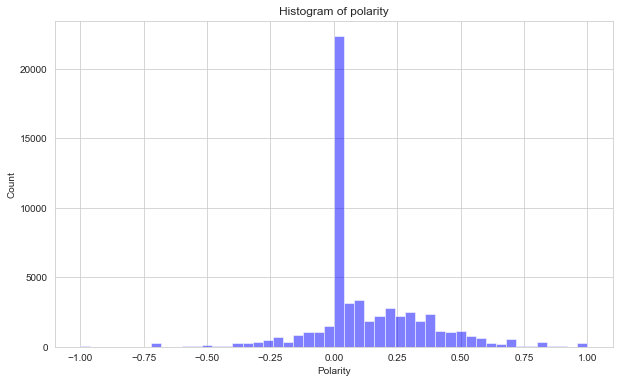

In [71]:
#fonction de masse de la polarité des commentaires
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_polarity_desc1.sentiment, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show();

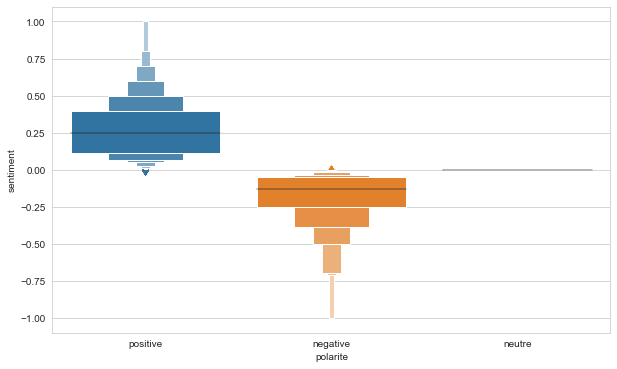

In [72]:
#boxenplot de la polarité des commenatires, boxplot avec plus de quartiles
plt.figure(figsize=(10,6))
sns.boxenplot(x='polarite', y='sentiment', data=df_polarity_desc1)
plt.show();

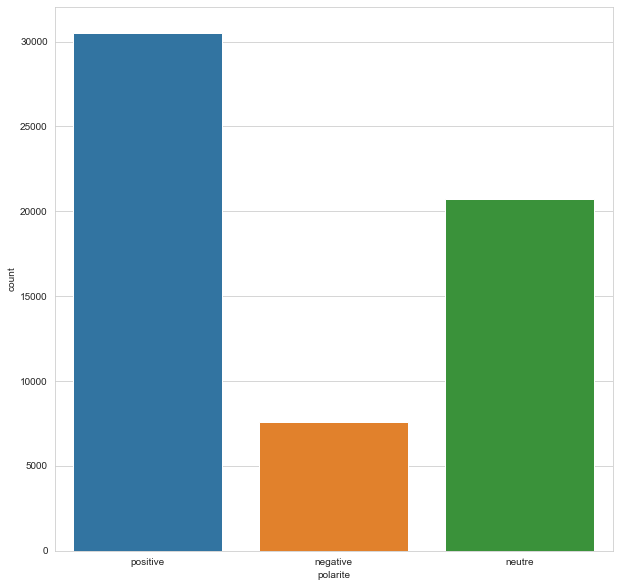

In [73]:
#countplot des modalités correspondant à la polarité des commentaires
df_polarity_desc1.head()
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="polarite", data=df_polarity_desc1)

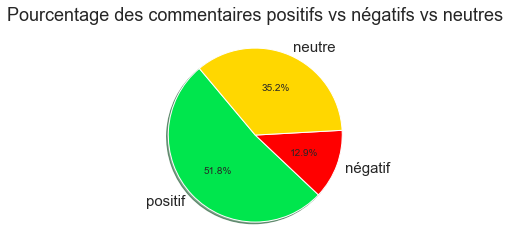

In [74]:
#diagramme circulaire des modalités de la polarité des commentaires
pourcentage_positive = round(len(df_polarity_desc1.loc[(df_polarity_desc1.polarite == "positive")])) / len(df_polarity_desc1)
pourcentage_negative = round(len(df_polarity_desc1.loc[(df_polarity_desc1.polarite == "negative")])) / len(df_polarity_desc1)
pourcentage_neutre = round(len(df_polarity_desc1.loc[(df_polarity_desc1.polarite == "neutre")])) / len(df_polarity_desc1)

fig1, ax1 = plt.subplots()

plt.title("Pourcentage des commentaires positifs vs négatifs vs neutres", fontsize=18)
labels = ['positif', 'négatif', 'neutre']
sizes = [pourcentage_positive, pourcentage_negative, pourcentage_neutre]
#explode = (0, 0.2)  # seulement détacher le second groupe

patches, texts, autotexts = ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', shadow = True, startangle=130, colors = ['#00e64d', 'r', '#FFD700'])
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)
texts[2].set_fontsize(15)

matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams["font.size"] = 18
plt.rcParams["figure.figsize"] = [6, 6]

In [75]:
df = pd.read_csv(r"C:\Users\utilisateur\Documents\Projet\ProjetNLP\booking.csv", na_values=['None'], decimal=',')
df23=df['note']
df24=df['note']
frames = [df23, df24]
df_notes = pd.concat(frames)
df_notes.shape

(61892,)

In [76]:
type(df_notes)

pandas.core.series.Series

In [77]:
df_polarity_desc1_polarite = df_polarity_desc1.iloc[:,1]
#df_polarity_desc1_polarite = pd.DataFrame(df_polarity_desc1_polarite)
df_polarity_desc1_polarite.head()

0    positive
1    positive
2    negative
3      neutre
4    positive
Name: polarite, dtype: object

In [78]:
df_notes.reset_index(drop=True, inplace=True)
df_polarity_desc1_polarite.reset_index(drop=True, inplace=True)
df_corr = pd.concat([df_polarity_desc1_polarite, df_notes], axis = 1)

In [79]:
df_corr.head()

polarite  note
0  positive  10.0
1  positive   9.0
2  negative   9.6
3    neutre  10.0
4  positive   9.0

In [80]:
df_corr=df_corr.loc[(df_corr.polarite=='positive')|(df_corr.polarite=='negative')]

In [81]:
type(df_corr)

pandas.core.frame.DataFrame

In [82]:
df_corr.head()

polarite  note
0  positive  10.0
1  positive   9.0
2  negative   9.6
4  positive   9.0
5  positive   7.9

In [83]:
df_corr['polarite'] = np.where(df_corr['polarite'] == 'positive', 1, 0)
df_corr.head()

polarite  note
0         1  10.0
1         1   9.0
2         0   9.6
4         1   9.0
5         1   7.9

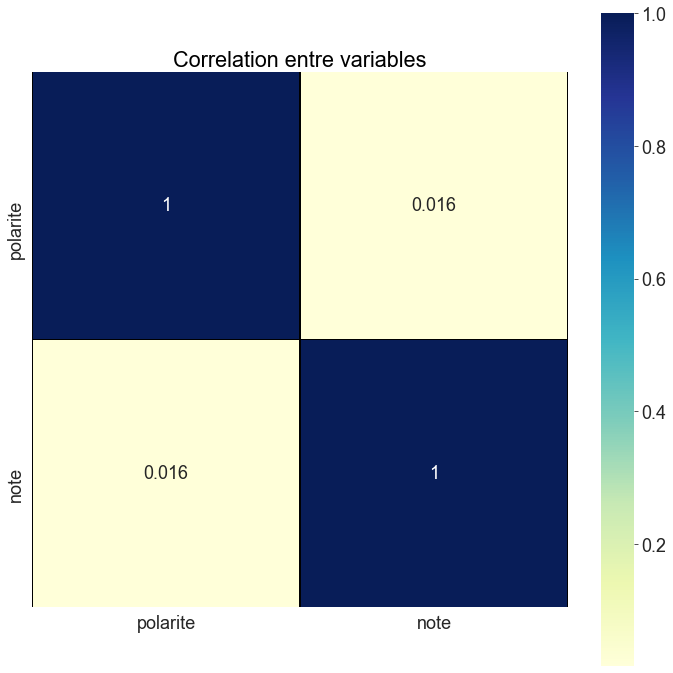

In [84]:
#affichage des corrélations entre variables
#parfaite si r = 1
#très forte si r > 0,8
#forte si r se situe entre 0,5 et 0,8
#d'intensité moyenne si r se situe entre 0,2 et 0,5
#faible si r se situe entre 0 et 0.2

f, ax = plt.subplots(figsize=(12, 12))
plt.title('Correlation entre variables')
sns.heatmap(df_corr.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True);

In [85]:
#concaténation des trois colonnes correspondant aux commentaires sur les hôtels
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
df22 = pd.DataFrame(df, columns= ['titre', 'bons_points', 'mauvais_points'])

df21 = df22['titre'].map(str) + ' ' + df22['bons_points'].map(str) + ' ' + df22['mauvais_points'].map(str)

df21

0        Exceptionnel Établissement recent, propre, soi...
1        Fabuleux  Accueil très chaleureux, chambre cal...
2        Exceptionnel Tout bié sauf le wifi catastrophi...
3          Exceptionnel nan Hôtel parfait. Quartier sympa.
4        Fabuleux  Excellent rapport qualité prix. Pers...
                               ...                        
30941    Exceptionnel L'hôtel est agréable et confortab...
30942    Exceptionnel La chambre, le personnel au top e...
30943    Hôtel très confortable La chambre, ses équipem...
30944         Déjà utilisé plusieurs fois Salle claire nan
30945           Bien  La situation face à la gare Le bruit
Length: 30946, dtype: object

In [86]:
#convertir series en dataframe
df21 = df21.to_frame(name="sentences")

In [87]:
#mettre les commentaires du dataframe en miniscule
df21['sentences']=df21['sentences'].str.lower()
df21.head()

sentences
0  exceptionnel établissement recent, propre, soi...
1  fabuleux  accueil très chaleureux, chambre cal...
2  exceptionnel tout bié sauf le wifi catastrophi...
3    exceptionnel nan hôtel parfait. quartier sympa.
4  fabuleux  excellent rapport qualité prix. pers...

In [88]:
#remplacement de tout ce qui n'est pas dans le set[] par un espace
df21['sentences'] = df21['sentences'].apply(lambda x: re.sub('[^a-zàâéèêëïîôùûçæœ-]+',' ', str(x))) 
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [89]:
#suppression des mots "vides" dans le dataframe
stop = stopwords.words('french')
df21['sentences'] = df21['sentences'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [90]:
#suppression des mots d'une longueur inférieure à 2 caractères
#\b=la fin et le début d'un mot
#`r' ou`R': préfixe pour les chaines de caractère 
df21['sentences']=df21.sentences.str.replace(r'\b(\w{1,2})\b', '')
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [91]:
df22=df21.copy()

In [92]:
type(df22)

pandas.core.frame.DataFrame

In [93]:
df22.head()

sentences
0  exceptionnel établissement recent propre soign...
1  fabuleux accueil très chaleureux chambre calme...
2  exceptionnel tout bié sauf wifi catastrophique...
3      exceptionnel nan hôtel parfait quartier sympa
4  fabuleux excellent rapport qualité prix person...

In [94]:
#Existe-t-il des variables numériques?
df21['sentences'].apply(lambda x: not any(i.isnumeric() for i in x.split())).any()

False

In [95]:
#récupération des commentaires dans le type series
df21 = df21['sentences']
type(df21)

pandas.core.series.Series

In [96]:
#calcul de la polarité des commentaires avec TextBlob
bloblist_desc = list()

df_str=df21.astype(str)
for row in df_str:
    blob = TextBlob(row)
    #print(blob)
    pos_tagger=PatternTagger()
    analyzer=PatternAnalyzer()
    blob = tb(str(blob)) #textblob
    #sentiment renvoie un tuple avec la polarité et la subjectivite
    #print(blob.sentiment[0])
    #type(blob.sentiment[0])
    bloblist_desc.append(blob.sentiment[0])
    #df_polarity_desc1 = pd.DataFrame(bloblist_desc, columns = ['sentiment'])

In [97]:
#récupération des résultats de la polarité dans un dataframe
df_polarity_desc1 = pd.DataFrame(data = bloblist_desc)
df_polarity_desc1.columns = ['sentiment']
df_polarity_desc1.head()

sentiment
0  2.537500e-01
1  5.380000e-01
2  1.387779e-17
3  4.000000e-01
4  5.900000e-01

In [98]:
#classification des commentaires selon trois modalités (neutres, positifs et négatifs) dans un dataframe
def f(df_polarity_desc1):
    if df_polarity_desc1['sentiment'] > 0:
        val = "positive"
    elif df_polarity_desc1['sentiment'] < 0:
        val = "negative"
    else :
        val = "neutre"
    return val

df_polarity_desc1.apply(f, axis=1)
df_polarity_desc1['polarite']=df_polarity_desc1.apply(f, axis=1)

In [99]:
#sélection de la colonne notes 
df = pd.read_csv(r"C:\Users\utilisateur\Documents\Projet\ProjetNLP\booking.csv", na_values=['None'], decimal=',')
df_notes = df.iloc[:,7]
#df_notes = pd.DataFrame(data=df_notes)
df_notes.head()

0    10.0
1     9.0
2     9.6
3    10.0
4     9.0
Name: note, dtype: float64

In [100]:
#sélection de la colonne polarite
df_polarity_desc1_polarite = df_polarity_desc1.iloc[:,1]
#df_polarity_desc1_polarite = pd.DataFrame(df_polarity_desc1_polarite)
df_polarity_desc1_polarite.head()

0    positive
1    positive
2    positive
3    positive
4    positive
Name: polarite, dtype: object

In [101]:
#concaténation de la colonne notes et polarite
df_corr = pd.concat([df_polarity_desc1_polarite, df_notes], axis = 1)

In [102]:
#sélection des modalités postives ou négatives
df_corr=df_corr.loc[(df_corr.polarite=='positive')|(df_corr.polarite=='negative')]

In [103]:
#transformation des valeurs de la polarite en code binaire 0 et 1
df_corr['polarite'] = np.where(df_corr['polarite'] == 'positive', 1, 0)
df_corr.head()

polarite  note
0         1  10.0
1         1   9.0
2         1   9.6
3         1  10.0
4         1   9.0

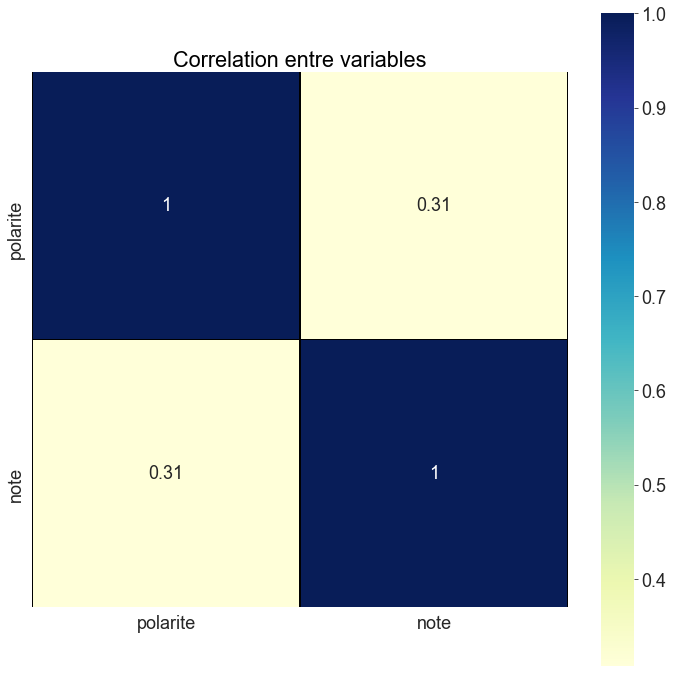

In [104]:
#affichage des corrélations entre variables
#parfaite si r = 1
#très forte si r > 0,8
#forte si r se situe entre 0,5 et 0,8
#d'intensité moyenne si r se situe entre 0,2 et 0,5
#faible si r se situe entre 0 et 0.2

f, ax = plt.subplots(figsize=(12, 12))
plt.title('Correlation entre variables')
sns.heatmap(df_corr.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True);

In [105]:
#df_polarity_desc1.head()

In [106]:
#df_polarity_desc1.columns

In [107]:
#Transformation des valeurs de la variable polarite en 1 et 0
#pas besoin d'utiliser le module scikit-learn car on peut le faire directement 
df_polarity_desc1['polarite'] = np.where(df_polarity_desc1['polarite'] == 'positive', 1, 0)
df_polarity_desc1 = df_polarity_desc1.reset_index(drop=True)
df_polarity_desc1.head()

sentiment  polarite
0  2.537500e-01         1
1  5.380000e-01         1
2  1.387779e-17         1
3  4.000000e-01         1
4  5.900000e-01         1

In [108]:
#supression de la colonne sentiment
df_polarity_desc1.drop(['sentiment'],1,inplace=True)
df_polarity_desc1.head()

polarite
0         1
1         1
2         1
3         1
4         1

In [109]:
#création d'un dataframe comments avec la colonne sentences
df21.head()
comments = pd.DataFrame(data=df21)
comments.columns = ['sentences']
comments.head()
comments.shape
type(comments)

pandas.core.frame.DataFrame

In [110]:
#df_polarity_desc1.shape
#type(df_polarity_desc1)

In [111]:
#concaténation de la colonne sentences et la colonne polarite
dataset = pd.concat([comments, df_polarity_desc1])

In [112]:
comments.reset_index(drop=True, inplace=True)
df_polarity_desc1.reset_index(drop=True, inplace=True)
# fusion des deux datasets en un seul que l'on nommera df
df = pd.concat([df_polarity_desc1, comments], axis = 1)
#df.head(100)

In [113]:
#renommer les colonnes
df.columns=['sentiment', 'sentence']
df.head()

sentiment                                           sentence
0          1  exceptionnel établissement recent propre soign...
1          1  fabuleux accueil très chaleureux chambre calme...
2          1  exceptionnel tout bié sauf wifi catastrophique...
3          1      exceptionnel nan hôtel parfait quartier sympa
4          1  fabuleux excellent rapport qualité prix person...

In [114]:
#supression des données manquantes
df.isnull().values.any()
df.isnull().sum()
df=df.dropna()

In [115]:
#vérification des données manquantes
df.isnull().sum()

sentiment    0
sentence     0
dtype: int64

In [116]:
#création d'un csv contenant le dataframe df utilisé pour le machine learning
#df.to_csv('DatasetMarchineLearning.csv', index=True)

<h1>3. Machine learning</h1>

In [117]:
#création jeux train et test
X_train, X_test, y_train, y_test = train_test_split(df[['sentence']], df['sentiment'])

In [118]:
"""CountVectorizer de Scikit-learn est utilisé pour transformer un corpus de mots en 
vecteurs/occurence des mots """
#Tf signifie term-frequency tandis que tfidf signifie inverse document-frequency
#IDF(word) = Log((Total number of documents)/(Number of documents containing the word))
pipe = make_pipeline(CountVectorizer(), TfidfTransformer())
pipe.fit(X_train['sentence'])
feat_train = pipe.transform(X_train['sentence'])
feat_train.shape

(23209, 15926)

In [119]:
#minimum et maximum pour feat_train
feat_train.min(), feat_train.max()

(0.0, 1.0)

In [120]:
#transformer sans entrainer sur notre jeu test
feat_test = pipe.transform(X_test['sentence'])
feat_test.shape

(7737, 15926)

In [121]:
#arbre de décision
#définir les paramètres
#le paramètre max_depth est un seuil sur la profondeur maximale de l’arbre
"""L'indice de diversité de gini : probabilité pour chaque élément d'être choisi multipliée 
par la probabilité qu'il soit mal classé"""
"""L'entropie au lieu d'utiliser les probabilités simples applique le log2 des probabilités"""
param_grid = {'max_depth' : [400, 500], 
              'criterion' : ['gini', 'entropy']}
             
dtc = DecisionTreeClassifier(random_state=42)

dtc_grid = GridSearchCV(dtc, param_grid, cv=3)
 
#entrainer le modèle à partir de Grid Search
%time DTC = dtc_grid.fit(feat_train, y_train)

print(dtc_grid.best_score_.round(5))
print(dtc_grid.best_params_)

final_model = dtc_grid.best_estimator_

pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

Wall time: 1min 15s
0.90693
{'criterion': 'entropy', 'max_depth': 400}


In [122]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3912
           1       1.00      1.00      1.00     19297

    accuracy                           1.00     23209
   macro avg       1.00      1.00      1.00     23209
weighted avg       1.00      1.00      1.00     23209



In [123]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1321
           1       0.96      0.95      0.95      6416

    accuracy                           0.92      7737
   macro avg       0.87      0.87      0.87      7737
weighted avg       0.93      0.92      0.92      7737



In [124]:
def MatriceConfusion(model):
    y_pred = model.predict(feat_test)
    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, pred_test)
    plt.matshow(cm)
    plt.title('Matrice de confusion', y=1.12)
    plt.colorbar()
    print(cm)
    plt.show()

[[1037  284]
 [ 298 6118]]


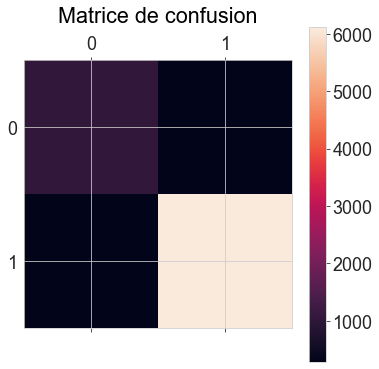

In [125]:
y_prediction = MatriceConfusion(DTC)

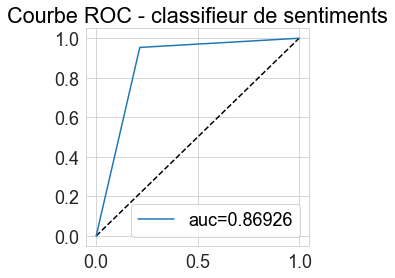

In [126]:
score = final_model.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

In [127]:
"""n_estimators = le nombre d'arbres dans la fôrét"""
"""Le Bootstrapping est un procédé qui permet d’augmenter artificiellement le nombre d’observation d’un 
échantillon de données sans pour autant modifier la distribution des variables présentes dans le jeu de 
données. Le principe est simple, on dispose d’un jeu de données contenant n observations, pour créer un 
échantillon de taille n  on tire avec remise n observations parmi le jeu de données original"""
param_grid = {'max_depth' : [30, 50],
             'n_estimators' : [150, 200]}
              #'bootstrap' : [True, False],
              #'criterion' : ['gini','entropy'] 

rfc = RandomForestClassifier(random_state=42)

rfc_grid = GridSearchCV(rfc, param_grid, cv = 3)

%time RFC = rfc_grid.fit(feat_train, y_train)

print(rfc_grid.best_score_.round(5))
print(rfc_grid.best_params_)

final_model = rfc_grid.best_estimator_

pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

Wall time: 11min 13s
0.86273
{'max_depth': 50, 'n_estimators': 150}


In [128]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      0.36      0.53      3912
           1       0.89      1.00      0.94     19297

    accuracy                           0.89     23209
   macro avg       0.94      0.68      0.74     23209
weighted avg       0.90      0.89      0.87     23209



In [129]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      0.26      0.41      1321
           1       0.87      1.00      0.93      6416

    accuracy                           0.87      7737
   macro avg       0.93      0.63      0.67      7737
weighted avg       0.89      0.87      0.84      7737



[[ 339  982]
 [   0 6416]]


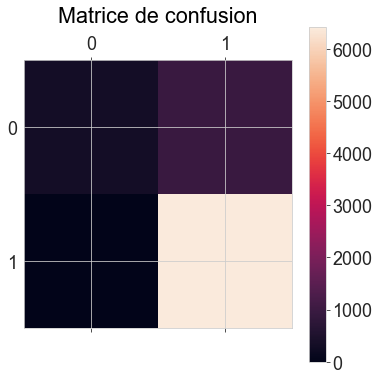

In [130]:
y_pred = MatriceConfusion(RFC)

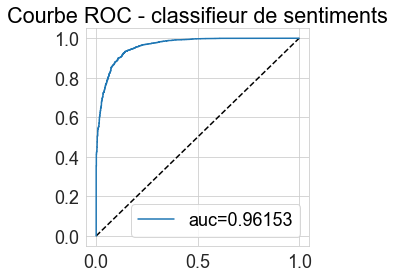

In [131]:
score = final_model.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

In [132]:
"""L1 : Lasso et L2 : Ridge, pénalité, c’est une modification qu’on apporte à la fonction de coût 
afin de maîtriser l’arbitrage entre biais vs variance"""
"""la fonction de coût est définie comme le carré de la différence entre la valeur prévue et la 
valeur réelle en fonction de l'intrant"""
"""quand le biais augmente, la variance baisse"""
param_grid = {'penalty' : ['l1', 'l2']}

lr = LogisticRegression(random_state=42)

lr_grid = GridSearchCV(lr, param_grid, cv = 3)

%time LR = lr_grid.fit(feat_train, y_train)

print(lr_grid.best_score_.round(5))
print(lr_grid.best_params_)

final_model = lr_grid.best_estimator_

pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

Wall time: 3.46 s
0.9268
{'penalty': 'l2'}


In [133]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.97      0.75      0.85      3912
           1       0.95      0.99      0.97     19297

    accuracy                           0.95     23209
   macro avg       0.96      0.87      0.91     23209
weighted avg       0.95      0.95      0.95     23209



In [134]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.95      0.68      0.79      1321
           1       0.94      0.99      0.96      6416

    accuracy                           0.94      7737
   macro avg       0.94      0.84      0.88      7737
weighted avg       0.94      0.94      0.93      7737



[[ 899  422]
 [  50 6366]]


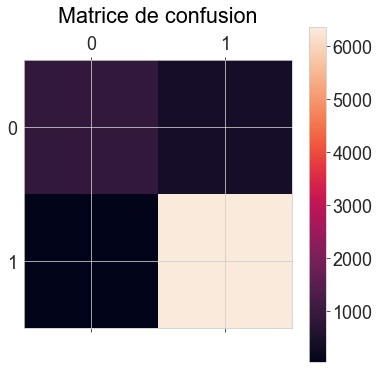

In [135]:
y_pred = MatriceConfusion(LR)

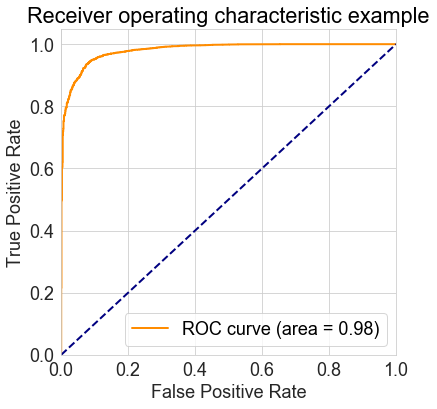

In [136]:
y_score = final_model.decision_function(feat_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [137]:
#bagging
"""Le mot Bagging est une contraction de Bootstrap Aggregation : sélection de sous-ensembles aléatoires de
l'ensemble des données d'origine, puis agrégation des prédictions individuelles pour former une prédiction
finale""" 

naivebayes = nb.BernoulliNB()
modelB = BC(base_estimator = naivebayes, n_estimators = 1000, warm_start = True, bootstrap_features=True, max_samples=0.9)
modelB_fit = modelB.fit(feat_train, y_train)
modelB_fit.score(feat_test,y_test)
pred_train = modelB.predict(feat_train)
pred_test = modelB.predict(feat_test)

In [138]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.71      0.74      0.73      3912
           1       0.95      0.94      0.94     19297

    accuracy                           0.91     23209
   macro avg       0.83      0.84      0.84     23209
weighted avg       0.91      0.91      0.91     23209



In [139]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67      1321
           1       0.93      0.94      0.94      6416

    accuracy                           0.89      7737
   macro avg       0.82      0.80      0.81      7737
weighted avg       0.89      0.89      0.89      7737



[[ 856  465]
 [ 360 6056]]


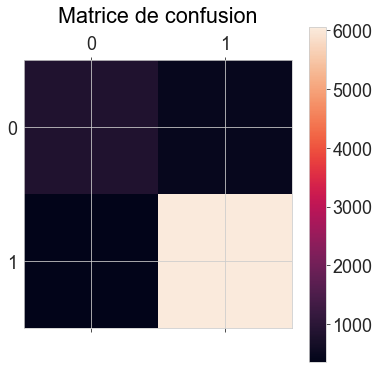

In [140]:
y_pred = MatriceConfusion(modelB_fit)

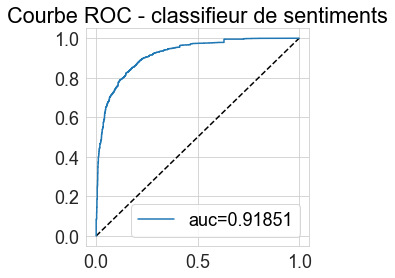

In [141]:
score = modelB_fit.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

In [142]:
param_grid = {#'C': [10, 50, 100,200],
              #'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','sigmoid']}

svm = SVC(random_state=42)

svm_grid = GridSearchCV(svm, param_grid, cv=3)

%time SVM = svm_grid.fit(feat_train, y_train)

print(svm_grid.best_score_.round(5))
print(svm_grid.best_params_)

Wall time: 10min 58s
0.93309
{'kernel': 'rbf'}


In [143]:
final_model = svm_grid.best_estimator_

In [144]:
pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

In [145]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3912
           1       0.99      1.00      1.00     19297

    accuracy                           0.99     23209
   macro avg       1.00      0.98      0.99     23209
weighted avg       0.99      0.99      0.99     23209



In [146]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.95      0.73      0.83      1321
           1       0.95      0.99      0.97      6416

    accuracy                           0.95      7737
   macro avg       0.95      0.86      0.90      7737
weighted avg       0.95      0.95      0.94      7737



[[ 967  354]
 [  54 6362]]


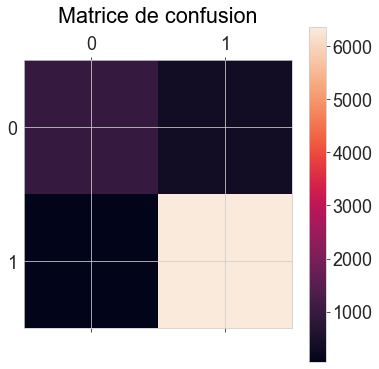

In [147]:
y_pred = MatriceConfusion(SVM)

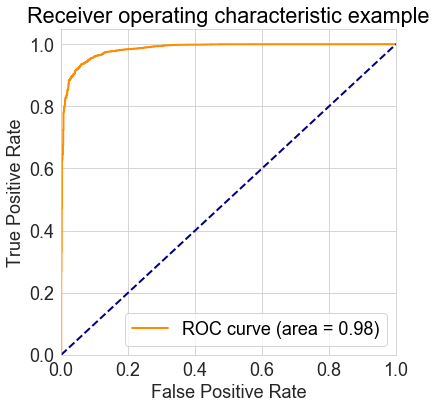

In [148]:
y_score = SVM.decision_function(feat_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
param_grid = {
    #"learning_rate": [0.05,0.01, 0.1],
    #"max_depth":[20, 30, 50],
    #"criterion": ["friedman_mse", "mae", "mse"],
    'n_estimators' : [30, 50, 70]}

gbc=GradientBoostingClassifier(random_state=42)

gbc_grid = GridSearchCV(gbc, param_grid, cv = 3)

%time GBC = gbc_grid.fit(feat_train, y_train)
print (gbc_grid.best_score_.round(5))
print(gbc_grid.best_params_)

final_model = gbc_grid.best_estimator_

pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

In [ ]:
print(classification_report(y_train, pred_train))

In [ ]:
print(classification_report(y_test, pred_test))

In [ ]:
y_pred = MatriceConfusion(GBC)

In [ ]:
score = gbc_grid.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

In [ ]:
#un n-gramme est “une sous-séquence de n éléments construite à partir d’une séquence donnée” 
#n-gramme permet de créer un modèle probabiliste pour anticiper le prochain élément d’une suite
#padding="remplissage"
generated_ngrams = ngrams(word_tokenize(X_train.iloc[0,0]), 3, pad_left=True, pad_right=True)
list(generated_ngrams)[:7]

In [ ]:
#ngram_range of (1, 2) means unigrams and bigrams
#Un 2-gram (or bi-gram) est une séquance de 2 mots : “please turn”, “turn your” 
pipe2 = make_pipeline(CountVectorizer(ngram_range=(1, 2)),
                      TfidfTransformer())
pipe2.fit(X_train['sentence'])
feat_train2 = pipe2.transform(X_train['sentence'])
feat_train2.shape

In [ ]:
#get_feature_names() - retourne une liste de feature names, classés par leurs indices
cl = pipe2.steps[0]
cl[1].get_feature_names()[:10]

In [ ]:
feat_test2 = pipe2.transform(X_test['sentence'])

In [ ]:
param_grid = {'penalty' : ['l1', 'l2']}

lr = LogisticRegression(random_state=42)

lr_grid = GridSearchCV(lr, param_grid, cv = 3)

%time LR = lr_grid.fit(feat_train2, y_train)

print(lr_grid.best_score_.round(5))
print(lr_grid.best_params_)

In [ ]:
feat_test2 = pipe2.transform(X_test['sentence'])

In [ ]:
final_model = lr_grid.best_estimator_

pred_train = final_model.predict(feat_train2) 
pred_test = final_model.predict(feat_test2)

In [ ]:
print(classification_report(y_train, pred_train))

In [ ]:
print(classification_report(y_train, pred_train))

In [ ]:
"""SVD est une technique de factorisation matricielle qui factorise une matrice M dans les trois matrices U,
Σ  et V. Très similaire à l'ACP, sauf que la factorisation pour SVD est effectuée sur la matrice de données, tandis que pour PCA, est une technique de factorisation matricielle qui factorise une matrice M dans les trois matrices U, Σ et V.Ceci est très similaire à l'ACP, sauf que la factorisation pour SVD est effectuée sur la matrice de données, 
pas sur la matrice de covariance."""
#n_components, dimensions qui doivent être inférieures aux colonnes
pipe_svd = make_pipeline(CountVectorizer(), TruncatedSVD(n_components=300))
pipe_svd.fit(X_train['sentence'])
feat_train_svd = pipe_svd.transform(X_train['sentence'])
feat_train_svd.shape

In [ ]:
param_grid = {'penalty' : ['l1', 'l2']}

lr = LogisticRegression(random_state=42)

lr_grid = GridSearchCV(lr, param_grid, cv = 3)

%time LR = lr_grid.fit(feat_train_svd, y_train)

print(lr_grid.best_score_.round(5))
print(lr_grid.best_params_)

In [ ]:
feat_test_svd = pipe_svd.transform(X_test['sentence'])

In [ ]:
final_model = lr_grid.best_estimator_

pred_train = final_model.predict(feat_train_svd) 
pred_test = final_model.predict(feat_test_svd)

In [ ]:
print(classification_report(y_train, pred_train))

In [ ]:
print(classification_report(y_test, pred_test))

In [ ]:
pipe_svd_tfidf = make_pipeline(CountVectorizer(),
                     TfidfTransformer(),
                     TruncatedSVD(n_components=300))
pipe_svd_tfidf.fit(X_train['sentence'])
feat_train_svd_tfidf = pipe_svd_tfidf.transform(X_train['sentence'])
feat_test_svd_tfidf = pipe_svd_tfidf.transform(X_test['sentence'])

In [ ]:
param_grid = {'penalty' : ['l1', 'l2']}

lr = LogisticRegression(random_state=42)

lr_grid = GridSearchCV(lr, param_grid, cv = 3)

%time LR = lr_grid.fit(feat_train_svd_tfidf, y_train)

print(lr_grid.best_score_.round(5))
print(lr_grid.best_params_)

In [ ]:
final_model = lr_grid.best_estimator_

pred_train = final_model.predict(feat_train_svd_tfidf) 
pred_test = final_model.predict(feat_test_svd_tfidf)

In [ ]:
print(classification_report(y_train, pred_train))

In [ ]:
print(classification_report(y_test, pred_test))

In [ ]:
#deacc=True, enlève les ponctuations
from gensim.utils import tokenize
sentance = [list(tokenize(s, deacc=True, lower=True)) for s in X_train['sentence']]
sentance[0]

In [ ]:
#word2vec, réductions des dimensions
#paramètre : https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
#size : the size of the dense vector to represent each token or word 
#window : the maximum distance between the target word and its neighboring word
#min_count : minimium frequency count of words, the model would ignore words that do not satisfy the min_count
#iter : number of iterations (epochs) over the corpus
from gensim.models import word2vec
model = word2vec.Word2Vec(sentance, size=300, window=20,
                          min_count=2, workers=1, iter=100)
model.corpus_count

In [ ]:
"""The vocabulary is in the vocab field of the Word2Vec model's wv property, as a dictionary, 
with the keys being each token (word)"""
vocab = model.wv.vocab
list(vocab)[:5]

In [ ]:
model.wv.vectors.shape

In [ ]:
model.save('trained_word2vec.bin')

In [ ]:
model.most_similar('bien')

In [ ]:
#Les dix premières coordonnées du vecteur associé au mot fabuleux
model.wv['fabuleux'].shape, model.wv['fabuleux'][:10]

In [ ]:
try:
    model.wv['rrrrrrrr']
except KeyError as e:
    print(e)

In [ ]:
import numpy as np
#somme des vecteurs associés aux mots
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = np.vstack([sum_vectors(p, model) for p in X])
    return feats

wv_train_feat = word2vec_features(X_train["sentence"], model)
wv_train_feat.shape

In [ ]:
clfwv = LogisticRegression(solver='lbfgs', max_iter=1000)
clfwv.fit(wv_train_feat, y_train)

In [ ]:
wv_test_feat = word2vec_features(X_test["sentence"], model)

In [ ]:
clfwv.score(wv_test_feat, y_test)

In [ ]:
words = list(sorted(model.wv.vocab))
words[:10]

In [ ]:
subset = ['exceptionnel', 'personnel', words[3], words[4], words[5]]
rows = []
for w in subset:
    for ww in subset:
        rows.append(dict(w1=w, w2=ww, d=model.wv.similarity(w, ww)))
import pandas
pandas.DataFrame(rows).pivot("w1", "w2", "d")

In [ ]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])